# Analysis 1.0 

## Import packages

In [1]:
#general
import pandas as pd 
import matplotlib
from matplotlib import pyplot as plt
from cycler import cycler
import json
import numpy as np
import warnings
import pickle
from pprint import pprint
from datetime import date
import tqdm
from tqdm import tqdm
from itertools import cycle
from array import array

#for OpenAlex
import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
from itertools import chain

#for Gender Guesser
from urllib.request import urlopen
from genderize import Genderize
import gender_guesser.detector as gender
import pycountry
import re

#for Geopandas
import mapclassify
import geopandas as gpd
from shapely.geometry import Polygon

#for topic model
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.stem.porter import *

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import scipy.interpolate.interpnd
import pyLDAvis
import pyLDAvis.gensim

In [2]:
#unwanted warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Import data

In [3]:
%%time
with open('Data backup/16112023authordata.pkl', 'rb') as f:
    author_data = pickle.load(f)

CPU times: user 1.19 s, sys: 640 ms, total: 1.83 s
Wall time: 3 s


In [4]:
%%time
with open('Data backup/08112023articledata.pkl', 'rb') as f:
    article_data = pickle.load(f)

CPU times: user 1.48 s, sys: 1.97 s, total: 3.45 s
Wall time: 9.32 s


## Clean data

In [5]:
#author data should be duplicated due to some papers having several authors
print(len(author_data))
print(author_data.article_id.nunique())
print(len(author_data.drop_duplicates(subset=['article_id'])))

2000305
518351
518351


In [6]:
#article data should not be duplicated. 
print(len(article_data))
print(article_data.article_id.nunique())
print(len(article_data.drop_duplicates(subset=['article_id'])))

527193
527169
527169


In [7]:
#Clean article data for duplicates 
article_data=article_data.drop_duplicates(subset=['article_id'])
print(len(article_data))

527169


In [8]:
#merge article and author data into one dataframe

In [9]:
print(len(article_data)) #the article data can be longer due to missing author data info - we should remove this from article data
print(author_data.article_id.nunique()) #auhtor data article ids should match article ids per first positon
print(len(author_data[author_data['author_position']=='first'])) #this is longer - so we must have duplicates here

527169
518351
518375


In [10]:
#find duplicates 
first_author_data=author_data[author_data['author_position']=='first']
first_author_article_id=first_author_data['article_id']
unique_article_id=pd.Series(author_data['article_id'].unique())

In [11]:
len(first_author_article_id)-len(unique_article_id)

24

In [12]:
# Find IDs that are in series1 but not in series2
diff_ids_first_author = first_author_article_id[~first_author_article_id.isin(unique_article_id)]

# Find IDs that are in series2 but not in series1
diff_ids_unique = unique_article_id[~unique_article_id.isin(first_author_article_id)]

# Combine both sets of differing IDs
all_diff_ids = pd.concat([diff_ids_first_author, diff_ids_unique])

print("IDs in series1 but not in series2:")
print(diff_ids_first_author)

print("\nIDs in series2 but not in series1:")
print(diff_ids_unique)

print("\nAll differing IDs:")
print(all_diff_ids)

IDs in series1 but not in series2:
Series([], Name: article_id, dtype: object)

IDs in series2 but not in series1:
Series([], dtype: object)

All differing IDs:
Series([], dtype: object)


In [13]:
# Find and print the duplicate IDs
duplicate_ids = first_author_article_id[first_author_article_id.duplicated()]
print("Duplicate IDs:", duplicate_ids)


Duplicate IDs: 55500      https://openalex.org/W4234339056
290594     https://openalex.org/W2035314140
338162     https://openalex.org/W3125556312
338163     https://openalex.org/W2316535545
338164     https://openalex.org/W2111441948
585111     https://openalex.org/W2036660639
1577025    https://openalex.org/W3204437910
1577030    https://openalex.org/W3216943153
1577034    https://openalex.org/W3098437163
1577042    https://openalex.org/W3135460778
1577043    https://openalex.org/W3131052732
1577045    https://openalex.org/W3134611429
1577052    https://openalex.org/W3094179919
1577055    https://openalex.org/W3146527195
1577061    https://openalex.org/W3155447072
1577065    https://openalex.org/W3134883889
1577070    https://openalex.org/W3160022076
1577076    https://openalex.org/W3171124799
1577079    https://openalex.org/W3165130521
1577081    https://openalex.org/W3168675126
1577084    https://openalex.org/W3156339046
1577094    https://openalex.org/W3180244721
1577099    https:

In [14]:
duplicate_author_data=first_author_data[first_author_data['article_id'].isin(duplicate_ids.to_list())]
duplicate_author_data = duplicate_author_data.sort_values(by='article_id')
duplicate_author_data

author_position author_countries  is_corresponding  \
290541            first               CH              True   
290594            first               CH              True   
2730              first               US              True   
585111            first               US              True   
338160            first          unknown             False   
338164            first          unknown             False   
338159            first          unknown              True   
338163            first          unknown              True   
1577052           first               BR              True   
1576970           first               BR              True   
1577034           first               US              True   
1576952           first               US              True   
338158            first               US              True   
338162            first               US              True   
1576961           first               GB             False   
1577043           first               GB             False   
1576963           first               US              True   
1577045           first               US              True   
1576983           first               KR             False   
1577065           first               KR             False   
1577042           first               FR              True   
1576960           first               FR              True   
1576973           first               SK             False   
1577055           first               SK             False   
1576979           first               SA              True   
1577061           first               SA              True   
1577002           first               GB              True   
1577084           first               GB              True   
1576988           first               CN             False   
1577070           first               CN             False   
1577079           first               IN             False   
1576997           first               IN             False   
1576999           first               US              True   
1577081           first               US              True   
1577076           first               AU             False   
1576994           first               AU             False   
1577017           first               US             False   
1577099           first               US             False   
1577012           first               US             False   
1577094           first               US             False   
1577025           first               PK             False   
1576943           first               PK             False   
1576948           first               CN             False   
1577030           first               CN             False   
1577019           first               US             False   
1577101           first               US             False   
55500             first               FR             False   
55496             first               FR             False   

                                    raw_affiliation_string  \
290541   Centre de Recherches en Physique des Plasmas, ...   
290594   Centre de Recherches en Physique des Plasmas, ...   
2730     S. Outcalt is an assistant professor of geogra...   
585111   S. Outcalt is an assistant professor of geogra...   
338160                                                       
338164                                                       
338159                                                       
338163                                                       
1577052  Federal Institute of Rio de Janeiro, Antônio B...   
1576970  Federal Institute of Rio de Janeiro, Antônio B...   
1577034  Idaho National Laboratory, P. O. Box 1625 MS 6...   
1576952  Idaho National Laboratory, P. O. Box 1625 MS 6...   
338158                            #N#Fordham University#N#   
338162                            #N#Fordham University#N#   
1576961  Department of Chemical Enginee

In [15]:
#now that we have checked the duplicates we want to remove them from the author data
# Remove duplicates and print the updated Series
drop_duplicate_author_data=duplicate_author_data.drop_duplicates(subset=['article_id'], keep='last')
print(len(duplicate_author_data))
print(len(drop_duplicate_author_data))


48
24


In [16]:
#check that first author data and unique IDs are now same length
first_author_data=first_author_data.drop_duplicates(subset=['article_id'], keep='first')
print(len(first_author_data))
print(len(unique_article_id))

518351
518351


In [17]:
#finally let's make sure to drop the same index in the overall author dataset 
indices_to_remove = drop_duplicate_author_data.index.to_list()

# Remove entries based on index
author_data = author_data.drop(indices_to_remove)

In [18]:
print(len(article_data)) #the article data can be longer due to missing author data info - we should remove this from article data
print(author_data.article_id.nunique()) #auhtor data article ids should match article ids per first positon
print(len(author_data[author_data['author_position']=='first'])) #it matches! 

527169
518351
518351


In [19]:
#finally lets merge author data and article data
article_author_data=pd.merge(article_data, author_data, on='article_id')

In [20]:
#check that it works 
print(len(article_author_data)) #we have multiply authors per article so this should be longer
print(article_author_data.article_id.nunique()) #auhtor data article ids should match article ids per first positon
print(len(article_author_data[article_author_data['author_position']=='first'])) #it works! 

2000281
518351
518351


In [21]:
first_author_article_data=article_author_data[article_author_data['author_position']=='first']

After making sure our data does not contain duplicates we end up with 5 dataframes to work with overall 
- article_data. Containing only info on our articles represented by our author
- author_data. Containing only info on our authors. 
- article_author_data. The two merged containing info on both articles and authors
- first_author_data. Containing only info on first author 
- first_author_article_data. Containing both article and author info on first author

However, since article_author_data and first_author_article_data contains all info we will primeraly use these 

## Plotting

In [708]:
#define colors

# Get the PuRd colormap
cmap = plt.get_cmap('PuRd')
num_colors = 10  # Number of colors
# Create a list of colors from the colormap
purd_colors = [cmap(i / num_colors) for i in range(num_colors)]


In [720]:
#plotting parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['tab:pink', 'tab:red', 'tab:purple', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:olive', 'tab:orange', 'tab:brown', 'tab:gray']) 
plt.rcParams['axes.prop_cycle'] = cycler(color=purd_colors[3::])
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "serif"


font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


In [5466]:
def cat_plot(data, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.Series): The input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.

    Returns:
    - None
    """
    # count the number and/or percentage within each category
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    fig, ax = plt.subplots()
    bars = ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 10:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories
    for cat, c in zip(cats, count):
        if len(cats) <=10 and c >= 2:
            ax.text(cat, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(cats, font=font, size=12, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [5456]:
#this one works 
def cat_plot_compare(data1, data2, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None, label1='Dataset 1', label2='Dataset 2'):
    """
    Create a categorical plot for given DataFrame columns for comparison.

    Parameters:
    - data1 (pd.Series): The first input DataFrame column.
    - data2 (pd.Series): The second input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters then use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - label1 (str): Label for Dataset 1. Default is 'Dataset 1'.
    - label2 (str): Label for Dataset 2. Default is 'Dataset 2'.

    Returns:
    - None
    """
    # Merge data1 and data2 to ensure all categories are represented
    merged_data = pd.merge(data1, data2, how='outer', left_index=True, right_index=True, suffixes=('_df1', '_df2'))

    #count N without turning into percentage in both dataframes 
    count_n1 = merged_data[data1.name + '_df1'].value_counts().reset_index()
    count_n2 = merged_data[data2.name + '_df2'].value_counts().reset_index()

    # get value counts with the parameter normalize in order to be able to get percentage of both dataframes
    value_counts1 = merged_data[data1.name + '_df1'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts2 = merged_data[data2.name + '_df2'].value_counts(normalize=norm).mul(multiply).reset_index()

    # Sort the value counts by category
    all_categories = set(value_counts1[data1.name + '_df1']).union(set(value_counts2[data2.name + '_df2']))
    value_counts1 = value_counts1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    count_n1 = count_n1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    value_counts2 = value_counts2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()
    count_n2 = count_n2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()

    #select either count or category column 
    count_n1 = count_n1.iloc[:, 1]
    count1 = value_counts1.iloc[:, 1]
    cats1 = value_counts1.iloc[:, 0]

    count2 = value_counts2.iloc[:, 1]
    count_n2 = count_n2.iloc[:, 1]
    cats2 = value_counts2.iloc[:, 0]

    width = 0.4  # width of the bars

    # Get integer positions for each category
    cat_positions1 = range(len(cats1))
    cat_positions2 = [pos + width + 0.01 for pos in cat_positions1]

    #define colors
    # Get the PuRd colormap
    cmap = plt.get_cmap('PuRd')
    num_colors = 10  # Number of colors
    # Create a list of colors from the colormap
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]
    color1=purd_colors[5]
    color2=purd_colors[3]

    fig, ax = plt.subplots()
    bars1=ax.bar(cat_positions1, count1, width, alpha=0.6, color=color1, edgecolor='white', label=label1)
    bars2=ax.bar(cat_positions2, count2, width, alpha=0.6, color=color2, edgecolor='white', label=label2)

    # Add text on top of each bar if the number of bars is 10 or less for both datasets and count is more than zero 
    if len(bars1) <= 10:
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            if count_n1.iloc[i] > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n1.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    if len(bars2) <= 10:
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            if count_n2.iloc[i] > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n2.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)


    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories for both datasets
    for cat, c1, c2, bar1, bar2 in zip(all_categories, count1, count2, bars1, bars2):
        if len(cat) <= 10 and c1 >= 2:
            percentbar1 = c1
            ax.text(bar1.get_x() + bar1.get_width() / 2, c1 / 2, f'{percentbar1:.1f}%', ha='center', va='center', color='white', fontsize=12)
        if len(cat) <= 10 and c2 >= 2:
            percentbar2 = c2
            ax.text(bar2.get_x() + bar2.get_width() / 2, c2 / 2, f'{percentbar2:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks([pos + width / 2 for pos in cat_positions1], cats1, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    save_path = f'Plots/{date.today()}/{str(save_name)}'
    plt.savefig(save_path)

    plt.show()

    plt.show()

In [712]:
def cat10_plot(data, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=font, rot=0, xmargins=None, save_name=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalise data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): font type. If chinese letters then use: 'Heiti TC'. Default is font. 
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    # Assuming you want to plot the value counts of the 'publication_year' column
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:10]    
    count=value_counts.iloc[:,1]
    cats=value_counts.iloc[:,0]
    
    fig, ax = plt.subplots()
    ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')
    plt.xticks(cats, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name=save_name
    save_path=f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)
    
    plt.show()



In [5481]:
def cat_top_plot(data, top_n=10, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - top_n (int): The number of top categories to display. Default is 10.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalize data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    # count the number and/or percentage within each category and set the top categories that you would want
    top_n = top_n
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:top_n]
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 10:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more
    for cat, c in zip(cats, count):
        if len(cat) <=10 and c >= 2:
            ax.text(cat, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(cats, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [3153]:
def cat_top_plot_short_names(data, top_n=10, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name=None, legend_labels=None, short_names=short_names):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - top_n (int): The number of top categories to display. Default is 10.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalize data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    # count the number and/or percentage within each category and set the top categories that you would want
    top_n = top_n
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:top_n]
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    # Create short versions of journal names for x-ticks
    short_names = short_names

    #create legend labels
    if legend_labels is None:
        legend_labels = [f'{cats[i]}' for i in range(len(cats))]

    #create colors 
    num_colors = len(short_names)+3
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(short_names, count, width=0.8, alpha=0.6, edgecolor='white',color=purd_colors[3::], label=legend_labels)

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 5:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories
    for cat, short_name, c in zip(cats, short_names, count):
        if top_n <= 10 and c >= 2:
            ax.text(short_name, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(short_names, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=None, fontsize=8, loc="upper right")

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [713]:
def Sturges_bins(data):
    
    """
    INPUT:
    data = 1d array of all data
    
    OUTPUT:
    k = number of bins to use
    """
    
    # Number of data
    N = len(data)
    
    # Number of bins
    k = int( np.ceil( np.log2(N) ) + 1 )
    
    return k

In [2996]:
def hist_plot(data, N_bins=None, log=False, title=None, xlabel=None, ylabel='Frequency', xmargins=None, save_name=None, legend_labels=None):
    """
    Create a histogram for given DataFrame columns.

    Parameters:
    - data (List[pd.Series]): List of input DataFrame columns.
    - log (True/False): Plot on log scale. Default is False.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel (str): The label for the y-axis. Default is 'Frequency'.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - legend_labels (List[str]): List of legend labels for each dataset. Default is None.

    Returns:
    - None
    """
    
    fig, ax = plt.subplots()
    
    if legend_labels is None:
        legend_labels = [f'Data {i + 1}' for i in range(len(data))]
    
    for i, (column_data, legend_label) in enumerate(zip(data, legend_labels)):
        # Extract values from histogram and outline data
        if N_bins is None: N_bins = Sturges_bins(data)
        counts, bin_edges, _ = ax.hist(column_data, bins=N_bins, log=log, alpha=0.6, edgecolor='white', label=legend_label)
        bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
        binwidth = bin_edges[1] - bin_edges[0]

        # Poisson errors on the count in each bin
        s_counts = np.sqrt(counts)

        # We remove any bins, which don't have any counts in them:
        x = bin_centers[counts>0]
        y = counts[counts>0]
        sy = s_counts[counts>0]

        # Plot data with error
        ax.errorbar(x, y, yerr=sy, fmt='.', color='k', ecolor='k', elinewidth=1, capsize=1, capthick=1) #label=f'Counts with Poisson Errors {i + 1}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.margins(x=xmargins)
    
    ax.legend()
    
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)
    
    plt.show()

In [3013]:
def hist_plot(data, N_bins=None, log=False, title=None, xlabel=None, ylabel='Frequency', xmargins=None, save_name=None, legend_labels=None, disp_legend=True):
    """
    Create a histogram for given DataFrame columns.

    Parameters:
    - data (List[pd.Series]): List of input DataFrame columns.
    - log (True/False): Plot on log scale. Default is False.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel (str): The label for the y-axis. Default is 'Frequency'.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - legend_labels (List[str]): List of legend labels for each dataset. Default is None.

    Returns:
    - None
    """
    
    fig, ax = plt.subplots()
    
    if legend_labels is None:
        legend_labels = [f'Data {i + 1}' for i in range(len(data))]
    
    for i, (column_data, legend_label) in enumerate(zip(data, legend_labels)):
        # Extract values from histogram and outline data
        if N_bins is None: N_bins = Sturges_bins(data[0])
        counts, bin_edges, _ = ax.hist(column_data, bins=N_bins, log=log, alpha=0.6, edgecolor='white', label=legend_label)
        bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
        binwidth = bin_edges[1] - bin_edges[0]

        # Poisson errors on the count in each bin
        s_counts = np.sqrt(counts)

        # We remove any bins, which don't have any counts in them:
        x = bin_centers[counts>0]
        y = counts[counts>0]
        sy = s_counts[counts>0]

        # Plot data with error
        ax.errorbar(x, y, yerr=sy, fmt='.', color='k', ecolor='k', elinewidth=1, capsize=1, capthick=1) #label=f'Counts with Poisson Errors {i + 1}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.margins(x=xmargins)

    if disp_legend is True:
        ax.legend()
    
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)
    
    plt.show()

In [5164]:
#THIS ONE FINALLY WORKS! 

def stacked_bar_plot_normalized(dataframe, x_col, y_cols, title=None, xlabel=None, ylabel=None, xmargins=None, ymargins=None, save_name=None):
    """
    Generate a stacked bar plot for normalized gender distribution over years.

    Parameters:
    - dataframe: DataFrame containing the data.
    - year_col: Column name for the years.
    - gender_cols: List of column names representing different gender categories.
    - title: Title of the plot. Default is None.
    - xlabel: Label for the x-axis. Default is None.
    - ylabel: Label for the y-axis. Default is None.
    """

    # Calculate the total count per year
    total_counts = dataframe[y_cols].sum(axis=1)

    # Normalize the data to percentages
    normalized_df = dataframe.copy()
    for y_col in y_cols:
        normalized_df[y_col] = (normalized_df[y_col] / total_counts) * 100

    # Initialize the bottom values for stacking
    bottom_values = [0] * len(normalized_df)
    # initialize the height values for stacking
    height_values = []

    # create colors
    num_colors = 20
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    reversed_colors = list(reversed(colors))
    selected_colors = [reversed_colors[i] for i in [0, 2, 4, 5, 7]]

    fig, ax = plt.subplots()
    for i, y_col in enumerate(y_cols):
        color = selected_colors[i]
        bars = ax.bar(normalized_df[x_col], normalized_df[y_col], bottom=bottom_values, edgecolor='white', color=color, alpha=0.7, label=y_col)
        bottom_values = [bottom + value for bottom, value in zip(bottom_values, normalized_df[y_col])]
        height_values.extend([bottom for bottom in bottom_values])

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 5:
        for i, bar in enumerate(bars):
            height = 100
            ax.text(bar.get_x() + bar.get_width() / 2, 100, f'N={total_counts.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Create an iterator from the height list
    height_iterator = cycle(height_values)

    # Iterate through the columns (categories) of normalized_df[y_col]
    for i, y_col in enumerate(y_cols):
        for j, bars in enumerate(ax.patches[i::len(y_cols)]):
            val = normalized_df[y_col].iloc[j]

            # Manually set x position
            x_position = np.sort([bars.get_x() for bars in ax.patches[i::len(y_cols)]])
            x_position = [x_position[i] for i in range(len(x_position))]
            custom_x = x_position[j]

            # Add text for each category at the appropriate height if val >= 5
            if val >= 5:
                # Use the next value from the iterator as the current_height
                current_height = next(height_iterator)
                ax.text(custom_x + bars.get_width() / 2, current_height-1, f'{val:.1f}%', ha='center', va='top', color='white', fontsize=10)
            else:
                # Skip updating the iterator if the condition is not met
                next(height_iterator)

    # Adding labels and title
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.margins(x=xmargins, y=ymargins)
    plt.legend(fontsize=12)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{[name for name, obj in globals().items() if obj is dataframe][0]}{save_name}'
    plt.savefig(save_path)

    # Display the plot
    plt.show()


In [716]:
def plt_plot(x, y, title=None, xlabel=None, ylabel=None, label=None, font='font', xmargins=None, new_figure=True):
    """
    Create a plot between two variables for two given lists of numbers.

    Parameters:
    - x (list): The input x data.
    - y (list): The input y data.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - font(str): font type. If Chinese letters then use: 'Heiti TC'. Default is 'font'.
    - xmargins (float): The margins for the x-axis. Default is None.
    - new_figure (bool): Whether to create a new figure or plot in the same figure. Default is True.

    Returns:
    - None
    """
    if new_figure:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.gcf(), plt.gca()

    ax.plot(x, y, label=label)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    save_path = f'Plots/{date.today()}/{[name for name, obj in globals().items() if obj is x][0]}{[name for name, obj in globals().items() if obj is y][0]}'
    plt.savefig(save_path)

    plt.show()


### Plot author data

In [57]:
author_data.columns

Index(['author_position', 'author_countries', 'is_corresponding',
       'raw_affiliation_string', 'raw_author_name', 'author.display_name',
       'author.id', 'institution_country_code', 'institution_name',
       'institution_id', 'institution_type', 'article_id',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender'],
      dtype='object')

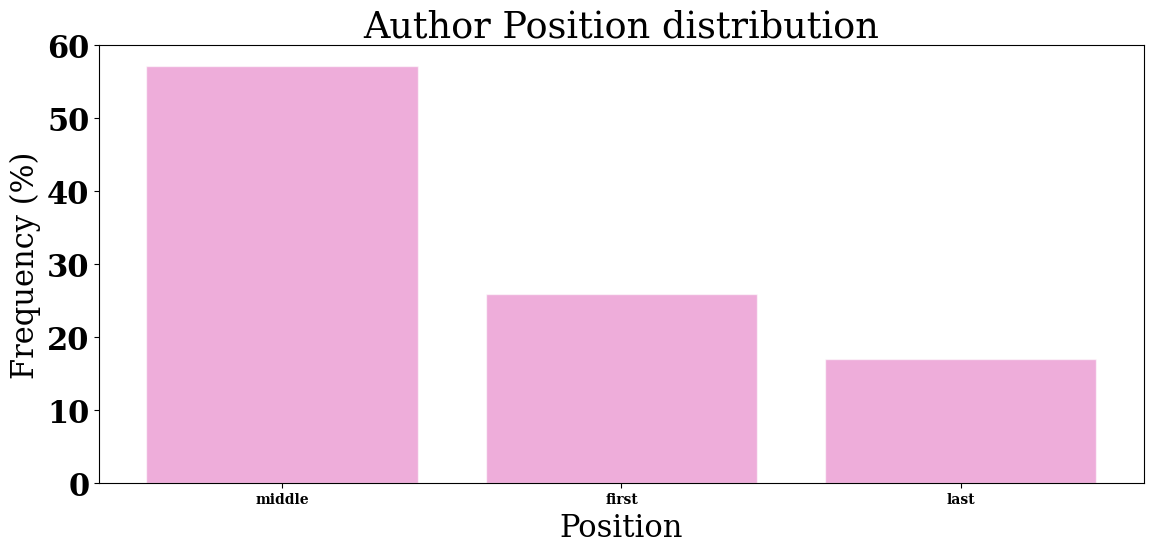

In [60]:
cat_plot(article_author_data.author_position, title='Author Position distribution', xlabel='Position', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None, save_name='article_author_data')


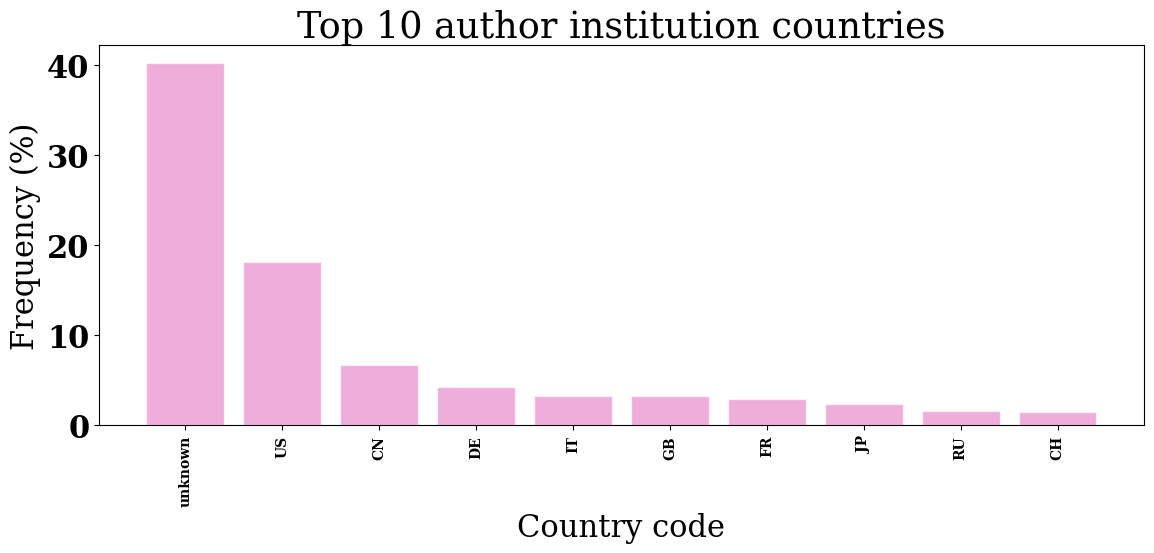

In [61]:
cat10_plot(article_author_data.institution_country_code, title='Top 10 author institution countries', xlabel='Country code', ylabel='Frequency (%)', norm=True, multiply=100, rot=90, xmargins=None, save_name='article_author_data')


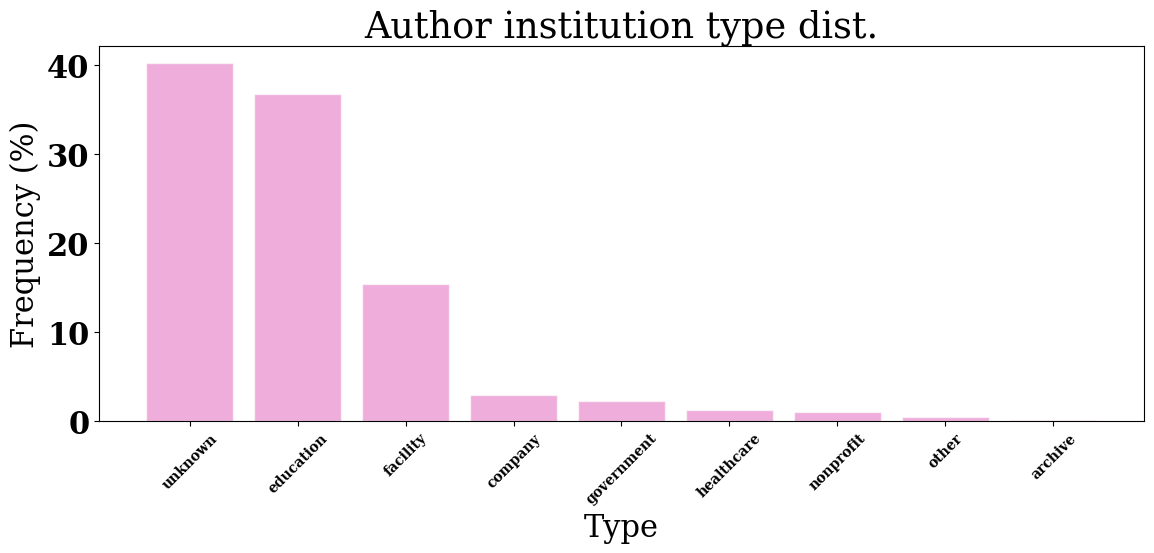

In [62]:
cat_plot(article_author_data.institution_type, title='Author institution type dist.', xlabel='Type', ylabel='Frequency (%)', norm=True, multiply=100, rot=45, save_name='article_author_data')


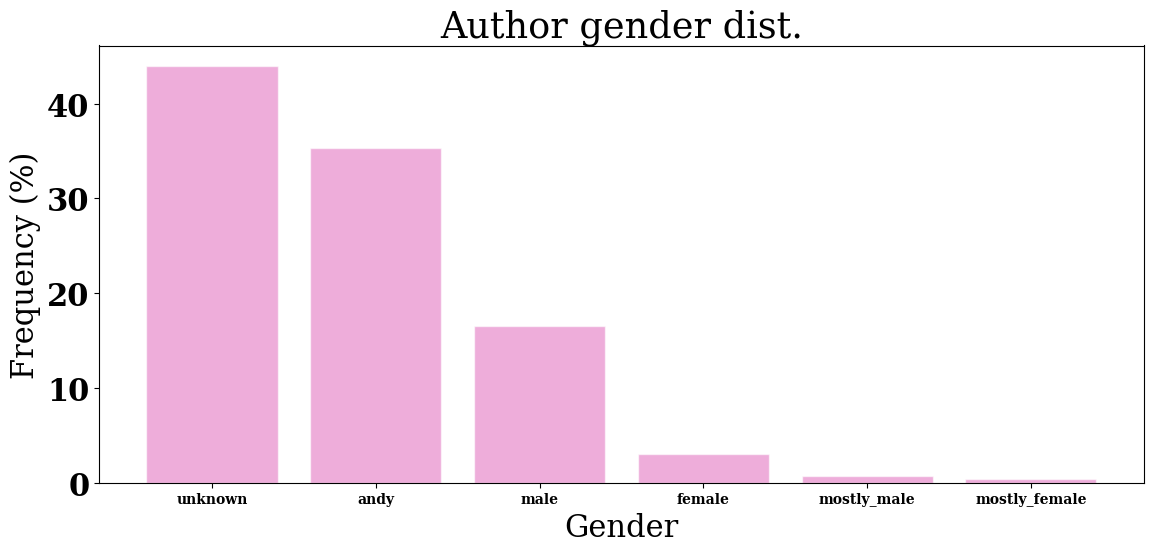

In [63]:
cat_plot(article_author_data.predicted_gender, title='Author gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, save_name='article_author_data')


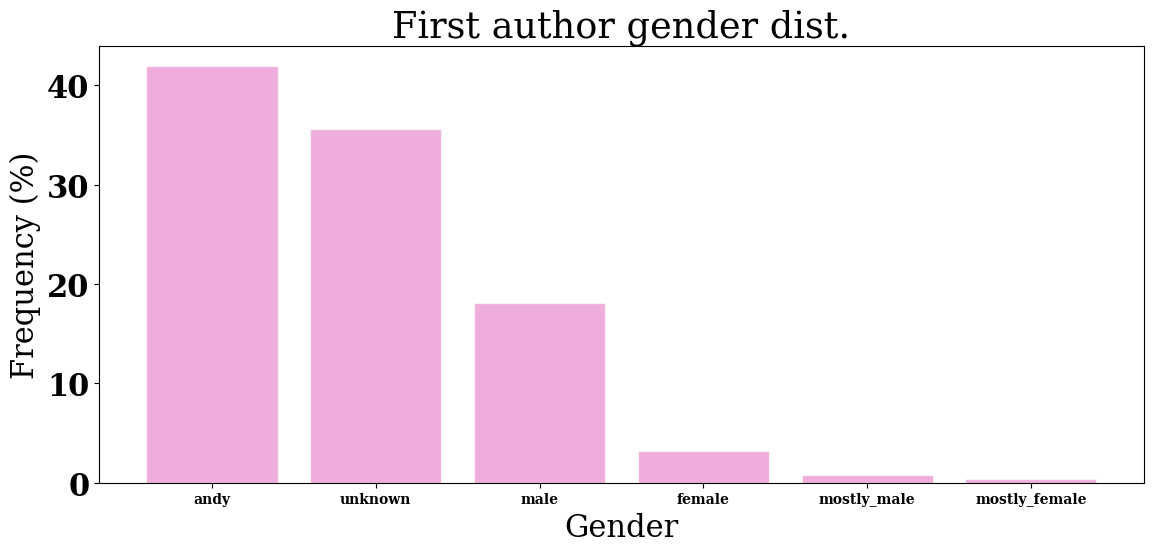

In [64]:
cat_plot(first_author_article_data.predicted_gender, title='First author gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, save_name='first_author_article_data')


In [65]:
## WORLD MAP PLOTTING 

In [1767]:
#create dataframe with country
df_country=article_author_data.author_countries.reset_index()
#select only one country per author
df_country['author_first_country'] = df_country['author_countries'].apply(lambda x: x[0] if len(x[0])==2 else x)
#calc percentage of country appearing
proportion=df_country.author_first_country.value_counts(normalize=True).mul(100).reset_index()
count=df_country.author_first_country.value_counts(normalize=False).reset_index()

df_country=pd.merge(df_country, proportion, on='author_first_country')
df_country=pd.merge(df_country, count, on='author_first_country')
df_country=df_country.drop(columns={'index', 'author_countries'})
df_country=df_country.drop_duplicates(subset=['author_first_country'], keep='last')


In [1773]:
# generate country code for map plotting 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(alpha_2=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df_country['map_code']=alpha3code(df_country.author_first_country)


In [1774]:
#import world dataset
world = gpd.read_file('ne_110m_admin_0_countries.shx')


In [1775]:
world = world[['ADMIN', 'ISO_A3', 'GU_A3', 'CONTINENT',  'geometry']] 
world.columns=['map_name', 'map_code', 'GU_A3', 'continent',  'geometry']


In [1776]:
world['map_code'][world['map_code']=='-99']=world['GU_A3']

In [1777]:
missing_country=df_country[~df_country['map_code'].isin(world['map_code'])]

In [1778]:
len(missing_country)

32

In [1779]:
#we are missing some countries on the map but will not prioritise getting them right now - maybe later 
missing_country=author_data[['author_countries','country_name']][author_data['author_countries'].isin([missing_country['author_first_country'].to_list()[i] for i in range(len(missing_country))])].value_counts().reset_index()

In [1780]:
world=world.drop(columns=['GU_A3'])

In [1781]:
# then merge with our data 
merge_map=pd.merge(world,df_country,on='map_code')

In [1782]:
#we are missing some 
len(merge_map)

163

In [1783]:
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
location=location.rename(columns={"name": "map_name"})


In [1784]:
# Data for the rows to add
new_country_data = {
    'map_name': ['France', 'Norway', 'North Macedonia', 'New Caledonia', 'Myanmar', 'Puerto Rico', 'Lesotho'],
    'latitude': [46.603354, 60.472024, 41.6086, -20.904305, 21.9162, 18.2208, -29.609988],
    'longitude': [1.888334, 8.468946, 21.7453, 165.618042, 95.9560, -66.5901, 28.233608]
}

# Create a new DataFrame with the rows to add
new_rows_df = pd.DataFrame(new_country_data)

# Use the concat function to add the new rows to the existing DataFrame
location = pd.concat([location, new_rows_df], ignore_index=True)

# Display the updated DataFrame
location

map_name   latitude   longitude
0        Afghanistan  33.939110   67.709953
1            Albania  41.153332   20.168331
2            Algeria  28.033886    1.659626
3             Angola -11.202692   17.873887
4          Argentina -38.416097  -63.616672
..               ...        ...         ...
160  North Macedonia  41.608600   21.745300
161    New Caledonia -20.904305  165.618042
162          Myanmar  21.916200   95.956000
163      Puerto Rico  18.220800  -66.590100
164          Lesotho -29.609988   28.233608

[165 rows x 3 columns]

In [1785]:
merge_map=merge_map.merge(location,on='map_name').sort_values(by='proportion',ascending=False).reset_index()

In [1786]:
mergeworld = pd.merge(merge_map, world, how="outer")


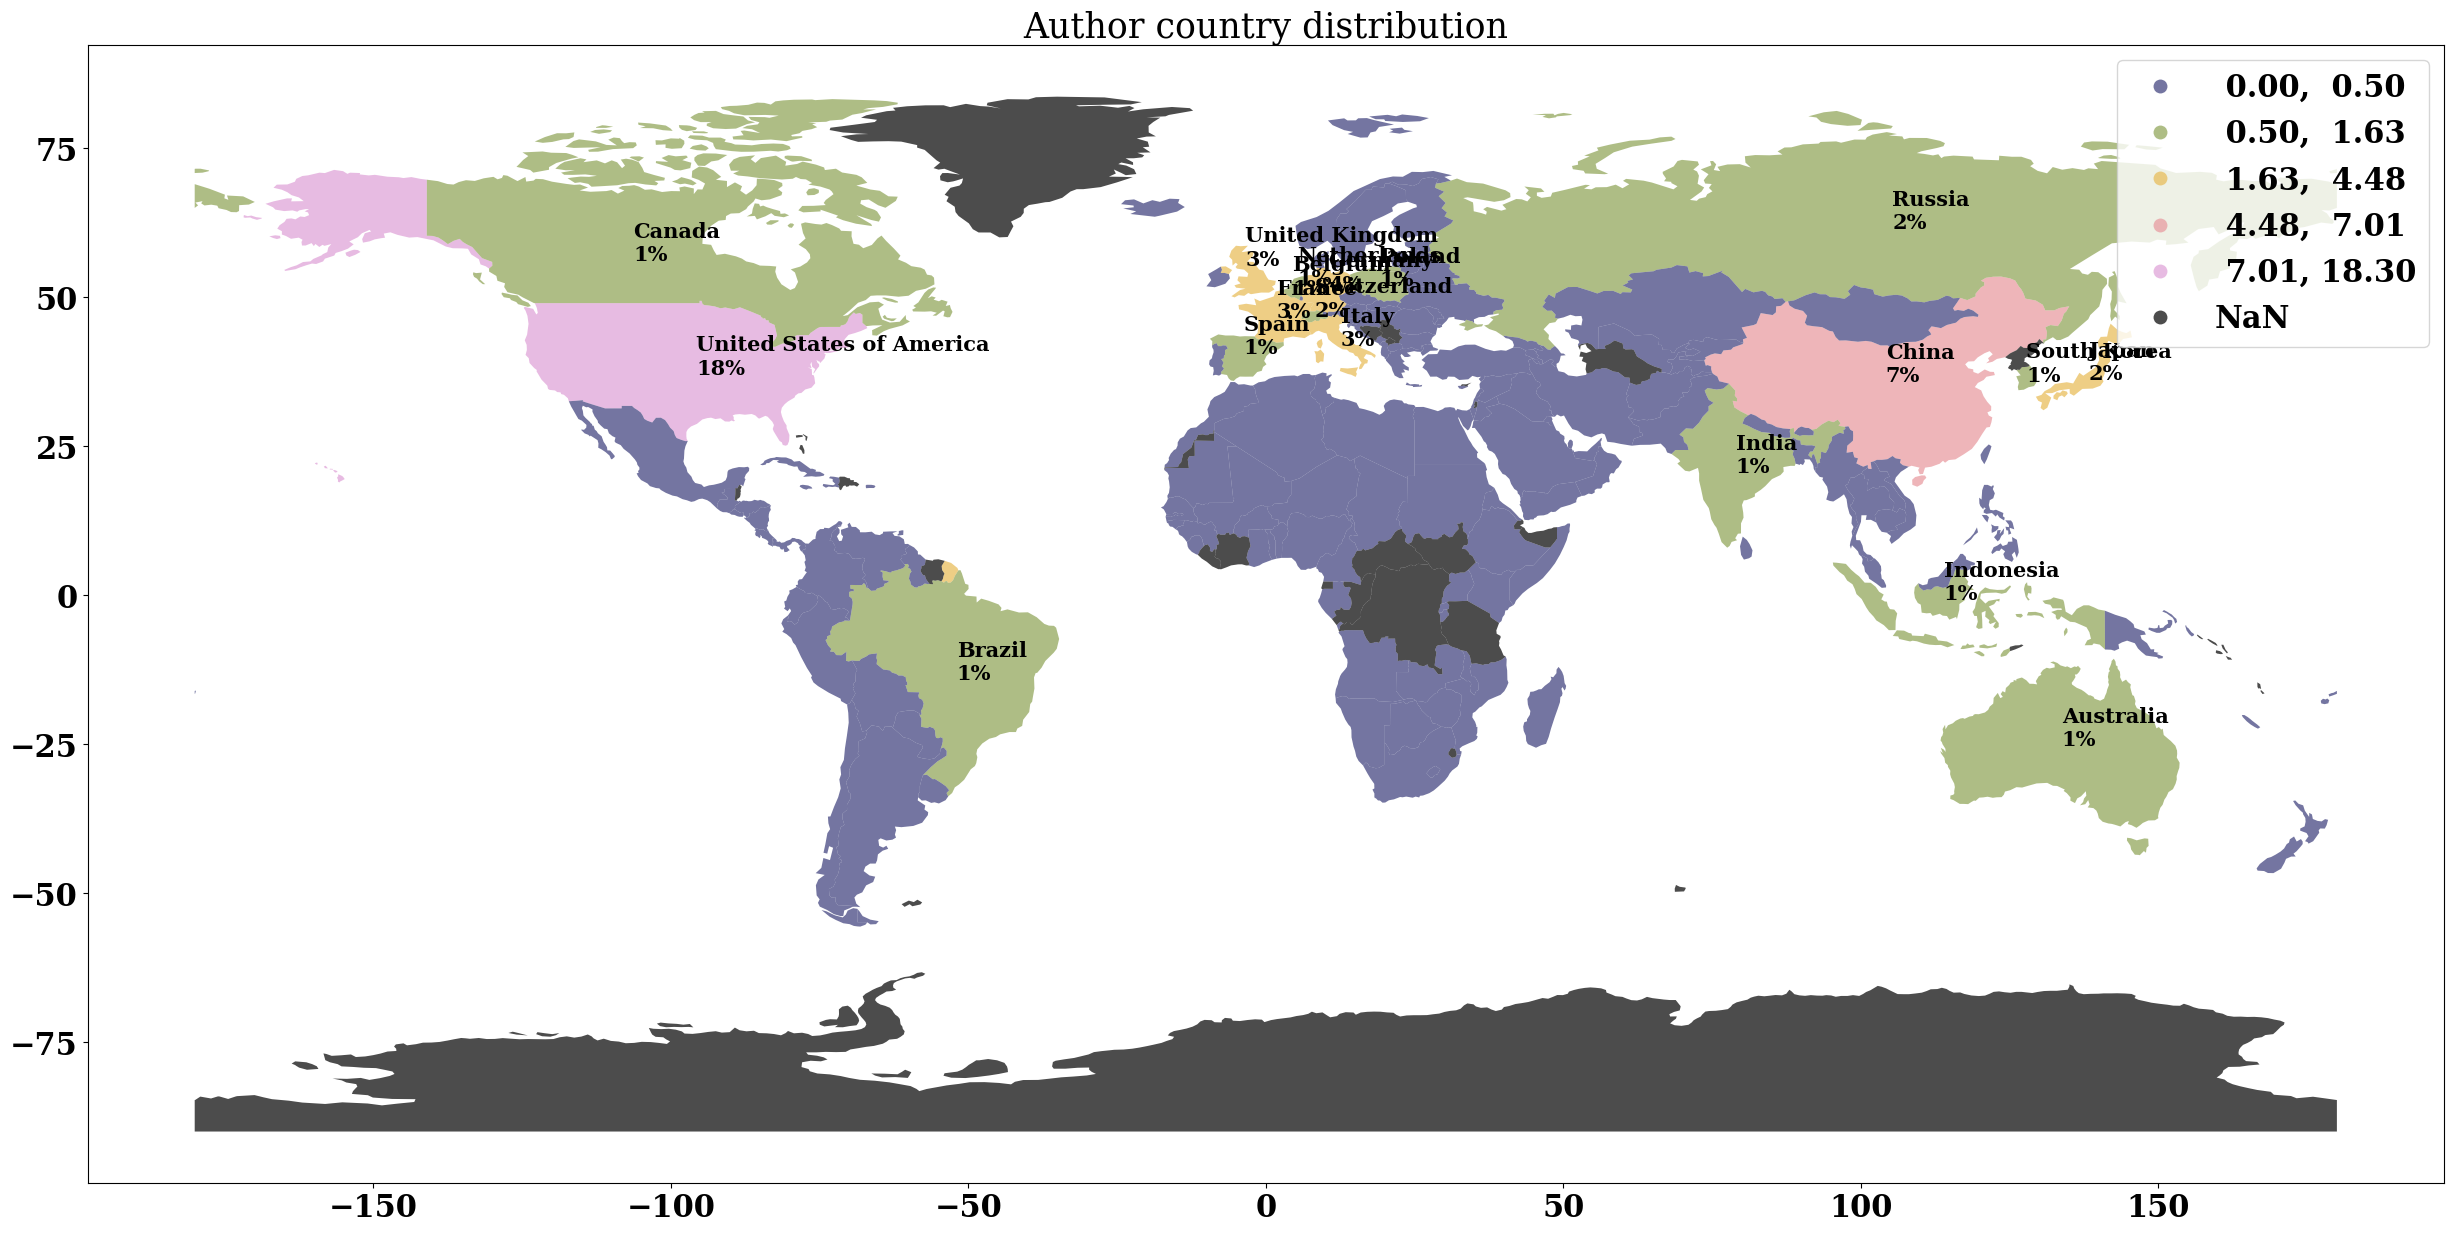

In [1788]:
fig_world=mergeworld.plot(column='proportion',
                scheme='natural_breaks',
                cmap='tab20b', 
                alpha=0.7,
                figsize=(25, 20),
                missing_kwds={'color': 'k', 'alpha':0.7}, 
                legend=True);

plt.title('Author country distribution',fontsize=25)
# add countries names and numbers for top 10 appearing countries 
for i in range(len(mergeworld[mergeworld['proportion']>0.5])):
    plt.text(float(mergeworld.longitude[i]),float(mergeworld.latitude[i]),"{}\n{}".format(mergeworld.map_name[i],f'{round(mergeworld.proportion[i])}%'),size=15)
plt.savefig('Plots/2023-12-09/allauthorcountrymap.png')
plt.show()


### Plot article data

In [83]:
article_data.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts'],
      dtype='object')

<Figure size 1200x600 with 0 Axes>

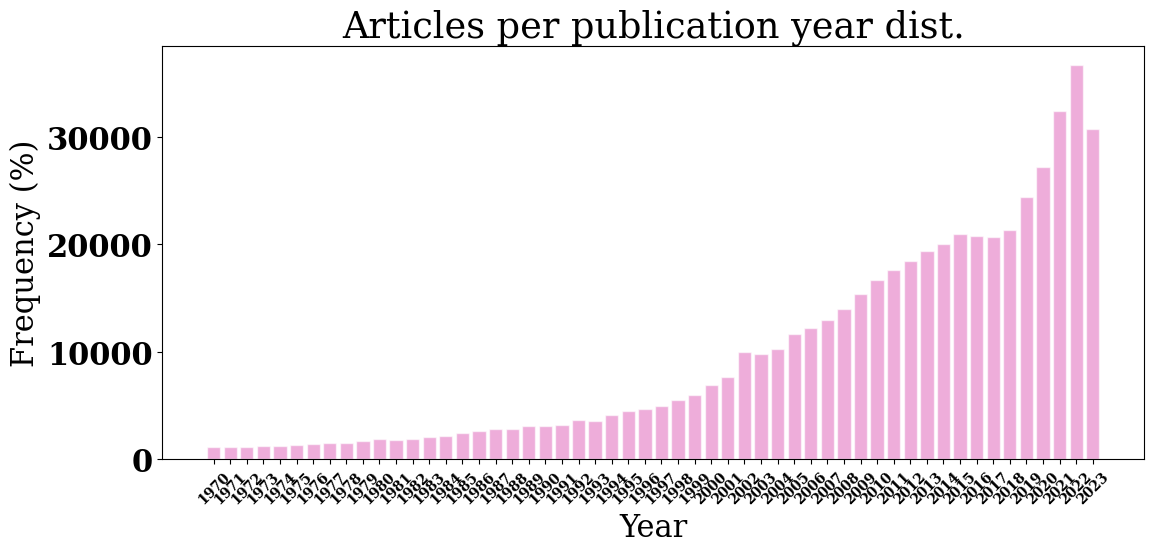

In [84]:
cat_plot(first_author_article_data.publication_year, title='Articles per publication year dist.', xlabel='Year', ylabel='Frequency (%)', norm=False, multiply=1, rot=45, save_name='first_author_article_data')


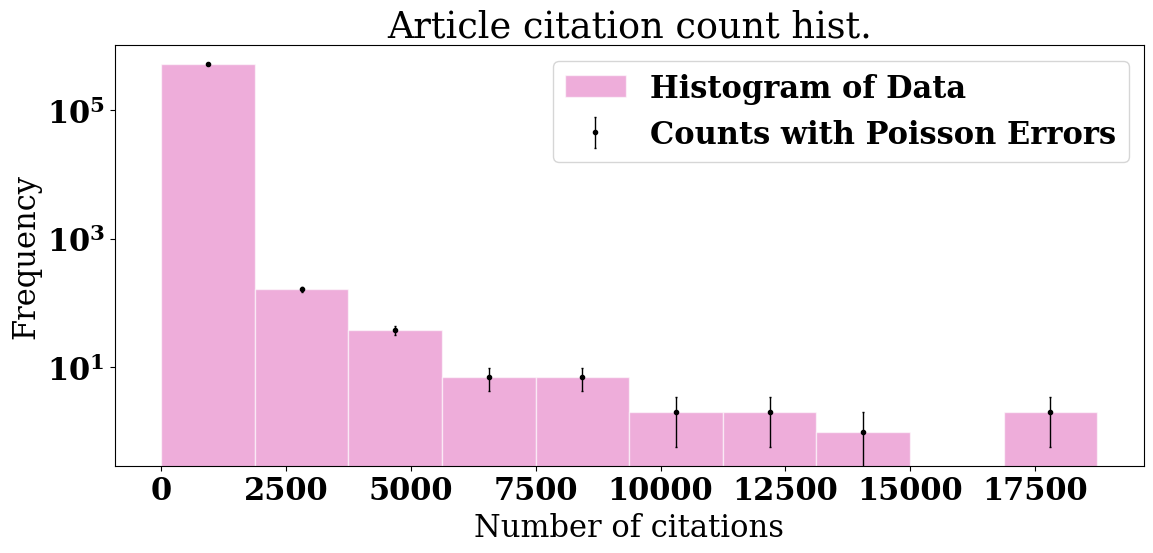

In [85]:
hist_plot(first_author_article_data.cited_by_count, log=True, title='Article citation count hist.', xlabel='Number of citations', ylabel='Frequency log', save_name='first_author_article_data')


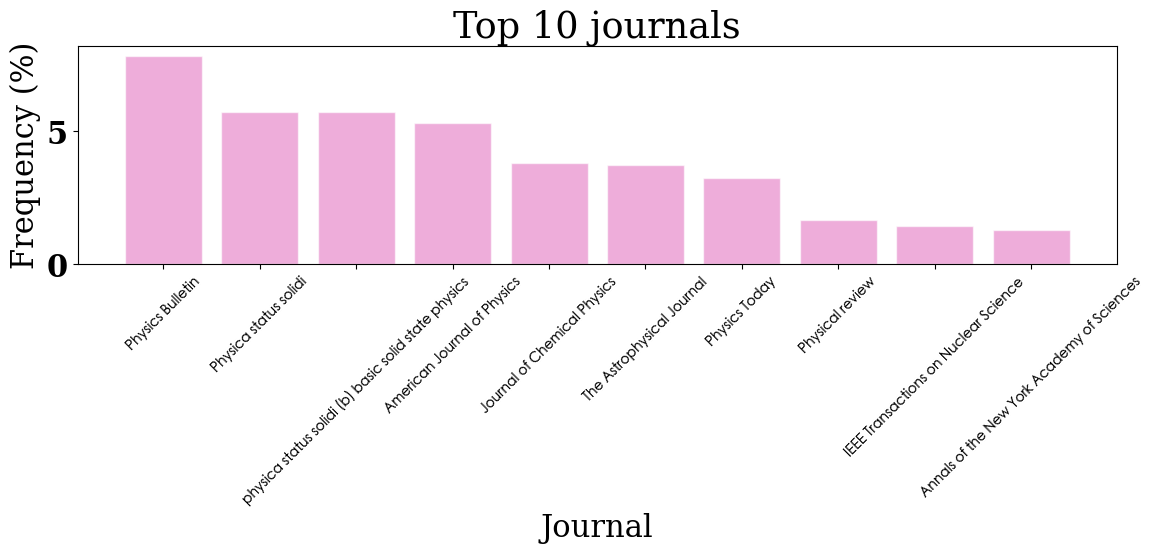

In [86]:
cat10_plot(first_author_article_data.journal_name, title='Top 10 journals', xlabel='Journal', ylabel='Frequency (%)', norm=True, multiply=100, font='Heiti TC', rot=45, save_name='first_author_article_data')


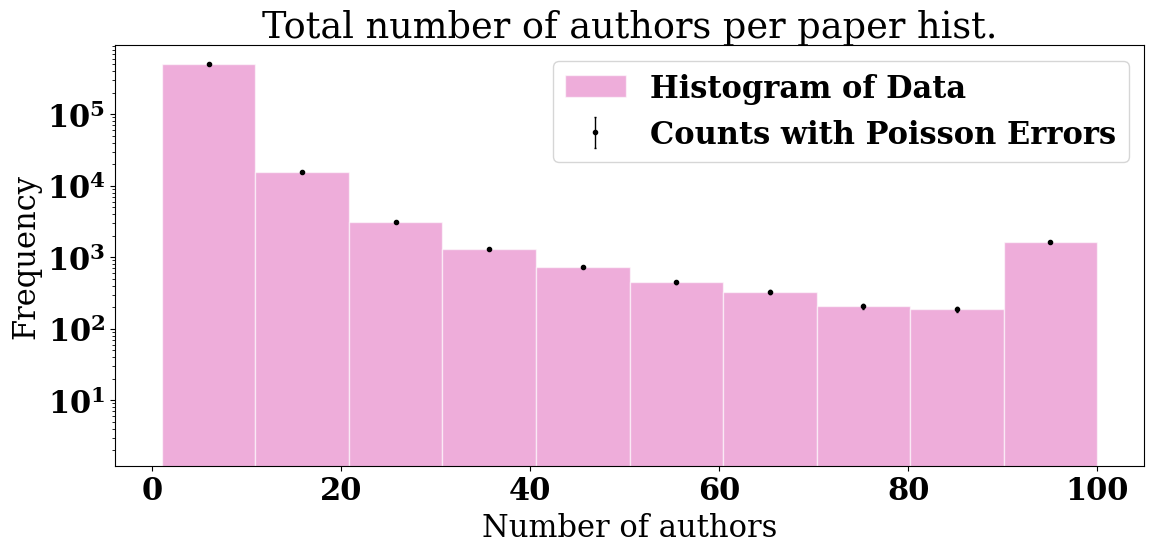

In [87]:
hist_plot(first_author_article_data.total_author_counts, log=True, title='Total number of authors per paper hist.', xlabel='Number of authors', ylabel='Frequency log', save_name='first_author_article_data')

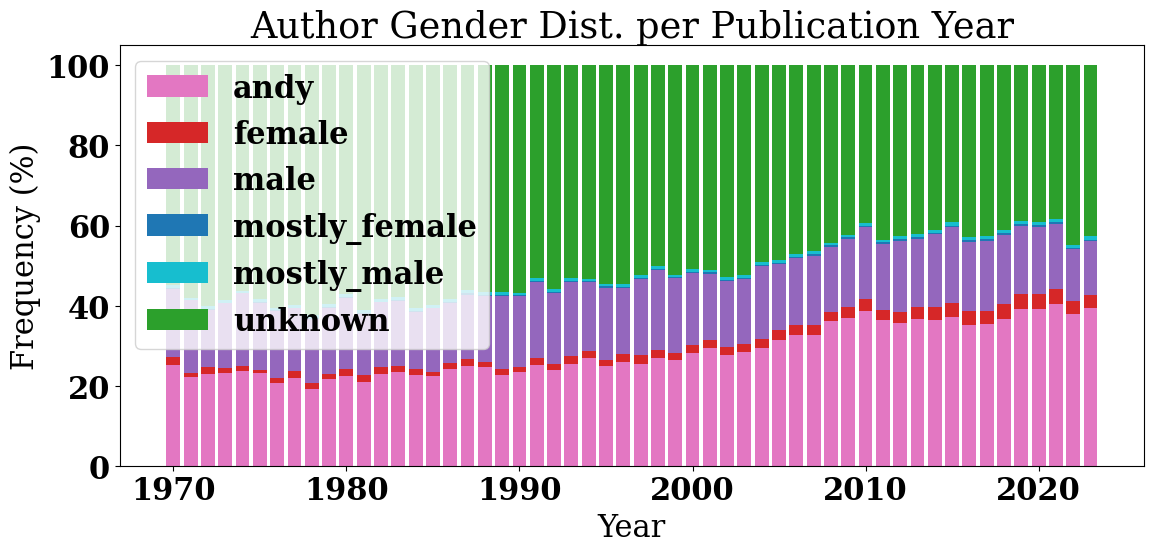

In [91]:
#calculate gender dist per year 
gender_year_counts = article_author_data.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(gender_year_counts, 'publication_year', gender_year_counts.columns.difference(['publication_year']), title='Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)', save_name='allauthors')


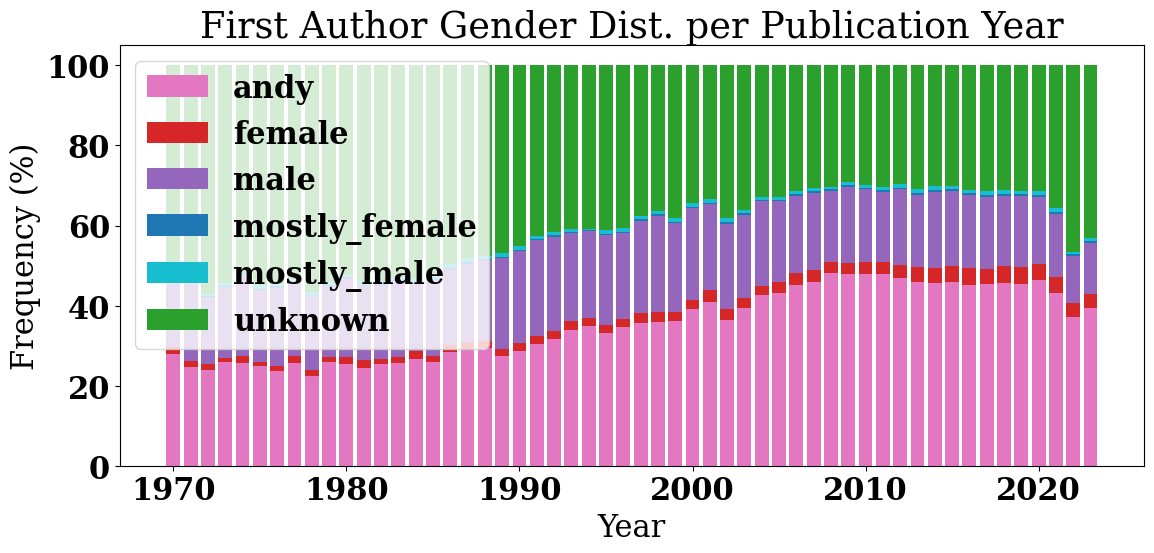

In [92]:
#calculate gender dist per year 
first_author_gender_year_counts = first_author_article_data.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(first_author_gender_year_counts, 'publication_year', gender_year_counts.columns.difference(['publication_year']), title='First Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)', save_name='firstauthors')


## Clean gender assignment 

In [22]:
article_author_data['author_first_country'] = article_author_data['author_countries'].apply(lambda x: x[0] if len(x[0])==2 else x)


In [28]:
andy_gender=article_author_data[article_author_data['predicted_gender']=='andy']
unknown_gender=article_author_data[article_author_data['predicted_gender']=='unknown']

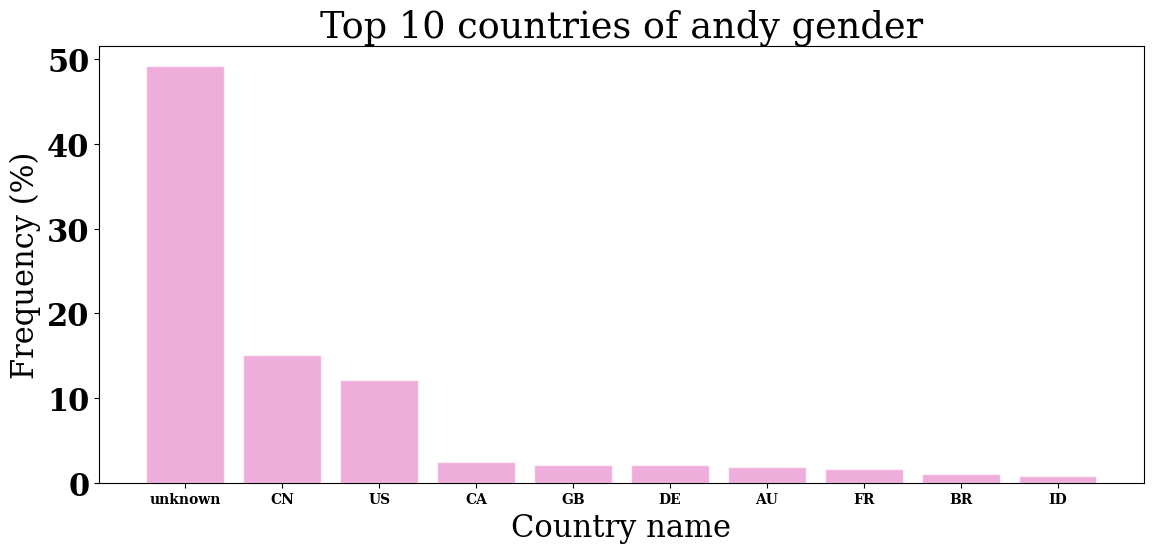

In [95]:
cat10_plot(andy_gender.author_first_country, title='Top 10 countries of andy gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='andy_gender')


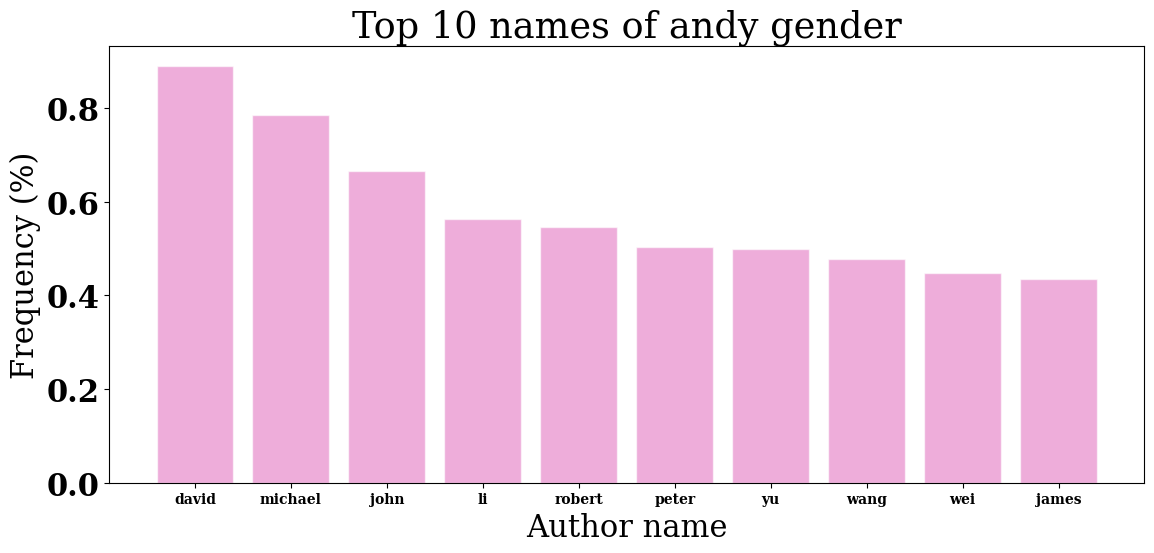

In [96]:
cat10_plot(andy_gender.extracted_first_name, title='Top 10 names of andy gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='andy_gender')



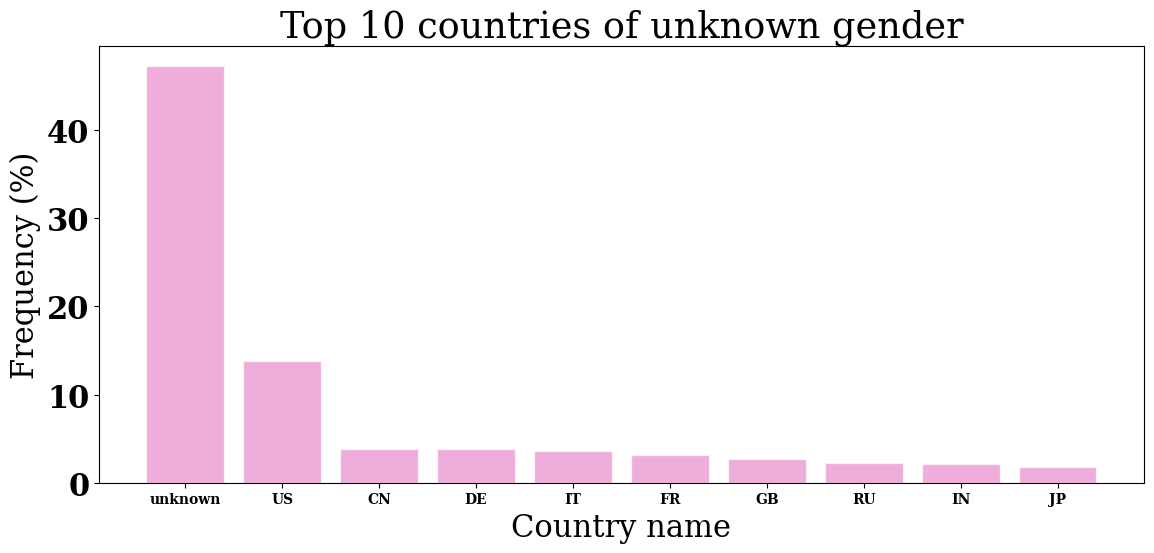

In [97]:
cat10_plot(unknown_gender.author_first_country, title='Top 10 countries of unknown gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='unknown_gender')


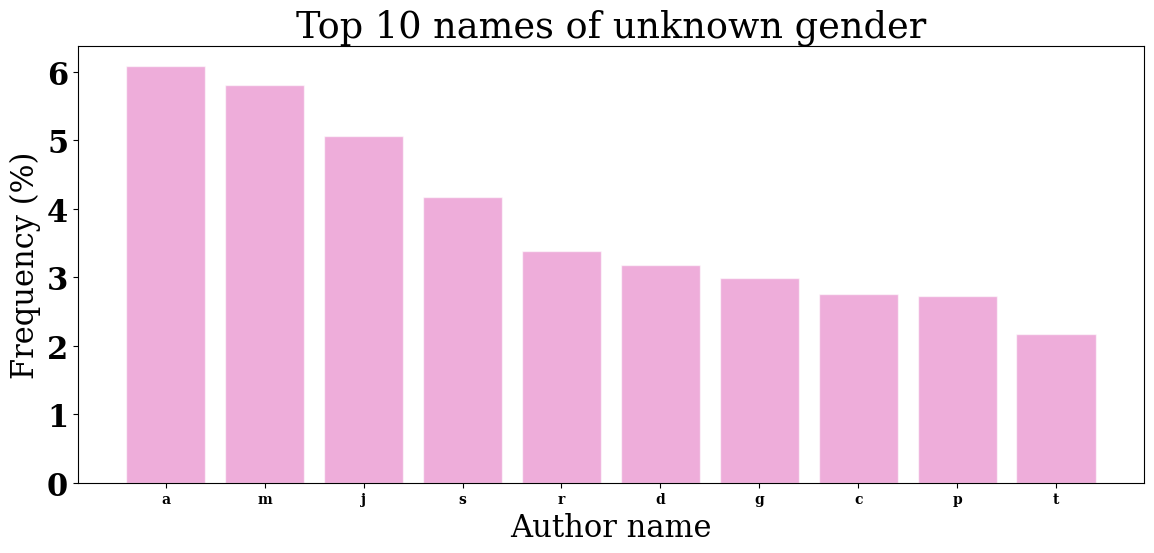

In [98]:
cat10_plot(unknown_gender.extracted_first_name, title='Top 10 names of unknown gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='unknown_gender')


In [29]:
#select data with an actual predicted gender 
author_data_gender=article_author_data[article_author_data['predicted_gender'].isin(['male', 'female', 'mostly_male', 'mostly_female'])]

In [30]:
len(author_data_gender)

414008

In [31]:
author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_male']='male'
author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_female']='female'

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_24338/1767907793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_male']='male'
/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_24338/1767907793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_female']='female'


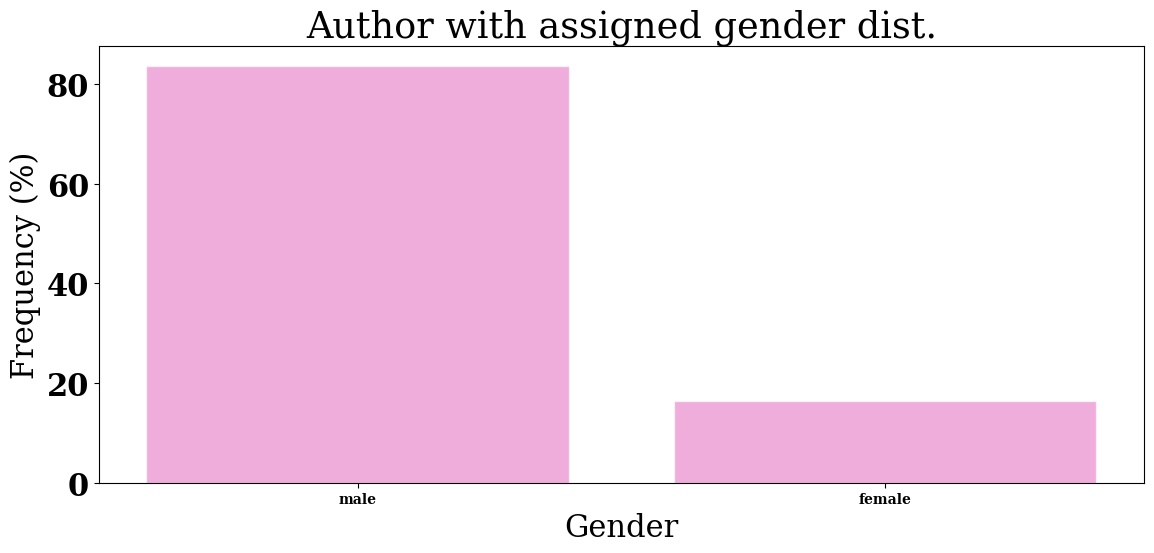

In [102]:
cat_plot(author_data_gender.predicted_gender, title='Author with assigned gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, save_name='author_data_gender')


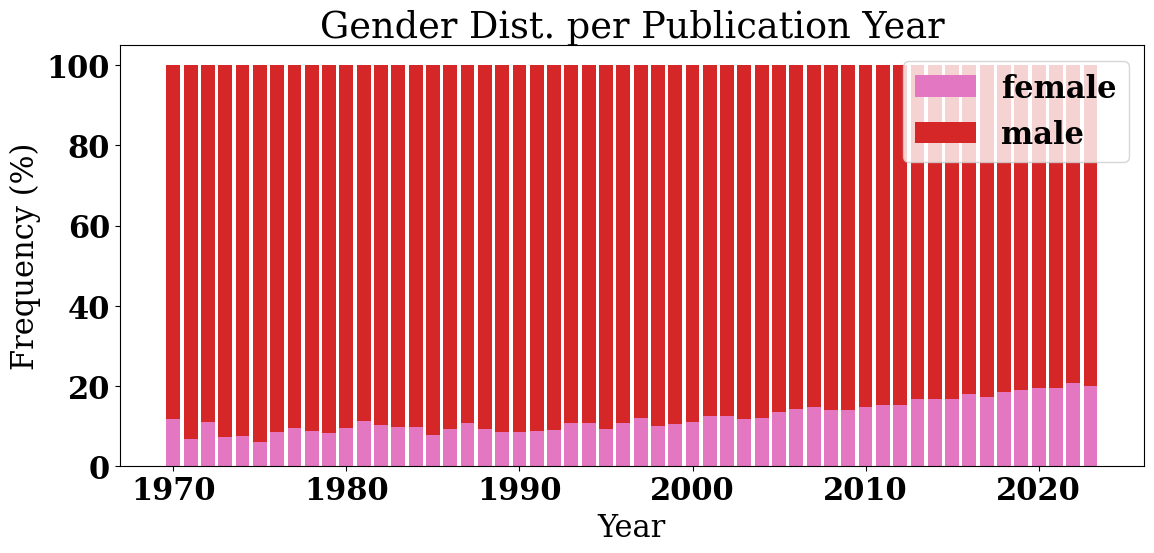

In [105]:
#calculate gender dist per year 
binary_gender_year_counts = author_data_gender.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(binary_gender_year_counts, 'publication_year', binary_gender_year_counts.columns.difference(['publication_year']), title='Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)', save_name='allauthor_data_gender')


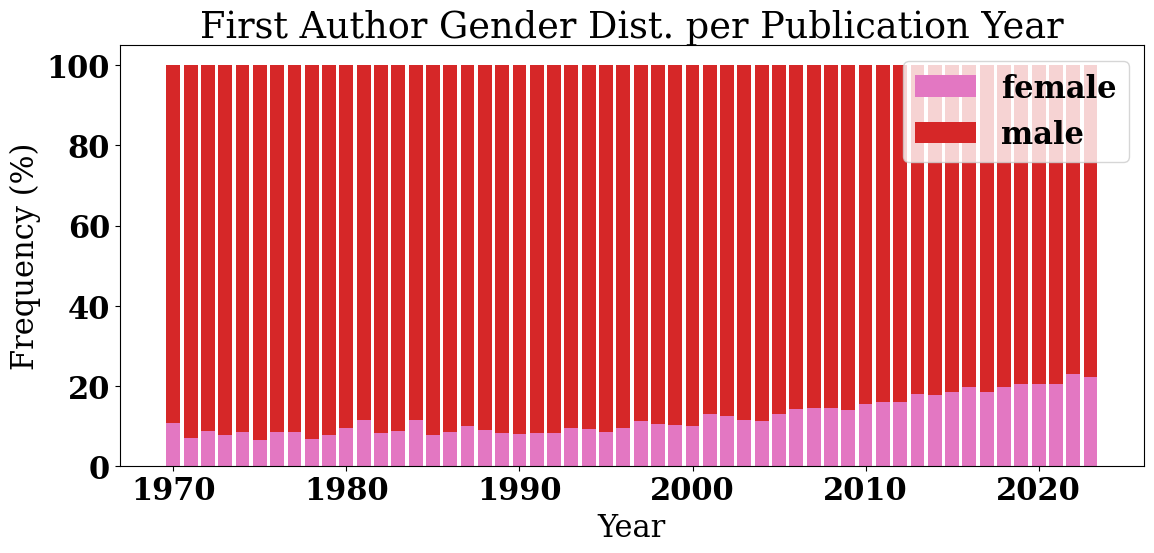

In [106]:
#get first authors with an assigned gender
first_author_data_gender=author_data_gender[author_data_gender['author_position']=='first']

#calculate gender dist per year 
first_author_binary_gender_year_counts = first_author_data_gender.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(first_author_binary_gender_year_counts, 'publication_year', first_author_binary_gender_year_counts.columns.difference(['publication_year']), title='First Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)', save_name='firstauthor_data_gender')


In [109]:
gender_article_counts = author_data_gender.groupby(['article_id', 'predicted_gender']).size().unstack(fill_value=0).reset_index()


In [110]:
gender_article_counts['total']=gender_article_counts['female']+gender_article_counts['male']
gender_article_counts['female_prct']=gender_article_counts['female']/gender_article_counts['total']*100
gender_article_counts['male_prct']=gender_article_counts['male']/gender_article_counts['total']*100



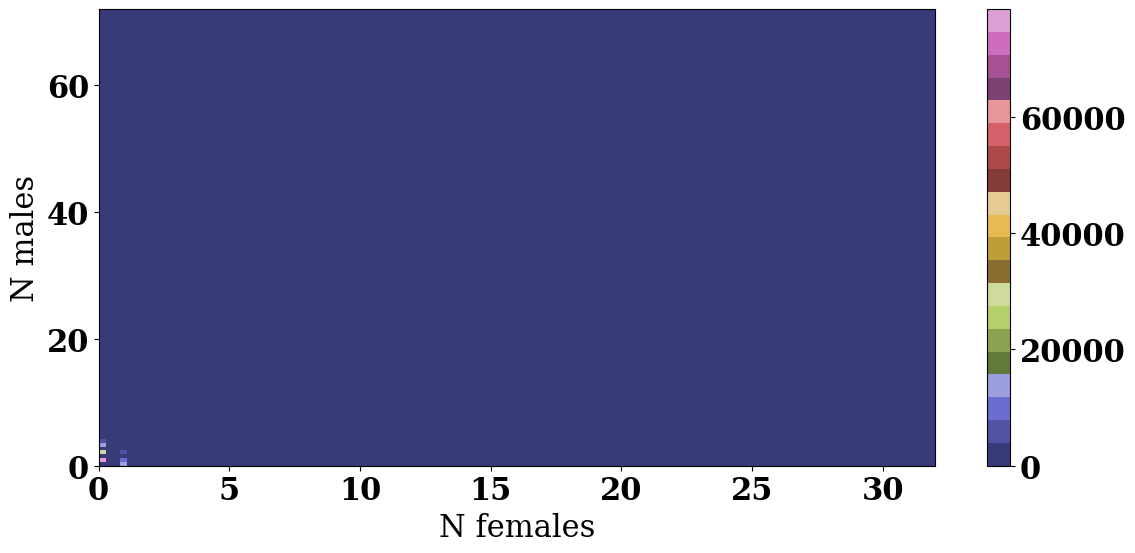

In [120]:
plt.hist2d(gender_article_counts['female'], gender_article_counts['male'], bins=120, cmap='tab20b')
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.colorbar()
plt.xlabel('N females')
plt.ylabel('N males')
plt.savefig(f'Plots/{date.today()}/gender2dhist_N.png')
plt.show()


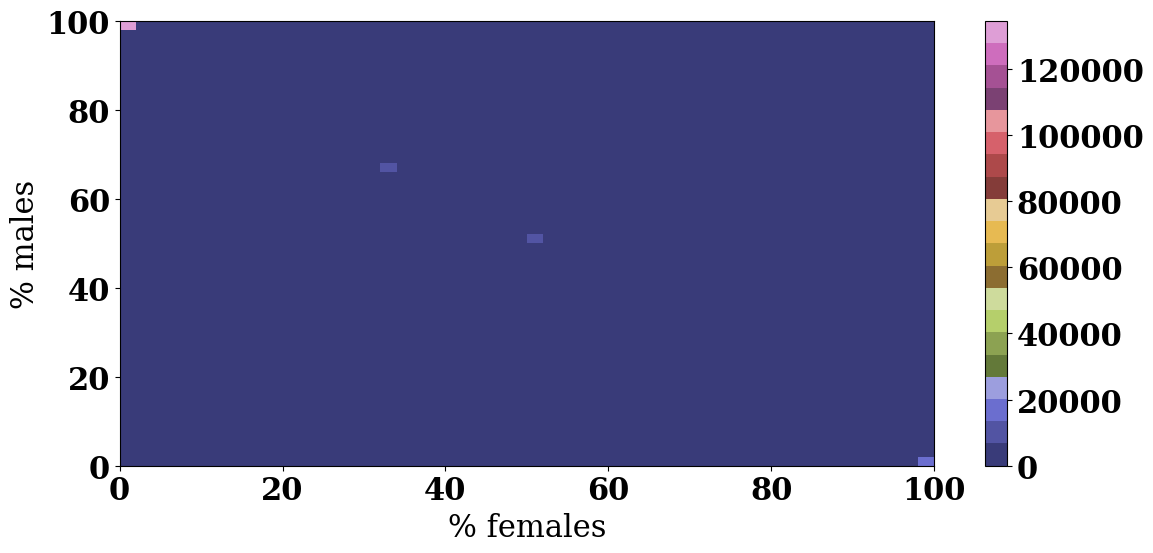

In [119]:
plt.hist2d(gender_article_counts['female_prct'], gender_article_counts['male_prct'], bins=50, cmap='tab20b')
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.colorbar()
plt.xlabel('% females')
plt.ylabel('% males')
plt.savefig(f'Plots/{date.today()}/gender2dhist_prct.png')
plt.show()



## Update unknown/andy country and gender

In [353]:
#check if the IDs assigned with unknown/andy appears multiple places in the data where we can get their data from 

In [354]:
duplicate_andy = andy_gender[andy_gender['author.id'].duplicated()]['author.id']

In [356]:
duplicate_andy=article_author_data[article_author_data['author_id'].isin(duplicate_andy.to_list())]
duplicate_andy = duplicate_andy.sort_values(by='author_id')


In [357]:
duplicate_andy['author_id'].value_counts()

author_id
https://openalex.org/A5041573207    332
https://openalex.org/A5052011846    207
https://openalex.org/A5045096283    184
https://openalex.org/A5009221549    182
https://openalex.org/A5086528441    179
                                   ... 
https://openalex.org/A5046536478      2
https://openalex.org/A5046536604      2
https://openalex.org/A5046536974      2
https://openalex.org/A5046539472      2
https://openalex.org/A5092826066      2
Name: count, Length: 115113, dtype: int64

## Update final

In [70]:
article_author_data.head(2)

article_id  \
0  https://openalex.org/W2149166552   
1  https://openalex.org/W2048737175   

                                         doi  publication_year  \
0  https://doi.org/10.1080/14786437008238472              1970   
1  https://doi.org/10.1080/00018737000101171              1970   

  publication_date                                              title  \
0       1970-04-01  Electrical resistance of disordered one-dimens...   
1       1970-07-01  Oscillatory approach to a singular point in th...   

   cited_by_count grants                                           abstract  \
0            2761     []  (1970). Electrical resistance of disordered on...   
1            1092     []  (1970). Oscillatory approach to a singular poi...   

                         journal_id                journal_name  ...  \
0  https://openalex.org/S4210240599  The philosophical magazine  ...   
1   https://openalex.org/S137691401         Advances in Physics  ...   

                                  institution_name  \
0  IBM Research - Thomas J. Watson Research Center   
1         Landau Institute for Theoretical Physics   

                     institution_id institution_type  selected_full_name  \
0  https://openalex.org/I4210114115         facility       rolf landauer   
1   https://openalex.org/I196576671         facility     v. a. belinskiǐ   

  extracted_first_name        country_name author_country_name  \
0                 rolf       united states       united states   
1                    v  russian federation  russian federation   

  author_country_name_api predicted_gender author_first_country  
0                     usa             andy                   US  
1                  russia          unknown                   RU  

[2 rows x 29 columns]

In [23]:
article_author_data = article_author_data.rename(columns={'author.id': 'author_id'})


In [24]:
from tqdm import tqdm

def update_author_info(dataframe, columns_to_update):
    dataframe_updated = dataframe.copy()

    # Get unique author_ids for progress monitoring
    author_ids = dataframe['author_id'].unique()

    # Iterate over each author_id with progress bar
    for author_id in tqdm(author_ids, desc="Processing author_ids", unit="author_id"):
        # Extract the group for the current author_id
        group = dataframe[dataframe['author_id'] == author_id]

        # Check if the group has any valid values
        if not group.empty:
            # Calculate most common values within the current group
            most_common_values = {col: group[col].value_counts().idxmax() for col in columns_to_update if not group[col].isin(['unknown', 'andy']).all()}

            # Update values only within the current group
            for col in columns_to_update:
                most_common_val = most_common_values.get(col, None)

                if most_common_val is not None:
                    # If the most common value is 'unknown' or 'andy', replace it with the second most common value
                    if most_common_val in ['unknown', 'andy', 'other_countries']:
                        second_most_common_val = group[col].value_counts().index[1] if len(group[col].unique()) > 1 else None
                        if second_most_common_val is not None:
                            # Update the value in the original dataframe
                            mask = (dataframe_updated['author_id'] == author_id) & (dataframe_updated[col].isin(['unknown', 'andy']))
                            dataframe_updated.loc[mask, col] = second_most_common_val

    return dataframe_updated


# Example usage
columns_to_update = ['extracted_first_name', 'author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']


In [73]:
test_sample=article_author_data[0:50000]

In [74]:
%%time
test_update = update_author_info(test_sample, columns_to_update)

Processing author_ids: 100%|██████| 36792/36792 [01:30<00:00, 406.65author_id/s]

CPU times: user 1min 29s, sys: 1.6 s, total: 1min 31s
Wall time: 1min 30s


In [76]:
print("gender before update:", test_sample.predicted_gender.value_counts())
print("gender after update:", test_update.predicted_gender.value_counts())
print("Diff:", test_update.predicted_gender.value_counts()-test_sample.predicted_gender.value_counts())

gender before update: predicted_gender
unknown          29565
andy             11095
male              8150
female             734
mostly_male        343
mostly_female      113
Name: count, dtype: int64
gender after update: predicted_gender
unknown          29006
andy             10251
male              9349
female             889
mostly_male        380
mostly_female      125
Name: count, dtype: int64
Diff: predicted_gender
unknown          -559
andy             -844
male             1199
female            155
mostly_male        37
mostly_female      12
Name: count, dtype: int64


In [77]:
##this will take around 22 hours - so let's run it tonight 

In [78]:
%%time
article_author_data_updated = update_author_info(article_author_data, columns_to_update)

Processing author_ids: 100%|██| 810843/810843 [23:23:42<00:00,  9.63author_id/s]

CPU times: user 23h 10min 53s, sys: 7min 12s, total: 23h 18min 5s
Wall time: 23h 23min 44s


In [26]:
#get the version that we already got 
with open('OpenAlex Data/Unify2024/02032024FirstUpdatedArticleAuthorData19702023.pkl', 'rb') as f:
    article_author_data_updated = pickle.load(f)

In [27]:
print("Diff before and after update:", article_author_data_updated.predicted_gender.value_counts()-article_author_data.predicted_gender.value_counts())

Diff before and after update: predicted_gender
unknown         -151168
andy             -39498
male             158860
female            22270
mostly_male        6480
mostly_female      3056
Name: count, dtype: int64


In [81]:
print("Diff before and after update:", article_author_data_updated.predicted_gender.value_counts()-article_author_data.predicted_gender.value_counts())

Diff before and after update: predicted_gender
unknown         -151168
andy             -39498
male             158860
female            22270
mostly_male        6480
mostly_female      3056
Name: count, dtype: int64


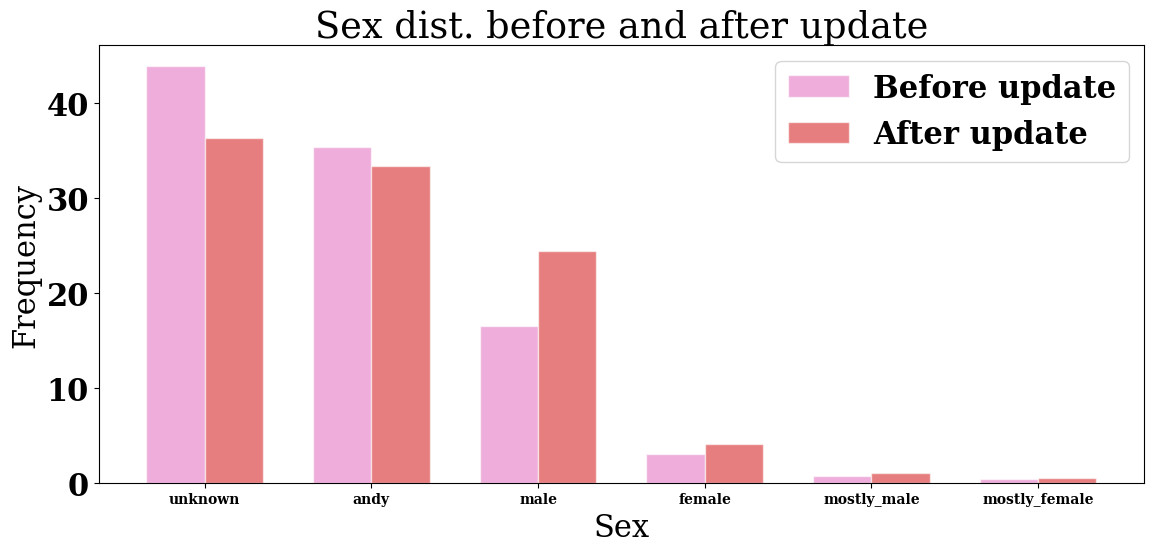

In [121]:
cat_plot_compare(article_author_data.predicted_gender, article_author_data_updated.predicted_gender, title='Sex dist. before and after update', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='genderdiffupdate', label1='Before update', label2='After update')



In [122]:
update_unknown_gender=article_author_data_updated[article_author_data_updated['predicted_gender']=='unknown']
update_andy_gender=article_author_data_updated[article_author_data_updated['predicted_gender']=='andy']

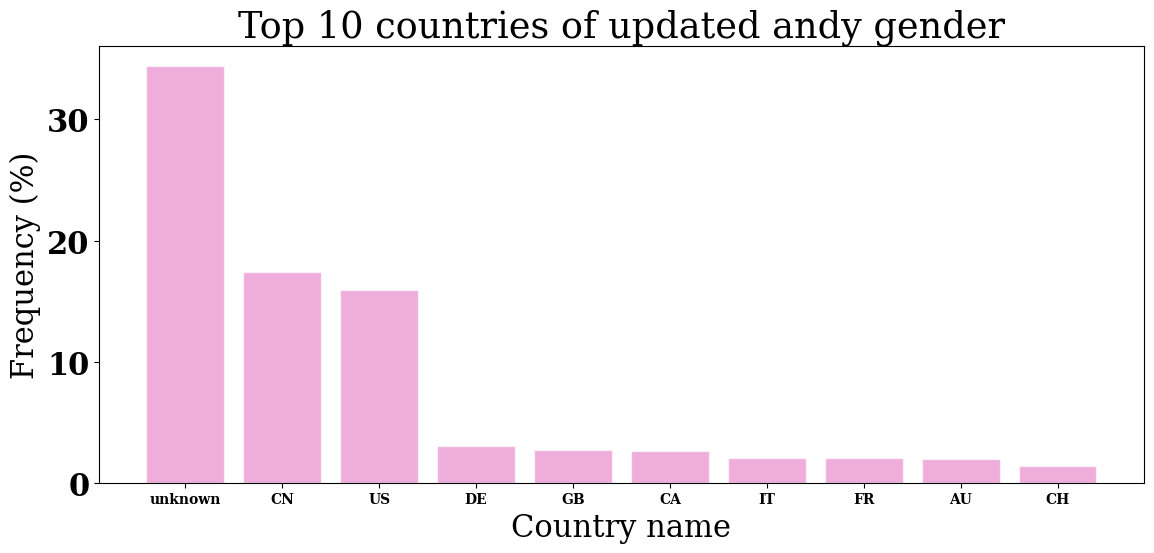

In [123]:
cat10_plot(update_andy_gender.author_first_country, title='Top 10 countries of updated andy gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='andy_gender_update')


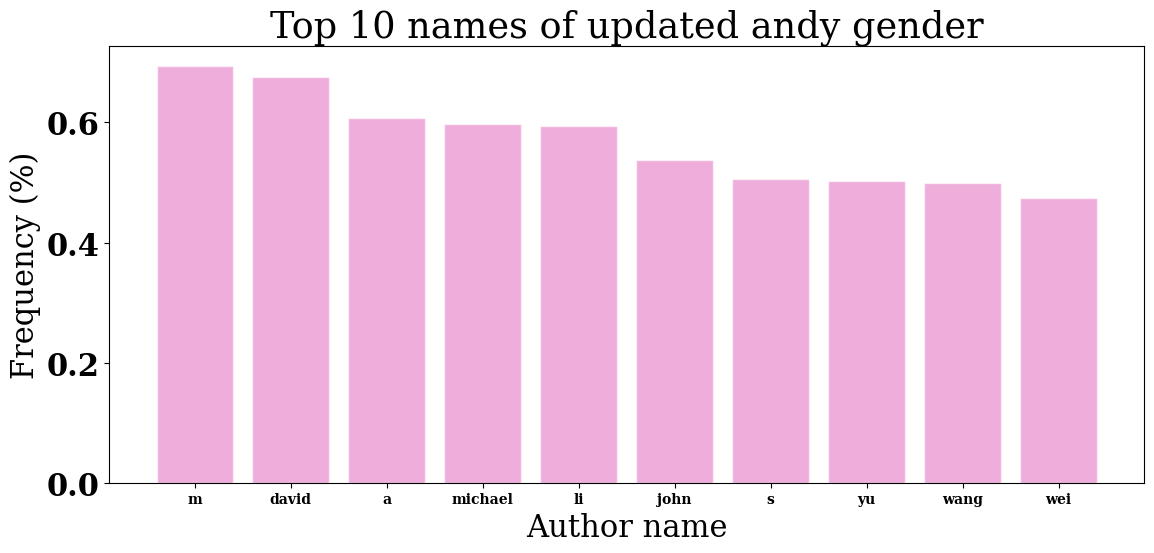

In [124]:
cat10_plot(update_andy_gender.extracted_first_name, title='Top 10 names of updated andy gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='andy_gender_update')



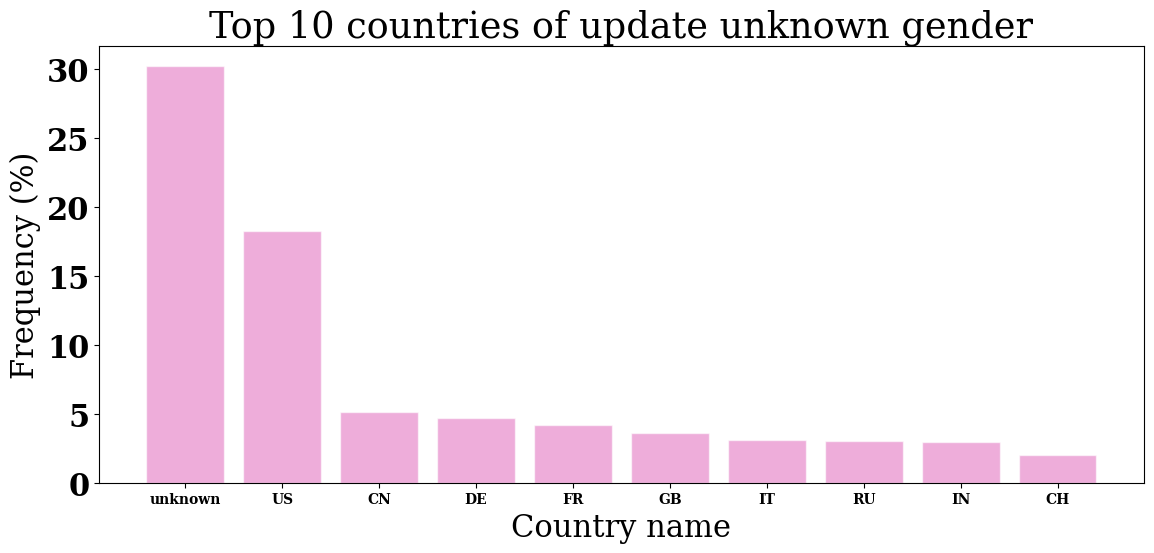

In [126]:
cat10_plot(update_unknown_gender.author_first_country, title='Top 10 countries of update unknown gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='unknown_gender_update')


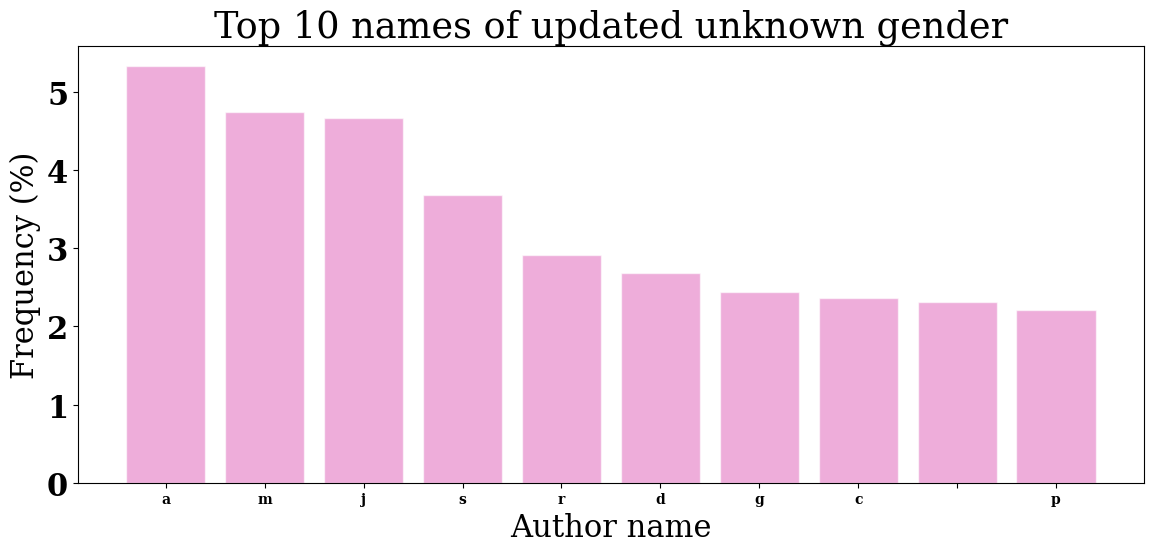

In [125]:
cat10_plot(update_unknown_gender.extracted_first_name, title='Top 10 names of updated unknown gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='unknown_gender_update')


## Andy gender

In [128]:
#let's look into the names that we should be able to assign a gender 
update_andy_gender.extracted_first_name.value_counts()

extracted_first_name
m            4632
david        4517
a            4053
michael      3992
li           3971
             ... 
montini         1
sandugash       1
cullen          1
creighton       1
caibin          1
Name: count, Length: 22899, dtype: int64

In [154]:
update_andy_gender.extracted_first_name.nunique()

22899

In [137]:
andy_david.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country'],
      dtype='object')

In [170]:
andy_david=update_andy_gender[update_andy_gender['extracted_first_name']=='david']
andy_david.author_country_name.value_counts()

author_country_name
other_countries                          3509
canada                                    335
australia                                 332
new zealand                                45
china                                      32
south africa                               28
mexico                                     25
colombia                                   20
brazil                                     20
russian federation                         18
singapore                                  15
japan                                      13
virgin islands, british                    12
poland                                     12
chile                                      11
indonesia                                   8
finland                                     6
ecuador                                     6
nigeria                                     5
india                                       5
korea, republic of                          5
hungary       

#we could google the names and assign most likely sex according to the google - and name? 

https://www.google.com/search?q=what+sex+is+the+name+david&oq=what+sex+is+the+name+david+&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRigATIHCAIQIRigATIHCAMQIRigATIKCAQQIRgWGB0YHjIKCAUQIRgWGB0YHjIKCAYQIRgWGB0YHjIKCAcQIRgWGB0YHjIKCAgQIRgWGB0YHjIKCAkQIRgWGB0YHtIBCDQwNTRqMGo3qAIAsAIA&sourceid=chrome&ie=UTF-8



In [139]:
andy_david[andy_david['author_first_country']=='CA']

article_id  \
3219     https://openalex.org/W2071457907   
3852     https://openalex.org/W1993394020   
4430     https://openalex.org/W2006757134   
5419     https://openalex.org/W2055590743   
9014     https://openalex.org/W2004633778   
...                                   ...   
1937247  https://openalex.org/W4376869964   
1947759  https://openalex.org/W4382679707   
1948359  https://openalex.org/W4362576074   
1966727  https://openalex.org/W4385712785   
1966923  https://openalex.org/W4385783302   

                                                    doi  publication_year  \
3219                  https://doi.org/10.1063/1.1675245              1971   
3852                  https://doi.org/10.1063/1.1676172              1971   
4430          https://doi.org/10.1017/s1446788700011125              1972   
5419                   https://doi.org/10.1122/1.549252              1972   
9014          https://doi.org/10.1080/00268977400100271              1974   
...                                                 ...               ...   
1937247                  https://doi.org/10.1086/724799              2023   
1947759   https://doi.org/10.1080/07370024.2023.2218355              2023   
1948359  https://doi.org/10.1016/j.ijhydene.2023.03.153              2023   
1966727     https://doi.org/10.1108/compel-12-2022-0436              2023   
1966923      https://doi.org/10.1038/s41598-023-40403-2              2023   

        publication_date                                              title  \
3219          1971-03-15          Cubic and Quartic Force Constants for H2+   
3852          1971-07-15  Carbon Tetrachloride as an Electron Scavenger ...   
4430          1972-12-01  The Euler-Lagrange expression and degenerate l...   
5419          1972-03-01  Constitutive Equations for Dilute Polymer Solu...   
9014          1974-01-01  Corrigenda and addenda to vibrational spacings...   
...                  ...                                                ...   
1937247       2023-06-01  Sounding Acoustic Precision: Tuning Forks and ...   
1947759       2023-06-30  Human teleoperation - a haptically enabled mix...   
1948359       2023-07-01  Hybrid emission and combustion modeling of hyd...   
1966727       2023-08-11     Evaluating magnetic fields using deep learning   
1966923       2023-08-12  Physics-informed deep learning to forecast $${...   

         cited_by_count                                             grants  \
3219                  2                                                 []   
3852                  0                                                 []   
4430                 17                                                 []   
5419                  1                                                 []   
9014                 15                                                 []   
...                 ...                                                ...   
1937247               0                                                 []   
1947759               0  [{'award_id': 'RGPIN-2016-04618', 'funder': 'h...   
1948359               0                                                 []   
1966727               0                                                 []   
1966923               0  [{'award_id': 'ALLRP 548576-2019', 'funder': '...   

                                                  abstract  \
3219     Views Icon Views Article contents Figures & ta...   
3852     Views Icon Views Article contents Figures & ta...   
4430     It is well known that many of the field equati...   
5419     The theories of continuum mechanics and molecu...   
9014     "Corrigenda and addenda to vibrational spacing...   
...                                                    ...   
1937247  A great variety of tuning forks survive in col...   
1947759  ABSTRACTABSTRACTCurrent teleultrasound methods...   
1948359  Zero carbon fuels can be used to reduce CO2 em...   
1966727  Purpose The purpose of this paper is to develo... 

In [159]:
#test gender api again
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

print(d.get_gender(u"david", u"other_countries"))
print(d.get_gender(u"david"))

#so it seems the problem might be that the gender api is not as trained on certain countries - what if we run it on andy/unknown genders again but without giving the country 

andy
male


In [29]:
from tqdm import tqdm

def get_gender_update(df):
    detector = gender.Detector(case_sensitive=False)
    
    # Create a tqdm progress bar
    tqdm_bar = tqdm(total=len(df), desc="Processing rows", unit=" row")

    def process_row(row):
        nonlocal tqdm_bar
        # Condition 1: Predict gender only for values 'andy' or 'unknown'
        if row['predicted_gender'].lower() in ['andy', 'unknown']:
            # Condition 2: Check if extracted_first_name is NOT a single letter
            if len(row['extracted_first_name']) > 1:
                # Use the gender detector to predict gender
                predicted_gender = detector.get_gender(row['extracted_first_name'])
                
                # Update the 'predicted_gender' in the DataFrame
                row['predicted_gender'] = predicted_gender

        # Update the tqdm progress bar
        tqdm_bar.update(1)
        return row

    # Apply the modified function to create or update the 'predicted_gender' column
    df = df.apply(process_row, axis=1)

    # Close the tqdm progress bar
    tqdm_bar.close()

    return df

In [168]:
andy_david_test = get_gender_update(andy_david)


Processing rows: 100%|█████████████████| 4517/4517 [00:00<00:00, 10800.87 row/s]


In [169]:
print("Andy david before:", andy_david.predicted_gender.value_counts())
print("Andy david after:", andy_david_test.predicted_gender.value_counts()) #let's try and apply this to the whole dataframe again

Andy david before: predicted_gender
andy    4517
Name: count, dtype: int64
Andy david after: predicted_gender
male    4517
Name: count, dtype: int64


In [171]:
%%time
#second update 
article_author_data_updated_second=get_gender_update(article_author_data_updated)


Processing rows: 100%|███████████| 2000281/2000281 [29:58:41<00:00, 18.53 row/s]

CPU times: user 1d 3h 51min 22s, sys: 1h 54min 2s, total: 1d 5h 45min 24s
Wall time: 1d 5h 58min 41s


In [ ]:
#HERTILMARTS

In [31]:
#get the version that we already got 
with open('OpenAlex Data/Unify2024/02032024SecondUpdatedArticleAuthorData19702023.pkl', 'rb') as f:
    article_author_data_updated_second = pickle.load(f)

In [32]:
print("Diff before and after second update TRIAL:", article_author_data_updated_second.predicted_gender.value_counts()-article_author_data_updated.predicted_gender.value_counts())


Diff before and after second update TRIAL: predicted_gender
andy            -416085
female            77980
male             318475
mostly_female      7022
mostly_male       18083
unknown           -5475
Name: count, dtype: int64


In [176]:
print("Diff before and after second update:", article_author_data_updated_second.predicted_gender.value_counts()-article_author_data_updated.predicted_gender.value_counts())


Diff before and after second update: predicted_gender
andy            -416085
female            77980
male             318475
mostly_female      7022
mostly_male       18083
unknown           -5475
Name: count, dtype: int64


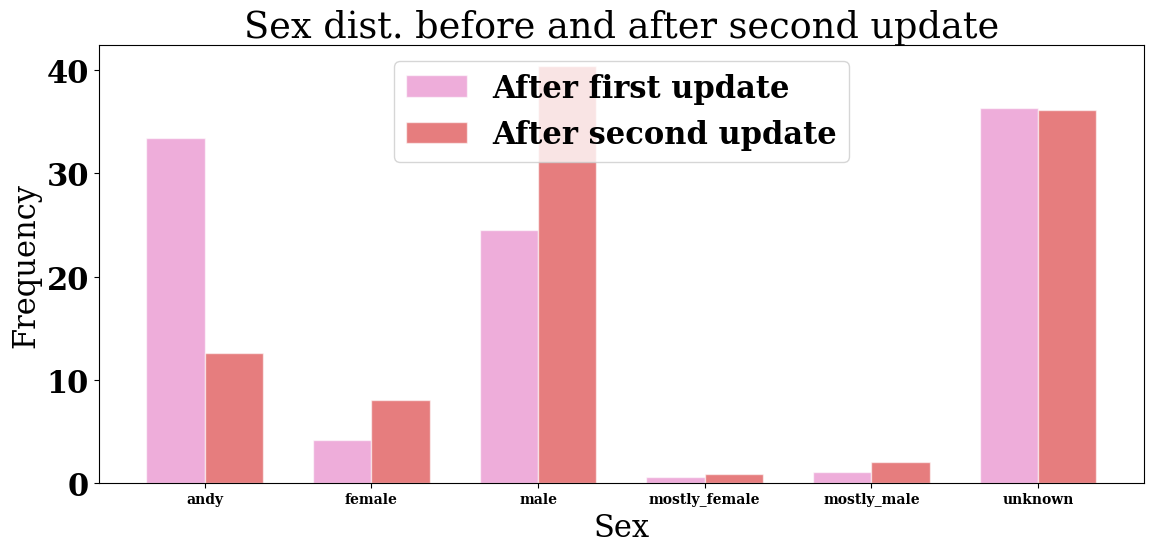

In [202]:
##fix plot in order to compare them
cat_plot_compare(article_author_data_updated.predicted_gender, article_author_data_updated_second.predicted_gender, title='Sex dist. before and after second update', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='genderdiffupdatefirstsecond', label1='After first update', label2='After second update')



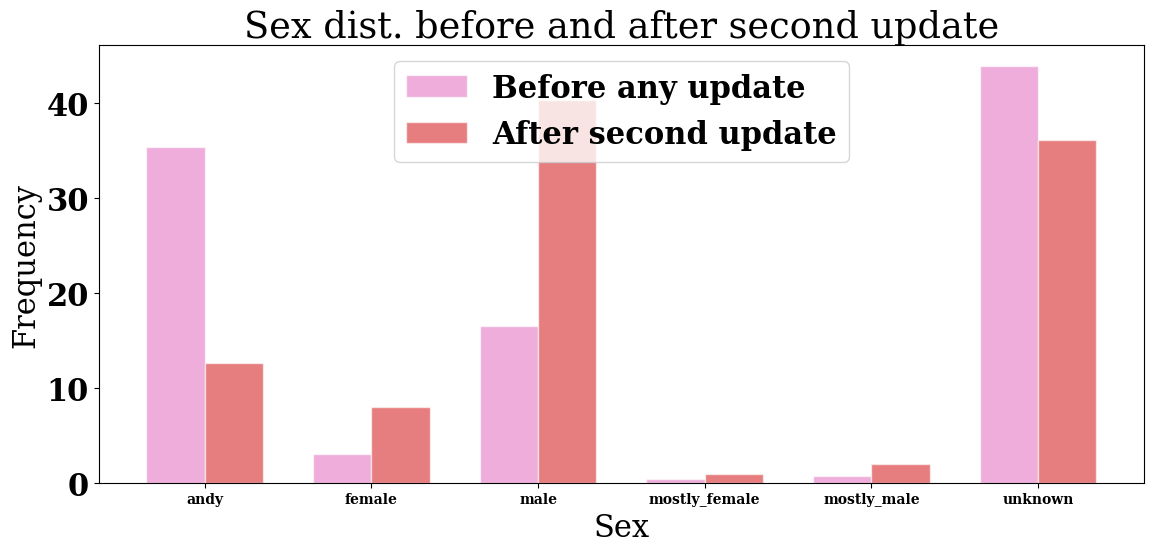

In [203]:
##fix plot in order to compare them
cat_plot_compare(article_author_data.predicted_gender, article_author_data_updated_second.predicted_gender, title='Sex dist. before and after second update', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='genderdiffupdatenonesecond', label1='Before any update', label2='After second update')



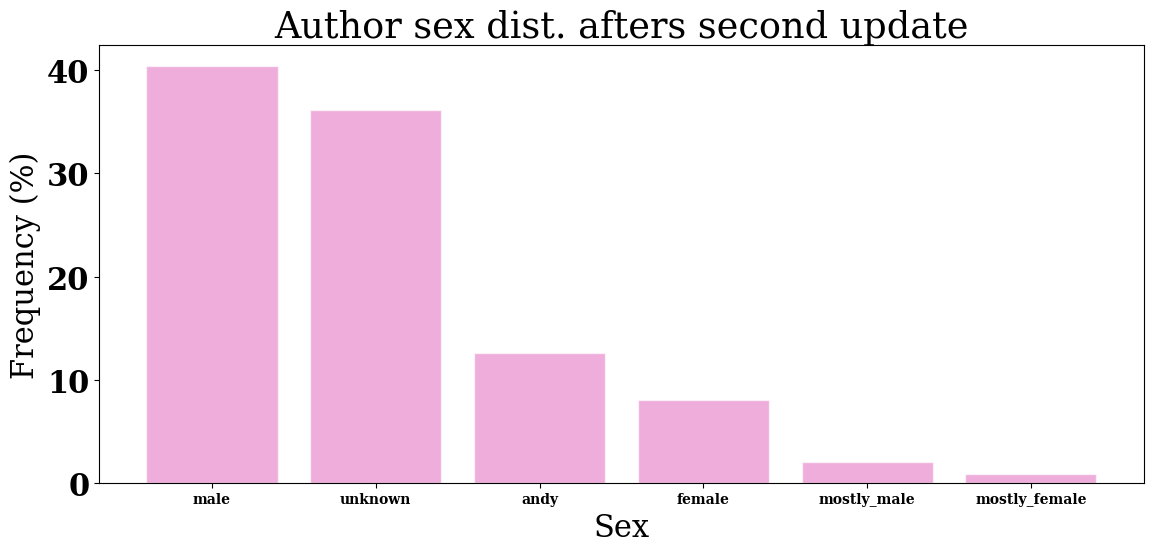

In [204]:
cat_plot(article_author_data_updated_second.predicted_gender, title='Author sex dist. afters second update', xlabel='Sex', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, save_name='article_author_data_updated_second')


In [206]:
#select data with an actual predicted gender 
author_data_gender_second=article_author_data_updated_second[article_author_data_updated_second['predicted_gender'].isin(['male', 'female', 'mostly_male', 'mostly_female'])]

In [226]:
print("N without assigned gender from second update:", f"N={len(article_author_data_updated_second)-len(author_data_gender_second)}", f"({(len(article_author_data_updated_second)-len(author_data_gender_second))/len(article_author_data_updated_second)*100:.1f}%)")


N without assigned gender from second update: N=974047 (48.7%)


In [207]:
author_data_gender_second['predicted_gender'][author_data_gender_second['predicted_gender']=='mostly_male']='male'
author_data_gender_second['predicted_gender'][author_data_gender_second['predicted_gender']=='mostly_female']='female'

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_975/3988259932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data_gender_second['predicted_gender'][author_data_gender_second['predicted_gender']=='mostly_male']='male'
/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_975/3988259932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data_gender_second['predicted_gender'][author_data_gender_second['predicted_gender']=='mostly_female']='female'


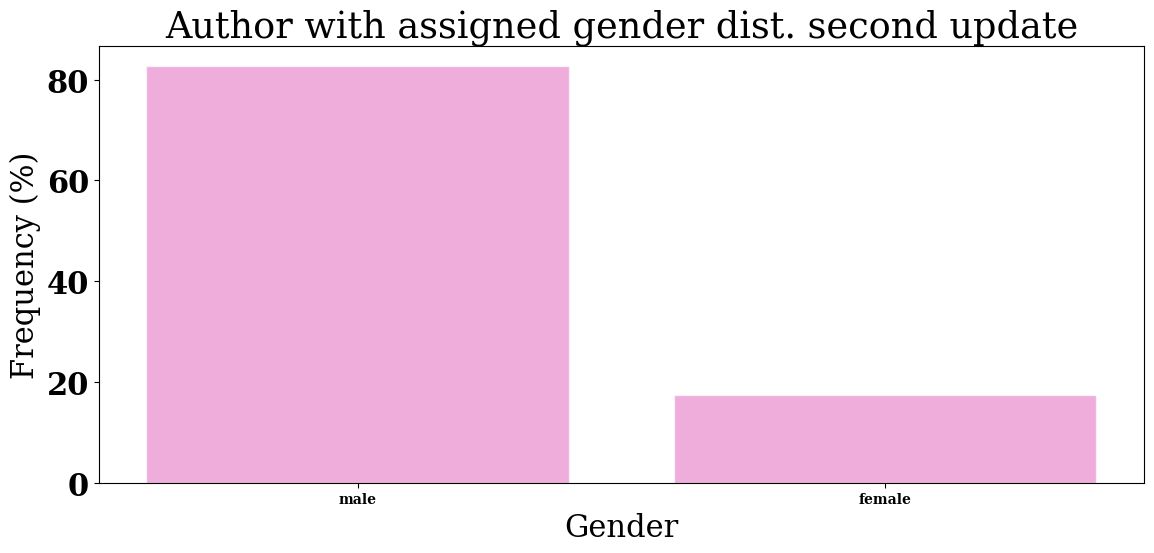

In [208]:
cat_plot(author_data_gender_second.predicted_gender, title='Author with assigned gender dist. second update', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, save_name='author_data_gender_second')


In [227]:
second_update_unknown_gender=article_author_data_updated_second[article_author_data_updated_second['predicted_gender']=='unknown']
second_update_andy_gender=article_author_data_updated_second[article_author_data_updated_second['predicted_gender']=='andy']

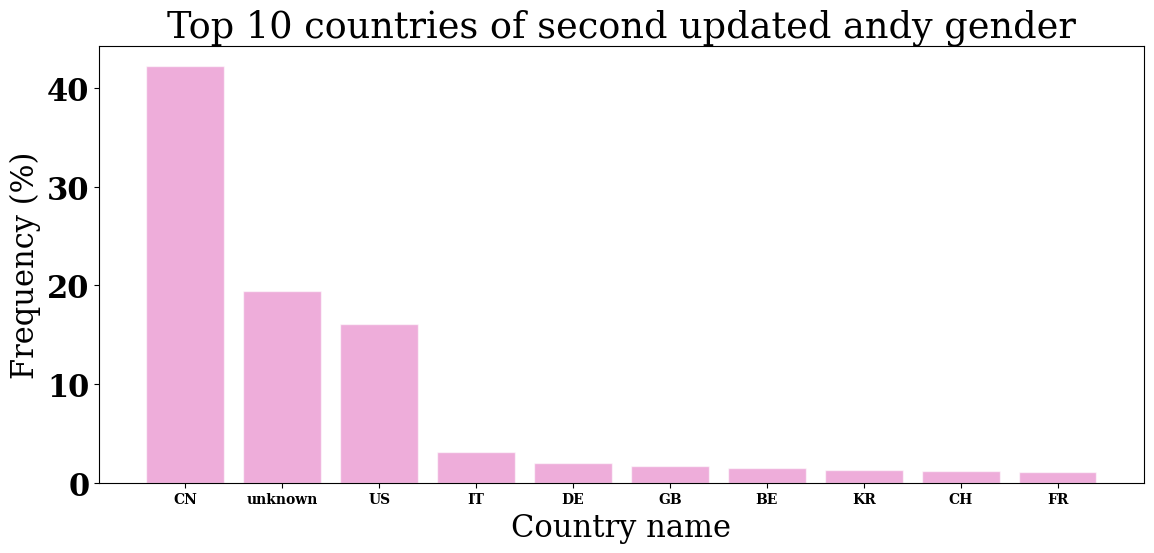

In [229]:
cat10_plot(second_update_andy_gender.author_first_country, title='Top 10 countries of second updated andy gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='second_update_andy_gender')


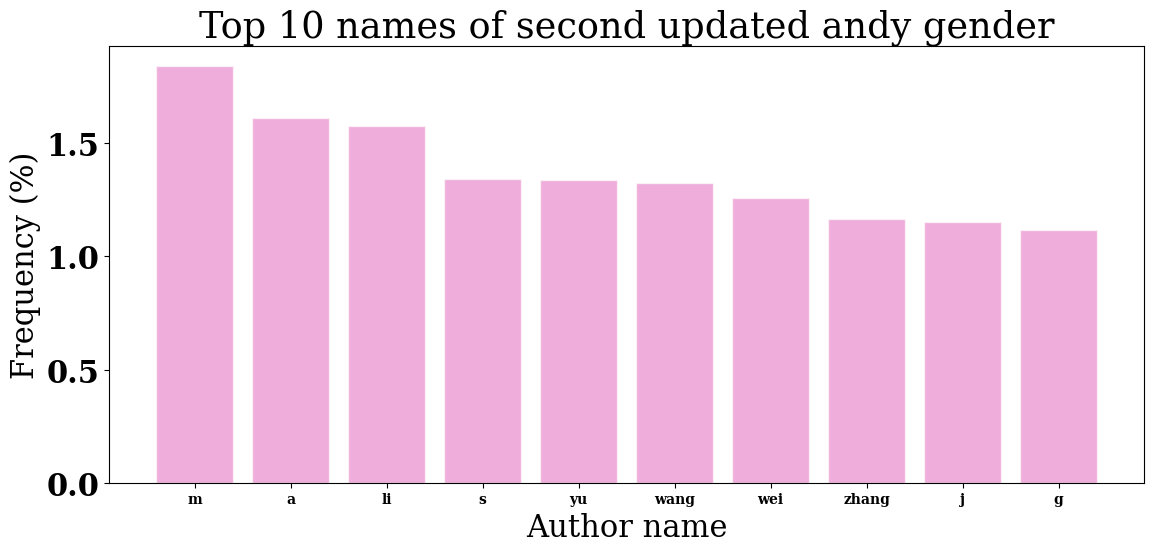

In [230]:
cat10_plot(second_update_andy_gender.extracted_first_name, title='Top 10 names of second updated andy gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='second_update_andy_gender')



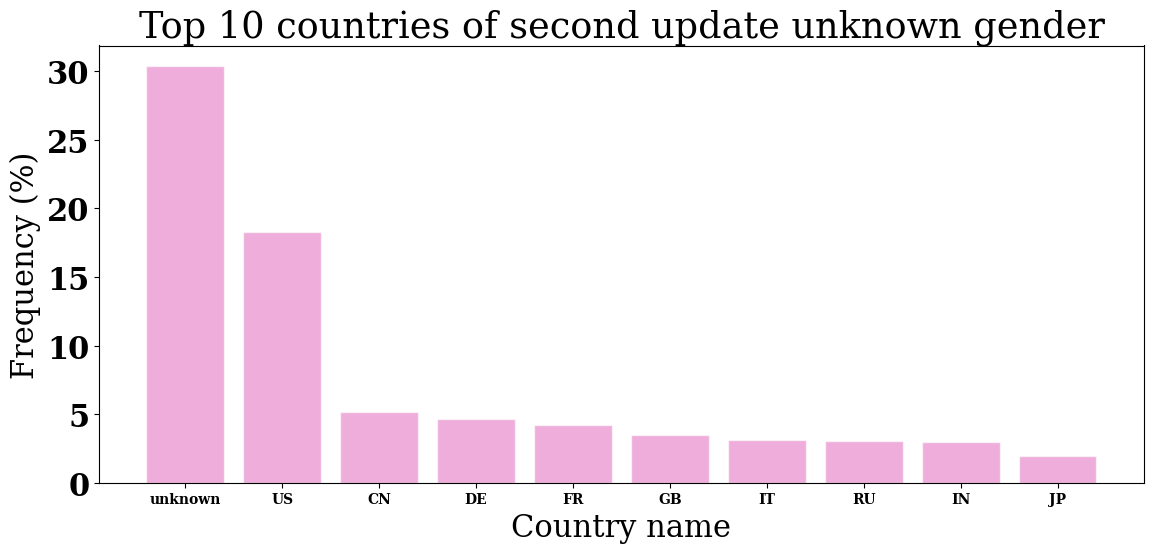

In [231]:
cat10_plot(second_update_unknown_gender.author_first_country, title='Top 10 countries of second update unknown gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='second_update_unknown_gender')


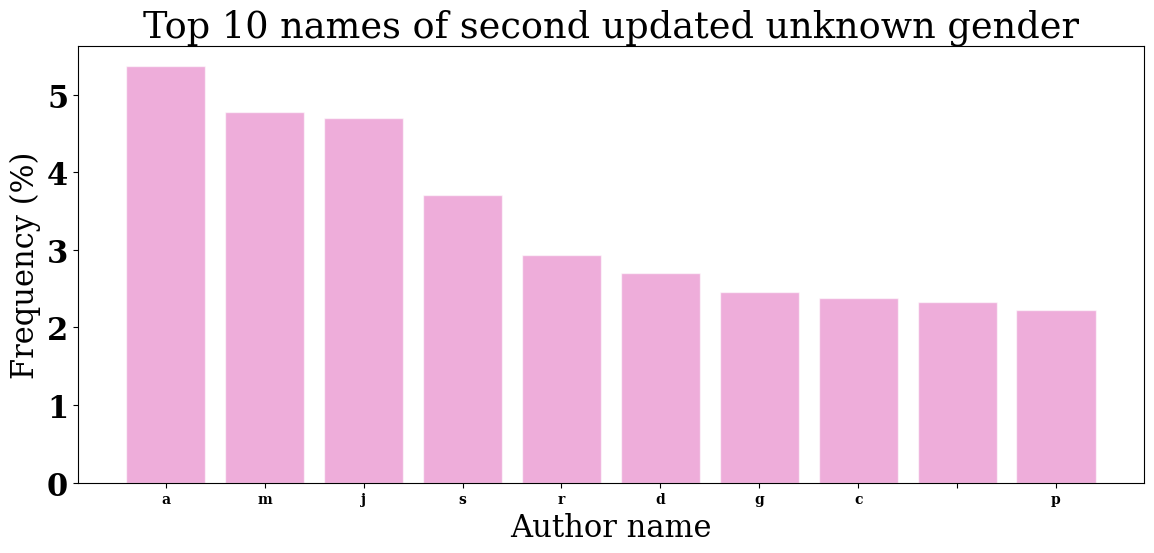

In [232]:
cat10_plot(second_update_unknown_gender.extracted_first_name, title='Top 10 names of second updated unknown gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='second_update_unknown_gender')


## Clean data based on gender assignment

In [36]:
#but maybe we should do the "NONE" name analysis on the whole and not the clean data!!!! 

In [37]:
#find all names of just one letter and drop them from analysis right now 
#let's create a copy of our original data so that we don't overwrite it when dropping the values and can always go back to them

article_author_data_clean=article_author_data_updated_second.copy()

In [42]:
# Apply the condition and create new dataframes without the rows where the name is just one letter VERIFY
article_author_data_clean = article_author_data_clean[article_author_data_clean['extracted_first_name'].apply(lambda x: len(x) > 1)].copy()

#check that it works 
print("Length of original dataframe:", f'N={len(article_author_data_updated_second)}', "Length of clean dataframe:", f'N={len(article_author_data_clean)}')

Length of original dataframe: N=2000281 Length of clean dataframe: N=1468452


In [247]:
# Apply the condition and create new dataframes without the rows where the name is just one letter
article_author_data_clean = article_author_data_clean[article_author_data_clean['extracted_first_name'].apply(lambda x: len(x) > 1)].copy()

#check that it works 
print("Length of original dataframe:", f'N={len(article_author_data_updated_second)}', "Length of clean dataframe:", f'N={len(article_author_data_clean)}')

Length of original dataframe: N=2000281 Length of clean dataframe: N=1468452


In [251]:
with open('OpenAlex Data/Unify/15122023CleanArticleAuthorData19702023.pkl', 'wb') as f:
    pickle.dump(article_author_data_clean, f)


In [248]:
clean_unknown_gender=article_author_data_clean[article_author_data_clean['predicted_gender']=='unknown']
clean_andy_gender=article_author_data_clean[article_author_data_clean['predicted_gender']=='andy']

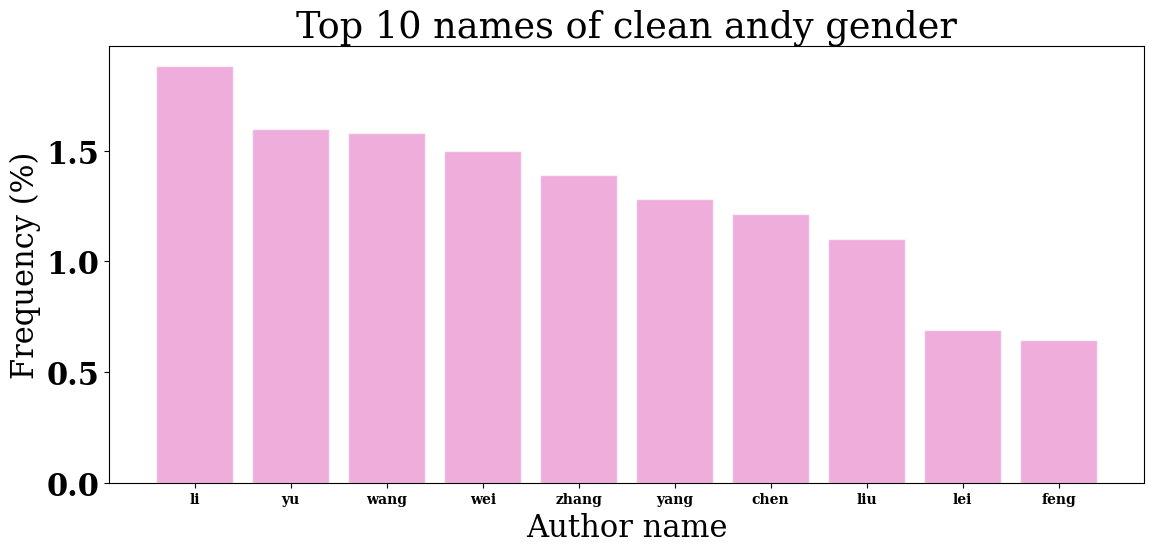

In [249]:
cat10_plot(clean_andy_gender.extracted_first_name, title='Top 10 names of clean andy gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='clean_andy_gender')
#these are all chinese names find a way to assign their gender 

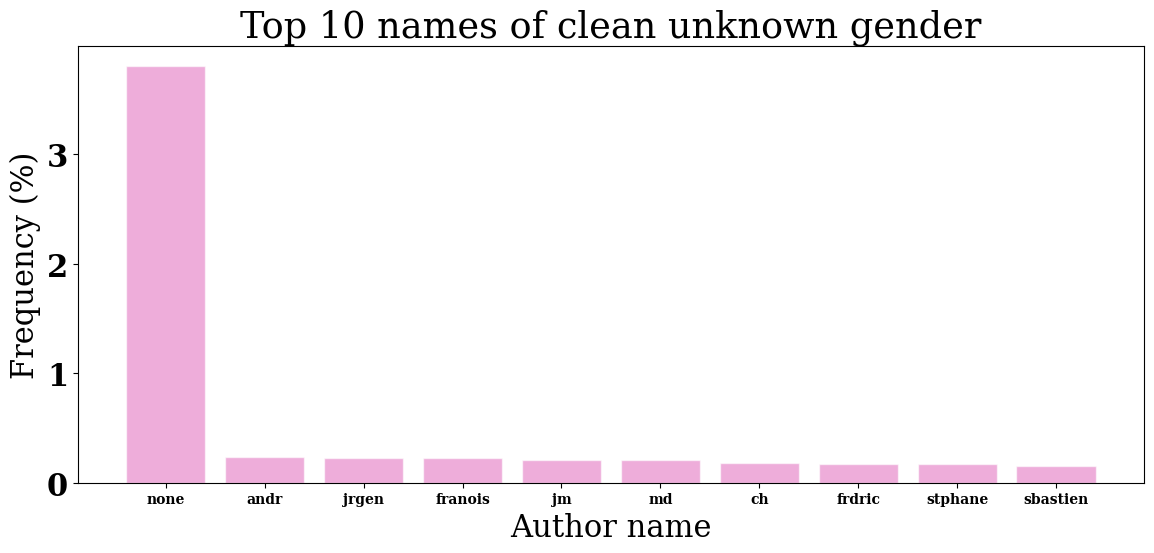

In [250]:
cat10_plot(clean_unknown_gender.extracted_first_name, title='Top 10 names of clean unknown gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='clean_unknown_gender')
#looks like there are a few cases where the model is confused by special characters in names. I think this should be andré, jørgen etc. 

In [ ]:
#let's create an algorithm that can extract the name in "selected full name" that is not none.
#so if the name is "none subiki" it should select subiki rather than "none" and then replace "extracted first name" with that instead. 
#then it should also update gender if it updates the name - however only if the gender is "unknown" or "andy" 

In [392]:
#import fresh data 
with open('OpenAlex Data/Unify/15122023CleanArticleAuthorData19702023.pkl', 'rb') as f:
    article_author_data_clean = pickle.load(f)

In [411]:
sample_clean=article_author_data_clean[article_author_data_clean['extracted_first_name']=='none']
sample_clean=sample_clean[['raw_author_name','author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country']]

In [412]:
sample_clean

raw_author_name author.display_name  \
1036           None Anonymous      NULL AUTHOR_ID   
1156           None Anonymous      NULL AUTHOR_ID   
1553           None Anonymous      NULL AUTHOR_ID   
1554           None Anonymous      NULL AUTHOR_ID   
1558           None Anonymous      NULL AUTHOR_ID   
...                       ...                 ...   
1993873           None Subiki            . Subiki   
1996517           None Elfisa              Elfisa   
1996518           None Safwan              Safwan   
1996519  None Rizky Fadhillah     Rizky Fadhillah   
1996644         None ShengQin           Sheng Qin   

                                author_id institution_country_code  \
1036     https://openalex.org/A9999999999                  unknown   
1156     https://openalex.org/A9999999999                  unknown   
1553     https://openalex.org/A9999999999                  unknown   
1554     https://openalex.org/A9999999999                  unknown   
1558     https://openalex.org/A9999999999                  unknown   
...                                   ...                      ...   
1993873  https://openalex.org/A5015847966                       ID   
1996517  https://openalex.org/A5004452829                  unknown   
1996518  https://openalex.org/A5069254338                  unknown   
1996519  https://openalex.org/A5047769790                  unknown   
1996644  https://openalex.org/A5091064163                  unknown   

           institution_name                    institution_id  \
1036                unknown                           unknown   
1156                unknown                           unknown   
1553                unknown                           unknown   
1554                unknown                           unknown   
1558                unknown                           unknown   
...                     ...                               ...   
1993873  Universitas Jember  https://openalex.org/I3129486149   
1996517             unknown                           unknown   
1996518             unknown                           unknown   
1996519             unknown                           unknown   
1996644             unknown                           unknown   

        institution_type    selected_full_name extracted_first_name  \
1036             unknown        none anonymous                 none   
1156             unknown        none anonymous                 none   
1553             unknown        none anonymous                 none   
1554             unknown        none anonymous                 none   
1558             unknown        none anonymous                 none   
...                  ...                   ...                  ...   
1993873        education           none subiki                 none   
1996517          unknown           none elfisa                 none   
1996518          unknown           none safwan                 none   
1996519          unknown  none rizky fadhillah                 none   
1996644          unknown         none shengqin                 none   

            country_name author_country_name author_country_name_api  \
1036     other_countries     other_countries         other_countries   
1156     other_countries     other_countries         other_countries   
1553     other_countries     other_countries         other_countries   
1554     other_countries     other_countries         other_countries   
1558     other_countries     other_countries         other_countries   
...                  ...                 ...                     ...   
1993873        indonesia           indonesia         other_countries   
1996517  other_countries     other_countries         other_countries   
1996518  other_countries     other_countries         other_countries   
1996519  other_countries     other_countries         other_countries   
1996644  other_countries     other_countries         other_countries   

        predicted_gender author_first

In [413]:
sample_clean['selected_full_name'].value_counts()

selected_full_name
none anonymous    222
none nana          18
none 梁潇文           13
none 江志晃           11
none 张福龙           10
                 ... 
none 董敢             1
none 乔乔             1
none 吴勤伟            1
none 门雷鸣            1
none shengqin       1
Name: count, Length: 9819, dtype: int64

In [43]:
def update_none_name_and_gender(df):

    # Create a copy of the input DataFrame
    df_copy = df.copy()

    # Create a mask for rows where 'extracted_first_name' is 'none' and 'selected_full_name' is not 'none anonymous'
    mask = (df_copy['extracted_first_name'] == 'none') & (df_copy['selected_full_name'] != 'none anonymous')

    # Update 'extracted_first_name' with the second part of 'selected_full_name' separated by space
    df_copy.loc[mask, 'extracted_first_name'] = df_copy.loc[mask, 'selected_full_name'].apply(lambda x: x.split(' ')[1] if ' ' in x and 'anonymous' not in x else x)

    # Create a mask for rows where 'predicted_gender' is either 'unknown' or 'andy'
    mask_unknown_gender = df_copy['predicted_gender'].isin(['unknown', 'andy'])

    # Create a mask for rows where 'author_country_name_api' is in ["unknown", "other_countries", "none"]
    mask_unknown_country = df_copy['author_country_name_api'].isin(['unknown', 'other_countries', 'none'])

    # Update 'predicted_gender' based on 'extracted_first_name' and 'author_country_name_api'
    detector = gender.Detector(case_sensitive=False)
    df_copy.loc[mask & mask_unknown_gender & ~mask_unknown_country, 'predicted_gender'] = df_copy.loc[mask & mask_unknown_gender & ~mask_unknown_country].apply(lambda row: detector.get_gender(row['extracted_first_name'], row['author_country_name_api']), axis=1)

    # Update 'predicted_gender' based on 'extracted_first_name' only
    df_copy.loc[mask & mask_unknown_gender & mask_unknown_country, 'predicted_gender'] = df_copy.loc[mask & mask_unknown_gender & mask_unknown_country, 'extracted_first_name'].apply(lambda x: detector.get_gender(x))

    return df_copy


In [415]:
sample_clean_test=update_none_name_and_gender(sample_clean)

In [416]:
print("Diff none names w. update:", len(sample_clean_test[sample_clean_test['extracted_first_name']=='none'])-len(sample_clean[sample_clean['extracted_first_name']=='none']))
print("Diff gender w. update:", sample_clean_test.predicted_gender.value_counts()-sample_clean.predicted_gender.value_counts()) #looks like it works

Diff none names w. update: -12398
Diff gender w. update: predicted_gender
andy                NaN
female            155.0
male              169.0
mostly_female       NaN
mostly_male        34.0
unknown         -1421.0
Name: count, dtype: float64


In [44]:
#try on the entire clean dataframe 
article_author_data_clean_update=update_none_name_and_gender(article_author_data_clean)

In [433]:
print("Diff none names w. update:", len(article_author_data_clean_update[article_author_data_clean_update['extracted_first_name']=='none'])-len(article_author_data_clean[article_author_data_clean['extracted_first_name']=='none']))
print("Diff gender w. update:", article_author_data_clean_update.predicted_gender.value_counts()-article_author_data_clean.predicted_gender.value_counts()) #looks like it works

Diff none names w. update: -12620
Diff gender w. update: predicted_gender
male              169
unknown         -1643
andy             1030
female            155
mostly_male        34
mostly_female      33
Name: count, dtype: int64


In [425]:
#let's check what the "none" names looks like now 
article_author_data_clean_update[['selected_full_name', 'extracted_first_name', 'predicted_gender']][article_author_data_clean_update['extracted_first_name']=='none'].value_counts()

#they are all none, unknown so we can discard these from the data

selected_full_name  extracted_first_name  predicted_gender
none anonymous      none                  unknown             222
Name: count, dtype: int64

In [ ]:
#maybe we should try to run it on the total length dataframe and not just clean one 
# article_author_data_updated_second - see if it changes anything 

In [34]:
#try on the entire un-clean dataframe 
article_author_data_updated_third=update_none_name_and_gender(article_author_data_updated_second)


In [432]:
print("Diff none names w. update:", len(article_author_data_updated_third[article_author_data_updated_third['extracted_first_name']=='none'])-len(article_author_data_updated_second[article_author_data_updated_second['extracted_first_name']=='none']))
print("Diff gender w. update:", article_author_data_updated_third.predicted_gender.value_counts()-article_author_data_updated_second.predicted_gender.value_counts()) #looks like it works

Diff none names w. update: -12398
Diff gender w. update: predicted_gender
male              169
unknown         -1421
andy             1030
female            155
mostly_male        34
mostly_female      33
Name: count, dtype: int64


In [428]:
#let's check what the "none" names looks like now 
article_author_data_updated_third[['selected_full_name', 'extracted_first_name', 'predicted_gender']][article_author_data_updated_third['extracted_first_name']=='none'].value_counts()

#looks good - let's remove these cases for now and see what else we have left to update in the data -

selected_full_name  extracted_first_name  predicted_gender
none anonymous      none                  unknown             222
Name: count, dtype: int64

## Clean data part 2

In [430]:
#let's continue with the clean dataset for now and remove none cases and see what it looks like now
article_author_data_clean_update=article_author_data_clean_update[article_author_data_clean_update['extracted_first_name'] != 'none']


In [437]:
print("None names removed:", len(article_author_data_clean_update)-len(article_author_data_clean))

None names removed: -222


In [443]:
clean_update_unknown_gender=article_author_data_clean_update[article_author_data_clean_update['predicted_gender']=='unknown']
clean_update_andy_gender=article_author_data_clean_update[article_author_data_clean_update['predicted_gender']=='andy']

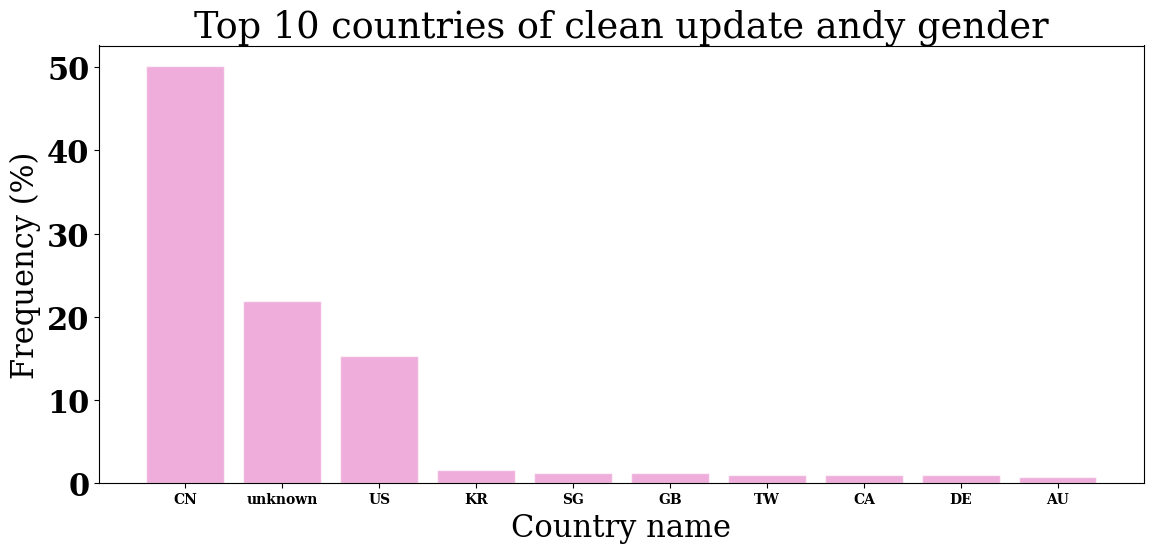

In [444]:
cat10_plot(clean_update_andy_gender.author_first_country, title='Top 10 countries of clean update andy gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='clean_update_andy_gender')


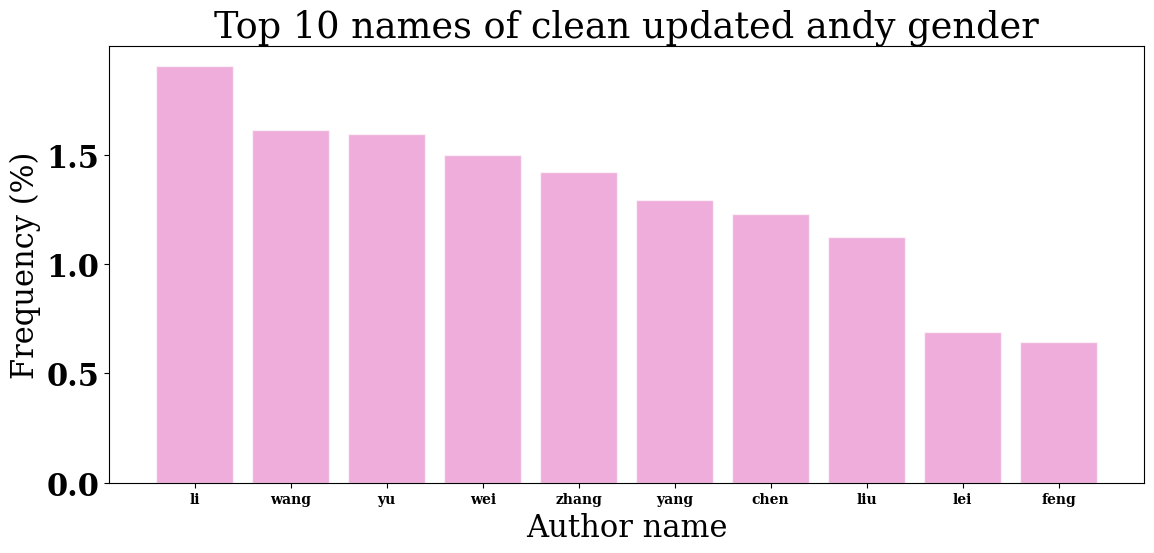

In [445]:
cat10_plot(clean_update_andy_gender.extracted_first_name, title='Top 10 names of clean updated andy gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='clean_update_andy_gender')



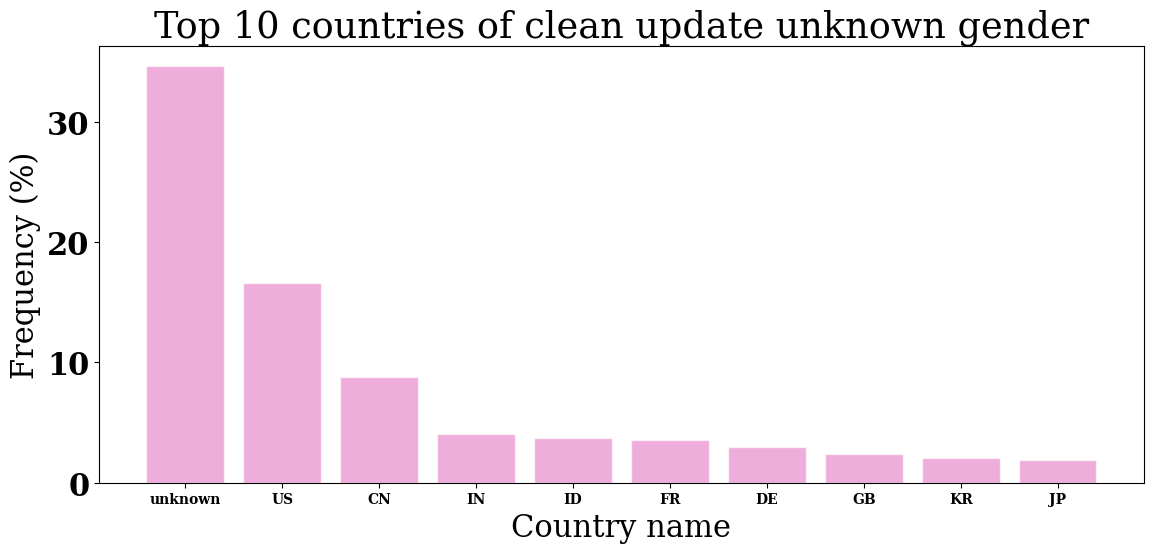

In [446]:
cat10_plot(clean_update_unknown_gender.author_first_country, title='Top 10 countries of clean update unknown gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='clean_update_unknown_gender')


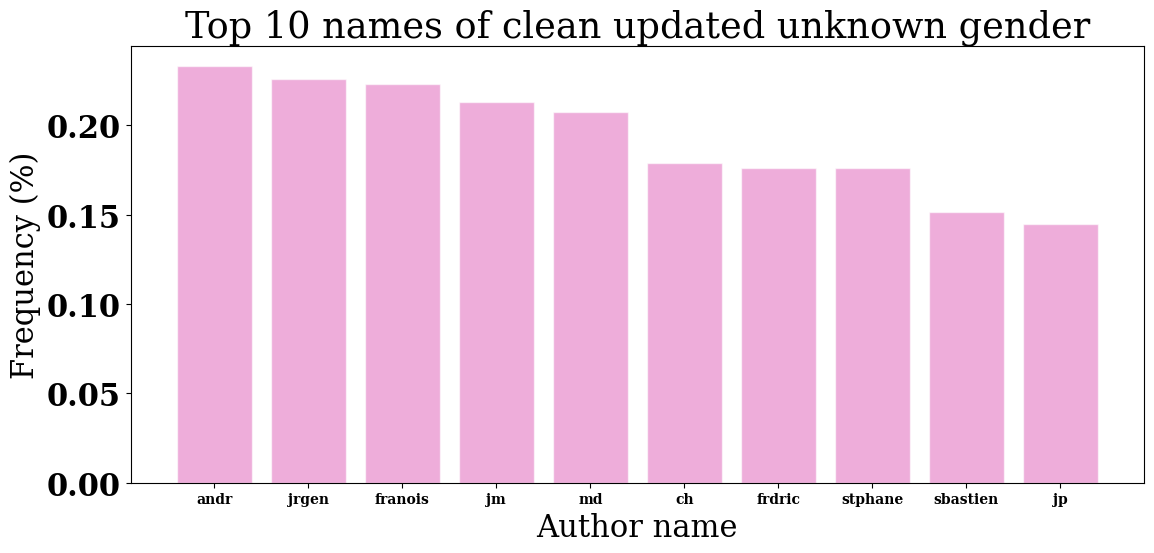

In [447]:
cat10_plot(clean_update_unknown_gender.extracted_first_name, title='Top 10 names of clean updated unknown gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, save_name='clean_update_unknown_gender')


In [ ]:
#clearly andy gender are chinese names and unknown gender are "undefined" names with special characters that have not been read right.
#How do we deal with these? 

In [452]:
#Let's start by checking the unknown gender names 
clean_update_unknown_gender_namedata=clean_update_unknown_gender[['raw_author_name',
       'author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country']]

In [453]:
clean_update_unknown_gender_namedata['extracted_first_name'].value_counts()

extracted_first_name
andr         768
jrgen        744
franois      736
jm           702
md           683
            ... 
asiana         1
beauty         1
rushed         1
shanjidah      1
rongdong       1
Name: count, Length: 100081, dtype: int64

In [606]:
andre_test=clean_update_unknown_gender_namedata[clean_update_unknown_gender_namedata['extracted_first_name']=='andr']
andre_test

raw_author_name    author.display_name  \
2525           André Dmitrieff        André Dmitrieff   
6855                  A. Voros            André Voros   
6999              André Girard           André Girard   
7773                A Maréchal         André Maréchal   
11847        André Vandermeers      André Vandermeers   
...                        ...                    ...   
1991611          André Hürkamp          André Hürkamp   
1994400  André V. G. Cavalieri  André V. G. Cavalieri   
1994887       A. R. Fioravanti    André R. Fioravanti   
1998320         André Xhonneux         André Xhonneux   
1999313   André Ramos Carneiro   André Ramos Carneiro   

                                author_id institution_country_code  \
2525     https://openalex.org/A5045618067                  unknown   
6855     https://openalex.org/A5064940143                       FR   
6999     https://openalex.org/A5024304691                       CA   
7773     https://openalex.org/A5025694616                  unknown   
11847    https://openalex.org/A5017575699                  unknown   
...                                   ...                      ...   
1991611  https://openalex.org/A5026299615                       DE   
1994400  https://openalex.org/A5077252335                       BR   
1994887  https://openalex.org/A5087182558                       BR   
1998320  https://openalex.org/A5084646178                       DE   
1999313  https://openalex.org/A5073773865                       BR   

                                      institution_name  \
2525                                           unknown   
6855                    Institut de Physique Théorique   
6999                              Université du Québec   
7773                                           unknown   
11847                                          unknown   
...                                                ...   
1991611            Technische Universität Braunschweig   
1994400           Instituto Tecnológico de Aeronáutica   
1994887              Universidade Estadual de Campinas   
1998320                       Forschungszentrum Jülich   
1999313  Laboratório Nacional de Computação Científica   

                           institution_id institution_type  \
2525                              unknown          unknown   
6855     https://openalex.org/I4210163633       government   
6999       https://openalex.org/I49663120        education   
7773                              unknown          unknown   
11847                             unknown          unknown   
...                                   ...              ...   
1991611    https://openalex.org/I94509681        education   
1994400   https://openalex.org/I107428990        education   
1994887   https://openalex.org/I181391015        education   
1998320   https://openalex.org/I171892758         facility   
1999313  https://openalex.org/I4210142352       government   

            selected_full_name extracted_first_name     country_name  \
2525           andré dmitrieff                 andr  other_countries   
6855               andré voros                 andr           france   
6999              andré girard                 andr           canada   
7773            andré maréchal                 andr  other_countries   
11847        andré vandermeers                 andr          belgium   
...                        ...                  ...              ...   
1991611          andré hürkamp                 andr          germany   
1994400  andré v. g. cavalieri                 andr           brazil   
1994887    andré r. fioravanti                 andr           brazil   
1998320         andré xhonneux                 andr          germany   
1999313   andré ramos carneiro                 andr           brazil   

        author_country_name author_country_name_api predicted_gender  \
2525        other_countries         other_countries          unknown   
6855                 france           

In [ ]:
#let's test how the gender guesser works on special characters like andré 

In [487]:
detector = gender.Detector(case_sensitive=False)
print("andr gender:", detector.get_gender('andr'))
print("andre gender:", detector.get_gender('andre'))
print("andré gender:", detector.get_gender('andré'))
print("andrê gender:", detector.get_gender('andrê'))
print("jrgen gender:", detector.get_gender('jrgen'))
print("jorgen gender:", detector.get_gender('jorgen'))
print("jørgen gender:", detector.get_gender('jørgen'))

#so the gender API works fine with special characters it seems - it just didn't extract them probably when saving the first name 
#so we should probably go through all the andy and unknown genders and check for special characters in their name 
#or we could check if there is a difference between the full name and first name and then update correctly from full name 
#or just take first part of full name 

andr gender: unknown
andre gender: male
andré gender: male
andrê gender: unknown
jrgen gender: unknown
jorgen gender: unknown
jørgen gender: male


In [467]:
#let's check how the computer does if we use the split function on andré 
'andré dmitrieff'.split(' ')[0]	


'andré'

In [479]:
andre_test_test=andre_test['selected_full_name'].apply(lambda x: x.split(' ')[0])
andre_test_test.value_counts()

selected_full_name
andré     762
andr        3
andré,      2
andrê       1
Name: count, dtype: int64

In [485]:
andre_test[andre_test_test=='andrê']

raw_author_name author.display_name                         author_id  \
572353  A. S. H. Prevot  Andrê S. H. Prévôt  https://openalex.org/A5004218679   

       institution_country_code         institution_name  \
572353                       CH  Paul Scherrer Institute   

                          institution_id institution_type  selected_full_name  \
572353  https://openalex.org/I2802229908         facility  andrê s. h. prévôt   

       extracted_first_name country_name author_country_name  \
572353                 andr  switzerland         switzerland   

       author_country_name_api predicted_gender author_first_country  
572353                   swiss          unknown                   CH

In [504]:
#it looks like we should just update the extracted first names from splitting the extracted full name - test here
detector = gender.Detector(case_sensitive=False)

andre_test_test_gender = [detector.get_gender(name) for name in andre_test_test]


In [508]:
pd.DataFrame(andre_test_test_gender).value_counts()

male       762
unknown      6
Name: count, dtype: int64

In [511]:
#looks like this works so let's update all the unknown (and andy) names in the same way to ensure that we keep special characters? 
#but maybe let's look back at our original code where we extracted the first name - just to check why it didn't update correctly - 
#maybe it's better to update it then and run everything from the begining? (probably not) but at least we should know why. 
#let's do this tomorrow 

In [ ]:
#let's update the first names for all andy and unknown - maybe it should be grouped by author_id so that each duplicate is updated similarly

- find all rows that are andy and unknown gender 
- group by author id - take most common selected full name in case the duplicants are different 
- update extracted first name by taking the first part of selcted full name
- update gender based on the updated extracted first name and country. however, only use name if country is unknown or other_countries


In [46]:
def update_wrong_names_gender(df):
    # Create a copy of the original dataframe
    df_updated = df.copy()

    # Initialize gender detector
    detector = gender.Detector(case_sensitive=False)

    # Identify rows where predicted_gender is 'andy' or 'unknown'
    mask_unknown_andy = df_updated['predicted_gender'].isin(['andy', 'unknown'])

    # Group by author_id and find the most common selected_full_name for rows with 'andy' or 'unknown'
    most_common_names = df_updated[mask_unknown_andy].groupby('author_id')['selected_full_name'].apply(
        lambda x: x.mode().iloc[0] if not x.empty else None
    ).reset_index()

    # Merge most_common_names back to the original dataframe to get the corresponding extracted_first_name
    df_updated = pd.merge(df_updated, most_common_names, on='author_id', how='left', suffixes=('', '_most_common'))

    # Update extracted_first_name with the first part of the most common name for rows with 'andy' or 'unknown'
    mask_unknown_andy = df_updated['predicted_gender'].isin(['andy', 'unknown'])
    df_updated.loc[mask_unknown_andy, 'extracted_first_name'] = df_updated.loc[mask_unknown_andy, 'selected_full_name_most_common'].apply(
    lambda x: str(x).split(' ')[0] if isinstance(x, str) else '')



    # Update predicted_gender based on the updated extracted_first_name for rows with 'andy' or 'unknown'
    conditions = (df_updated['author_country_name_api'].isin(['unknown', 'other_countries']))

    # Add tqdm for progress monitoring
    for idx in tqdm(df_updated[mask_unknown_andy].index, desc='Updating gender predictions'):
        row = df_updated.loc[idx]
        if conditions[idx]:
            df_updated.at[idx, 'predicted_gender'] = detector.get_gender(row['extracted_first_name'])
        else:
            df_updated.at[idx, 'predicted_gender'] = detector.get_gender(row['extracted_first_name'], row['author_country_name_api'])

    # Drop unnecessary columns from the intermediate steps
    df_updated = df_updated.drop(['selected_full_name_most_common'], axis=1, errors='ignore')

    return df_updated


In [612]:
#let's test the function first on sample data
andre_test_updated = update_wrong_names_gender(andre_test)


Updating gender predictions: 100%|█████████| 768/768 [00:00<00:00, 49117.52it/s]


In [613]:
#check if columns been updated
print(andre_test_updated['extracted_first_name'].value_counts()-andre_test['extracted_first_name'].value_counts())
print(andre_test_updated['predicted_gender'].value_counts()-andre_test['predicted_gender'].value_counts())


extracted_first_name
andr     -765.0
andré       NaN
andré,      NaN
andrê       NaN
Name: count, dtype: float64
predicted_gender
andy         NaN
male         NaN
unknown   -762.0
Name: count, dtype: float64


In [614]:
andre_test_updated['predicted_gender'].value_counts() #looks like it works - let's try and update the whole dataframe

predicted_gender
male       648
andy       114
unknown      6
Name: count, dtype: int64

In [615]:
andre_test_updated

raw_author_name    author.display_name  \
0          André Dmitrieff        André Dmitrieff   
1                 A. Voros            André Voros   
2             André Girard           André Girard   
3               A Maréchal         André Maréchal   
4        André Vandermeers      André Vandermeers   
..                     ...                    ...   
763          André Hürkamp          André Hürkamp   
764  André V. G. Cavalieri  André V. G. Cavalieri   
765       A. R. Fioravanti    André R. Fioravanti   
766         André Xhonneux         André Xhonneux   
767   André Ramos Carneiro   André Ramos Carneiro   

                            author_id institution_country_code  \
0    https://openalex.org/A5045618067                  unknown   
1    https://openalex.org/A5064940143                       FR   
2    https://openalex.org/A5024304691                       CA   
3    https://openalex.org/A5025694616                  unknown   
4    https://openalex.org/A5017575699                  unknown   
..                                ...                      ...   
763  https://openalex.org/A5026299615                       DE   
764  https://openalex.org/A5077252335                       BR   
765  https://openalex.org/A5087182558                       BR   
766  https://openalex.org/A5084646178                       DE   
767  https://openalex.org/A5073773865                       BR   

                                  institution_name  \
0                                          unknown   
1                   Institut de Physique Théorique   
2                             Université du Québec   
3                                          unknown   
4                                          unknown   
..                                             ...   
763            Technische Universität Braunschweig   
764           Instituto Tecnológico de Aeronáutica   
765              Universidade Estadual de Campinas   
766                       Forschungszentrum Jülich   
767  Laboratório Nacional de Computação Científica   

                       institution_id institution_type     selected_full_name  \
0                             unknown          unknown        andré dmitrieff   
1    https://openalex.org/I4210163633       government            andré voros   
2      https://openalex.org/I49663120        education           andré girard   
3                             unknown          unknown         andré maréchal   
4                             unknown          unknown      andré vandermeers   
..                                ...              ...                    ...   
763    https://openalex.org/I94509681        education          andré hürkamp   
764   https://openalex.org/I107428990        education  andré v. g. cavalieri   
765   https://openalex.org/I181391015        education    andré r. fioravanti   
766   https://openalex.org/I171892758         facility         andré xhonneux   
767  https://openalex.org/I4210142352       government   andré ramos carneiro   

    extracted_first_name     country_name author_country_name  \
0                  andré  other_countries     other_countries   
1                  andré           france              france   
2                  andré           canada              canada   
3                  andré  other_countries     other_countries   
4                  andré          belgium             belgium   
..                   ...              ...                 ...   
763                andré          germany             germany   
764                andré           brazil              brazil   
765                andré           brazil              brazil   
766                andré          germany             germany   
767                andré           brazil              brazil   

    author_country_name_api predicted_gender author_first_country  
0           other_countries             male              unknown  
1                    france             ma

In [40]:
%%time 
#update whole dataframe 
article_author_data_updated_fourth = update_wrong_names_gender(article_author_data_updated_third)



Updating gender predictions: 100%|███| 973656/973656 [00:42<00:00, 22861.70it/s]


CPU times: user 42.5 s, sys: 13 s, total: 55.5 s
Wall time: 2min 8s


In [50]:
article_author_data_clean_update.head(2)

article_id  \
0  https://openalex.org/W2149166552   
3  https://openalex.org/W2048737175   

                                         doi  publication_year  \
0  https://doi.org/10.1080/14786437008238472              1970   
3  https://doi.org/10.1080/00018737000101171              1970   

  publication_date                                              title  \
0       1970-04-01  Electrical resistance of disordered one-dimens...   
3       1970-07-01  Oscillatory approach to a singular point in th...   

   cited_by_count grants                                           abstract  \
0            2761     []  (1970). Electrical resistance of disordered on...   
3            1092     []  (1970). Oscillatory approach to a singular poi...   

                         journal_id                journal_name  ...  \
0  https://openalex.org/S4210240599  The philosophical magazine  ...   
3   https://openalex.org/S137691401         Advances in Physics  ...   

                                  institution_name  \
0  IBM Research - Thomas J. Watson Research Center   
3         Landau Institute for Theoretical Physics   

                     institution_id institution_type  selected_full_name  \
0  https://openalex.org/I4210114115         facility       rolf landauer   
3   https://openalex.org/I196576671         facility       e.m. lifshitz   

  extracted_first_name        country_name author_country_name  \
0                 rolf       united states       united states   
3                   em  russian federation  russian federation   

  author_country_name_api predicted_gender author_first_country  
0                     usa             male                   US  
3                  russia          unknown                   RU  

[2 rows x 29 columns]

In [51]:
%%time
#update clean dataframe
article_author_data_clean_update_second = update_wrong_names_gender(article_author_data_clean_update)


Updating gender predictions: 100%|███| 542064/542064 [00:18<00:00, 28736.09it/s]


CPU times: user 25.3 s, sys: 10.3 s, total: 35.6 s
Wall time: 1min 16s


In [631]:
article_author_data_clean_update_second.predicted_gender.value_counts()-article_author_data_clean_update.predicted_gender.value_counts()

predicted_gender
male             15868
unknown           -965
andy            -18984
female            2940
mostly_male       1081
mostly_female       60
Name: count, dtype: int64

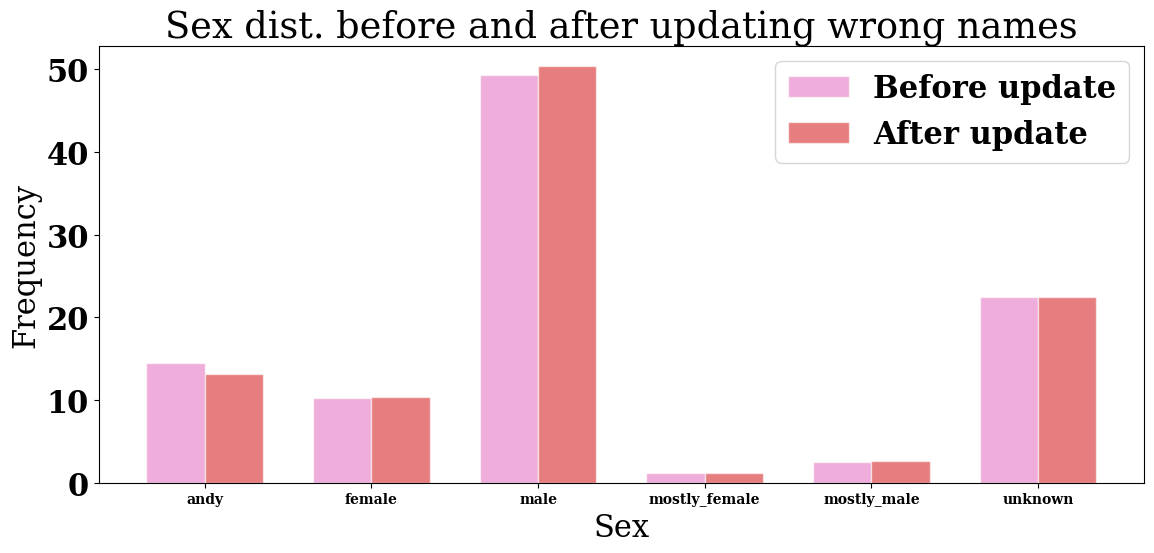

In [617]:
cat_plot_compare(article_author_data_clean_update.predicted_gender, article_author_data_clean_update_second.predicted_gender, title='Sex dist. before and after updating wrong names clean', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='wrongnameupdategenderdistclean', label1='Before update', label2='After update')


In [628]:
#let's double check the update with our example of andré
article_author_data_clean_update['predicted_gender'][article_author_data_clean_update['extracted_first_name']=='andr'].value_counts()

predicted_gender
unknown    768
male        30
Name: count, dtype: int64

In [626]:
article_author_data_clean_update_second['predicted_gender'][article_author_data_clean_update_second['extracted_first_name']=='andré'].value_counts()

predicted_gender
male    696
andy    116
Name: count, dtype: int64

In [632]:
#what does the andy and unknown names look like now 
article_author_data_clean_update_second['extracted_first_name'][article_author_data_clean_update_second['predicted_gender']=='andy'].value_counts()

extracted_first_name
wei          3211
li           2589
yang         2255
wang         1723
yu           1624
             ... 
nianzu          1
wanzhong        1
sheng-mei       1
kolbjørn        1
weiru           1
Name: count, Length: 9698, dtype: int64

In [633]:
article_author_data_clean_update_second['extracted_first_name'][article_author_data_clean_update_second['predicted_gender']=='unknown'].value_counts()


extracted_first_name
none        11500
yu.          1510
li,           668
chen,         633
liu,          563
            ...  
darryel         1
dakin           1
bpmic           1
hengjing        1
rongdong        1
Name: count, Length: 96008, dtype: int64

In [635]:
article_author_data_clean_update_second[article_author_data_clean_update_second['extracted_first_name']=='none']
#this was the update we made before however it now "overwrites" this function - so maybe we should do them the other way around
#so update wrong names first and then update none names 

article_id  \
920      https://openalex.org/W4241137497   
987      https://openalex.org/W4229982600   
3016     https://openalex.org/W4231712253   
4492     https://openalex.org/W4233611007   
5724     https://openalex.org/W4232512127   
...                                   ...   
1462645  https://openalex.org/W4387603585   
1464844  https://openalex.org/W4387836825   
1464846  https://openalex.org/W4387836825   
1464967  https://openalex.org/W4387848484   
1466386  https://openalex.org/W4385478432   

                                                       doi  publication_year  \
920         https://doi.org/10.1259/0007-1285-43-508-281-b              1970   
987           https://doi.org/10.1259/0007-1285-43-511-503              1970   
3016        https://doi.org/10.1259/0007-1285-45-530-156-a              1972   
4492        https://doi.org/10.1259/0007-1285-46-550-839-c              1973   
5724        https://doi.org/10.1180/minmag.1974.039.307.27              1974   
...                                                    ...               ...   
1462645            https://doi.org/10.57092/ijetz.v2i3.132              2023   
1464844  https://doi.org/10.31572/inotera.vol8.iss2.202...              2023   
1464846  https://doi.org/10.31572/inotera.vol8.iss2.202...              2023   
1464967              https://doi.org/10.31219/osf.io/ybrpg              2023   
1466386        https://doi.org/10.1016/j.geoen.2023.212224              2023   

        publication_date                                              title  \
920           1970-04-01                       J. C. Jones, M.A., F.Inst.P.   
987           1970-07-01                                    Dr. G. Spiegler   
3016          1972-02-01  Henry Thomas Flint, D.Sc., Ph.D., M.R.C.S., L....   
4492          1973-10-01                               Edwin Augustine Owen   
5724          1974-09-01  (W.) Pies and (A.) Weiss. Crystal structure da...   
...                  ...                                                ...   
1462645       2023-10-13  Content Accuracy and Recency of TPACK-Based Ph...   
1464844       2023-10-20  Design of Android-Based Augmented Reality Phys...   
1464846       2023-10-20  Design of Android-Based Augmented Reality Phys...   
1464967       2023-10-21  Theoretical Explanation and Computational Form...   
1466386       2023-11-01  Integration of rock physics, geostatistics, an...   

         cited_by_count                                             grants  \
920                   0                                                 []   
987                   0                                                 []   
3016                  0                                                 []   
4492                  0                                                 []   
5724                  0                                                 []   
...                 ...                                                ...   
1462645               0                                                 []   
1464844               0                                                 []   
1464846               0                                                 []   
1464967               0                                                 []   
1466386               0  [{'award_id': 'ZLZX 2020-01', 'funder': 'https...   

                                                  abstract  \
920      It is with deep regret that we record the deat...   
987      By the death of Gottfried Spiegler the radiolo...   
3016     Members of the Institute will have heard with ...   
4492     We have just received the following letter fro...   
5724     (W.) Pies and (A.) Weiss. Crystal structure da...   
...                                                    ...   
1462645  TPACK-based textbooks are reference books cont...   
1464844  Many senior high school students still rely on...   
1464846  Many senior high school students still rely on...   
1464967  The main concl

In [41]:
#let's update none names again (so in principle we can delete the first part where we do the same) 
def update_none_name_and_gender(df):

    # Create a copy of the input DataFrame
    df_copy = df.copy()

    # Create a mask for rows where 'extracted_first_name' is 'none' and 'selected_full_name' is not 'none anonymous'
    mask = (df_copy['extracted_first_name'] == 'none') & (df_copy['selected_full_name'] != 'none anonymous')

    # Update 'extracted_first_name' with the second part of 'selected_full_name' separated by space
    df_copy.loc[mask, 'extracted_first_name'] = df_copy.loc[mask, 'selected_full_name'].apply(lambda x: x.split(' ')[1] if ' ' in x and 'anonymous' not in x else x)

    # Create a mask for rows where 'predicted_gender' is either 'unknown' or 'andy'
    mask_unknown_gender = df_copy['predicted_gender'].isin(['unknown', 'andy'])

    # Create a mask for rows where 'author_country_name_api' is in ["unknown", "other_countries", "none"]
    mask_unknown_country = df_copy['author_country_name_api'].isin(['unknown', 'other_countries', 'none'])

    # Update 'predicted_gender' based on 'extracted_first_name' and 'author_country_name_api'
    detector = gender.Detector(case_sensitive=False)
    df_copy.loc[mask & mask_unknown_gender & ~mask_unknown_country, 'predicted_gender'] = df_copy.loc[mask & mask_unknown_gender & ~mask_unknown_country].apply(lambda row: detector.get_gender(row['extracted_first_name'], row['author_country_name_api']), axis=1)

    # Update 'predicted_gender' based on 'extracted_first_name' only
    df_copy.loc[mask & mask_unknown_gender & mask_unknown_country, 'predicted_gender'] = df_copy.loc[mask & mask_unknown_gender & mask_unknown_country, 'extracted_first_name'].apply(lambda x: detector.get_gender(x))

    return df_copy



In [639]:
#on entire dataframe 
article_author_data_updated_fifth=update_none_name_and_gender(article_author_data_updated_fourth)

In [ ]:
#THIRDFINALMARCH

In [65]:
#on clean dataframe 
article_author_data_clean_update_third=update_none_name_and_gender(article_author_data_clean_update_second)

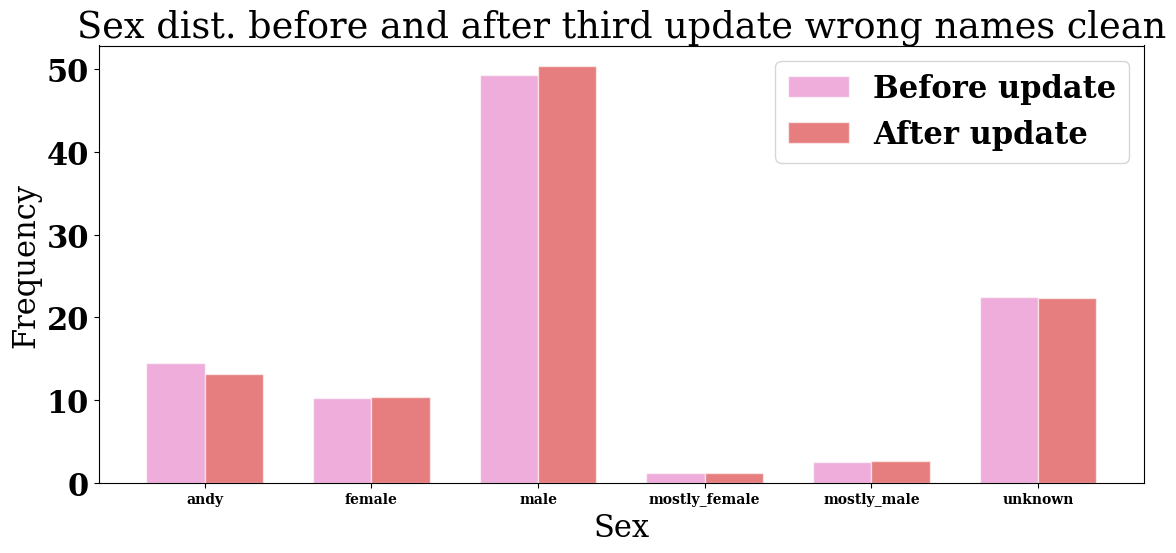

In [638]:
cat_plot_compare(article_author_data_clean_update.predicted_gender, article_author_data_clean_update_third.predicted_gender, title='Sex dist. before and after third update wrong names clean', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='wrongnameupdategenderdistcleanthird', label1='Before update', label2='After update')


In [643]:
#what does the andy and unknown names look like now 
article_author_data_clean_update_third[['extracted_first_name', 'author_first_country']][article_author_data_clean_update_third['predicted_gender']=='andy'].value_counts()

extracted_first_name  author_first_country
wei                   CN                      1808
li                    CN                      1510
yang                  CN                      1190
wang                  CN                      1072
lei                   CN                       898
                                              ... 
peilong               MZ                         1
                      TW                         1
peiman                GB                         1
peipei                FR                         1
qiming                VG                         1
Name: count, Length: 25551, dtype: int64

In [644]:
article_author_data_clean_update_third[['extracted_first_name', 'author_first_country']][article_author_data_clean_update_third['predicted_gender']=='unknown'].value_counts()


extracted_first_name  author_first_country
yu.                   RU                      799
chen,                 unknown                 392
yu.                   unknown                 353
wang,                 unknown                 353
li,                   unknown                 352
                                             ... 
karadimitrakis,       unknown                   1
karadeniz,            unknown                   1
karacson,             unknown                   1
karachik,             unknown                   1
홍석인(seok              unknown                   1
Name: count, Length: 141594, dtype: int64

In [658]:
detector.get_gender('li')

'andy'

In [56]:
# replace the yu names including , and . 
replace_yu = {'yu,': 'yu', 'yu.': 'yu', 'ya.': 'ya'}

article_author_data_clean_update_third['extracted_first_name'] = article_author_data_clean_update_third['extracted_first_name'].replace(replace_yu)

### Fourth update

In [ ]:
#re-run the third update to restore original third updata dataframe and save as pickle 
#look into fourth update again 

In [57]:
#should we try and update the dataframe so that if the gender is unknown/andy but appears elsewhere with an 
#assigned gender then we replace it 

def replace_unknown_andy(df):

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        if row['predicted_gender'] in ['unknown', 'andy']:
            name = row['extracted_first_name']
            
            # Find the first non-'unknown'/'andy' gender for the same name 
            ###well maybe this should be update to not find the first but the value appearing the most times 
            known_genders = df.loc[
                (df['extracted_first_name'] == name) &
                (df['predicted_gender'].isin(['unknown', 'andy']) == False),
                'predicted_gender'
            ]
            
            # If any known genders are found, replace 'unknown'/'andy' with the first one
            if not known_genders.empty:
                df.at[row.name, 'predicted_gender'] = known_genders.iloc[0]

    return df


In [1012]:
#let's first try it on a sample 

# Example DataFrame
data = {
    "extracted_first_name": ["John", "Jane", "Alex", "Sam", "John", "John", "Alex"],
    "predicted_gender": ["Female", "Female", "unknown", "andy", "Male", "unknown", "Female"]
}

df = pd.DataFrame(data)


df

extracted_first_name predicted_gender
0                 John           Female
1                 Jane           Female
2                 Alex          unknown
3                  Sam             andy
4                 John             Male
5                 John          unknown
6                 Alex           Female

In [1013]:

# Apply the function to replace 'unknown'/'andy'
df_updated = replace_unknown_andy(df)

# Print or use the updated DataFrame
df_updated #looks like it works 


Processing rows: 100%|██████████████████████████| 7/7 [00:00<00:00, 1289.82it/s]


extracted_first_name predicted_gender
0                 John           Female
1                 Jane           Female
2                 Alex           Female
3                  Sam             andy
4                 John             Male
5                 John           Female
6                 Alex           Female

In [ ]:
#SECONDFINALMARCH

In [58]:
article_author_data_clean_update_fourth = replace_unknown_andy(article_author_data_clean_update_third)


Processing rows: 100%|█████████████| 1468452/1468452 [10:33:37<00:00, 38.63it/s]


In [991]:
test_unknown=article_author_data_clean_update_third[article_author_data_clean_update_third['predicted_gender']=='unknown']
test_male=article_author_data_clean_update_third[article_author_data_clean_update_third['predicted_gender']=='male']

In [997]:
test_andy=article_author_data_clean_update_third[article_author_data_clean_update_third['predicted_gender']=='andy']
test_fem=article_author_data_clean_update_third[article_author_data_clean_update_third['predicted_gender']=='female']


In [1006]:
article_author_data_clean_update_third['predicted_gender'][article_author_data_clean_update_third['extracted_first_name']=='yu'].value_counts()

#okay I think it actually worked - but it didn't save the orginal dataframe with the third update. Let's look into this tomorrow 

predicted_gender
male             3352
female            186
mostly_female       3
Name: count, dtype: int64

In [1002]:
test_fem[test_fem.extracted_first_name.isin(test_unknown.extracted_first_name.to_list())]

Empty DataFrame
Columns: [article_id, doi, publication_year, publication_date, title, cited_by_count, grants, abstract, journal_id, journal_name, total_author_counts, author_position, author_countries, is_corresponding, raw_affiliation_string, raw_author_name, author.display_name, author_id, institution_country_code, institution_name, institution_id, institution_type, selected_full_name, extracted_first_name, country_name, author_country_name, author_country_name_api, predicted_gender, author_first_country]
Index: []

[0 rows x 29 columns]

In [66]:
#VERIFY !!!! 
article_author_data_clean_update_third.predicted_gender.value_counts()-article_author_data_clean_update_fourth.predicted_gender.value_counts()

predicted_gender
andy             57897
female          -14735
male            -34984
mostly_female    -8602
mostly_male      -7817
unknown           8241
Name: count, dtype: int64

In [1015]:
article_author_data_clean_update_third.predicted_gender.value_counts()-article_author_data_clean_update_fourth.predicted_gender.value_counts()

predicted_gender
andy             57897
female          -14735
male            -34984
mostly_female    -8602
mostly_male      -7817
unknown           8241
Name: count, dtype: int64

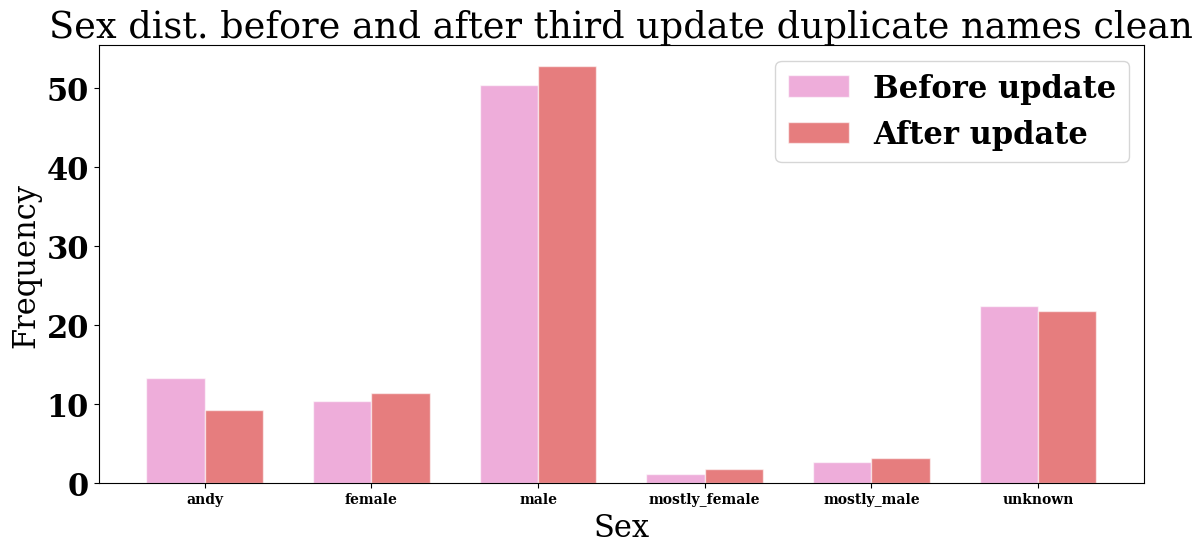

In [1017]:
#show the result of the fourth update compared to third update
cat_plot_compare(article_author_data_clean_update_third.predicted_gender, article_author_data_clean_update_fourth.predicted_gender, title='Sex dist. before and after third update duplicate names clean', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='duplicatenameupdategenderdistcleanfourth', label1='Before update', label2='After update')


In [67]:
%%time
with open('OpenAlex Data/Unify2024/04032024CleanArticleAuthorDataUpdateThird19702023.pkl', 'wb') as f:
    pickle.dump(article_author_data_clean_update_third, f)


CPU times: user 6.99 s, sys: 24.5 s, total: 31.5 s
Wall time: 2min 59s


In [64]:
%%time
with open('OpenAlex Data/Unify2024/04032024CleanArticleAuthorDataUpdateFourth19702023.pkl', 'wb') as f:
    pickle.dump(article_author_data_clean_update_fourth, f)


CPU times: user 7 s, sys: 26.3 s, total: 33.3 s
Wall time: 3min 32s


# Fourth update final

In [12]:
%%time
with open('OpenAlex Data/Unify/28122023CleanArticleAuthorDataUpdateThird19702023.pkl', 'rb') as f:
    article_author_data_clean_update_third = pickle.load(f)

CPU times: user 2.21 s, sys: 2.26 s, total: 4.47 s
Wall time: 5.65 s


In [68]:
#we create a function that finds unknown and andy gender and looks for similar cases of same name and country
#but with an assigned gender, then updates gender accordignly. However, if there is a tie between most appearing gender
#of similar cases then it looks for the most common gender value overall and assigns that
#if there again is a tie then it does not update the gender


def replace_unknown_andy(df):
    # Create a copy of the original DataFrame
    df_copy = df.copy()

    # Use tqdm to display a progress bar
    for _, row in tqdm(df_copy.iterrows(), total=len(df_copy), desc="Processing rows"):
        if row['predicted_gender'] in ['unknown', 'andy']:
            name = row['extracted_first_name']
            country = row['author_country_name_api']
            
            # Check for identical cases with the same name and country and a non-'unknown'/'andy' gender
            identical_cases = df_copy.loc[
                (df_copy['extracted_first_name'] == name) &
                (df_copy['author_country_name_api'] == country) &
                (df_copy['predicted_gender'].isin(['unknown', 'andy']) == False),
                'predicted_gender'
            ]
            
            # If there are identical cases, choose the most common gender among them
            if not identical_cases.empty:
                most_common_gender_identical = identical_cases.mode().iloc[0]
                
                # Check if there is a tie among identical cases
                if len(identical_cases.mode()) == 1:
                    df_copy.at[row.name, 'predicted_gender'] = most_common_gender_identical
                else:
                    # If there is a tie among identical cases, find the most common gender for the same name without considering country
                    known_genders = df_copy.loc[
                        (df_copy['extracted_first_name'] == name) &
                        (df_copy['predicted_gender'].isin(['unknown', 'andy']) == False),
                        'predicted_gender'
                    ]
                    
                    # If there is a tie, do nothing
                    if not known_genders.empty and len(known_genders.mode()) == 1:
                        most_common_gender = known_genders.mode().iloc[0]
                        df_copy.at[row.name, 'predicted_gender'] = most_common_gender
            else:
                # If no identical case, find the most common gender for the same name without considering country
                known_genders = df_copy.loc[
                    (df_copy['extracted_first_name'] == name) &
                    (df_copy['predicted_gender'].isin(['unknown', 'andy']) == False),
                    'predicted_gender'
                ]
                
                # If there is a tie, do nothing
                if not known_genders.empty and len(known_genders.mode()) == 1:
                    most_common_gender = known_genders.mode().iloc[0]
                    df_copy.at[row.name, 'predicted_gender'] = most_common_gender

    return df_copy



In [14]:
# Example DataFrame
data = {
    "extracted_first_name": ["John", "Jane", "Alex", "Sam", "John", "Alex", "Alex", "John", "John", "John", "John"],
    "predicted_gender": ["Male", "Female", "unknown", "andy", "unknown", "Female", "Female", "Male", "Male", "Female", "Female"],
    "author_country_name_api": ["USA", "Canada", "USA", "UK", "China", "Canada", "Canada", "Canada", "USA", "Canada", "China"]
}

df = pd.DataFrame(data)

df

extracted_first_name predicted_gender author_country_name_api
0                  John             Male                     USA
1                  Jane           Female                  Canada
2                  Alex          unknown                     USA
3                   Sam             andy                      UK
4                  John          unknown                   China
5                  Alex           Female                  Canada
6                  Alex           Female                  Canada
7                  John             Male                  Canada
8                  John             Male                     USA
9                  John           Female                  Canada
10                 John           Female                   China

In [15]:
df_updated = replace_unknown_andy(df)

df_updated #yay this works 


Processing rows: 100%|████████████████████████| 11/11 [00:00<00:00, 1305.34it/s]


extracted_first_name predicted_gender author_country_name_api
0                  John             Male                     USA
1                  Jane           Female                  Canada
2                  Alex           Female                     USA
3                   Sam             andy                      UK
4                  John           Female                   China
5                  Alex           Female                  Canada
6                  Alex           Female                  Canada
7                  John             Male                  Canada
8                  John             Male                     USA
9                  John           Female                  Canada
10                 John           Female                   China

In [16]:
df_updated.predicted_gender.value_counts()-df.predicted_gender.value_counts()

predicted_gender
Female     2.0
Male       0.0
andy       0.0
unknown    NaN
Name: count, dtype: float64

In [17]:
#let's test how approximetaly long the function should run 
update_sample=article_author_data_clean_update_third[0:100000]

In [18]:
update_sample_update = replace_unknown_andy(update_sample)


Processing rows: 100%|█████████████████| 100000/100000 [04:57<00:00, 335.96it/s]


In [19]:
update_sample_update.predicted_gender.value_counts()-update_sample.predicted_gender.value_counts() #looks like it works! 
#however it will take some hours so we should let it run all night


predicted_gender
male             480
unknown         -207
female            50
andy            -391
mostly_male       46
mostly_female     22
Name: count, dtype: int64

In [70]:
#let's run it on the entire dataframe 
article_author_data_clean_update_fourth=replace_unknown_andy(article_author_data_clean_update_third)

Processing rows: 100%|█████████████| 1468452/1468452 [26:49:53<00:00, 15.20it/s]


In [71]:
#VERIFY 
article_author_data_clean_update_third.predicted_gender.value_counts()-article_author_data_clean_update_fourth.predicted_gender.value_counts()

predicted_gender
andy             56360
female          -12269
male            -31162
mostly_female   -10549
mostly_male      -8894
unknown           6514
Name: count, dtype: int64

In [22]:
article_author_data_clean_update_third.predicted_gender.value_counts()-article_author_data_clean_update_fourth.predicted_gender.value_counts()

predicted_gender
andy             56360
female          -12269
male            -31162
mostly_female   -10549
mostly_male      -8894
unknown           6514
Name: count, dtype: int64

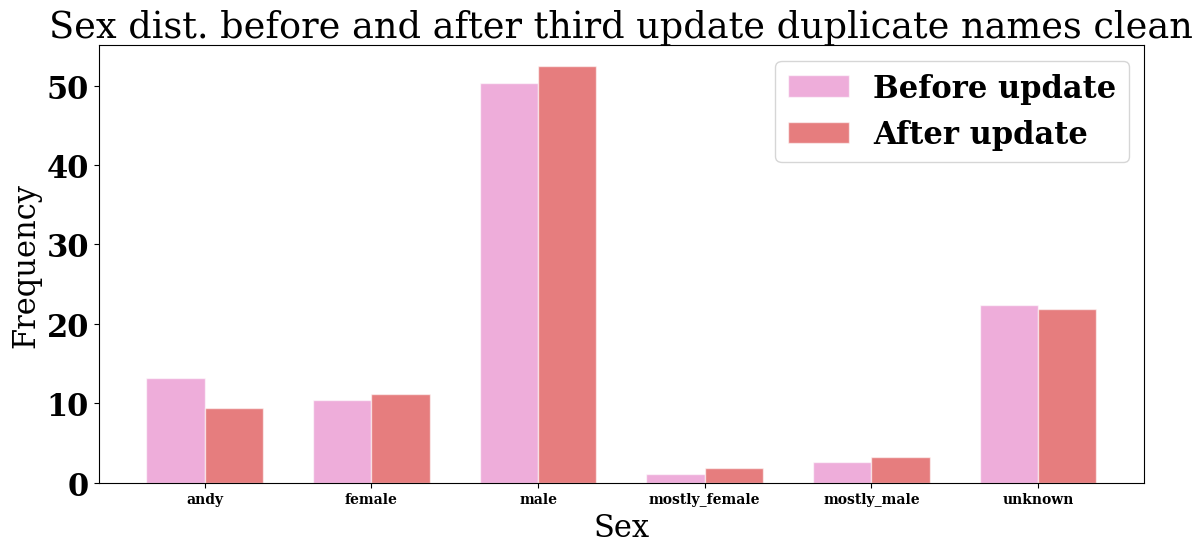

In [31]:
#show the result of the fourth update compared to third update
cat_plot_compare(article_author_data_clean_update_third.predicted_gender, article_author_data_clean_update_fourth.predicted_gender, title='Sex dist. before and after third update duplicate names clean', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='duplicatenameupdategenderdistcleanfourth', label1='Before update', label2='After update')


In [72]:
#remember to save so we do not need to do it all over again 
with open('OpenAlex Data/Unify2024/05032024CleanArticleAuthorDataUpdateFourth19702023.pkl', 'wb') as f:
    pickle.dump(article_author_data_clean_update_fourth, f)


In [ ]:
#after this let's move on to the fifth and FINAL update! no more updating after this 

# Check fourth update 

In [155]:
#check for duplicates where both article and author id is repeated
TESTING=article_author_data_clean_update_fourth[article_author_data_clean_update_fourth.duplicated(subset=['article_id', 'author_id'])]


In [156]:
TESTINGTEST = TESTING.groupby(['article_id', 'author_id']).size().reset_index()



In [157]:
TESTINGTEST=TESTINGTEST.rename(columns={0:'author_id_count'})

In [158]:
TESTINGTEST[TESTINGTEST.author_id_count!=1]

article_id                         author_id  \
438   https://openalex.org/W4200038538  https://openalex.org/A9999999999   
441   https://openalex.org/W4200112190  https://openalex.org/A9999999999   
446   https://openalex.org/W4200186499  https://openalex.org/A9999999999   
449   https://openalex.org/W4200246571  https://openalex.org/A9999999999   
452   https://openalex.org/W4200408824  https://openalex.org/A9999999999   
...                                ...                               ...   
961   https://openalex.org/W4308447026  https://openalex.org/A5092268898   
974   https://openalex.org/W4310040167  https://openalex.org/A5060811147   
983   https://openalex.org/W4312413957  https://openalex.org/A5041640890   
1010  https://openalex.org/W4361008314  https://openalex.org/A5060811147   
1049  https://openalex.org/W4386351485  https://openalex.org/A5057647276   

      author_id_count  
438                 4  
441                 8  
446                 2  
449                 2  
452                 2  
...               ...  
961                 5  
974                 2  
983                 2  
1010                2  
1049                2  

[77 rows x 3 columns]

In [164]:
article_author_data_clean_update_fourth.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country'],
      dtype='object')

In [165]:
article_author_data_clean_update_fourth[['article_id', 'author_id', 'title', 'extracted_first_name', 'total_author_counts']][article_author_data_clean_update_fourth.article_id=='https://openalex.org/W4200038538']

article_id                         author_id  \
1182897  https://openalex.org/W4200038538  https://openalex.org/A5015430701   
1182898  https://openalex.org/W4200038538  https://openalex.org/A9999999999   
1182899  https://openalex.org/W4200038538  https://openalex.org/A5034603815   
1182900  https://openalex.org/W4200038538  https://openalex.org/A5052059716   
1182901  https://openalex.org/W4200038538  https://openalex.org/A5038143685   
1182902  https://openalex.org/W4200038538  https://openalex.org/A5005808721   
1182903  https://openalex.org/W4200038538  https://openalex.org/A9999999999   
1182904  https://openalex.org/W4200038538  https://openalex.org/A9999999999   
1182905  https://openalex.org/W4200038538  https://openalex.org/A9999999999   
1182906  https://openalex.org/W4200038538  https://openalex.org/A9999999999   

                                                     title  \
1182897  Leveraging active-source seismic data in minin...   
1182898  Leveraging active-source seismic data in minin...   
1182899  Leveraging active-source seismic data in minin...   
1182900  Leveraging active-source seismic data in minin...   
1182901  Leveraging active-source seismic data in minin...   
1182902  Leveraging active-source seismic data in minin...   
1182903  Leveraging active-source seismic data in minin...   
1182904  Leveraging active-source seismic data in minin...   
1182905  Leveraging active-source seismic data in minin...   
1182906  Leveraging active-source seismic data in minin...   

        extracted_first_name  total_author_counts  
1182897                 raul                   10  
1182898                 NULL                   10  
1182899               nikita                   10  
1182900                elena                   10  
1182901                 juha                   10  
1182902              daniele                   10  
1182903                 NULL                   10  
1182904                 NULL                   10  
1182905                 NULL                   10  
1182906                 NULL                   10

In [161]:
#remove the author_id https://openalex.org/A9999999999 as this seems to be a false ID ??? 

### Fifth update

In [687]:
#let's try and get the gender of the most appearing names in unknown/andy with a different API - NB this is the fifth update!
# THIS IS WHERE WE START FROM! 

In [3]:
with open('OpenAlex Data/Unify2024/05032024CleanArticleAuthorDataUpdateFourth19702023.pkl', 'rb') as f:
    article_author_data_clean_update_fourth = pickle.load(f)

In [141]:
#first find the top names in unknown and andy 
unknown_andy_final=article_author_data_clean_update_fourth[article_author_data_clean_update_fourth['predicted_gender'].isin(['andy', 'unknown'])]



In [142]:
#VERIFY 
unknown_andy_final.predicted_gender.value_counts()

predicted_gender
unknown    321804
andy       137429
Name: count, dtype: int64

In [33]:
unknown_andy_final.predicted_gender.value_counts()

predicted_gender
unknown    321582
andy       137429
Name: count, dtype: int64

In [101]:
data_gender_api = {
    "name_gender_api": unknown_andy_final.extracted_first_name.value_counts().reset_index()['extracted_first_name'].to_list()
}


df_gender_api = pd.DataFrame(data_gender_api)
df_gender_api


name_gender_api
0                  yu.
1                 jing
2                  jie
3                 feng
4                  tao
...                ...
112255       wanpracha
112256        kusumita
112257          junwai
112258          d.d.s.
112259        rongdong

[112260 rows x 1 columns]

In [102]:
# replace the yu names including , and . 
replace_yu = {'yu,': 'yu', 'yu.': 'yu', 'ya.': 'ya'}

df_gender_api['name_gender_api'] = df_gender_api['name_gender_api'].replace(replace_yu)

In [103]:
df_gender_api

name_gender_api
0                   yu
1                 jing
2                  jie
3                 feng
4                  tao
...                ...
112255       wanpracha
112256        kusumita
112257          junwai
112258          d.d.s.
112259        rongdong

[112260 rows x 1 columns]

In [104]:
#let's create a column with nan 
df_gender_api['gender_gender_api']=pd.NA
df_gender_api

name_gender_api gender_gender_api
0                   yu               NaN
1                 jing               NaN
2                  jie               NaN
3                 feng               NaN
4                  tao               NaN
...                ...               ...
112255       wanpracha               NaN
112256        kusumita               NaN
112257          junwai               NaN
112258          d.d.s.               NaN
112259        rongdong               NaN

[112260 rows x 2 columns]

In [123]:
import requests

# Function to get gender prediction for a name using Gender-API
def get_gender_gender_api(name):
    my_key = "a272f1ee8c7fa6e5e00564734e372598f76d34d404e1fa07faedcc557327478a"
    #my_key = "Sv2m4CYx7pVPAGgNhWm9lXzZEHfQkRUzSA69"
    url = f"https://gender-api.com/get?key={my_key}&name={name}"
    response = requests.get(url)
    data = response.json()
    return data.get("gender", None)



In [106]:
#we only have 100 requests per month so we use this for the first 100 then we use the other instead 

In [107]:
df_gender_api['gender_gender_api'][0:100] = df_gender_api['name_gender_api'][0:100].apply(get_gender_gender_api)


In [124]:
#however we have two different key so let's take the next 100 with the other key 
df_gender_api['gender_gender_api'][3:100] = df_gender_api['name_gender_api'][3:100].apply(get_gender_gender_api)


In [131]:
df_gender_api[0:6]

name_gender_api gender_gender_api
0              yu              male
1            jing            female
2             jie              male
3            feng              male
4             tao              male
5             hao              male

In [71]:
df_gender_api.gender_gender_api.value_counts().sum()

200

In [144]:
#now let's merge the unknown/andy names and genders that now have an assigned gender back to full dataframe 
#let's remember to update the yu. with yu in the full dataframe as well

# replace the yu names including , and . 
replace_yu = {'yu,': 'yu', 'yu.': 'yu', 'ya.': 'ya'}

article_author_data_clean_update_fourth['extracted_first_name'] = article_author_data_clean_update_fourth['extracted_first_name'].replace(replace_yu)


In [ ]:
#FINALDATAFRAME MARCH 

In [132]:
#only update gender of the names assigned a gender by the new API
df_gender_api_final=df_gender_api[0:6]

In [145]:
df_gender_api_final

name_gender_api gender_gender_api
0              yu              male
1            jing            female
2             jie              male
3            feng              male
4             tao              male
5             hao              male

In [147]:
#if the name in the dataframe is in the df_gender_api and the gender of that name is "unknown" or "andy"
#it should take the gender of that name in df_gender_api and replace it 
article_author_data_clean_update_fifth = pd.merge(article_author_data_clean_update_fourth, df_gender_api_final, left_on="extracted_first_name", right_on="name_gender_api", how="left")


In [152]:
#VERIFY 
article_author_data_clean_update_fifth['predicted_gender'][article_author_data_clean_update_fifth['extracted_first_name']=='yu'].value_counts()

predicted_gender
female           1802
male             1736
mostly_female       3
Name: count, dtype: int64

In [114]:
article_author_data_clean_update_fifth['predicted_gender'][article_author_data_clean_update_fifth['extracted_first_name']=='yu'].value_counts()

predicted_gender
female           3604
unknown          3356
male              116
mostly_female       6
Name: count, dtype: int64

In [149]:
#VERIFY
# Update the gender in df1 where it is "unknown" or "andy" with the corresponding gender from df2
mask = (article_author_data_clean_update_fifth['predicted_gender'].isin(['unknown', 'andy']))
article_author_data_clean_update_fifth.loc[mask, 'predicted_gender'] = article_author_data_clean_update_fifth.loc[mask, 'gender_gender_api']

In [150]:
#VERIFY
article_author_data_clean_update_fifth['predicted_gender'][article_author_data_clean_update_fifth['extracted_first_name']=='yu'].value_counts()

predicted_gender
female           1802
male             1736
mostly_female       3
Name: count, dtype: int64

In [115]:
# Update the gender in df1 where it is "unknown" or "andy" with the corresponding gender from df2
mask = (article_author_data_clean_update_fifth['predicted_gender'].isin(['unknown', 'andy']))
article_author_data_clean_update_fifth.loc[mask, 'predicted_gender'] = article_author_data_clean_update_fifth.loc[mask, 'gender_gender_api']

In [116]:
article_author_data_clean_update_fifth['predicted_gender'][article_author_data_clean_update_fifth['extracted_first_name']=='yu'].value_counts()

predicted_gender
female           3604
male             3472
mostly_female       6
Name: count, dtype: int64

In [114]:
#remember to save so we do not need to do it all over again 
with open('OpenAlex Data/Unify2024/05032024CleanArticleAuthorDataUpdateFifth19702023.pkl', 'wb') as f:
    pickle.dump(article_author_data_clean_update_fifth, f)


In [ ]:
#potentially - we could update with gender API every month and get 100 more names assigned with a gender 

# Last update march

In [4]:
with open('OpenAlex Data/Unify2024/05032024CleanArticleAuthorDataUpdateFifth19702023.pkl', 'rb') as f:
    article_author_data_clean_update_fifth = pickle.load(f)

In [5]:
#first find the top names in unknown and andy 
unknown_andy_final=article_author_data_clean_update_fifth[article_author_data_clean_update_fifth['predicted_gender'].isin(['andy', 'unknown'])]



In [6]:
unknown_andy_final.predicted_gender.value_counts()

predicted_gender
unknown    43301
Name: count, dtype: int64

In [7]:
data_gender_api = {
    "name_gender_api": unknown_andy_final.extracted_first_name.value_counts().reset_index()['extracted_first_name'].to_list()
}


df_gender_api = pd.DataFrame(data_gender_api)
df_gender_api


name_gender_api
0             feng
1              tao
2              hao
3             peng
4              xin
..             ...
92       jean-marc
93             xia
94            nasa
95   jean-philippe
96            j.r.

[97 rows x 1 columns]

In [8]:
#let's create a column with nan 
df_gender_api['gender_gender_api']=pd.NA
df_gender_api

name_gender_api gender_gender_api
0             feng               NaN
1              tao               NaN
2              hao               NaN
3             peng               NaN
4              xin               NaN
..             ...               ...
92       jean-marc               NaN
93             xia               NaN
94            nasa               NaN
95   jean-philippe               NaN
96            j.r.               NaN

[97 rows x 2 columns]

In [10]:
import requests

# Function to get gender prediction for a name using Gender-API
def get_gender_gender_api(name):
    my_key = "a272f1ee8c7fa6e5e00564734e372598f76d34d404e1fa07faedcc557327478a"
    #my_key = "Sv2m4CYx7pVPAGgNhWm9lXzZEHfQkRUzSA69"
    url = f"https://gender-api.com/get?key={my_key}&name={name}"
    response = requests.get(url)
    data = response.json()
    return data.get("gender", None)



In [11]:
df_gender_api['gender_gender_api'] = df_gender_api['name_gender_api'].apply(get_gender_gender_api)


In [23]:
def drop_invalid_names(df, column_name):

    # Filter out rows with invalid names
    valid_rows = df[df[column_name].apply(lambda x: len(x) >= 2 and x[1].isalpha())]
    
    return valid_rows

In [24]:
test=df_gender_api[93::]

In [25]:
drop_invalid_names(test, 'name_gender_api')

name_gender_api gender_gender_api
93             xia            female
94            nasa              male
95   jean-philippe              male

In [26]:
df_gender_api_final=drop_invalid_names(df_gender_api, 'name_gender_api')

In [27]:
df_gender_api_final

name_gender_api gender_gender_api
0             feng              male
1              tao              male
2              hao              male
3             peng              male
4              xin              male
..             ...               ...
89           chong              male
92       jean-marc              male
93             xia            female
94            nasa              male
95   jean-philippe              male

[81 rows x 2 columns]

In [28]:
#if the name in the dataframe is in the df_gender_api and the gender of that name is "unknown" or "andy"
#it should take the gender of that name in df_gender_api and replace it 
article_author_data_clean_update_six = pd.merge(article_author_data_clean_update_fifth, df_gender_api_final, left_on="extracted_first_name", right_on="name_gender_api", how="left")


In [30]:
article_author_data_clean_update_six.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country', 'name_gender_api_x', 'gender_gender_api_x',
       'name_gender_api_y', 'gender_gender_api_y'],
      dtype='object')

In [31]:
#VERIFY
# Update the gender in df1 where it is "unknown" or "andy" with the corresponding gender from df2
mask = (article_author_data_clean_update_six['predicted_gender'].isin(['unknown', 'andy']))
article_author_data_clean_update_six.loc[mask, 'predicted_gender'] = article_author_data_clean_update_six.loc[mask, 'gender_gender_api_y']

In [32]:
article_author_data_final=article_author_data_clean_update_six

In [33]:
#let's save this data version so that we can import it later 
with open('OpenAlex Data/Unify2024/01042024FinalData.pkl', 'wb') as f:
    pickle.dump(article_author_data_final, f)


## Final update

In [119]:
#original dataframe article_author_data 
#final dataframe article_author_data_clean_update_fifth

In [141]:
article_author_data.predicted_gender.value_counts()

predicted_gender
unknown          878875
andy             707398
male             330870
female            60308
mostly_male       15078
mostly_female      7752
Name: count, dtype: int64

In [154]:
#VERIFY - I believe these differences are due to the last couple of names that we haven't updated - let's do so by first of april 
article_author_data_clean_update_fifth_test.predicted_gender.value_counts()

predicted_gender
male             773264
female           168143
mostly_male       46753
unknown           43301
mostly_female     27348
Name: count, dtype: int64

In [142]:
article_author_data_clean_update_fifth.predicted_gender.value_counts()

predicted_gender
male             823026
female           177167
mostly_male       46753
mostly_female     27348
unknown            2887
Name: count, dtype: int64

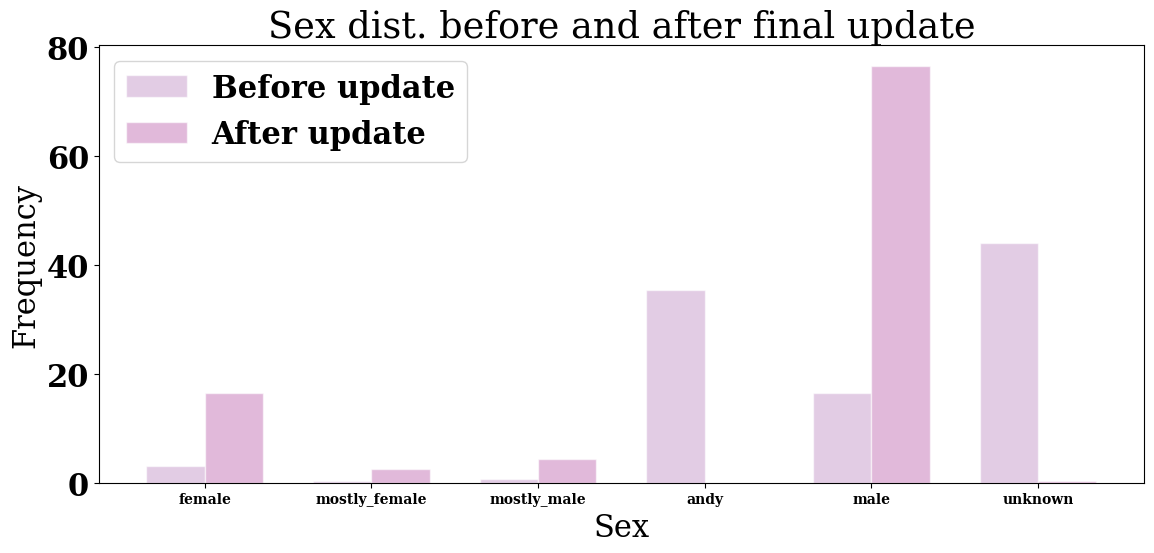

In [2982]:
#show the result of the fourth update compared to third update
cat_plot_compare(article_author_data.predicted_gender, article_author_data_clean_update_fifth.predicted_gender, title='Sex dist. before and after final update', xlabel='Sex', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='duplicatenameupdategenderdistcleanfifth', label1='Before update', label2='After update')


In [ ]:
#put numbers on bars on this plot 

In [275]:
#let's check if the ratio between male and female has changed before and after update 
prct_gender_preupdate=article_author_data.predicted_gender.value_counts(normalize=True).mul(100)
prct_gender_postupdate=article_author_data_clean_update_fifth.predicted_gender.value_counts(normalize=True).mul(100)


In [280]:
male_preupdate=prct_gender_preupdate['male']+prct_gender_preupdate['mostly_male']
male_postupdate=prct_gender_postupdate['male']+prct_gender_postupdate['mostly_male']

In [281]:
female_preupdate=prct_gender_preupdate['female']+prct_gender_preupdate['mostly_female']
female_postupdate=prct_gender_postupdate['female']+prct_gender_postupdate['mostly_female']

In [286]:
female_preupdate/male_preupdate*100

19.673476938730676

In [290]:
female_postupdate/male_postupdate*100 #so there is a little more female after the update than before which is fine 
# at least then we can say that it is not biased towards male. But the dist is somewhat similar anyways 

23.513444219738574

In [152]:
# now let's prove that the update is OK in terms of that the distribtuion of andy and unknown (pre-update) follows male+female on key points 

In [153]:
full_data_andy=article_author_data[article_author_data['predicted_gender']=='andy']
full_data_unknown=article_author_data[article_author_data['predicted_gender']=='unknown']
full_data_gendered=article_author_data[article_author_data['predicted_gender'].isin(['male', 'female', 'mostly_female', 'mostly_male'])]

In [156]:
full_data_gendered.predicted_gender.value_counts()

predicted_gender
male             330870
female            60308
mostly_male       15078
mostly_female      7752
Name: count, dtype: int64

In [157]:
full_data_gendered.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author.id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender'],
      dtype='object')

In [5487]:
#first let's select only 1 row per article_id
full_data_andy_article=full_data_andy.drop_duplicates(subset='article_id', keep='first')
full_data_unknown_article=full_data_unknown.drop_duplicates(subset='article_id', keep='first')
full_data_gendered_article=full_data_gendered.drop_duplicates(subset='article_id', keep='first')

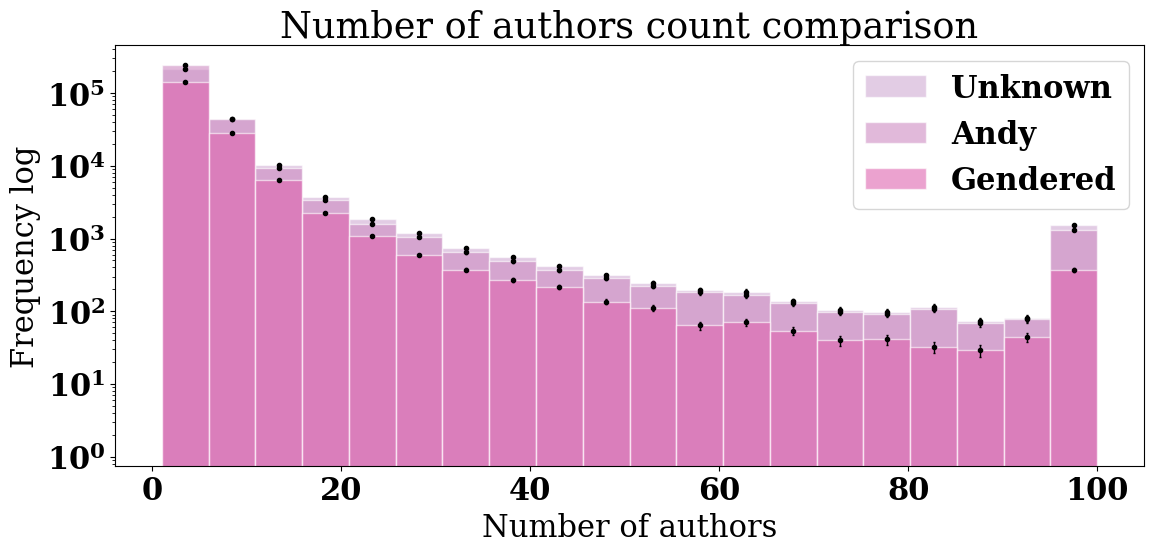

In [5503]:
# check on key point 1: authors per paper
hist_plot([full_data_unknown_article.total_author_counts, full_data_andy_article.total_author_counts, full_data_gendered_article.total_author_counts],  N_bins=None, log=True, title='Number of authors count comparison', xlabel='Number of authors', ylabel='Frequency log', save_name='compare_gender_dist_n_authors', legend_labels=['Unknown', 'Andy', 'Gendered'])


In [245]:
# check on key point 2: number of first, middle, last authors

In [5490]:

def cat_plot_compare(data1, data2, data3, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name=None, label1='Dataset 1', label2='Dataset 2', label3='Dataset 3'):
    """
    Create a categorical plot for given DataFrame columns for comparison.

    Parameters:
    - data1 (pd.Series): The first input DataFrame column.
    - data2 (pd.Series): The second input DataFrame column.
    - data3 (pd.Series): The third input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters then use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - label1 (str): Label for Dataset 1. Default is 'Dataset 1'.
    - label2 (str): Label for Dataset 2. Default is 'Dataset 2'.
    - label3 (str): Label for Dataset 3. Default is 'Dataset 3'.

    Returns:
    - None
    """
    # Merge data1, data2, and data3 to ensure all categories are represented
    merged_data = pd.merge(data1, pd.merge(data2, data3, how='outer', left_index=True, right_index=True, suffixes=('_df1', '_df2')), how='outer', left_index=True, right_index=True)

    # Assuming you want to plot the value counts of the 'publication_year' column for all three datasets
    value_counts1 = merged_data[data1.name + '_df1'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts2 = merged_data[data2.name + '_df2'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts3 = merged_data[data3.name].value_counts(normalize=norm).mul(multiply).reset_index()

    # Sort the value counts by category
    all_categories = set(value_counts1[data1.name + '_df1']).union(set(value_counts2[data2.name + '_df2'])).union(set(value_counts3[data3.name]))
    value_counts1 = value_counts1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    value_counts2 = value_counts2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()
    value_counts3 = value_counts3.set_index(data3.name).reindex(all_categories, fill_value=0).reset_index()

    count1 = value_counts1.iloc[:, 1]
    cats1 = value_counts1.iloc[:, 0]

    count2 = value_counts2.iloc[:, 1]
    cats2 = value_counts2.iloc[:, 0]

    count3 = value_counts3.iloc[:, 1]
    cats3 = value_counts3.iloc[:, 0]

    width = 0.25  # width of the bars

    # Get integer positions for each category
    cat_positions1 = range(len(cats1))
    cat_positions2 = [pos + width for pos in cat_positions1]
    cat_positions3 = [pos + width for pos in cat_positions2]

    fig, ax = plt.subplots()
    ax.bar(cat_positions1, count1, width, alpha=0.6, edgecolor='white', label=label1)
    ax.bar(cat_positions2, count2, width, alpha=0.6, edgecolor='white', label=label2)
    ax.bar(cat_positions3, count3, width, alpha=0.6, edgecolor='white', label=label3)

    plt.xticks([pos + width for pos in cat_positions1], cats1, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    save_path = f'Plots/{date.today()}/{str(save_name)}'
    plt.savefig(save_path)

    plt.show()



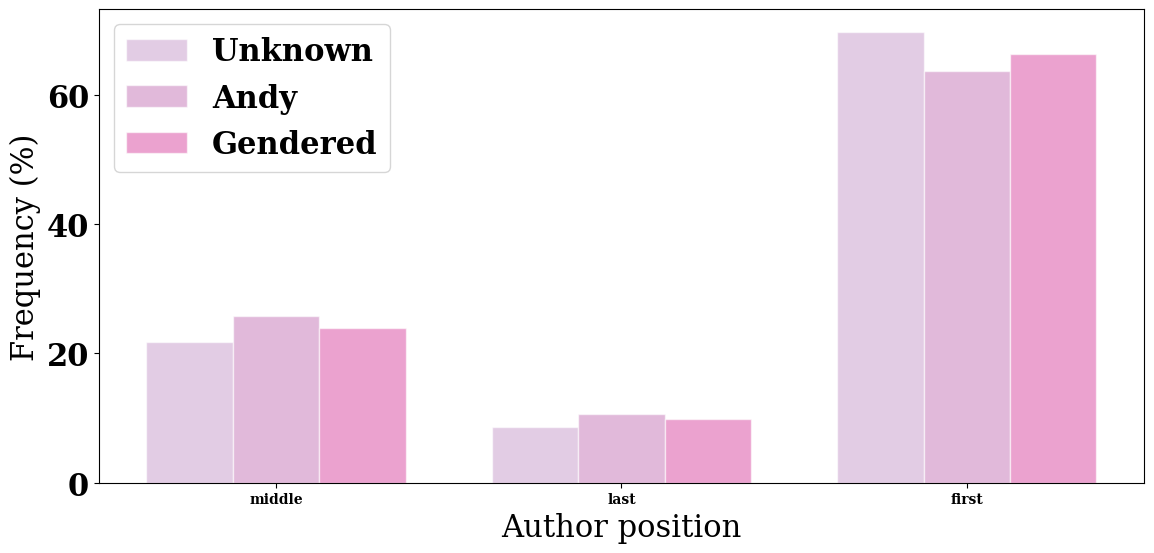

In [5504]:
cat_plot_compare(full_data_unknown_article.author_position, full_data_andy_article.author_position, full_data_gendered_article.author_position, title=None, xlabel='Author position', ylabel='Frequency (%)', norm=True, multiply=100, font=None, rot=0, xmargins=None, save_name='compare_gender_dist_posi', label1='Unknown', label2='Andy', label3='Gendered')


In [5492]:
def cat_plot_compare_year(data1, data2, data3, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name=None, label1='Dataset 1', label2='Dataset 2', label3='Dataset 3'):
    """
    Create a categorical plot for given DataFrame columns for comparison.

    Parameters:
    - data1 (pd.Series): The first input DataFrame column.
    - data2 (pd.Series): The second input DataFrame column.
    - data3 (pd.Series): The third input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters then use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - label1 (str): Label for Dataset 1. Default is 'Dataset 1'.
    - label2 (str): Label for Dataset 2. Default is 'Dataset 2'.
    - label3 (str): Label for Dataset 3. Default is 'Dataset 3'.

    Returns:
    - None
    """
    # Merge data1, data2, and data3 to ensure all categories are represented
    merged_data = pd.merge(data1, pd.merge(data2, data3, how='outer', left_index=True, right_index=True, suffixes=('_df1', '_df2')), how='outer', left_index=True, right_index=True)

    # Assuming you want to plot the value counts of the 'publication_year' column for all three datasets
    value_counts1 = merged_data[data1.name + '_df1'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts2 = merged_data[data2.name + '_df2'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts3 = merged_data[data3.name].value_counts(normalize=norm).mul(multiply).reset_index()

    # Convert years to integers
    value_counts1[data1.name + '_df1'] = value_counts1[data1.name + '_df1'].astype(int)
    value_counts2[data2.name + '_df2'] = value_counts2[data2.name + '_df2'].astype(int)
    value_counts3[data3.name] = value_counts3[data3.name].astype(int)

    # Sort the value counts by category
    all_categories = set(value_counts1[data1.name + '_df1']).union(set(value_counts2[data2.name + '_df2'])).union(set(value_counts3[data3.name]))
    value_counts1 = value_counts1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    value_counts2 = value_counts2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()
    value_counts3 = value_counts3.set_index(data3.name).reindex(all_categories, fill_value=0).reset_index()

    count1 = value_counts1.iloc[:, 1]
    cats1 = value_counts1.iloc[:, 0]

    count2 = value_counts2.iloc[:, 1]
    cats2 = value_counts2.iloc[:, 0]

    count3 = value_counts3.iloc[:, 1]
    cats3 = value_counts3.iloc[:, 0]

    width = 0.25  # width of the bars

    # Get integer positions for each category
    cat_positions1 = range(len(cats1))
    cat_positions2 = [pos + width for pos in cat_positions1]
    cat_positions3 = [pos + width for pos in cat_positions2]

    fig, ax = plt.subplots()
    ax.bar(cat_positions1, count1, width, alpha=0.6, edgecolor='white', label=label1)
    ax.bar(cat_positions2, count2, width, alpha=0.6, edgecolor='white', label=label2)
    ax.bar(cat_positions3, count3, width, alpha=0.6, edgecolor='white', label=label3)

    plt.xticks([pos + width for pos in cat_positions1], cats1, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    save_path = f'Plots/{date.today()}/{str(save_name)}'
    plt.savefig(save_path)

    plt.show()



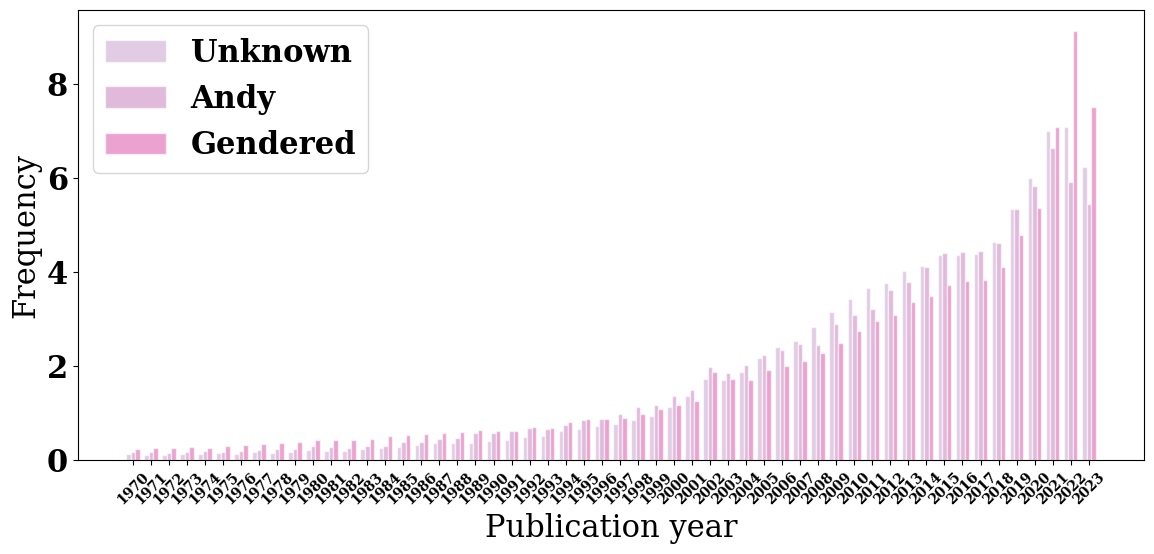

In [5505]:
# check on key point 3: per year 
cat_plot_compare_year(full_data_unknown_article.publication_year, full_data_andy_article.publication_year, full_data_gendered_article.publication_year, title=None, xlabel='Publication year', ylabel='Frequency', norm=True, multiply=100, font=None, rot=45, xmargins=None, save_name='compare_gender_dist_year', label1='Unknown', label2='Andy', label3='Gendered')


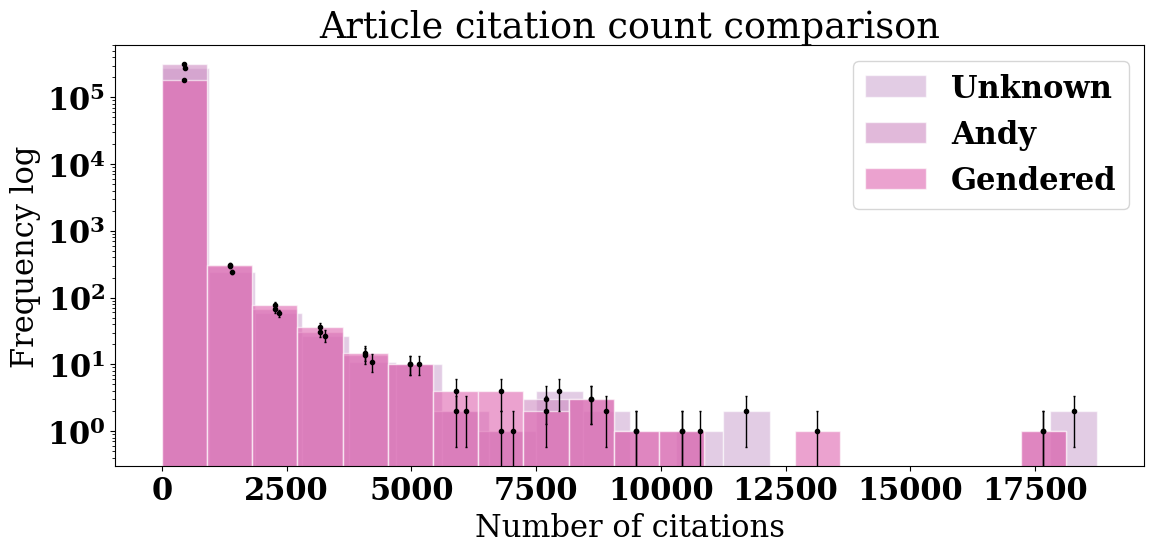

In [5506]:
# check on key point 4: cited_by_count

hist_plot([full_data_unknown_article.cited_by_count, full_data_andy_article.cited_by_count, full_data_gendered_article.cited_by_count], N_bins=None, log=True, title='Article citation count comparison', xlabel='Number of citations', ylabel='Frequency log', save_name='compare_gender_dist_cite', legend_labels=['Unknown', 'Andy', 'Gendered'])


In [5495]:
#let's check the difference between distribtuions with KS test 


# KS plot

In [5500]:
from matplotlib.patches import ConnectionPatch
from scipy import stats, optimize


def KS_2samp_plotter(data1, data2, zoom=True, label1 = 'Cumulative Data 1', label2 = 'Cumulative Data 2', save_name='test'):
    
    """
    INPUT:
    data1 = 1d arraylike, with data sample 1
    data2 = 1d arraylike, with data sample 2
    
    OUTPUT:
    ks_stat = ks statistics value from a two sample test comparing the two data sets
    pval = p value of KS test
    """
    
    # Get data stuff to be compatible (interpolate to same size) and make cdf array
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.sort( np.concatenate([data1, data2]) )
    cdf1 = np.searchsorted(data1, data_all, side='right')
    cdf2 = np.searchsorted(data2, data_all, side='right')

    # Create figure
    fig, ax = plt.subplots(nrows=2, figsize=(12,8), sharex=True, 
                       gridspec_kw = {'height_ratios': [1.5, 0.4], 'hspace': 0})
    
    # Plot the two cdfs
    ax[0].plot(data_all, cdf1, label=label1)
    ax[0].plot(data_all, cdf2, label=label2)
    ax[0].legend(loc='upper left', prop={"size":14} )
    
    # Calculate and plot residuals
    resi = cdf1 - cdf2
    ax[1].plot(np.sort(data_all), resi, color='k', linewidth=0.6, label='Residuals (Data1 - Data2)')
    ax[1].hlines(0, data_all[0], data_all[-1], linestyle='dashed', color='k')
    ax[1].legend(loc='lower left', prop={"size":12})
    
    # Plot zoom
    if zoom:
        
        # Create extra axis
        ax1 = fig.add_axes([0.65, 0.35, 0.2, 0.25]) # add_axes([x0, y0, width, height])
        ax1.plot(data_all, cdf1)
        ax1.plot(data_all, cdf2)
        
        # Find and supremum
        index = np.argmax(abs(resi))
    
        # Adjust limits
        if resi[index] > 0: # Data1 is highest at supremum
            ymin, ymax = cdf2[index] - resi[index], cdf1[index] + resi[index]
            
        if resi[index] < 0: # Data2 is highest at supremum
            ymin, ymax = cdf1[index] + resi[index], cdf2[index] - resi[index]
        
        xmin, xmax = data_all[index] - 0.05 * data_all[index], data_all[index] + 0.05 * data_all[index]
        
        ax1.set_xlim(xmin, xmax)
        ax1.set_ylim(ymin, ymax)
        
        # Mark supremum
        supremum = ConnectionPatch(xyA=(data_all[index], cdf1[index]), xyB=(data_all[index], cdf2[index]), coordsA=ax1.transData, 
                           arrowstyle='<->', color='k')
        fig.add_artist(supremum)

        ax1.set_title('$D_n = sup_x |F_n(x)-F(x)| $', color='k', fontsize=14)
        
        # Add zoom lines
        con1 = ConnectionPatch(xyA=(xmin, ymin), coordsA=ax[0].transData, xyB=(xmin, ymin), coordsB=ax1.transData, alpha=0.3)
        con2 = ConnectionPatch(xyA=(xmax, ymax), coordsA=ax[0].transData, xyB=(xmax,ymax), coordsB=ax1.transData, alpha=0.3)

        sq1 = ConnectionPatch(xyA=(xmin, ymin), xyB=(xmax, ymin), coordsA=ax[0].transData, alpha=0.3)
        sq2 = ConnectionPatch(xyA=(xmin, ymax), xyB=(xmax, ymax), coordsA=ax[0].transData, alpha=0.3)
        sq3 = ConnectionPatch(xyA=(xmin, ymin), xyB=(xmin, ymax), coordsA=ax[0].transData, alpha=0.3)
        sq4 = ConnectionPatch(xyA=(xmax, ymin), xyB=(xmax, ymax), coordsA=ax[0].transData, alpha=0.3)

        #fig.add_artist(con1)
        #fig.add_artist(con2)
        #fig.add_artist(sq1)
        #fig.add_artist(sq2)
        #fig.add_artist(sq3)
        #fig.add_artist(sq4)
        
    # Perform ks test
    ks_stat, pval = stats.kstest(data1, data2, alternative='two-sided' )

    # Adding fit results to plot:
    d = {'KS stat':     ks_stat, 'Prob':     pval,}
    
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.02, 0.82, text, ax[0], fontsize=14)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)

    plt.show()
    
    return ks_stat, pval

In [363]:
def format_value(value, decimals):
    """ 
    Checks the type of a variable and formats it accordingly.
    Floats has 'decimals' number of decimals.
    """
    
    if isinstance(value, (float, float)):
        return f'{value:.{decimals}f}'
    elif isinstance(value, (int, np.integer)):
        return f'{value:d}'
    else:
        return f'{value}'


In [364]:
def values_to_string(values, decimals):
    """ 
    Loops over all elements of 'values' and returns list of strings
    with proper formating according to the function 'format_value'. 
    """
    
    res = []
    for value in values:
        if isinstance(value, list):
            tmp = [format_value(val, decimals) for val in value]
            res.append(f'{tmp[0]} +/- {tmp[1]}')
        else:
            res.append(format_value(value, decimals))
    return res

In [365]:
def len_of_longest_string(s):
    """ Returns the length of the longest string in a list of strings """
    return len(max(s, key=len))

In [366]:
def nice_string_output(d, extra_spacing=5, decimals=5):
    """ 
    Takes a dictionary d consisting of names and values to be properly formatted.
    Makes sure that the distance between the names and the values in the printed
    output has a minimum distance of 'extra_spacing'. One can change the number
    of decimals using the 'decimals' keyword.  
    """
    
    names = d.keys()
    max_names = len_of_longest_string(names)
    
    values = values_to_string(d.values(), decimals=decimals)
    max_values = len_of_longest_string(values)
    
    string = ""
    for name, value in zip(names, values):
        spacing = extra_spacing + max_values + max_names - len(name) - 1 
        string += "{name:s} {value:>{spacing}} \n".format(name=name, value=value, spacing=spacing)
    return string[:-2]

In [367]:
def add_text_to_ax(x_coord, y_coord, string, ax, fontsize=12, color='k'):
    """ Shortcut to add text to an ax with proper font. Relative coords."""
    ax.text(x_coord, y_coord, string, family='monospace', fontsize=fontsize,
            transform=ax.transAxes, verticalalignment='top', color=color)
    return None

In [368]:
#let's replace categorical data values with numeric values 
mapping_dict = {'female': 1.0, 'mostly_female': 1.0, 'male': 2.0, 'mostly_male': 2.0, 'andy': 3.0, 'unknown': 4.0}


In [369]:
article_author_data['predicted_gender_num'] = article_author_data['predicted_gender'].replace(mapping_dict)
article_author_data_clean_update_fifth['predicted_gender_num'] = article_author_data_clean_update_fifth['predicted_gender'].replace(mapping_dict)


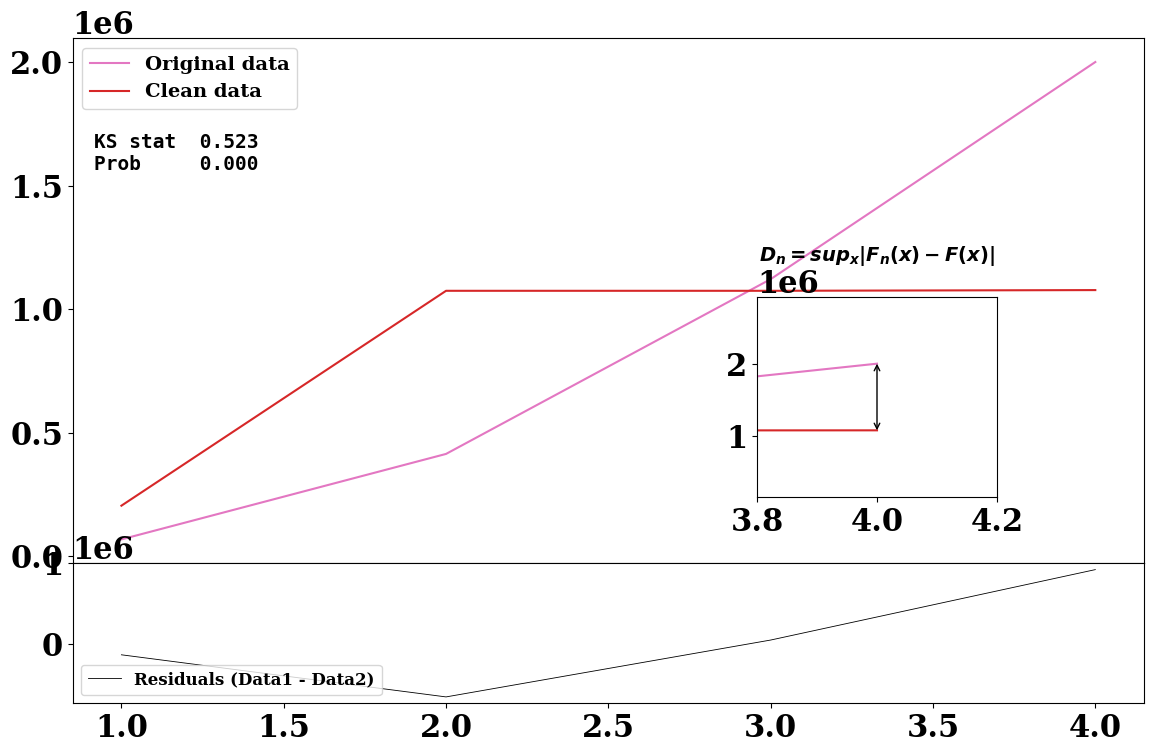

(0.5229579295839809, 0.0)

In [370]:
KS_2samp_plotter(article_author_data.predicted_gender_num, article_author_data_clean_update_fifth.predicted_gender_num, zoom=True, label1 = 'Original data', label2 = 'Clean data')

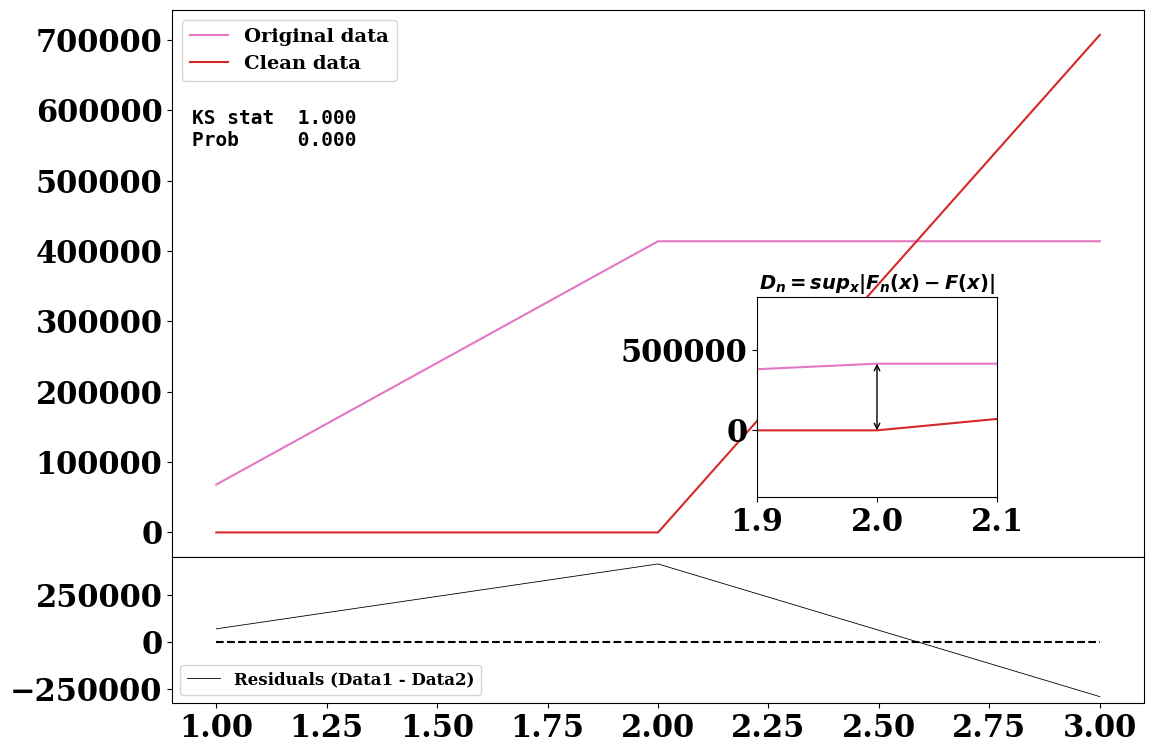

(1.0, 0.0)

In [376]:
KS_2samp_plotter(article_author_data.predicted_gender_num[article_author_data['predicted_gender_num'].isin([1,2])], article_author_data.predicted_gender_num[article_author_data['predicted_gender_num'].isin([3])], zoom=True, label1 = 'Original data', label2 = 'Clean data')







In [407]:
#let's use sample data to test the KS-test function
# Sample data arrays
data1 = np.random.normal(loc=0, scale=1, size=1000)
data2 = np.random.normal(loc=0, scale=1, size=1000)

# Optionally, you can add a categorical variable to one of the datasets
# This is just an example; replace it with your own data
categories = np.random.choice(['A', 'B'], size=1000)
data2_with_categories = np.where(categories == 'A', np.random.normal(loc=0.5, scale=1.2, size=1000), np.random.normal(loc=1.5, scale=0.8, size=1000))

# If you want to test KS test between two datasets with different categorical mappings
# Replace 'A' and 'B' with your actual category labels
data1_categorical = np.random.choice(['A', 'B'], size=1000)
data2_categorical = np.random.choice(['A', 'B'], size=1000)


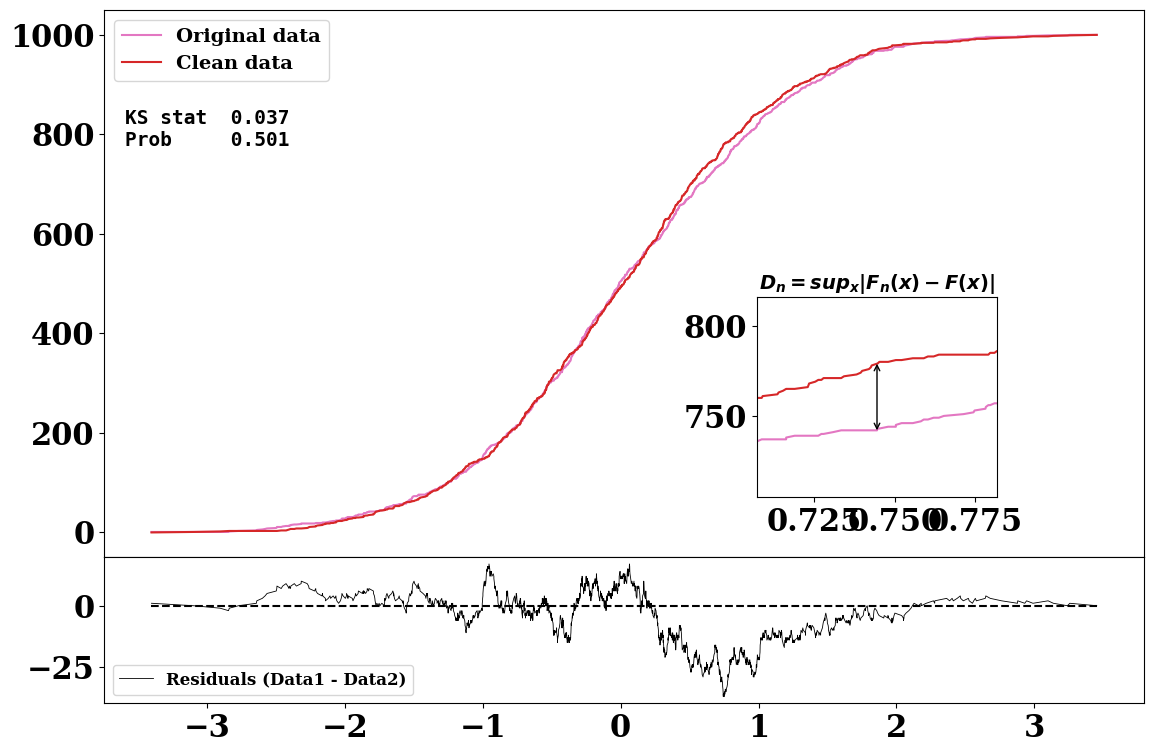

(0.037, 0.5005673707894058)

In [408]:
KS_2samp_plotter(data1, data2, zoom=True, label1 = 'Original data', label2 = 'Clean data')


In [409]:
#large p-value: there is not enough evidence to conclude that the two samples come from different distributions
#small p-value: there is enough evidence to conclude that the two samples come from different distributions

In [430]:
#let's try with the get dummies method instead 
gender_dict = {'female': 'gendered', 'male': 'gendered', 'mostly_female': 'gendered', 'mostly_male': 'gendered'}
article_author_data['predicted_gender_tot'] = article_author_data['predicted_gender'].replace(gender_dict)

KS_data_andy=article_author_data[article_author_data['predicted_gender_tot']!='unknown']
KS_data_unknown=article_author_data[article_author_data['predicted_gender_tot']!='andy']

In [431]:
KS_data_andy=pd.get_dummies(KS_data_andy.predicted_gender_tot, dtype=float)
KS_data_andy

andy  gendered
0         1.0       0.0
4         0.0       1.0
5         1.0       0.0
6         1.0       0.0
7         0.0       1.0
...       ...       ...
2000275   0.0       1.0
2000276   0.0       1.0
2000277   1.0       0.0
2000279   1.0       0.0
2000280   1.0       0.0

[1121406 rows x 2 columns]

In [432]:
KS_data_unknown=pd.get_dummies(KS_data_unknown.predicted_gender_tot, dtype=float)
KS_data_unknown

gendered  unknown
1             0.0      1.0
2             0.0      1.0
3             0.0      1.0
4             1.0      0.0
7             1.0      0.0
...           ...      ...
2000273       1.0      0.0
2000274       1.0      0.0
2000275       1.0      0.0
2000276       1.0      0.0
2000278       0.0      1.0

[1292883 rows x 2 columns]

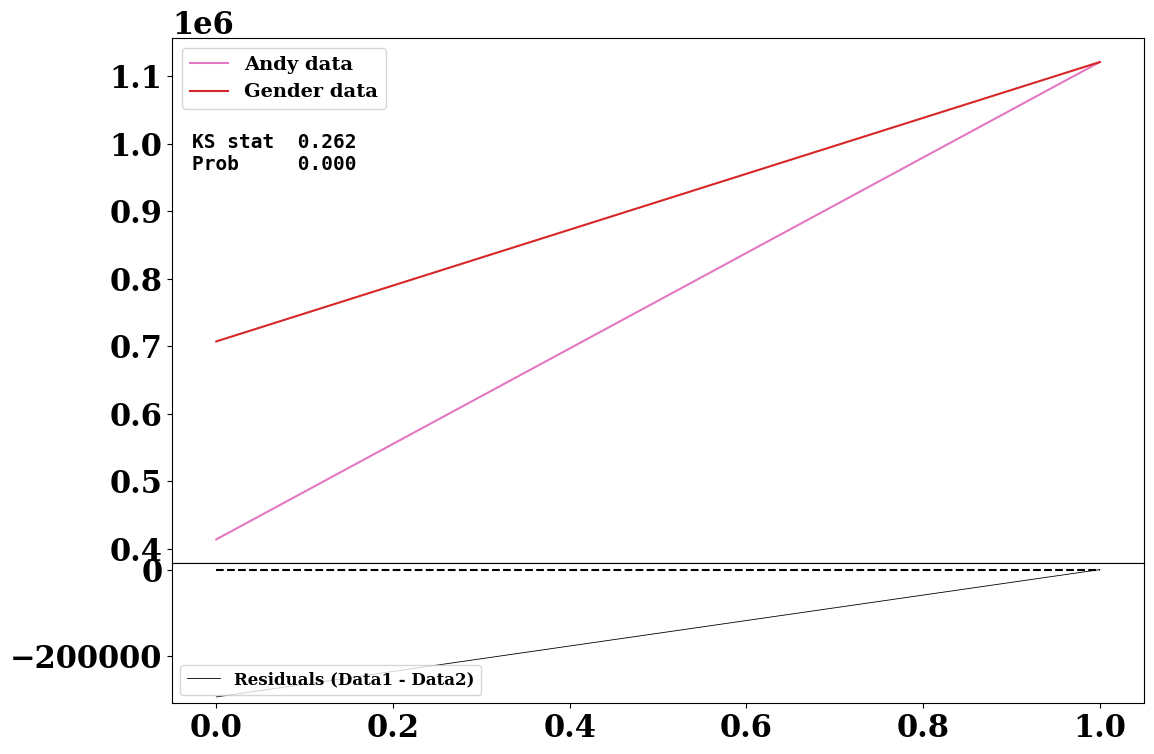

(0.2616269219176641, 0.0)

In [437]:
KS_2samp_plotter(KS_data_andy.andy, KS_data_andy.gendered, zoom=False, label1 = 'Andy data', label2 = 'Gender data')


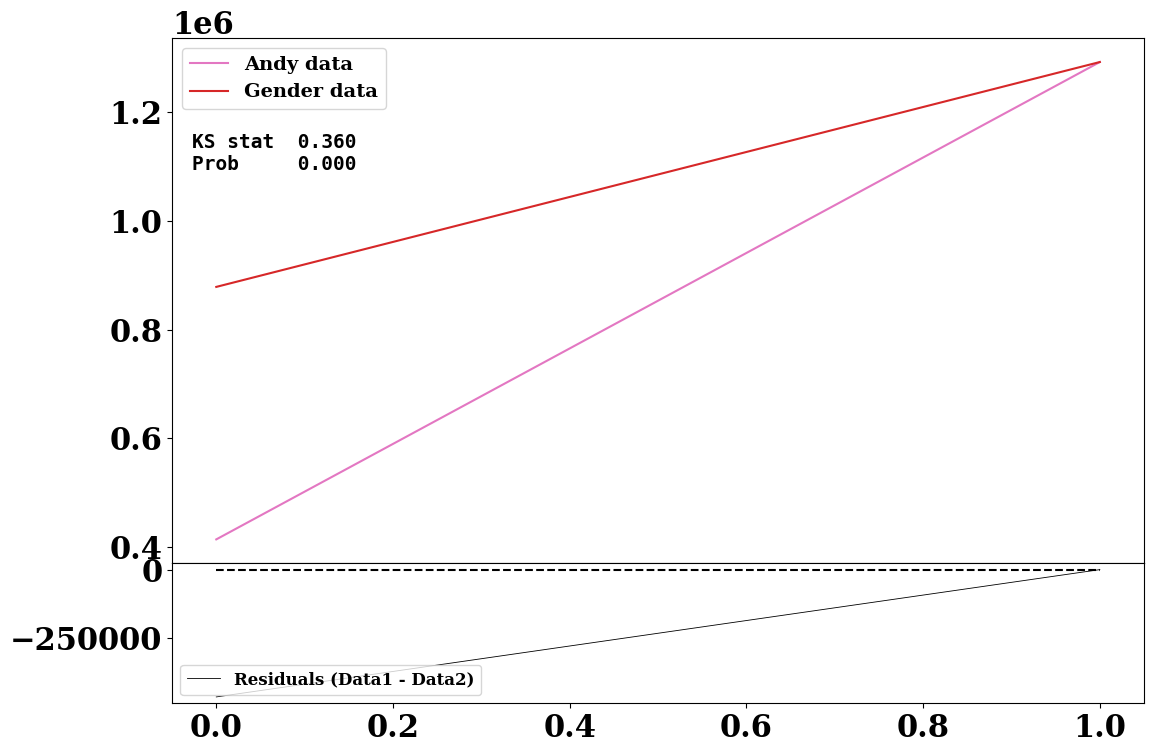

(0.3595584441902322, 0.0)

In [438]:
KS_2samp_plotter(KS_data_unknown.unknown, KS_data_unknown.gendered, zoom=False, label1 = 'Andy data', label2 = 'Gender data')


In [442]:
full_data_andy_article.author_position

0          first
5          first
12         first
21          last
30         first
           ...  
2000252    first
2000255    first
2000263    first
2000265    first
2000277    first
Name: author_position, Length: 311538, dtype: object

In [445]:
full_data_gendered_article.author_position

4          first
7          first
9          first
15         first
22         first
           ...  
2000268     last
2000270    first
2000271    first
2000272    first
2000276    first
Name: author_position, Length: 183385, dtype: object

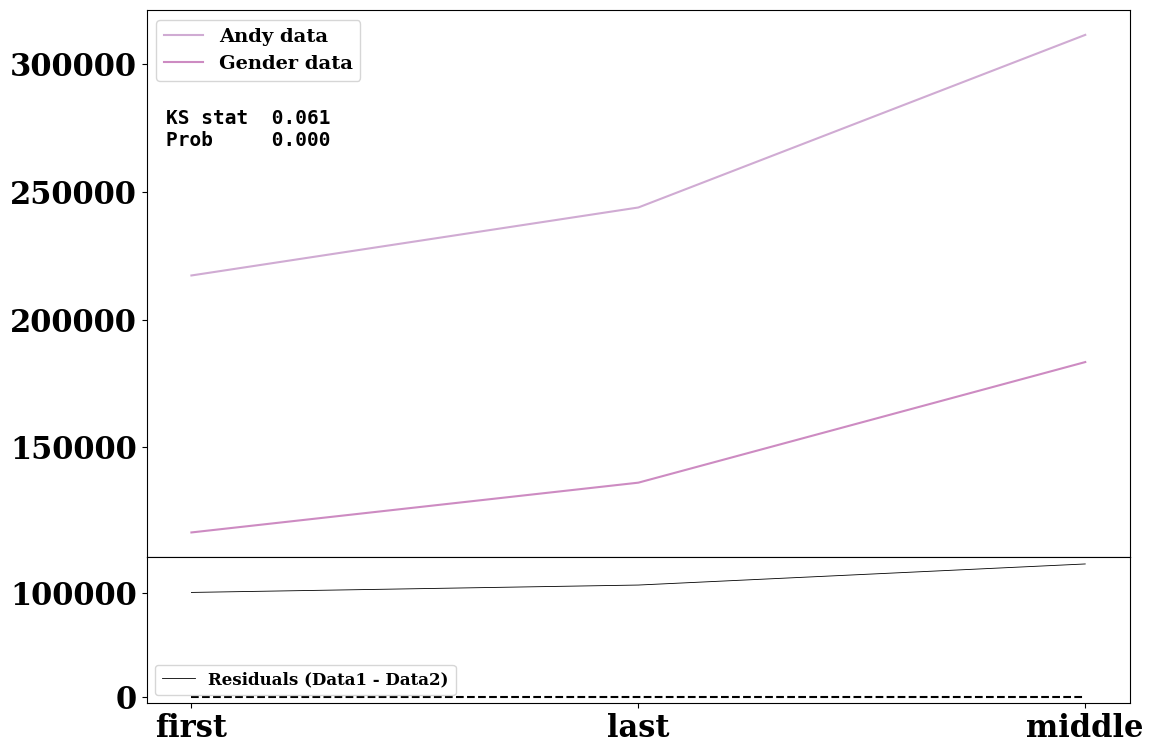

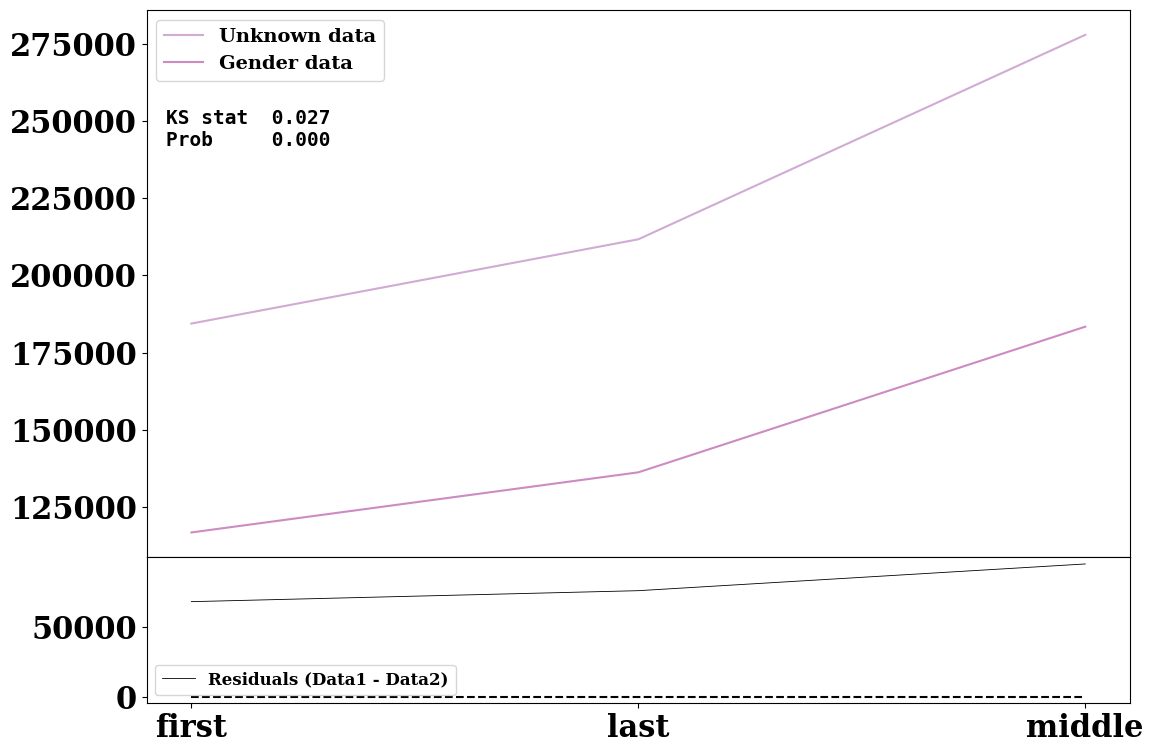

(0.02714969453693694, 3.4324909332392655e-71)

In [5502]:
#let's try to use KS test on key dist.. We start with author position 
#we compare author position distribution between andy on original data and andy on clean data 
KS_2samp_plotter(full_data_andy_article.author_position, full_data_gendered_article.author_position, zoom=False, label1 = 'Andy data', label2 = 'Gender data')

#similar for unknown and gendered 
KS_2samp_plotter(full_data_unknown_article.author_position, full_data_gendered_article.author_position, zoom=False, label1 = 'Unknown data', label2 = 'Gender data')

#I see - the two datasets are of different length - find a way to work around this 

In [ ]:
#let's wait until we have talked to supervisors 

# Analysis clean data

In [115]:
article_author_data_original=article_author_data
article_author_data_final=article_author_data_clean_update_fifth

In [116]:
#let's save this data version so that we can import it later 
with open('OpenAlex Data/Unify2024/05032024OriginalData.pkl', 'wb') as f:
    pickle.dump(article_author_data_original, f)


In [117]:
#let's save this data version so that we can import it later 
with open('OpenAlex Data/Unify2024/05032024FinalData.pkl', 'wb') as f:
    pickle.dump(article_author_data_final, f)


In [ ]:
#VERIFY
len(article_author_data_original)
len(article_author_data_final)

In [5458]:
len(article_author_data_original)
len(article_author_data_final)

1471771

In [5459]:
save_name='article_author_data_final'

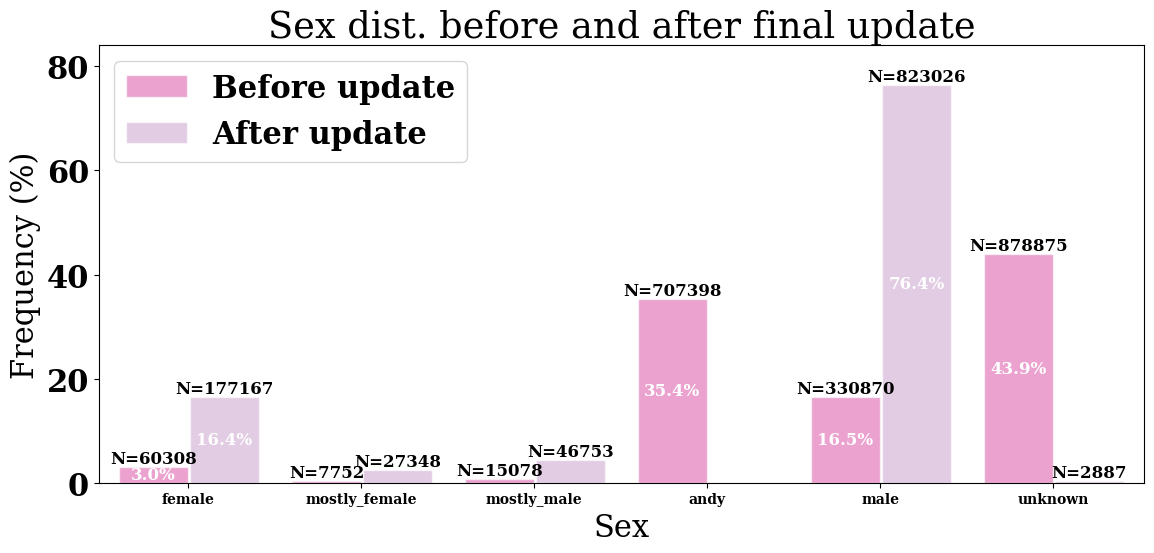

In [5461]:
cat_plot_compare(article_author_data_original.predicted_gender, article_author_data_final.predicted_gender, title='Sex dist. before and after final update', xlabel='Sex', ylabel='Frequency (%)', norm=True, multiply=100, font=font, rot=0, xmargins=0.02, ymargins=0.1, save_name='duplicatenameupdategenderdistcleanfifth', label1='Before update', label2='After update')


In [152]:
# now let's prove that the update is OK in terms of that the distribtuion of andy and unknown (pre-update) follows male+female on key points 

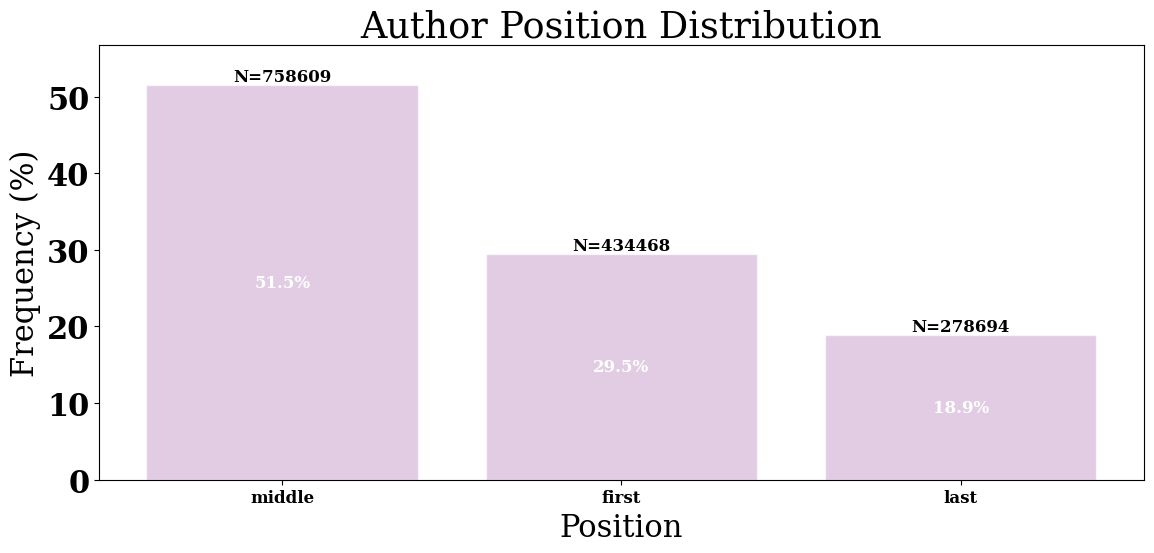

In [5464]:
cat_plot(article_author_data_final.author_position, title='Author Position Distribution', xlabel='Position', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None, ymargins=0.1, save_name=save_name)


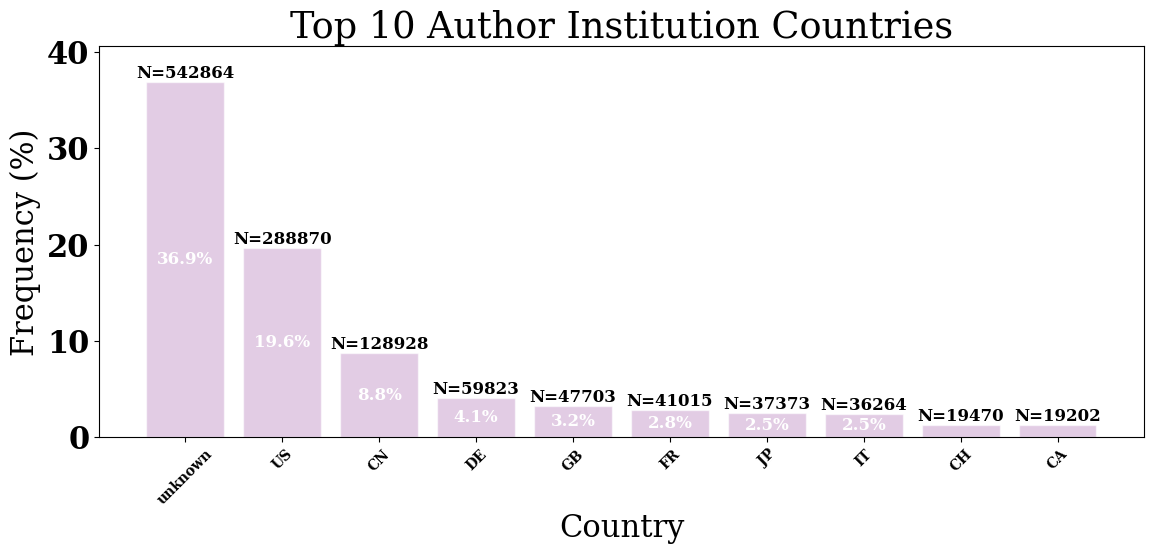

In [5480]:
cat_top_plot(article_author_data_final.institution_country_code, top_n=10, title='Top 10 Author Institution Countries', xlabel='Country', ylabel='Frequency (%)', norm=True, multiply=100, rot=45, xmargins=None, ymargins=0.1, save_name=save_name)


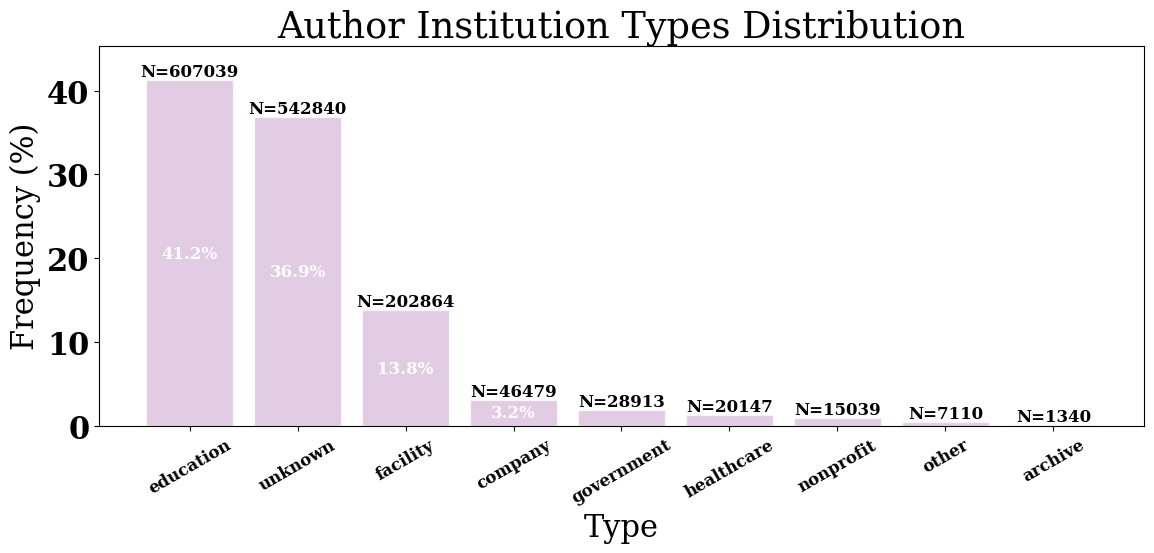

In [5206]:
cat_plot(article_author_data_final.institution_type, title='Author Institution Types Distribution', xlabel='Type', ylabel='Frequency (%)', norm=True, multiply=100, rot=30, ymargins=0.1, save_name=save_name)


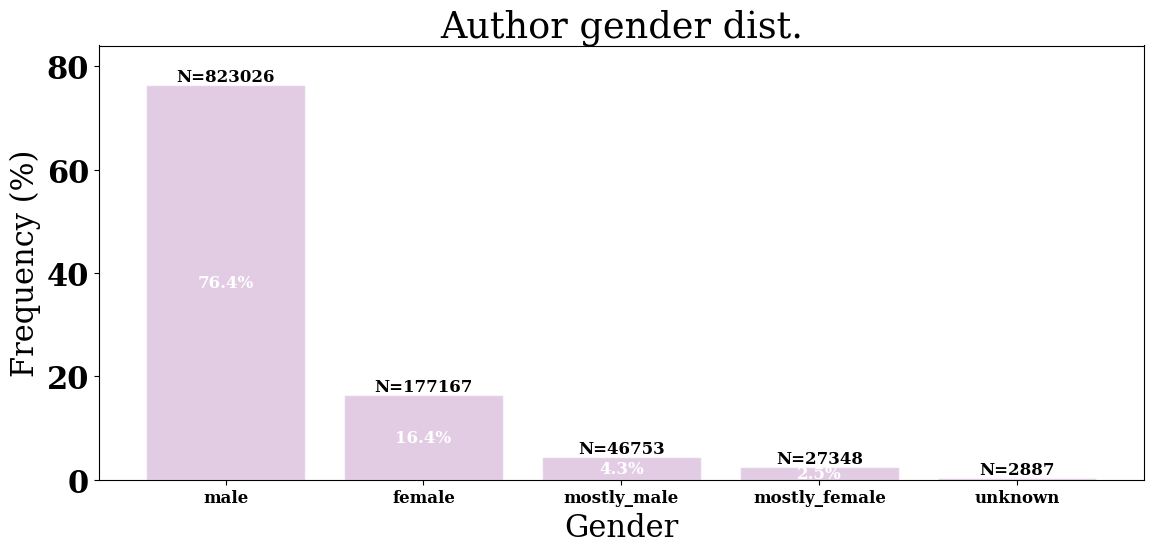

In [2973]:
cat_plot(article_author_data_final.predicted_gender, title='Author gender dist.', xlabel='Gender', ylabel='Frequency (%)', ymargins=0.1, norm=True, multiply=100, rot=0, save_name=save_name)


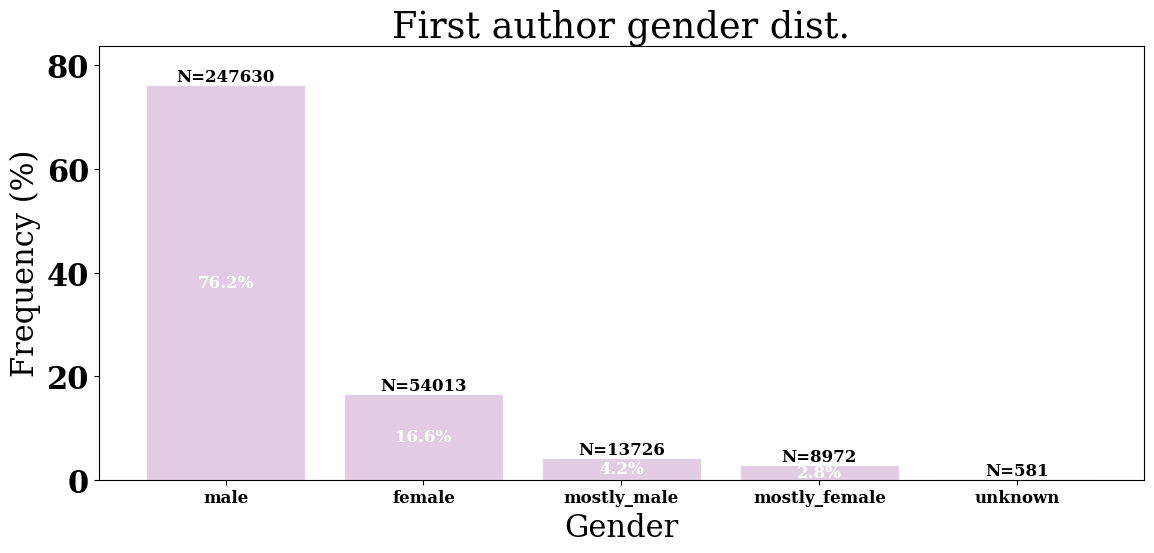

In [5468]:
cat_plot(article_author_data_final[article_author_data_final.author_position=='first'].predicted_gender, title='First author gender dist.', xlabel='Gender', ylabel='Frequency (%)', ymargins=0.1, norm=True, multiply=100, rot=0, save_name=save_name)


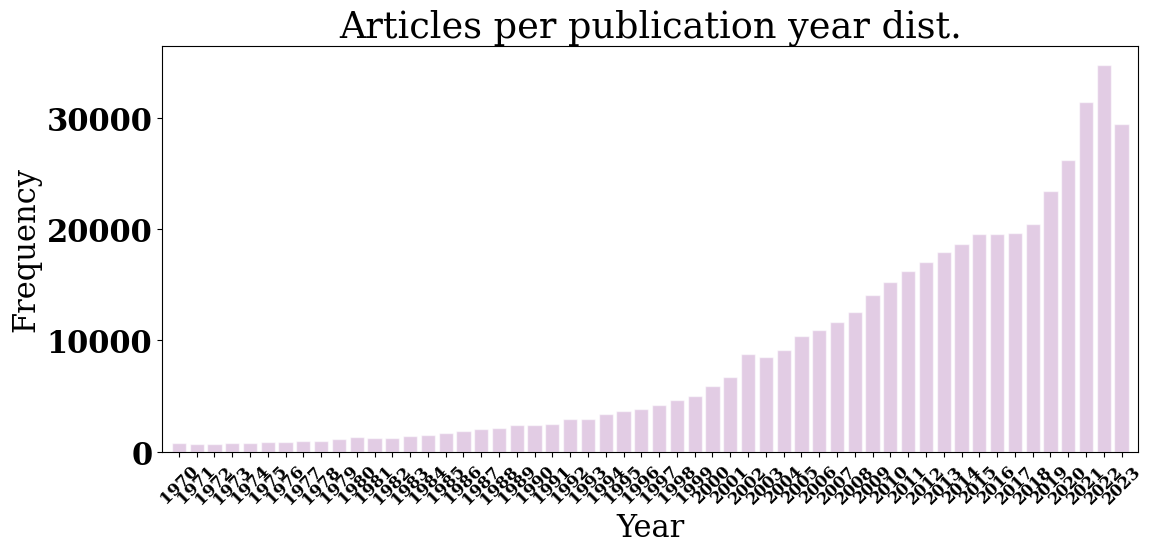

In [2993]:
cat_plot(article_author_data_final.drop_duplicates(subset=['article_id'], keep='first').publication_year, title='Articles per publication year dist.', xlabel='Year', ylabel='Frequency', xmargins=0.01, norm=False, multiply=1, rot=45, save_name=save_name)


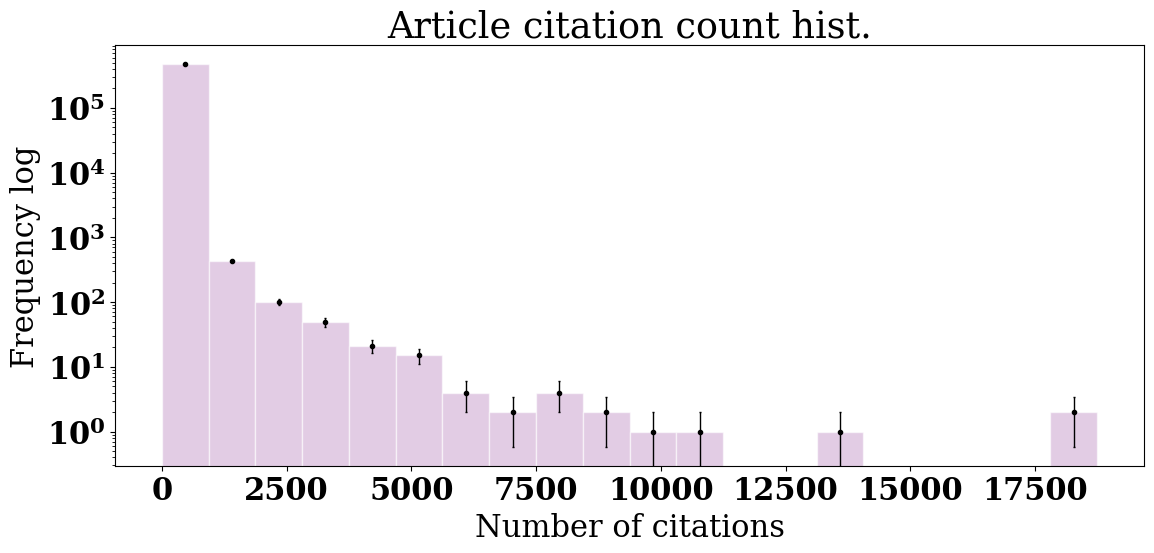

In [3012]:
hist_plot([article_author_data_final.drop_duplicates(subset=['article_id'], keep='first').cited_by_count], N_bins=None, log=True, title='Article citation count hist.', xlabel='Number of citations', ylabel='Frequency log', save_name=save_name, disp_legend=False)


In [5485]:
#define short names outside plotting function 
data_cats=article_author_data_final.drop_duplicates(subset=['article_id'], keep='first').journal_name.value_counts().reset_index()[0:20]
data_cats = data_cats.iloc[:, 0]

excluded_words = ['THE', 'OF']
short_names = []

def extract_first_letters(words):
    short_name = ''
    skip_next = False
    
    for word in words:
        if skip_next:
            skip_next = ')' not in word
        elif '(' in word:
            skip_next = ')' not in word
        else:
            short_name += word[0]

    return short_name

for cat in data_cats:
    words = [word.upper() for word in cat.split() if word.upper() not in excluded_words]
    unique_short_name = extract_first_letters(words)
    
    # Check for duplicates and add a unique identifier
    count = short_names.count(unique_short_name)
    if count > 0:
        unique_short_name += str(count + 1)
    
    short_names.append(unique_short_name)

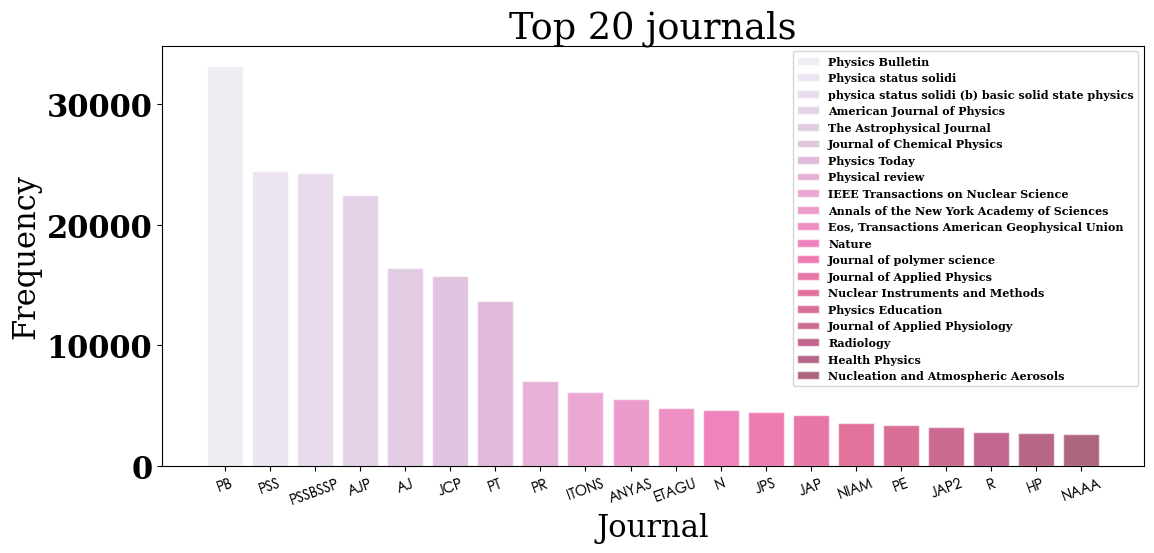

In [5486]:
cat_top_plot_short_names(article_author_data_final.drop_duplicates(subset=['article_id'], keep='first').journal_name, top_n=20, title='Top 20 journals', xlabel='Journal', ylabel='Frequency', norm=False, multiply=1, font='Heiti TC', rot=20, save_name=save_name)


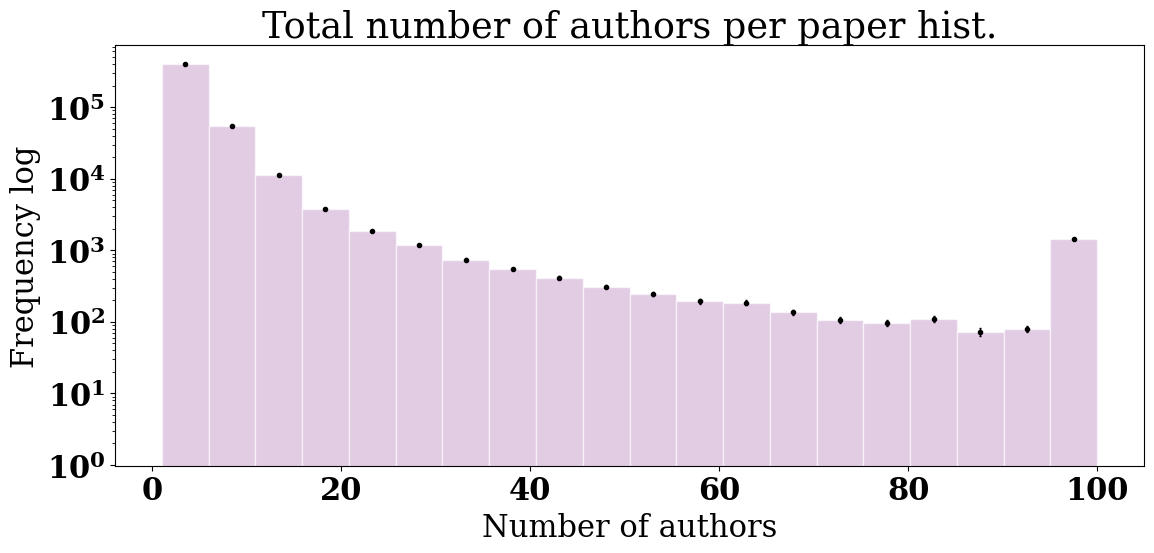

In [3156]:
hist_plot([article_author_data_final.drop_duplicates(subset=['article_id'], keep='first').total_author_counts], log=True, title='Total number of authors per paper hist.', xlabel='Number of authors', ylabel='Frequency log', save_name=save_name, disp_legend=False)


949


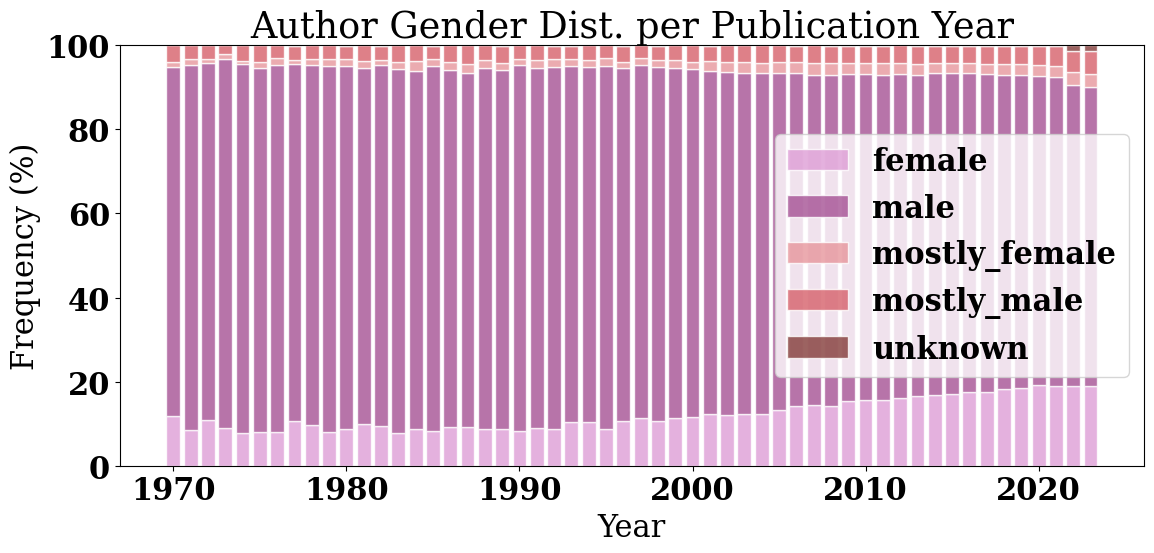

In [3290]:
#calculate gender dist per year 
gender_year_counts = article_author_data_final.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(gender_year_counts, 'publication_year', gender_year_counts.columns.difference(['publication_year']), title='Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)', save_name=save_name)


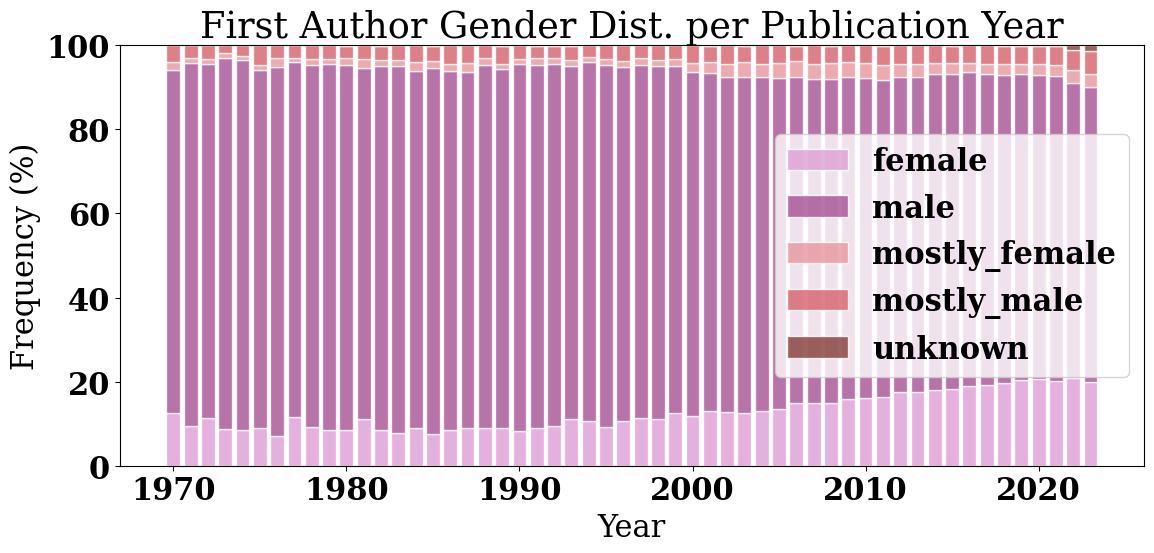

In [3268]:
#calculate gender dist per year 
first_author_gender_year_counts = article_author_data_final[article_author_data_final.author_position=='first'].groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(first_author_gender_year_counts, 'publication_year', gender_year_counts.columns.difference(['publication_year']), title='First Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)', save_name=save_name)


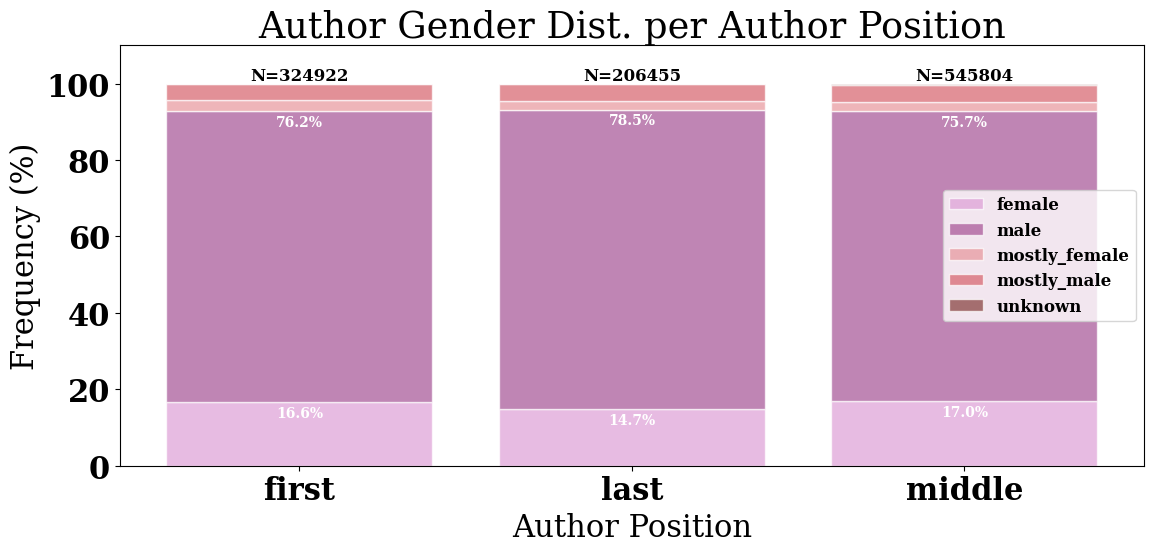

In [5165]:
gender_position_counts=article_author_data_final.groupby(['author_position', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

stacked_bar_plot_normalized(gender_position_counts, 'author_position', gender_position_counts.columns.difference(['author_position']), title='Author Gender Dist. per Author Position', xlabel='Author Position', ylabel='Frequency (%)', ymargins=0.1, save_name=save_name)


In [ ]:
#HERTIL 

### Binary gender plots 

In [ ]:
#make the same plots but with female+mostly_female and male+mostly_male in one 

### WORLD MAP PLOTTING 

In [1805]:
#calc percentage of country appearing
df_country_proportion=article_author_data_final.author_first_country.value_counts(normalize=True).mul(100).reset_index()
df_country_count=article_author_data_final.author_first_country.value_counts(normalize=False).reset_index()

In [1804]:
df_country=pd.merge(df_country_proportion, df_country_count, on='author_first_country')


In [1808]:
df_country.author_first_country.nunique()-2

189

In [1809]:
df_country

author_first_country  proportion   count
0                unknown   24.158854  355563
1                     US   23.077367  339646
2                     CN   10.015281  147402
3                     DE    5.248643   77248
4                     GB    3.986354   58670
..                   ...         ...     ...
186                   CV    0.000068       1
187                   TG    0.000068       1
188                   AG    0.000068       1
189                   GW    0.000068       1
190                   HT    0.000068       1

[191 rows x 3 columns]

In [1810]:
# generate country code for map plotting 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(alpha_2=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df_country['map_code']=alpha3code(df_country.author_first_country)


In [1811]:
#import world dataset
world = gpd.read_file('ne_110m_admin_0_countries.shx')


In [1812]:
world = world[['ADMIN', 'ISO_A3', 'GU_A3', 'CONTINENT',  'geometry']] 
world.columns=['map_name', 'map_code', 'GU_A3', 'continent',  'geometry']


In [1813]:
world['map_code'][world['map_code']=='-99']=world['GU_A3']

In [1814]:
missing_country=df_country[~df_country['map_code'].isin(world['map_code'])]
#DO NOT THINK WE NEED TO COPY THIS 

In [1815]:
missing_country

author_first_country  proportion   count map_code
0                unknown   24.158854  355563     None
26                    SG    0.389395    5731      SGP
56                    VG    0.074468    1096      VGB
65                    HK    0.037642     554      HKG
96                    MT    0.009037     133      MLT
113                   MO    0.002922      43      MAC
119                   BH    0.002174      32      BHR
124                   RE    0.001970      29      REU
130                   MU    0.001359      20      MUS
134                   MC    0.001223      18      MCO
139                   XK    0.001019      15     None
147                   BB    0.000747      11      BRB
155                   BM    0.000408       6      BMU
156                   VA    0.000408       6      VAT
158                   FO    0.000340       5      FRO
162                   LI    0.000340       5      LIE
165                   SJ    0.000272       4      SJM
167                   GP    0.000204       3      GLP
169                   CW    0.000204       3      CUW
170                   MS    0.000204       3      MSR
171                   MQ    0.000204       3      MTQ
172                   DM    0.000136       2      DMA
174                   KY    0.000136       2      CYM
176                   GD    0.000136       2      GRD
177                   GU    0.000136       2      GUM
178                   GF    0.000136       2      GUF
179                   PW    0.000136       2      PLW
183                   ST    0.000068       1      STP
185                   PF    0.000068       1      PYF
186                   CV    0.000068       1      CPV
188                   AG    0.000068       1      ATG

In [1816]:
article_author_data_final.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country', 'name_gender_api', 'gender_gender_api',
       'predicted_gender_num'],
      dtype='object')

In [1817]:
#we are missing some countries on the world map
missing_country=article_author_data_final[['author_first_country','author_country_name']][article_author_data_final['author_first_country'].isin([missing_country['author_first_country'].to_list()[i] for i in range(len(missing_country))])].value_counts().reset_index()


# DO NOT THINK WE NEED TO COPY THIS 


In [1818]:
missing_country

author_first_country            author_country_name   count
0               unknown                other_countries  355563
1                    SG                      singapore    5238
2                    VG        virgin islands, british    1028
3                    HK                      hong kong     517
4                    SG                other_countries     493
5                    MT                          malta     122
6                    VG                other_countries      68
7                    MO                          macao      42
8                    HK                other_countries      37
9                    BH                        bahrain      28
10                   RE                other_countries      20
11                   MU                      mauritius      18
12                   XK                other_countries      15
13                   MC                         monaco      14
14                   BB                       barbados      11
15                   MT                other_countries      11
16                   RE                        réunion       9
17                   VA  holy see (vatican city state)       6
18                   BM                        bermuda       6
19                   FO                  faroe islands       5
20                   BH                other_countries       4
21                   SJ         svalbard and jan mayen       4
22                   MC                other_countries       4
23                   CW                        curaçao       3
24                   MS                     montserrat       3
25                   LI                  liechtenstein       3
26                   GD                        grenada       2
27                   GU                           guam       2
28                   MQ                     martinique       2
29                   GF                  french guiana       2
30                   MU                other_countries       2
31                   PW                          palau       2
32                   LI                other_countries       2
33                   GP                other_countries       2
34                   KY                 cayman islands       2
35                   DM                       dominica       2
36                   GP                     guadeloupe       1
37                   CV                     cabo verde       1
38                   ST          sao tome and principe       1
39                   MQ                other_countries       1
40                   PF               french polynesia       1
41                   MO                other_countries       1
42                   AG            antigua and barbuda       1

In [1819]:
len(missing_country)

43

In [1820]:
world

map_name map_code GU_A3      continent  \
0                           Fiji      FJI   FJI        Oceania   
1    United Republic of Tanzania      TZA   TZA         Africa   
2                 Western Sahara      ESH   SAH         Africa   
3                         Canada      CAN   CAN  North America   
4       United States of America      USA   USA  North America   
..                           ...      ...   ...            ...   
172           Republic of Serbia      SRB   SRB         Europe   
173                   Montenegro      MNE   MNE         Europe   
174                       Kosovo      KOS   KOS         Europe   
175          Trinidad and Tobago      TTO   TTO  North America   
176                  South Sudan      SSD   SDS         Africa   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 5 columns]

In [1821]:
world=world.drop(columns=['GU_A3'])

In [1822]:
#what are we gonna do with "other_countries" 

In [1823]:
# let's get alpha 3 code for countries in missing countries 
missing_country['map_code']=alpha3code(missing_country.author_first_country)
#DO NOT THINK WE NEED TO COPY THIS 

In [1824]:
len(missing_country)

43

In [1825]:
missing_country

author_first_country            author_country_name   count map_code
0               unknown                other_countries  355563     None
1                    SG                      singapore    5238      SGP
2                    VG        virgin islands, british    1028      VGB
3                    HK                      hong kong     517      HKG
4                    SG                other_countries     493      SGP
5                    MT                          malta     122      MLT
6                    VG                other_countries      68      VGB
7                    MO                          macao      42      MAC
8                    HK                other_countries      37      HKG
9                    BH                        bahrain      28      BHR
10                   RE                other_countries      20      REU
11                   MU                      mauritius      18      MUS
12                   XK                other_countries      15     None
13                   MC                         monaco      14      MCO
14                   BB                       barbados      11      BRB
15                   MT                other_countries      11      MLT
16                   RE                        réunion       9      REU
17                   VA  holy see (vatican city state)       6      VAT
18                   BM                        bermuda       6      BMU
19                   FO                  faroe islands       5      FRO
20                   BH                other_countries       4      BHR
21                   SJ         svalbard and jan mayen       4      SJM
22                   MC                other_countries       4      MCO
23                   CW                        curaçao       3      CUW
24                   MS                     montserrat       3      MSR
25                   LI                  liechtenstein       3      LIE
26                   GD                        grenada       2      GRD
27                   GU                           guam       2      GUM
28                   MQ                     martinique       2      MTQ
29                   GF                  french guiana       2      GUF
30                   MU                other_countries       2      MUS
31                   PW                          palau       2      PLW
32                   LI                other_countries       2      LIE
33                   GP                other_countries       2      GLP
34                   KY                 cayman islands       2      CYM
35                   DM                       dominica       2      DMA
36                   GP                     guadeloupe       1      GLP
37                   CV                     cabo verde       1      CPV
38                   ST          sao tome and principe       1      STP
39                   MQ                other_countries       1      MTQ
40                   PF               french polynesia       1      PYF
41                   MO                other_countries       1      MAC
42                   AG            antigua and barbuda       1      ATG

In [1826]:
len(missing_country.map_code[missing_country['author_first_country']!='other_countries'].to_list())

43

In [1827]:
missing_country.map_code[missing_country['author_first_country']!='other_countries'].to_list()

['None',
 'SGP',
 'VGB',
 'HKG',
 'SGP',
 'MLT',
 'VGB',
 'MAC',
 'HKG',
 'BHR',
 'REU',
 'MUS',
 'None',
 'MCO',
 'BRB',
 'MLT',
 'REU',
 'VAT',
 'BMU',
 'FRO',
 'BHR',
 'SJM',
 'MCO',
 'CUW',
 'MSR',
 'LIE',
 'GRD',
 'GUM',
 'MTQ',
 'GUF',
 'MUS',
 'PLW',
 'LIE',
 'GLP',
 'CYM',
 'DMA',
 'GLP',
 'CPV',
 'STP',
 'MTQ',
 'PYF',
 'MAC',
 'ATG']

In [1828]:
missing_country

author_first_country            author_country_name   count map_code
0               unknown                other_countries  355563     None
1                    SG                      singapore    5238      SGP
2                    VG        virgin islands, british    1028      VGB
3                    HK                      hong kong     517      HKG
4                    SG                other_countries     493      SGP
5                    MT                          malta     122      MLT
6                    VG                other_countries      68      VGB
7                    MO                          macao      42      MAC
8                    HK                other_countries      37      HKG
9                    BH                        bahrain      28      BHR
10                   RE                other_countries      20      REU
11                   MU                      mauritius      18      MUS
12                   XK                other_countries      15     None
13                   MC                         monaco      14      MCO
14                   BB                       barbados      11      BRB
15                   MT                other_countries      11      MLT
16                   RE                        réunion       9      REU
17                   VA  holy see (vatican city state)       6      VAT
18                   BM                        bermuda       6      BMU
19                   FO                  faroe islands       5      FRO
20                   BH                other_countries       4      BHR
21                   SJ         svalbard and jan mayen       4      SJM
22                   MC                other_countries       4      MCO
23                   CW                        curaçao       3      CUW
24                   MS                     montserrat       3      MSR
25                   LI                  liechtenstein       3      LIE
26                   GD                        grenada       2      GRD
27                   GU                           guam       2      GUM
28                   MQ                     martinique       2      MTQ
29                   GF                  french guiana       2      GUF
30                   MU                other_countries       2      MUS
31                   PW                          palau       2      PLW
32                   LI                other_countries       2      LIE
33                   GP                other_countries       2      GLP
34                   KY                 cayman islands       2      CYM
35                   DM                       dominica       2      DMA
36                   GP                     guadeloupe       1      GLP
37                   CV                     cabo verde       1      CPV
38                   ST          sao tome and principe       1      STP
39                   MQ                other_countries       1      MTQ
40                   PF               french polynesia       1      PYF
41                   MO                other_countries       1      MAC
42                   AG            antigua and barbuda       1      ATG

In [1829]:
len(missing_country.author_first_country.value_counts())


31

In [1830]:
# Data for the rows to add for the world map 
add_country_data = {
    'map_name': ['Singapore', 'Virgin Islands, British', 'Hong Kong', 'Malta','Macao', 'Bahrain', 'Mauritius', 'Monaco','Barbados','Réunion',
                 'Holy See (Vatican City State)','Bermuda','Martinique','French Guiana','Faroe Islands','Guadeloupe','Svalbard and Jan Mayen',
                 'Liechtenstein','Montserrat','Palau','Curaçao','Dominica','Cayman Islands','Grenada','Guam','French Polynesia','Cabo Verde',
                 'Sao Tome And Principe','Antigua And Barbuda'],
    'map_code': ['SGP', 'VGB','HKG','MLT','MAC','BHR','MUS','MCO','BRB','REU',
                 'VAT','BMU','MTQ','GUF','FRO','GLP','SJM',
                 'LIE','MSR','PLW','CUW','DMA','CYM','GRD','GUM','PYF','CPV',
                 'STP','ATG']
                }

# Create a new DataFrame with the rows to add
new_rows_df = pd.DataFrame(add_country_data)

# add new rows to the world map
world = pd.concat([world, new_rows_df], ignore_index=True)

In [1831]:
world

map_name map_code      continent  \
0                           Fiji      FJI        Oceania   
1    United Republic of Tanzania      TZA         Africa   
2                 Western Sahara      ESH         Africa   
3                         Canada      CAN  North America   
4       United States of America      USA  North America   
..                           ...      ...            ...   
201                         Guam      GUM            NaN   
202             French Polynesia      PYF            NaN   
203                   Cabo Verde      CPV            NaN   
204        Sao Tome And Principe      STP            NaN   
205          Antigua And Barbuda      ATG            NaN   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
201                                               None  
202                                               None  
203                                               None  
204                                               None  
205                                               None  

[206 rows x 4 columns]

In [1832]:
# then merge complete world with our data 
merge_map=pd.merge(world,df_country,on='map_code')

In [1833]:
#we are no longer missing countries in our data 
len(merge_map) 

189

In [1834]:
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
location=location.rename(columns={"name": "map_name"})


In [1835]:
location[location['map_name']=='Cayman Islands\t']

Empty DataFrame
Columns: [map_name, latitude, longitude]
Index: []

In [1836]:
#countries that ARE in both data but needs a renaming to merge correctly 

merge_map['map_name'] = merge_map['map_name'].replace({'United Republic of Tanzania': 'Tanzania', 'Democratic Republic of the Congo': 'Dem. Rep. Congo',
'Dominican Republic	':'Dominican Rep.', 'The Bahamas': 'Bahamas', 'Ivory Coast': 'Côte d', 'Central African Republic': 'Central African Rep.',
'Republic of the Congo': 'Congo', 'Bosnia and Herzegovina':'Bosnia and Herz.', 'North Macedonia': 'Macedonia', 'Republic of Serbia': 'Serbia',
'South Sudan':'S. Sudan'})


In [1837]:
#countries that ARE NOT  in data and should be added

add_country_data={
    'map_name': ['Norway', 'Greenland', 'East Timor', 'Lesotho', 'France', 'Puerto Rico', 'eSwatini', 'Palestine', 'Myanmar', 'North Korea',
             'Turkmenistan', 'New Caledonia', 'Singapore', 'Virgin Islands, British', 'Hong Kong', 'Malta', 'Macao', 'Bahrain', 'Mauritius',
             'Monaco', 'Barbados', 'Réunion', 'Holy See (Vatican City State)', 'Bermuda', 'Martinique', 'French Guiana', 'Faroe Islands',
             'Guadeloupe', 'Svalbard and Jan Mayen', 'Liechtenstein', 'Montserrat', 'Palau', 'Curaçao', 'Dominica', 'Cayman Islands',
             'Grenada', 'Guam', 'French Polynesia', 'Cabo Verde', 'Sao Tome And Principe', 'Antigua And Barbuda'],
    'latitude': [60.472024, 71.706940, 33.819340, -29.609988, 46.603354, 18.2208, -26.326080, 31.952162, 21.9162, 40.339851,
                38.969719, -20.904305, 1.290270, 18.423500, 22.396427, 35.937496, 22.198746, 26.066700, -20.348404,
                 43.738419, 13.193887, -21.115141, 30.033760, 32.307800, 14.641528, 4.938000, 61.892635,
                16.264999, 77.553604, 47.141041, 16.706110, 7.514980, 12.121610, 15.414999, 19.313299, 
                 12.116500, 13.444304, -17.679743, 16.538799, 0.336310, 17.060816],
    'longitude': [8.468946, -42.604301, -118.071167, 28.233608, 1.888334, -66.5901, 31.146080, 35.233154, 95.9560, 127.510094,
                 59.556278, 165.618042, 103.851959, -64.619830, 114.109497, 14.375416, 113.543877, 50.557701, 57.552151,
                  7.424616, -59.543198, 55.536385, -95.811600, -64.750504, -61.024174, -52.335049, -6.911806,
                 -61.550999, 23.670273, 9.521450, -62.213371, 134.582520, -68.949417, -61.370975, -81.254601, 
                  -61.679001, 144.793732, -149.406845, -23.041800, 6.734240, -61.796429]
}


# Create a new DataFrame with the rows to add
new_rows_df = pd.DataFrame(add_country_data)

# add new rows to the world map
location = pd.concat([location, new_rows_df], ignore_index=True)

In [1838]:
location.map_name.value_counts()

map_name
Afghanistan            1
Slovenia               1
South Africa           1
South Korea            1
Spain                  1
                      ..
Iraq                   1
Ireland                1
Israel                 1
Italy                  1
Antigua And Barbuda    1
Name: count, Length: 199, dtype: int64

In [1839]:
merge_loc=merge_map.merge(location,on='map_name', how='inner').sort_values(by='proportion',ascending=False).reset_index()
# I DO NOT THINK WE NEED TO COPY THIS TO NEW NOTEBOOK

In [1840]:
#find the ones that are missing 
missing_loc=location[~location['map_name'].isin(merge_map['map_name'])]
# I DO NOT THINK WE NEED TO COPY THIS TO NEW NOTEBOOK

In [1841]:
missing_loc

map_name   latitude   longitude
13           Belize  17.189877   88.497600
28             Chad  15.454166   18.732207
41         Djibouti  11.825138   42.590275
42   Dominican Rep.  18.735693  -70.162651
46       Eq. Guinea   1.650801   10.267895
61           Guyana   4.860416  -58.930180
83          Liberia   6.428055   -9.429499
92       Mauritania  21.007890  -10.940835
132        Suriname   3.919305  -56.027783
140     Timor-Leste  -8.874217  125.727539
154       W. Sahara  24.215527  -12.885834

In [1842]:
merge_map=merge_map.merge(location,on='map_name').sort_values(by='proportion',ascending=False).reset_index()

In [1844]:
merge_map[merge_map['continent'].isna()]

index                       map_name map_code continent geometry  \
25     159                      Singapore      SGP       NaN     None   
55     160        Virgin Islands, British      VGB       NaN     None   
64     161                      Hong Kong      HKG       NaN     None   
95     162                          Malta      MLT       NaN     None   
112    163                          Macao      MAC       NaN     None   
118    164                        Bahrain      BHR       NaN     None   
122    168                        Réunion      REU       NaN     None   
128    165                      Mauritius      MUS       NaN     None   
134    166                         Monaco      MCO       NaN     None   
144    167                       Barbados      BRB       NaN     None   
152    170                        Bermuda      BMU       NaN     None   
153    169  Holy See (Vatican City State)      VAT       NaN     None   
155    176                  Liechtenstein      LIE       NaN     None   
156    173                  Faroe Islands      FRO       NaN     None   
161    175         Svalbard and Jan Mayen      SJM       NaN     None   
164    171                     Martinique      MTQ       NaN     None   
166    177                     Montserrat      MSR       NaN     None   
167    174                     Guadeloupe      GLP       NaN     None   
168    179                        Curaçao      CUW       NaN     None   
169    181                 Cayman Islands      CYM       NaN     None   
170    182                        Grenada      GRD       NaN     None   
171    172                  French Guiana      GUF       NaN     None   
174    183                           Guam      GUM       NaN     None   
175    178                          Palau      PLW       NaN     None   
176    180                       Dominica      DMA       NaN     None   
177    185                     Cabo Verde      CPV       NaN     None   
178    184               French Polynesia      PYF       NaN     None   
179    186          Sao Tome And Principe      STP       NaN     None   
187    187            Antigua And Barbuda      ATG       NaN     None   

    author_first_country  proportion  count   latitude   longitude  
25                    SG    0.389395   5731   1.290270  103.851959  
55                    VG    0.074468   1096  18.423500  -64.619830  
64                    HK    0.037642    554  22.396427  114.109497  
95                    MT    0.009037    133  35.937496   14.375416  
112                   MO    0.002922     43  22.198746  113.543877  
118                   BH    0.002174     32  26.066700   50.557701  
122                   RE    0.001970     29 -21.115141   55.536385  
128                   MU    0.001359     20 -20.348404   57.552151  
134                   MC    0.001223     18  43.738419    7.424616  
144                   BB    0.000747     11  13.193887  -59.543198  
152                   BM    0.000408      6  32.307800  -64.750504  
153                   VA    0.000408      6  30.033760  -95.811600  
155                   LI    0.000340      5  47.141041    9.521450  
156                   FO    0.000340      5  61.892635   -6.911806  
161                   SJ    0.000272      4  77.553604   23.670273  
164                   MQ    0.000204      3  14.641528  -61.024174  
166                   MS    0.000204      3  16.706110  -62.213371  
167                   GP    0.000204      3  16.264999  -61.550999  
168                   CW    0.000204      3  12.121610  -68.949417  
169                   KY    0.000136      2  19.313299  -81.254601  
170                   GD    0.000136      2  12.116500  -61.679001  
171                   GF    0.000136      2   4.938000  -52.335049  
174                   GU    0.000136      2  13.444304  144.793732  
175                   PW    0.000136      2   7.514980  134.582520  
176                   DM    0.000136      2  15.414999  -61.370975  
177                 

In [1845]:
merge_map.geometry[merge_map['map_name']=='France']

4    MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...
Name: geometry, dtype: geometry

In [1846]:
mergeworld = pd.merge(merge_map, world, how='outer')


In [1847]:
#we need to check whether the name is different in world and merge map to ensure it merges correctly 
#we check that the ones with proportion NaN is actually because they are not in our data and not because the name is different 
#merge_map
#world
#proportion

In [1848]:
mergeworld.map_name[mergeworld['proportion'].isna()].to_list()

['United Republic of Tanzania',
 'Western Sahara',
 'Democratic Republic of the Congo',
 'Chad',
 'Dominican Republic',
 'The Bahamas',
 'Falkland Islands',
 'French Southern and Antarctic Lands',
 'Belize',
 'Guyana',
 'Suriname',
 'Mauritania',
 'Ivory Coast',
 'Liberia',
 'Central African Republic',
 'Republic of the Congo',
 'Equatorial Guinea',
 'Vanuatu',
 'Solomon Islands',
 'Antarctica',
 'Northern Cyprus',
 'Djibouti',
 'Somaliland',
 'Bosnia and Herzegovina',
 'North Macedonia',
 'Republic of Serbia',
 'Kosovo',
 'South Sudan']

In [1849]:
merge_map[merge_map['map_name'].str.contains('Somaliland', case=False)]

Empty GeoDataFrame
Columns: [index, map_name, map_code, continent, geometry, author_first_country, proportion, count, latitude, longitude]
Index: []

In [1850]:
#rename the map name in world before merging to ensure correct merge 

In [1851]:
world[world['map_name'].str.contains('Tanzania', case=False)]

map_name map_code continent  \
1  United Republic of Tanzania      TZA    Africa   

                                            geometry  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...

In [1852]:
world['map_name'] = world['map_name'].replace({'United Republic of Tanzania': 'Tanzania', 'Democratic Republic of the Congo': 'Dem. Rep. Congo',
'Dominican Republic	':'Dominican Rep.', 'The Bahamas': 'Bahamas', 'Ivory Coast': 'Côte d', 'Central African Republic': 'Central African Rep.',
'Republic of the Congo': 'Congo', 'Bosnia and Herzegovina':'Bosnia and Herz.', 'North Macedonia': 'Macedonia', 'Republic of Serbia': 'Serbia',
'South Sudan':'S. Sudan'})

In [1853]:
mergeworld = pd.merge(merge_map, world, how='outer')

In [1854]:
#missing geometry in mergeworld 
mergeworld.map_name[mergeworld['geometry'].isna()].to_list()

['Singapore',
 'Virgin Islands, British',
 'Hong Kong',
 'Malta',
 'Macao',
 'Bahrain',
 'Réunion',
 'Mauritius',
 'Monaco',
 'Barbados',
 'Bermuda',
 'Holy See (Vatican City State)',
 'Liechtenstein',
 'Faroe Islands',
 'Svalbard and Jan Mayen',
 'Martinique',
 'Montserrat',
 'Guadeloupe',
 'Curaçao',
 'Cayman Islands',
 'Grenada',
 'French Guiana',
 'Guam',
 'Palau',
 'Dominica',
 'Cabo Verde',
 'French Polynesia',
 'Sao Tome And Principe',
 'Antigua And Barbuda']

updated coordinates https://github.com/johan/world.geo.json/pull/40/files

In [1855]:
#we found coordinates on singapore so update those 
coordinates_singapore = [
    (103.60313415527344, 1.26675774823251),
    (103.61755371093749, 1.3244212231757635),
    (103.65325927734375, 1.3896342476555246),
    (103.66630554199219, 1.4143460858068593),
    (103.67179870605467, 1.4294476354255539),
    (103.68278503417969, 1.439057660807751),
    (103.69583129882812, 1.4438626583311722),
    (103.72055053710938, 1.4589640128389818),
    (103.73771667480469, 1.4582775898253464),
    (103.75419616699219, 1.4493540716333067),
    (103.7603759765625, 1.4500404973607948),
    (103.80363464355467, 1.4788701887242242),
    (103.8269805908203, 1.4754381021049132),
    (103.86680603027342, 1.4582775898253464),
    (103.8922119140625, 1.4321933610794366),
    (103.89701843261717, 1.4287612034988086),
    (103.91555786132812, 1.4267019064882447),
    (103.93478393554688, 1.4321933610794366),
    (103.96018981933592, 1.4218968729661605),
    (103.985595703125, 1.4246426076343077),
    (104.00070190429688, 1.4212104387885494),
    (104.02130126953125, 1.4397440896459617),
    (104.04396057128906, 1.445921939876798),
    (104.08721923828125, 1.4246426076343077),
    (104.09477233886719, 1.3971851147344805),
    (104.08103942871094, 1.3573711816421556),
    (104.12704467773438, 1.290097884072079),
    (104.12704467773438, 1.2777413679950957),
    (103.98216247558594, 1.2537146393239096),
    (103.81256103515625, 1.1754546449158993),
    (103.73634338378906, 1.1301452152248344),
    (103.65394592285156, 1.1905576261723045),
    (103.56536865234375, 1.1960495988987414),
    (103.60313415527344, 1.26675774823251)
]

polygon_singapore = Polygon(coordinates_singapore)


In [1890]:
#french guina appears under France but we split them
coordinates_french_guiana = [
    (-51.65780, 4.15623),
    (-52.24934, 3.24109),
    (-52.55642, 2.50471),
    (-52.93966, 2.12486),
    (-53.41847, 2.05339),
    (-53.55484, 2.33490),
    (-53.77852, 2.37670),
    (-54.08806, 2.10556),
    (-54.52475, 2.31185),
    (-54.26971, 2.73239),
    (-54.18173, 3.18978),
    (-54.00693, 3.62004),
    (-54.39954, 4.21261),
    (-54.47863, 4.89676),
    (-53.95804, 5.75655),
    (-53.61845, 5.64653),
    (-52.88214, 5.40985),
    (-51.82334, 4.56577),
    (-51.65780, 4.15623)
]

polygon_french_guiana = Polygon(coordinates_french_guiana)


In [1903]:
pd.set_option('display.max_colwidth', None)

In [1904]:
world[world['map_name']=='France']

map_name map_code continent  \
43   France      FRA    Europe   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
43  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3.24109, -52.55642 2.50471, -52.93966 2.12486, -53.41847 2.05339, -53.55484 2.33490, -53.77852 2.37670, -54.08806 2.10556, -54.52475 2.31185, -54.26971 2.73239, -54.18173 3.18978, -54.00693 3.62004, -54.39954 4.21261, -54.47863 4.89676, -53.95804 5.75655, -53.61845 5.64653, -52.88214 5.40985, -51.82334 4.56577, -51.65780 4.15623)), ((6.18632 49.46380, 6.65823 49.20196, 8.09928 49.01778, 7.59368 48.33302, 7.46676 47.62058, 7.19220 47.44977, 6.73657 47.54180, 6.76871 47.28771, 6.03739 46.72578, 6.02261 46.27299, 6.50010 46.42967, 6.84359 45.99115, 6.80236 45.70858, 7.09665 45.33310, 6.74996 45.02852, 7.00756 44.25477, 7.54960 44.12790, 7.43518 43.69384, 6.52925 43.12889, 4.55696 43.39965, 3.10041 43.07520, 2.98600 42.47302, 1.82679 42.34338, 0.70159 42.79573, 0.33805 42.57955, -1.50277 43.03401, -1.90135 43.42280, -1.38423 44.02261, -1.19380 46.01492, -2.22572 47.06436, -2.96328 47.57033, -4.49155 47.95495, -4.59235 48.68416, -3.29581 48.90169, -1.61651 48.64442, -1.93349 49.77634, -0.98947 49.34738, 1.33876 50.12717, 1.63900 50.94661, 2.51357 51.14851, 2.65842 50.79685, 3.12325 50.78036, 3.58818 50.37899, 4.28602 49.90750, 4.79922 49.98537, 5.67405 49.52948, 5.89776 49.44267, 6.18632 49.46380)), ((8.74601 42.62812, 9.39000 43.00998, 9.56002 42.15249, 9.22975 41.38001, 8.77572 41.58361, 8.54421 42.25652, 8.74601 42.62812)))

In [1910]:
#make sure France only includes FRANCE
from shapely.geometry import MultiPolygon

coordinates_france = [
    [
        (6.18632, 49.46380),
        (6.65823, 49.20196),
        (8.09928, 49.01778),
        (7.59368, 48.33302),
        (7.46676, 47.62058),
        (7.19220, 47.44977),
        (6.73657, 47.54180),
        (6.76871, 47.28771),
        (6.03739, 46.72578),
        (6.02261, 46.27299),
        (6.50010, 46.42967),
        (6.84359, 45.99115),
        (6.80236, 45.70858),
        (7.09665, 45.33310),
        (6.74996, 45.02852),
        (7.00756, 44.25477),
        (7.54960, 44.12790),
        (7.43518, 43.69384),
        (6.52925, 43.12889),
        (4.55696, 43.39965),
        (3.10041, 43.07520),
        (2.98600, 42.47302),
        (1.82679, 42.34338),
        (0.70159, 42.79573),
        (0.33805, 42.57955),
        (-1.50277, 43.03401),
        (-1.90135, 43.42280),
        (-1.38423, 44.02261),
        (-1.19380, 46.01492),
        (-2.22572, 47.06436),
        (-2.96328, 47.57033),
        (-4.49155, 47.95495),
        (-4.59235, 48.68416),
        (-3.29581, 48.90169),
        (-1.61651, 48.64442),
        (-1.93349, 49.77634),
        (-0.98947, 49.34738),
        (1.33876, 50.12717),
        (1.63900, 50.94661),
        (2.51357, 51.14851),
        (2.65842, 50.79685),
        (3.12325, 50.78036),
        (3.58818, 50.37899),
        (4.28602, 49.90750),
        (4.79922, 49.98537),
        (5.67405, 49.52948),
        (5.89776, 49.44267),
        (6.18632, 49.46380)
    ],
    [
        (8.74601, 42.62812),
        (9.39000, 43.00998),
        (9.56002, 42.15249),
        (9.22975, 41.38001),
        (8.77572, 41.58361),
        (8.54421, 42.25652),
        (8.74601, 42.62812)
    ]
]

from shapely.geometry import Polygon, MultiPolygon

polygons_france = [Polygon(coords) for coords in coordinates_france]
multipolygon_france = MultiPolygon(polygons_france)


In [1911]:
mergeworld['geometry'][mergeworld['map_name']=='France']=multipolygon_france
mergeworld['geometry'][mergeworld['map_name']=='French Guiana']=polygon_french_guiana
mergeworld['continent'][mergeworld['map_name']=='French Guiana']='South America'

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_1057/1471707212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergeworld['continent'][mergeworld['map_name']=='French Guiana']='South America'


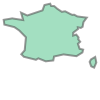

In [1912]:
multipolygon_france

In [1919]:
pd.reset_option('display.max_colwidth')

In [1920]:
#mergeworld=mergeworld.dropna()

In [1921]:
mergeworld[mergeworld['map_name']=='French Guiana']

index       map_name map_code      continent  \
171  172.0  French Guiana      GUF  South America   

                                              geometry author_first_country  \
171  POLYGON ((-51.65780 4.15623, -52.24934 3.24109...                   GF   

     proportion  count  latitude  longitude  
171    0.000136    2.0     4.938 -52.335049

In [1922]:
mergeworld[mergeworld['continent']=='Europe'] #there are some issues with'Bosnia and Herzegovina', 'Republic of Serbia', 'North Macedonia' - we drop them

index          map_name map_code continent  \
2    109.0           Germany      DEU    Europe   
3    130.0    United Kingdom      GBR    Europe   
4     35.0            France      FRA    Europe   
5    128.0             Italy      ITA    Europe   
7    115.0       Switzerland      CHE    Europe   
10   120.0             Spain      ESP    Europe   
11    15.0            Russia      RUS    Europe   
15   118.0       Netherlands      NLD    Europe   
17    98.0            Sweden      SWE    Europe   
18   117.0           Belgium      BEL    Europe   
19   101.0            Poland      POL    Europe   
20    17.0            Norway      NOR    Europe   
21   102.0           Austria      AUT    Europe   
24   140.0           Czechia      CZE    Europe   
26   129.0           Denmark      DNK    Europe   
27   138.0           Finland      FIN    Europe   
30   111.0            Greece      GRC    Europe   
32   119.0          Portugal      PRT    Europe   
35   105.0           Romania      ROU    Europe   
38   103.0           Hungary      HUN    Europe   
39   100.0           Ukraine      UKR    Europe   
41   121.0           Ireland      IRL    Europe   
46   139.0          Slovakia      SVK    Europe   
48   137.0          Slovenia      SVN    Europe   
49   155.0            Serbia      SRB    Europe   
50   114.0           Croatia      HRV    Europe   
53   110.0          Bulgaria      BGR    Europe   
61   108.0           Estonia      EST    Europe   
65   106.0         Lithuania      LTU    Europe   
66    99.0           Belarus      BLR    Europe   
69   116.0        Luxembourg      LUX    Europe   
73   107.0            Latvia      LVA    Europe   
81   131.0           Iceland      ISL    Europe   
91   153.0  Bosnia and Herz.      BIH    Europe   
96   154.0         Macedonia      MKD    Europe   
97   113.0           Albania      ALB    Europe   
100  104.0           Moldova      MDA    Europe   
127  156.0        Montenegro      MNE    Europe   
205    NaN            Kosovo      KOS    Europe   

                                              geometry author_first_country  \
2    POLYGON ((14.11969 53.75703, 14.35332 53.24817...                   DE   
3    MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...                   GB   
4    MULTIPOLYGON (((6.18632 49.46380, 6.65823 49.2...                   FR   
5    MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...                   IT   
7    POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...                   CH   
10   POLYGON ((-7.45373 37.09779, -7.53711 37.42890...                   ES   
11   MULTIPOLYGON (((178.72530 71.09880, 180.00000 ...                   RU   
15   POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...                   NL   
17   POLYGON ((11.02737 58.85615, 11.46827 59.43239...                   SE   
18   POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...                   BE   
19   POLYGON ((23.48413 53.91250, 23.52754 53.47012...                   PL   
20   MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...                   NO   
21   POLYGON ((16.97967 48.12350, 16.90375 47.71487...                   AT   
24   POLYGON ((15.01700 51.10667, 15.49097 50.78473...                   CZ   
26   MULTIPOLYGON (((9.92191 54.98310, 9.28205 54.8...                   DK   
27   POLYGON ((28.59193 69.06478, 28.44594 68.36461...                   FI   
30   MULTIPOLYGON (((26.29000 35.29999, 26.16500 35...                   GR   
32   POLYGON ((-9.03482 41.88057, -8.67195 42.13469...                   PT   
35   POLYGON ((28.23355 45.48828, 28.67978 45.30403...                   RO   
38   POLYGON ((22.08561 48.42226, 22.64082 48.15024...                   HU   
39   POLYGON ((31.78599 52.10168, 32.15944 52.06125...                   UA   
41   POLYGON ((-6.19788 53.86757, -6.03299 53.15316...                   IE   
46   POLYGON ((22.55814 49.08574, 22.28084 48.82539...                   SK   
48   POLYGON ((13.80648 46.50931, 14.63247 46.43182...              

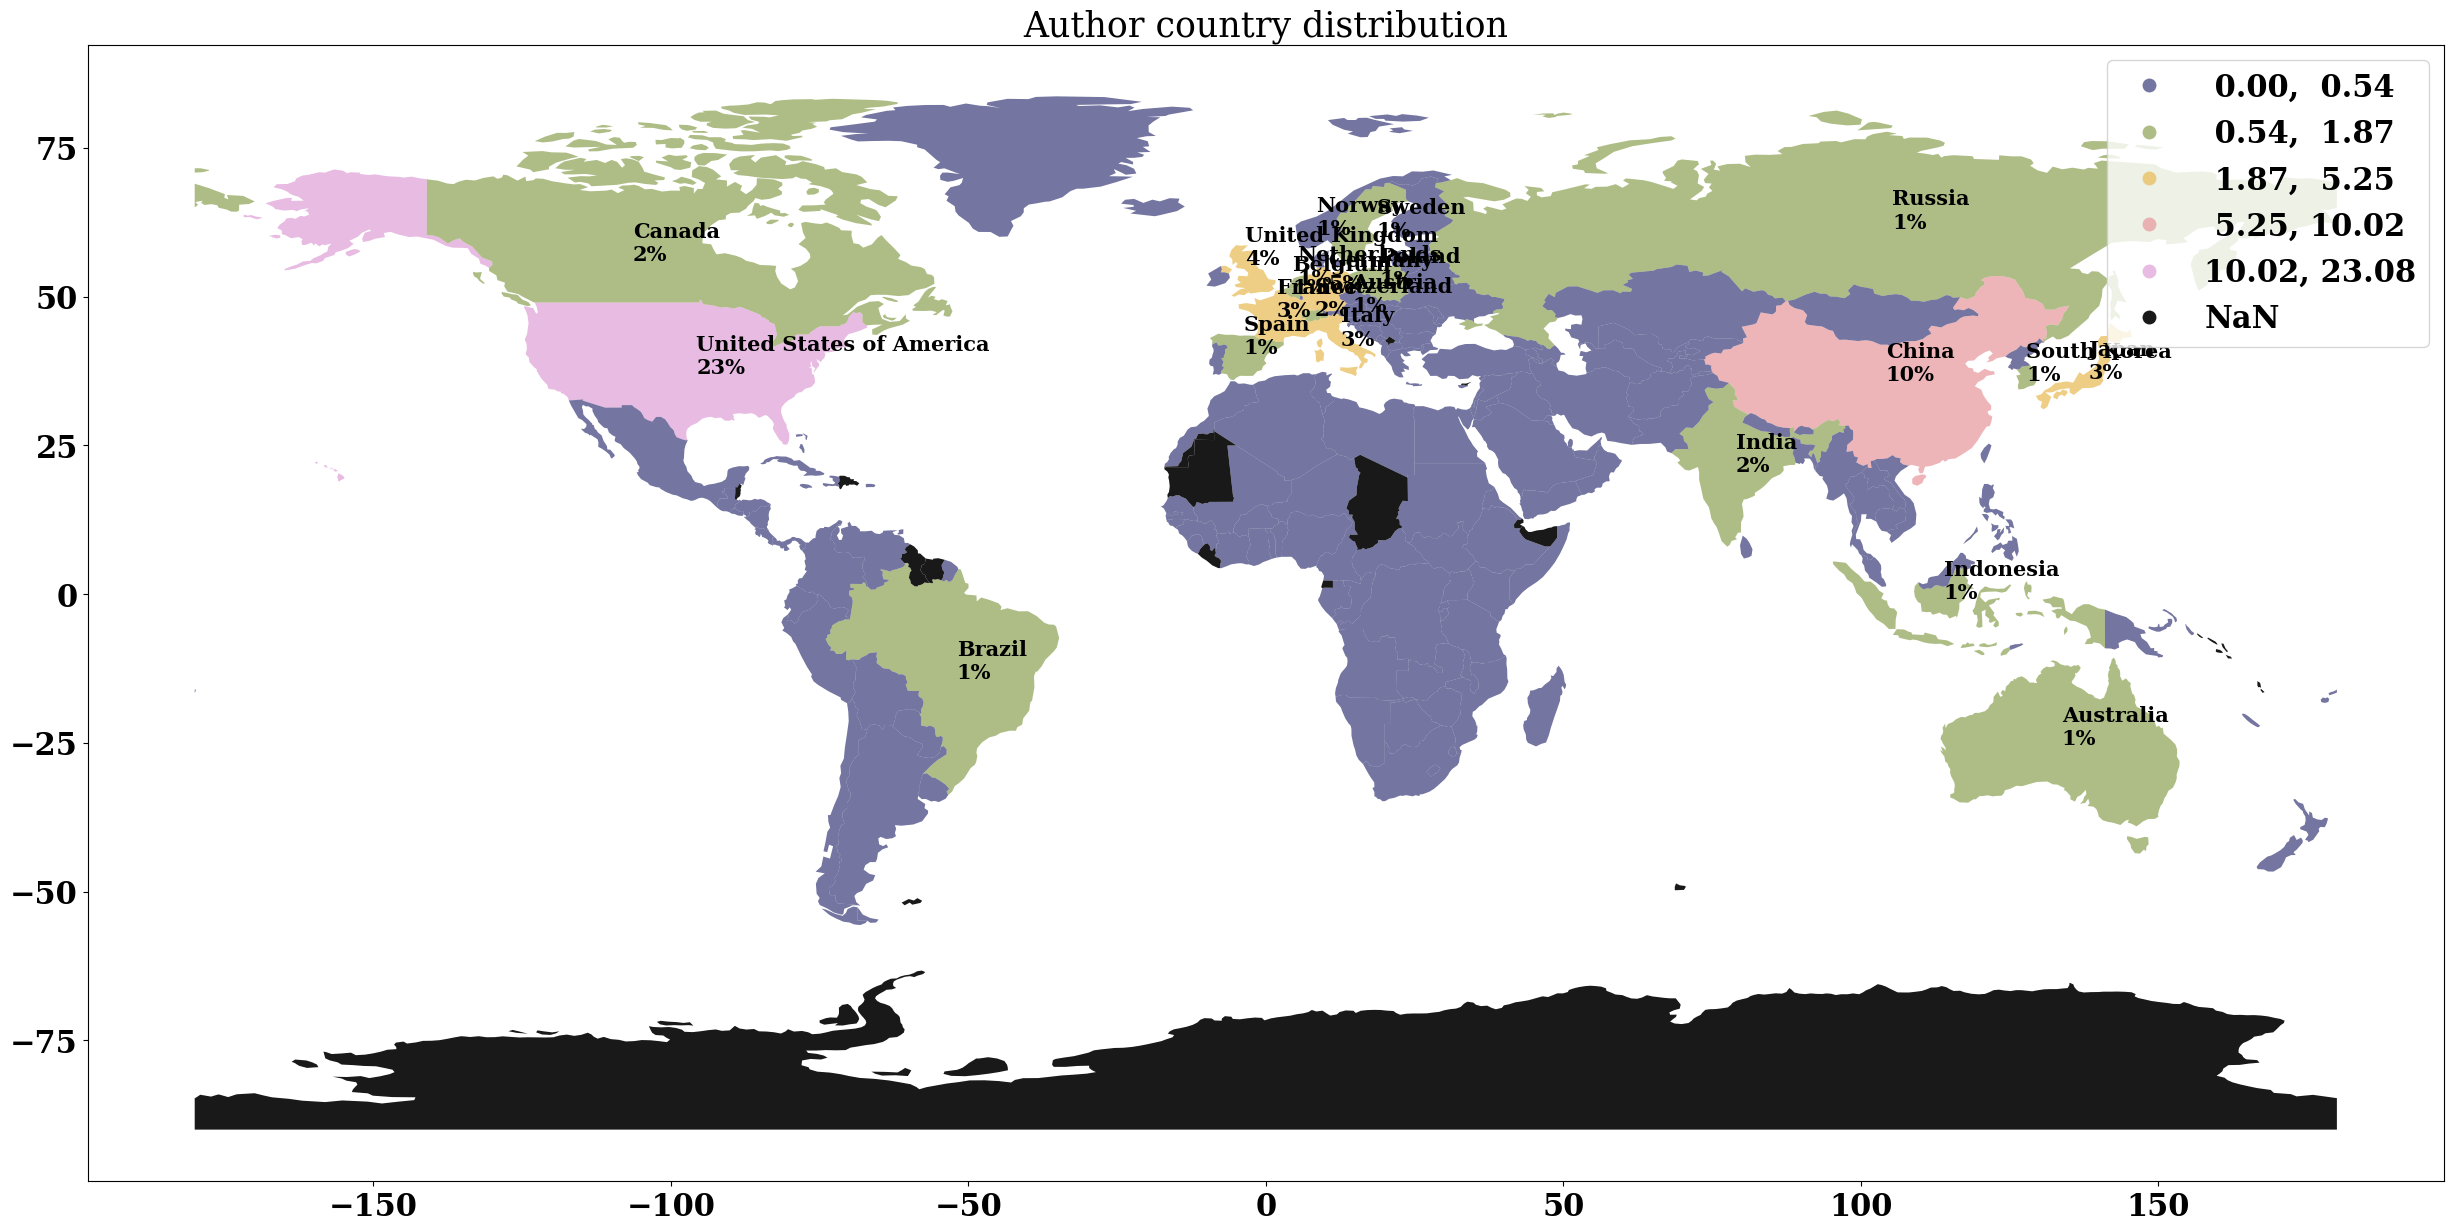

In [1923]:
fig_world=mergeworld.plot(column='proportion',
                scheme='natural_breaks',
                cmap='tab20b', 
                alpha=0.7,
                figsize=(25, 20),
                missing_kwds={'color': 'k', 'alpha':0.9}, 
                legend=True);

plt.title('Author country distribution',fontsize=25)
# add countries names and numbers for top 10 appearing countries 
for i in range(len(mergeworld[mergeworld['proportion']>0.5])):
    plt.text(float(mergeworld.longitude[i]),float(mergeworld.latitude[i]),"{}\n{}".format(mergeworld.map_name[i],f'{round(mergeworld.proportion[i])}%'),size=15)
#plt.savefig('Plots/2023-12-09/allauthorcountrymap.png')

plt.show()


In [ ]:
mergeworld=mergeworld.rename(columns={'count':'proportion_count'})

In [1924]:
#add column to mergworld with percentage out of population and N 

we get population size data from this site https://data.worldbank.org/indicator/SP.POP.TOTL?most_recent_year_desc=false

In [1980]:
population_size=pd.read_csv('pop_size_data_2022.csv', sep=';')

In [1983]:
population_size=population_size.rename(columns={'2022':'total_population_2022'})

In [1997]:
len(mergeworld)

206

In [1998]:
population_size=population_size[population_size.map_code.isin([mergeworld.map_code[i] for i in range(len(mergeworld))])]

In [1999]:
len(mergeworld)

206

In [2002]:
mergeworld=pd.merge(mergeworld, population_size, on='map_code', how='outer')
#per capita

In [2003]:
mergeworld

index                  map_name map_code      continent  \
0      3.0  United States of America      USA  North America   
1    126.0                     China      CHN           Asia   
2    109.0                   Germany      DEU         Europe   
3    130.0            United Kingdom      GBR         Europe   
4     35.0                    France      FRA         Europe   
..     ...                       ...      ...            ...   
201    NaN                Antarctica      ATA     Antarctica   
202    NaN           Northern Cyprus      CYN           Asia   
203    NaN                  Djibouti      DJI         Africa   
204    NaN                Somaliland      SOL         Africa   
205    NaN                    Kosovo      KOS         Europe   

                                              geometry author_first_country  \
0    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...                   US   
1    MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...                   CN   
2    POLYGON ((14.11969 53.75703, 14.35332 53.24817...                   DE   
3    MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...                   GB   
4    MULTIPOLYGON (((6.18632 49.46380, 6.65823 49.2...                   FR   
..                                                 ...                  ...   
201  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...                  NaN   
202  POLYGON ((32.73178 35.14003, 32.80247 35.14550...                  NaN   
203  POLYGON ((42.35156 12.54223, 42.77964 12.45542...                  NaN   
204  POLYGON ((48.94820 11.41062, 48.94820 11.41062...                  NaN   
205  POLYGON ((20.59025 41.85541, 20.52295 42.21787...                  NaN   

     proportion  proportion_count   latitude   longitude  \
0     23.077367          339646.0  37.090240  -95.712891   
1     10.015281          147402.0  35.861660  104.195397   
2      5.248643           77248.0  51.165691   10.451526   
3      3.986354           58670.0  55.378051   -3.435973   
4      3.334826           49081.0  46.603354    1.888334   
..          ...               ...        ...         ...   
201         NaN               NaN        NaN         NaN   
202         NaN               NaN        NaN         NaN   
203         NaN               NaN        NaN         NaN   
204         NaN               NaN        NaN         NaN   
205         NaN               NaN        NaN         NaN   

     total_population_2022  
0             3.332876e+08  
1             1.412175e+09  
2             8.379798e+07  
3             6.697140e+07  
4             6.797131e+07  
..                     ...  
201                    NaN  
202                    NaN  
203           1.120849e+06  
204                    NaN  
205                    NaN  

[206 rows x 11 columns]

In [2004]:
mergeworld['per_capita']=mergeworld.proportion_count/mergeworld.total_population_2022

In [2005]:
mergeworld

index                  map_name map_code      continent  \
0      3.0  United States of America      USA  North America   
1    126.0                     China      CHN           Asia   
2    109.0                   Germany      DEU         Europe   
3    130.0            United Kingdom      GBR         Europe   
4     35.0                    France      FRA         Europe   
..     ...                       ...      ...            ...   
201    NaN                Antarctica      ATA     Antarctica   
202    NaN           Northern Cyprus      CYN           Asia   
203    NaN                  Djibouti      DJI         Africa   
204    NaN                Somaliland      SOL         Africa   
205    NaN                    Kosovo      KOS         Europe   

                                              geometry author_first_country  \
0    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...                   US   
1    MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...                   CN   
2    POLYGON ((14.11969 53.75703, 14.35332 53.24817...                   DE   
3    MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...                   GB   
4    MULTIPOLYGON (((6.18632 49.46380, 6.65823 49.2...                   FR   
..                                                 ...                  ...   
201  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...                  NaN   
202  POLYGON ((32.73178 35.14003, 32.80247 35.14550...                  NaN   
203  POLYGON ((42.35156 12.54223, 42.77964 12.45542...                  NaN   
204  POLYGON ((48.94820 11.41062, 48.94820 11.41062...                  NaN   
205  POLYGON ((20.59025 41.85541, 20.52295 42.21787...                  NaN   

     proportion  proportion_count   latitude   longitude  \
0     23.077367          339646.0  37.090240  -95.712891   
1     10.015281          147402.0  35.861660  104.195397   
2      5.248643           77248.0  51.165691   10.451526   
3      3.986354           58670.0  55.378051   -3.435973   
4      3.334826           49081.0  46.603354    1.888334   
..          ...               ...        ...         ...   
201         NaN               NaN        NaN         NaN   
202         NaN               NaN        NaN         NaN   
203         NaN               NaN        NaN         NaN   
204         NaN               NaN        NaN         NaN   
205         NaN               NaN        NaN         NaN   

     total_population_2022  per_capita  
0             3.332876e+08    0.001019  
1             1.412175e+09    0.000104  
2             8.379798e+07    0.000922  
3             6.697140e+07    0.000876  
4             6.797131e+07    0.000722  
..                     ...         ...  
201                    NaN         NaN  
202                    NaN         NaN  
203           1.120849e+06         NaN  
204                    NaN         NaN  
205                    NaN         NaN  

[206 rows x 12 columns]

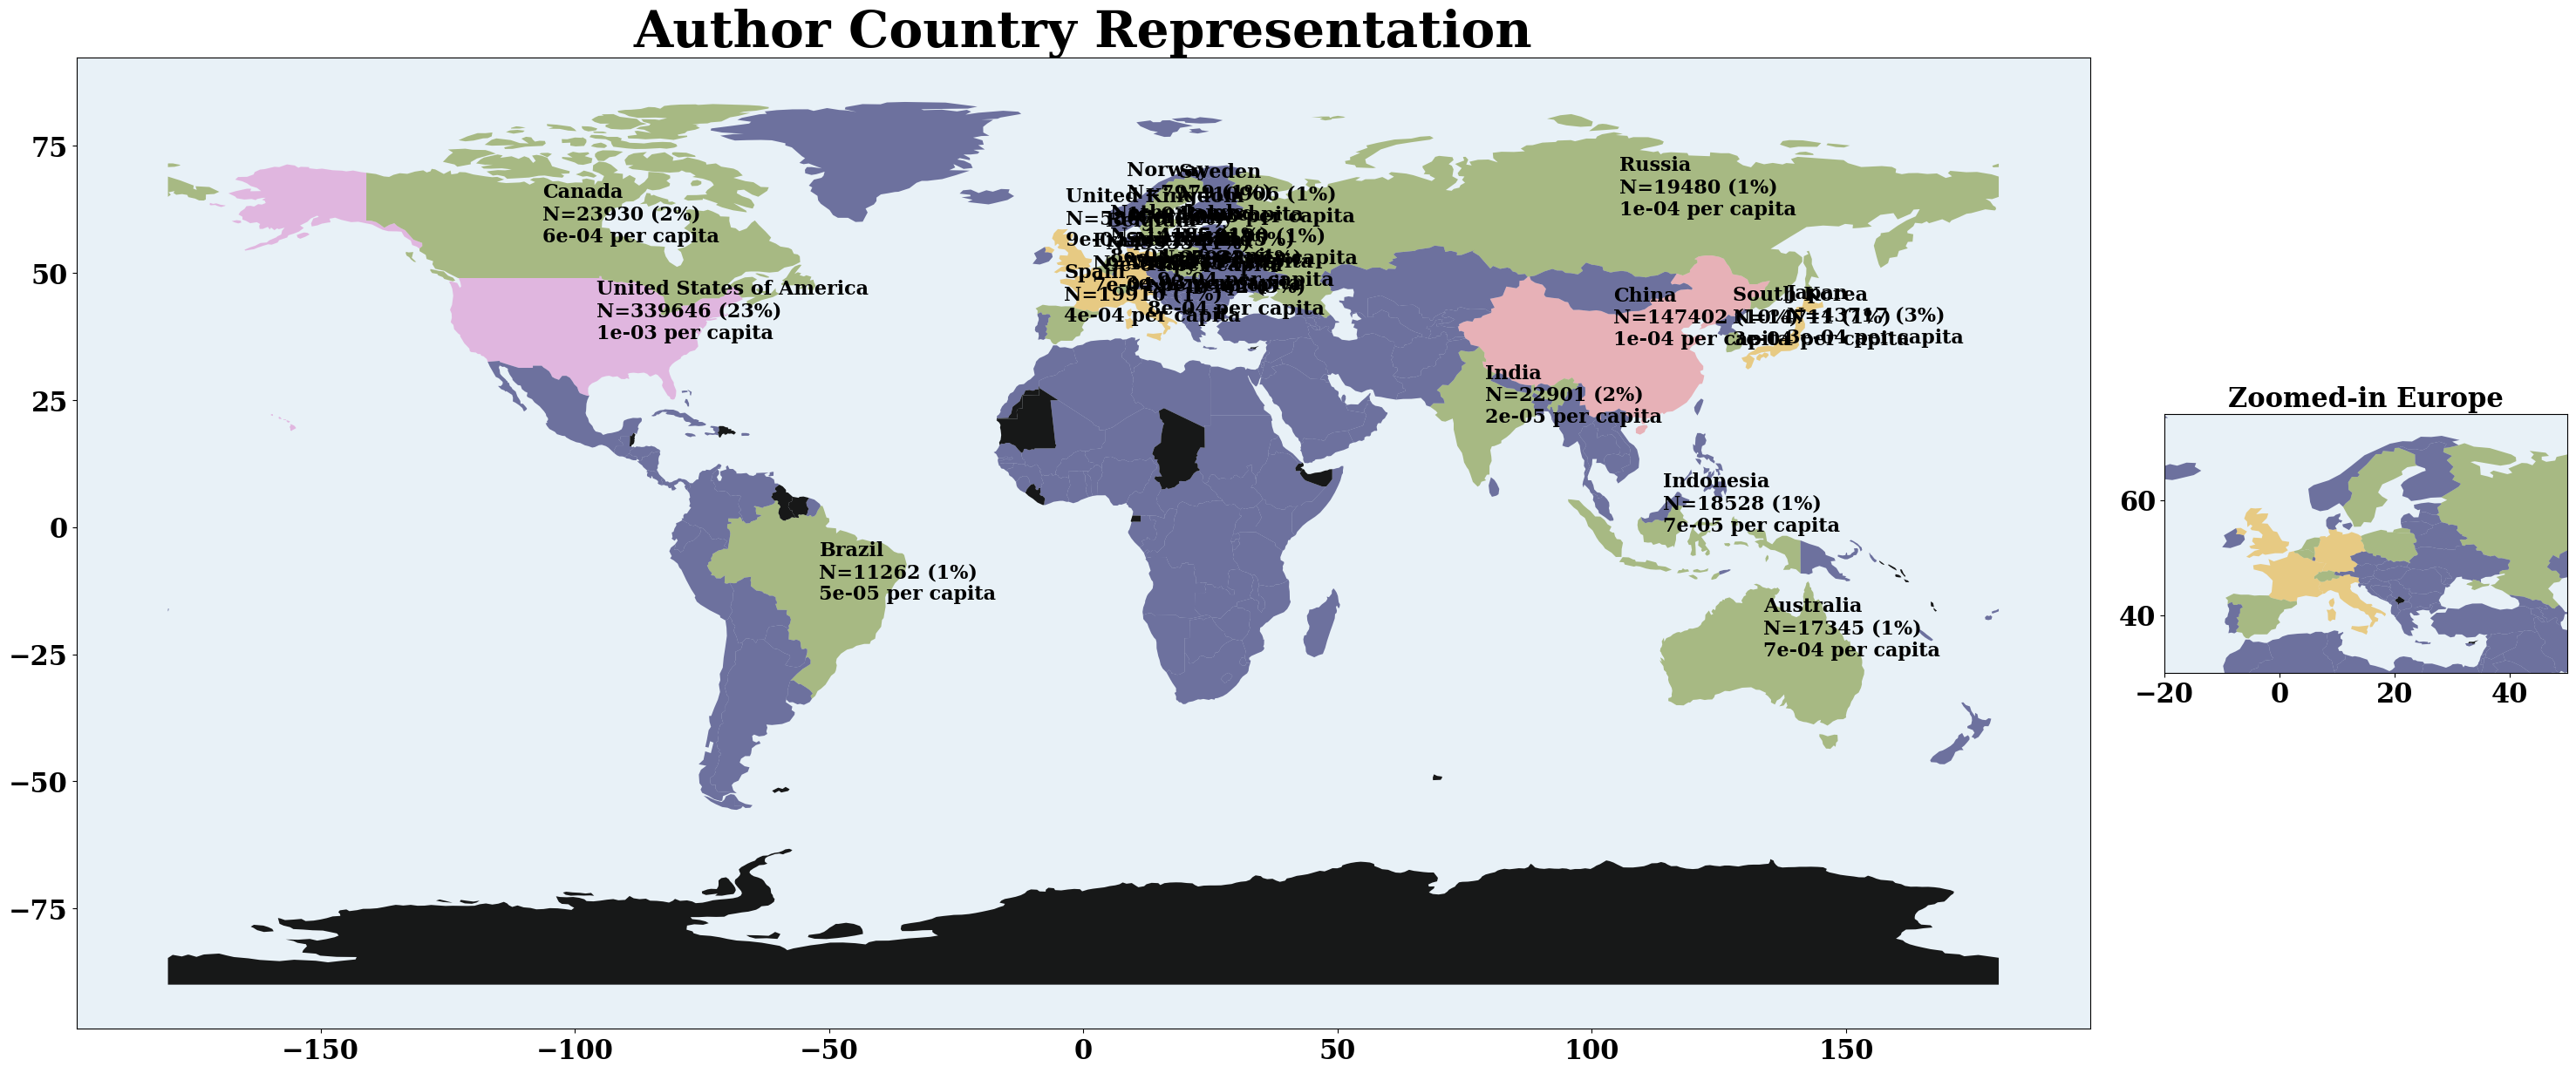

In [2021]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a grid for the subplots
fig, (ax_main, ax_europe) = plt.subplots(1, 2, figsize=(30, 25), gridspec_kw={'width_ratios': [5, 1]})

# Main plot
mergeworld.plot(column='proportion',
                scheme='natural_breaks',
                cmap='tab20b', 
                alpha=0.7,
                ax=ax_main,
                missing_kwds={'color': 'k', 'alpha':0.9}, 
                legend=False)

ax_main.set_title('Author Country Representation', fontsize=42, weight='bold')

# Add countries names and numbers for most appearing countries 
for i in range(len(mergeworld[mergeworld['proportion'] > 0.5])):
    text_to_display = "{}\n{}\n{}".format(
        mergeworld.map_name[i],
        f'N={round(mergeworld.proportion_count[i])} ({round(mergeworld.proportion[i])}%)',
        f'{mergeworld.per_capita[i]:.0e} per capita'
    )
    
    ax_main.text(
        float(mergeworld.longitude[i]),
        float(mergeworld.latitude[i]),
        text_to_display,
        size=16,
        #color=purd_colors[8]
    )



# Europe subplot
divider = make_axes_locatable(ax_main)
#cax = divider.append_axes("right", size="5%", pad=0.1)
mergeworld.plot(column='proportion',
                                                      scheme='natural_breaks',
                                                      cmap='tab20b',
                                                      alpha=0.7,
                                                      ax=ax_europe,
                                                      cax=None,
                                                      missing_kwds={'color': 'k', 'alpha': 0.9},
                                                      legend=False)

# Set custom limits for the axes in the ax_europe subplot
ax_europe.set_xlim(-20, 50)
ax_europe.set_ylim(30, 75)
ax_main.set_facecolor('tab:blue')
ax_main.patch.set_alpha(0.1)
ax_europe.set_facecolor('tab:blue')
ax_europe.patch.set_alpha(0.1)


ax_europe.set_title('Zoomed-in Europe', fontsize=22, weight='bold')

plt.show()


In [2026]:
#these are the names that are displayed - should we chance their latitude/longitude a bit? 
mergeworld[mergeworld['proportion'] > 0.5]

index                  map_name map_code      continent  \
0     3.0  United States of America      USA  North America   
1   126.0                     China      CHN           Asia   
2   109.0                   Germany      DEU         Europe   
3   130.0            United Kingdom      GBR         Europe   
4    35.0                    France      FRA         Europe   
5   128.0                     Italy      ITA         Europe   
6   142.0                     Japan      JPN           Asia   
7   115.0               Switzerland      CHE         Europe   
8     2.0                    Canada      CAN  North America   
9    86.0                     India      IND           Asia   
10  120.0                     Spain      ESP         Europe   
11   15.0                    Russia      RUS         Europe   
12    7.0                 Indonesia      IDN           Asia   
13  124.0                 Australia      AUS        Oceania   
14   84.0               South Korea      KOR           Asia   
15  118.0               Netherlands      NLD         Europe   
16   24.0                    Brazil      BRA  South America   
17   98.0                    Sweden      SWE         Europe   
18  117.0                   Belgium      BEL         Europe   
19  101.0                    Poland      POL         Europe   
20   17.0                    Norway      NOR         Europe   
21  102.0                   Austria      AUT         Europe   

                                             geometry author_first_country  \
0   MULTIPOLYGON (((-122.84000 49.00000, -120.0000...                   US   
1   MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...                   CN   
2   POLYGON ((14.11969 53.75703, 14.35332 53.24817...                   DE   
3   MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...                   GB   
4   MULTIPOLYGON (((6.18632 49.46380, 6.65823 49.2...                   FR   
5   MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...                   IT   
6   MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...                   JP   
7   POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...                   CH   
8   MULTIPOLYGON (((-122.84000 49.00000, -122.9742...                   CA   
9   POLYGON ((97.32711 28.26158, 97.40256 27.88254...                   IN   
10  POLYGON ((-7.45373 37.09779, -7.53711 37.42890...                   ES   
11  MULTIPOLYGON (((178.72530 71.09880, 180.00000 ...                   RU   
12  MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...                   ID   
13  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...                   AU   
14  POLYGON ((126.17476 37.74969, 126.23734 37.840...                   KR   
15  POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...                   NL   
16  POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...                   BR   
17  POLYGON ((11.02737 58.85615, 11.46827 59.43239...                   SE   
18  POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...                   BE   
19  POLYGON ((23.48413 53.91250, 23.52754 53.47012...                   PL   
20  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...                   NO   
21  POLYGON ((16.97967 48.12350, 16.90375 47.71487...                   AT   

    proportion  proportion_count   latitude   longitude  \
0    23.077367          339646.0  37.090240  -95.712891   
1    10.015281          147402.0  35.861660  104.195397   
2     5.248643           77248.0  51.165691   10.451526   
3     3.986354           58670.0  55.378051   -3.435973   
4     3.334826           49081.0  46.603354    1.888334   
5     3.156877           46462.0  41.871940   12.567380   
6     2.970367           43717.0  36.204824  138.252924   
7     1.867478           27485.0  46.818188    8.227512   
8     1.625932           23930.0  56.130366 -106.346771   
9     1.556017           22901.0  20.593684   78.962880   
10    1.353200           19916.0  40.463667   -3.749220   
11    1.323575           19480.0  61.524010  105.31

In [2047]:
mergeworld_update=mergeworld

In [2258]:
mergeworld_update[['latitude', 'longitude']][mergeworld_update['map_name']=='Germany']

latitude  longitude
2  51.165691  10.451526

In [2614]:
import warnings
from pandas.errors import SettingWithCopyWarning

# Suppress SettingWithCopyWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=SettingWithCopyWarning)

    mergeworld_update['latitude'][mergeworld_update['map_name']=='United States of America']=34
    mergeworld_update['longitude'][mergeworld_update['map_name']=='United States of America']=-115

    mergeworld_update['latitude'][mergeworld_update['map_name']=='China']=31
    mergeworld_update['longitude'][mergeworld_update['map_name']=='China']=85

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Japan']=30
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Japan']=135

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Canada']=54
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Canada']=-125

    mergeworld_update['latitude'][mergeworld_update['map_name']=='India']=15
    mergeworld_update['longitude'][mergeworld_update['map_name']=='India']=72

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Russia']=59
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Russia']=88

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Indonesia']=-10
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Indonesia']=98

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Australia']=-30
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Australia']=120
    
    mergeworld_update['latitude'][mergeworld_update['map_name']=='South Korea']=37
    mergeworld_update['longitude'][mergeworld_update['map_name']=='South Korea']=130

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Brazil']=-15
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Brazil']=-58

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Germany']=51
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Germany']=1

    mergeworld_update['latitude'][mergeworld_update['map_name']=='United Kingdom']=55
    mergeworld_update['longitude'][mergeworld_update['map_name']=='United Kingdom']=-35

    mergeworld_update['latitude'][mergeworld_update['map_name']=='France']=43
    mergeworld_update['longitude'][mergeworld_update['map_name']=='France']=-14

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Italy']=31
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Italy']=1

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Switzerland']=38
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Switzerland']=14.5

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Spain']=35
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Spain']=-35

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Netherlands']=-60
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Netherlands']=40

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Sweden']=-40
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Sweden']=40

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Belgium']=-20
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Belgium']=40

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Poland']=41.5
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Poland']=20

    mergeworld_update['latitude'][mergeworld_update['map_name']=='Norway']=66
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Norway']=20
    
    mergeworld_update['latitude'][mergeworld_update['map_name']=='Austria']=-20
    mergeworld_update['longitude'][mergeworld_update['map_name']=='Austria']=-40


In [2603]:
#define colors

# Get the PuRd colormap
cmaptab = plt.get_cmap('tab20b')
num_colors = 20  # Number of colors
# Create a list of colors from the colormap
tab_colors = [cmaptab(i / num_colors) for i in range(num_colors)]



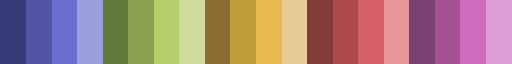

In [2604]:
cmaptab

In [2605]:
pink=tab_colors[19]
red=tab_colors[15]
yellow=tab_colors[10]
green=tab_colors[5]
purple=tab_colors[1]

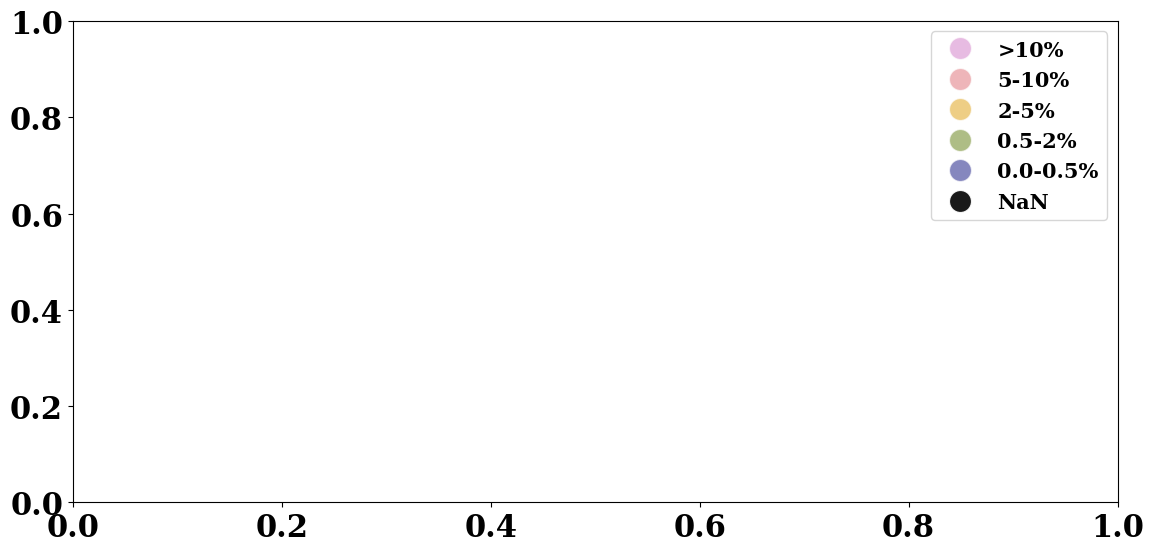

In [2606]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

markersize=16
legend_elements = [Line2D([0], [0], marker='o', color='w', label='>10%',
                          markerfacecolor=pink, alpha=0.7, markersize=markersize),
                   Line2D([0], [0], marker='o', color='w', label='5-10%',
                          markerfacecolor=red, alpha=0.7, markersize=markersize),
                   Line2D([0], [0], marker='o', color='w', label='2-5%',
                          markerfacecolor=yellow, alpha=0.7, markersize=markersize),
                   Line2D([0], [0], marker='o', color='w', label='0.5-2%',
                          markerfacecolor=green, alpha=0.7, markersize=markersize),
                   Line2D([0], [0], marker='o', color='w', label='0.0-0.5%',
                          markerfacecolor=purple, alpha=0.7, markersize=markersize),
                   Line2D([0], [0], marker='o', color='w', label='NaN',
                          markerfacecolor='k', alpha=0.9, markersize=markersize),
                  ]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='upper right', fontsize=15) #, title='title')

plt.show()

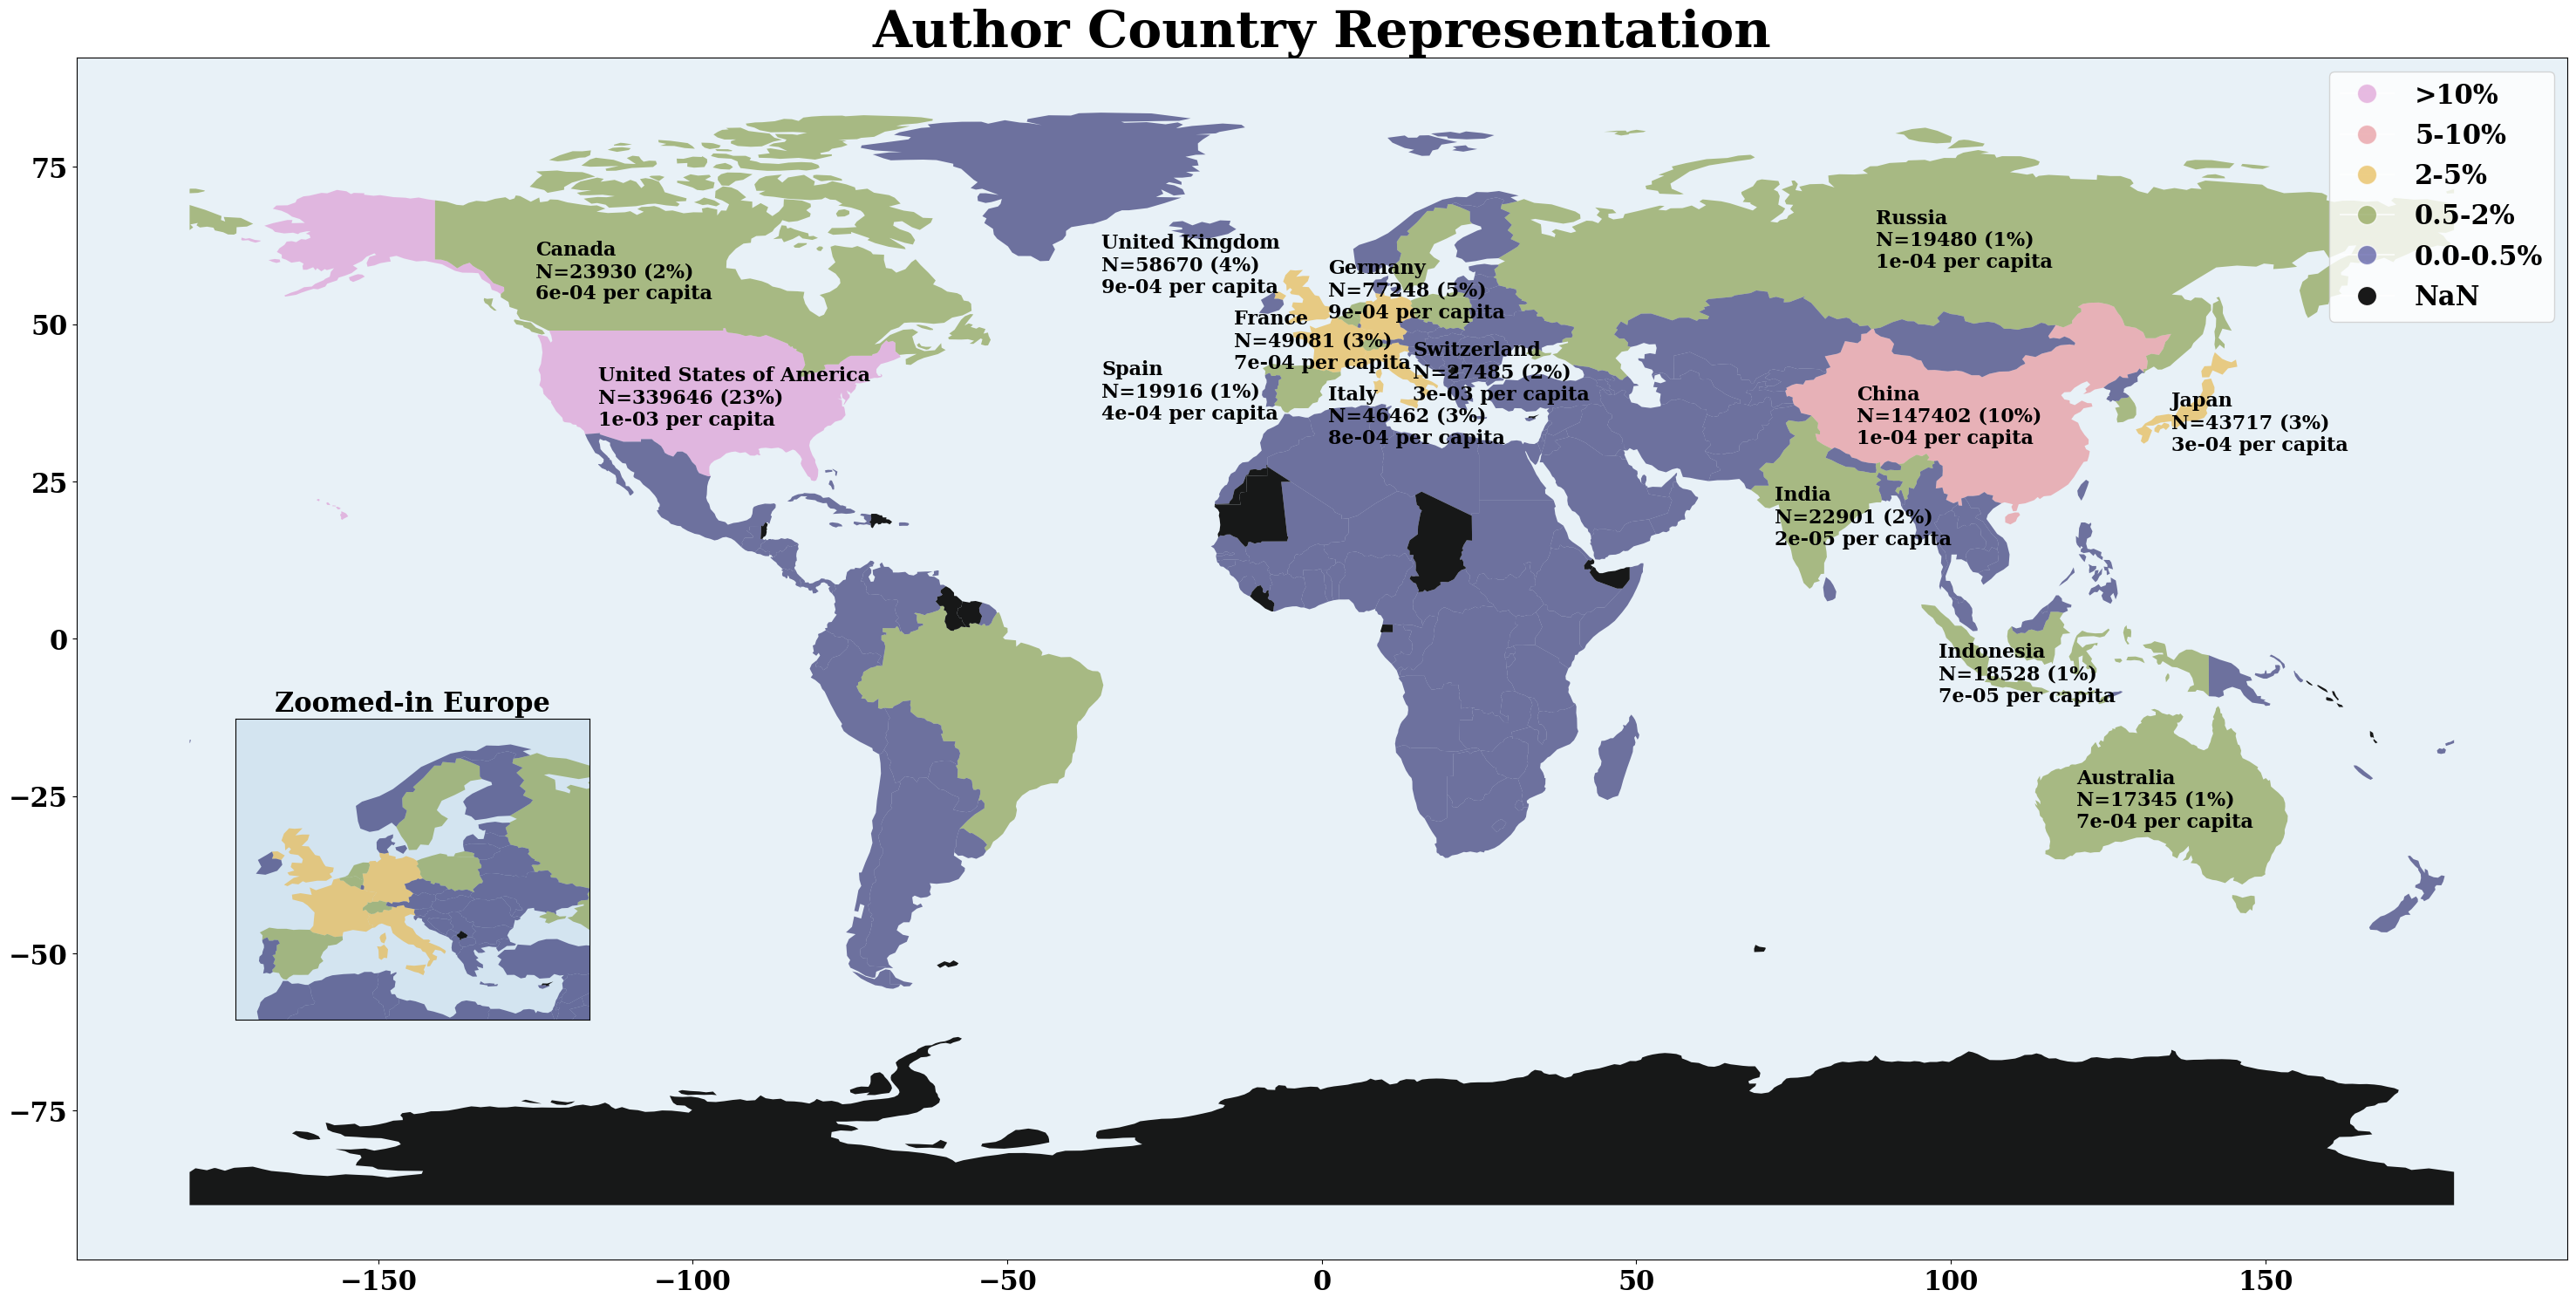

In [2980]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a grid for the subplots
fig, (ax_main) = plt.subplots(figsize=(30, 25))

# Main plot
mergeworld_update.plot(column='proportion',
                scheme='natural_breaks',
                cmap='tab20b', 
                alpha=0.7,
                ax=ax_main,
                missing_kwds={'color': 'k', 'alpha':0.9}, 
                legend=False)

ax_main.set_title('Author Country Representation', fontsize=42, weight='bold')
ax_main.legend(handles=legend_elements, loc='upper right', fontsize=22)

# Add countries names and numbers for most appearing countries 
for i in range(len(mergeworld_update[mergeworld_update['proportion'] >= 1])):
    text_to_display = "{}\n{}\n{}".format(
        mergeworld_update.map_name[i],
        f'N={round(mergeworld_update.proportion_count[i])} ({round(mergeworld_update.proportion[i])}%)',
        f'{mergeworld_update.per_capita[i]:.0e} per capita'
    )
    
    ax_main.text(
        float(mergeworld_update.longitude[i]),
        float(mergeworld_update.latitude[i]),
        text_to_display,
        size=16,
        #color=purd_colors[8]
    )



# Europe subplot
#divider = make_axes_locatable(ax_main)
ax_europe = ax_main.inset_axes([0.01,0.2, 0.25, 0.25])
#cax = divider.append_axes("right", size="5%", pad=0.1)
mergeworld_update.plot(column='proportion',
                                                      scheme='natural_breaks',
                                                      cmap='tab20b',
                                                      alpha=0.7,
                                                      ax=ax_europe,
                                                      #cax=None,
                                                      missing_kwds={'color': 'k', 'alpha': 0.9},
                                                      legend=False)

# Set custom limits for the axes in the ax_europe subplot
ax_europe.set_xlim(-13, 40)
ax_europe.set_ylim(30, 75)
ax_main.set_facecolor('tab:blue')
ax_main.patch.set_alpha(0.1)
ax_europe.set_facecolor('tab:blue')
ax_europe.patch.set_alpha(0.1)
ax_europe.set_title('Zoomed-in Europe', fontsize=22, weight='bold')
ax_europe.set_xticks([])
ax_europe.set_yticks([])

save_name = 'article_author_data_final_worldmap'
save_path = f'Plots/{date.today()}/{save_name}'
plt.savefig(save_path)

plt.show()


In [2601]:
#add unknown as text somewhere
#seperate text in europe and other dense areas? 
# add legend manually 
#plot zoomed in europe inside plot (eg in the lower left corner) rather than outside plot 

## Impact factor

JIF data downloaded from: https://www.researchgate.net/publication/371935355_Journal_Citation_Reports_JCR_Impact_Factor_2023_Web_of_Science

In [537]:
#import journal impact factor data
JIF=pd.read_excel('2023JIF.xlsx')  
JIF=JIF[0:9490] #drop the last rows since they are copyright info 
JIF

journal_name       ISSN 2022_JIF
0     Correspondances en Metabolismes Hormones Diabe...  2100-9619     <0.1
1                               PSYCHIATRIE DE L ENFANT  0079-726X     <0.1
2                         Reports on Mathematical Logic  0137-2904     <0.1
3                    Revue d Histoire des Mathematiques  1262-022X     <0.1
4                                       SEN-I GAKKAISHI  0037-9875     <0.1
...                                                 ...        ...      ...
9485                           POSTEPY BIOLOGII KOMORKI  0324-833X      0.1
9486                                     SEA TECHNOLOGY  0093-3651      0.1
9487                      Slovenian Veterinary Research  1580-4003      0.1
9488                        WEST INDIAN MEDICAL JOURNAL  0043-3144      0.1
9489                                  ZKG INTERNATIONAL  2366-1313      0.1

[9490 rows x 3 columns]

In [538]:
#create dataframe with journal names in our data
journals_name = {
    "journal_name": article_author_data_clean_update_fifth.journal_name.value_counts().reset_index()['journal_name'].to_list()
}


df_journals_name = pd.DataFrame(journals_name)

In [458]:
#merge the two  on journal name

In [2898]:
# Convert name column to lowercase for case-insensitive matching
JIF['journal_name_lower'] = JIF['journal_name'].str.lower()
df_journals_name['journal_name_lower'] = df_journals_name['journal_name'].str.lower()

# Merge dataframes using a left join
df_journals_name_merged = pd.merge(JIF, df_journals_name, how='right', left_on='journal_name_lower', right_on='journal_name_lower')

# Drop the extra columns used for merging
df_journals_name_merged = df_journals_name_merged.drop(['journal_name_x', 'journal_name_lower'], axis=1)
df_journals_name_merged = df_journals_name_merged.rename(columns={'journal_name_y': 'journal_name'})



In [2899]:
df_journals_name_merged

ISSN 2022_JIF                                       journal_name
0           NaN      NaN                                   Physics Bulletin
1           NaN      NaN                              Physica status solidi
2           NaN      NaN  physica status solidi (b) basic solid state ph...
3     0002-9505      0.9                        American Journal of Physics
4           NaN      NaN                          The Astrophysical Journal
...         ...      ...                                                ...
2687  0268-960X      7.4                                      Blood Reviews
2688        NaN      NaN  Fifth Australia-New Zealand Conference on Geom...
2689  0950-1991      4.6                                        Development
2690        NaN      NaN                   Environmental technology letters
2691        NaN      NaN                                                ELH

[2692 rows x 3 columns]

In [562]:
#find the ones that did were not in the JIF data and update impact factor manually 
nan_jif=df_journals_name_merged[df_journals_name_merged['2022_JIF'].isna()]


we find the rest of the JIF manually here https://exaly.com/journals/if/?q=

In [2878]:
len(nan_jif)

1717

In [6067]:
print(nan_jif.journal_name[1710::])

2677                 Zeitschrift für Physikalische Chemie
2680                     Zeitschrift für Naturforschung C
2684                           Giornale botanico italiano
2686      Journal of The British Contact Lens Association
2688    Fifth Australia-New Zealand Conference on Geom...
2690                     Environmental technology letters
2691                                                  ELH
Name: journal_name, dtype: object


In [6068]:
print(nan_jif.journal_name.loc[2688])

Fifth Australia-New Zealand Conference on Geomechanics: Prediction Versus Performance; Preprints of Papers


In [6069]:
jif=[
    ]

In [6070]:
len(jif)

7

In [6071]:
jif=[pd.NA, pd.NA, 1.3, 4.7, pd.NA, pd.NA, pd.NA, 0.8, pd.NA, pd.NA,
    1.7, pd.NA, pd.NA, 1, pd.NA, pd.NA, pd.NA, 0.4, 1.6, 27.7,
    pd.NA, pd.NA, pd.NA, 0.4, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 0.1,
    3.4, 4.4, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    0.1, pd.NA, 1.2, pd.NA, pd.NA, pd.NA, 16.4, 1, 1, 5.7,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 0.1, pd.NA, pd.NA,
    pd.NA, 1.7, 0.2, pd.NA, pd.NA, 1.4, pd.NA, pd.NA, 0.1, 4.3,
    0.4, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, 1.2, 1.4, 5.4, pd.NA, 2, 0.1, pd.NA,
    0.3, pd.NA, 2.1, 3.6, 0.5, 3.3, 4.9, pd.NA, pd.NA, 18.4,
    3.7, pd.NA, pd.NA, pd.NA, pd.NA, 4, 1.3, pd.NA, pd.NA, 0.6,
    pd.NA, 0, pd.NA, 0.4, 2.3, 2.9, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 0.1, pd.NA, pd.NA, 1.4, pd.NA, pd.NA, pd.NA, 0.1, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 9.7, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, 2.2, 3.3, pd.NA, pd.NA, 1.6, pd.NA,
    pd.NA, pd.NA, pd.NA, 1.2, 1.4, 1, pd.NA, pd.NA, 1.6, 0.4,
    8.6, pd.NA, 1.9, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 2,
    3.2, 1, pd.NA, pd.NA, 0.8, 0.6, pd.NA, pd.NA, 0.2, pd.NA, 
    2, pd.NA, pd.NA, pd.NA, pd.NA, 0, pd.NA, 6, pd.NA, 2.3, 
    1.8, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1.3, pd.NA, pd.NA,
    pd.NA, pd.NA, 2.9, pd.NA, 0.3, 1.8, 1.4, 1.8, pd.NA, 2.6,
    pd.NA, pd.NA, 1.8, pd.NA, pd.NA, 0.5, pd.NA, 1.8, 0.1, pd.NA,
    pd.NA, pd.NA, 1.2, pd.NA, pd.NA, pd.NA, 1.1, pd.NA, pd.NA, pd.NA,
    pd.NA, 1.4, 4.1, pd.NA, pd.NA, pd.NA, 1.5, 59.2, pd.NA, pd.NA,
    pd.NA, 0.1, 1.7, 0.7, pd.NA, pd.NA, pd.NA, pd.NA, 0.5, pd.NA,
    pd.NA, 7.5, pd.NA, 2.2, pd.NA, 5.5, pd.NA, pd.NA, 9.4, pd.NA,
    pd.NA, 0.1, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1.2, pd.NA, pd.NA,
    pd.NA, 0.5, pd.NA, pd.NA, 1.8, pd.NA, 3.8, 3, pd.NA, pd.NA,
    pd.NA, 5.5, 5, 1, pd.NA, pd.NA, pd.NA, 0.1, 2.7, 0.4,
    pd.NA, pd.NA, 6.3, 0.8, pd.NA, pd.NA, 1.3, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1, 1.3,
    pd.NA, 220.7, 2, pd.NA, pd.NA, 0.9, pd.NA, 0.9, 0.5, pd.NA, 
    0.1, 4.3, pd.NA, 1.4, pd.NA, 2.6, 0.3, 0.8, pd.NA, pd.NA,
    pd.NA, 3.4, 1.6, pd.NA, 0.2, pd.NA, 0.3, pd.NA, 0.4, pd.NA,
    3.1, 0.1, 5.1, 0.5, 3.6, 0.1, 2.7, pd.NA, 0.1, 0.2,
    pd.NA, pd.NA, pd.NA, pd.NA, 3.9, pd.NA, 0.7, pd.NA, 1.5, pd.NA,
    2.2, 1.5, pd.NA, pd.NA, 5.6, 0.7, pd.NA, pd.NA, pd.NA, 1.2,
    pd.NA, pd.NA, pd.NA, 0.2, 2.2, pd.NA, 0, 0.1, pd.NA, pd.NA,
    pd.NA, pd.NA, 0.7, pd.NA, 0.4, 0.1, 0, 0.4, 2.2, pd.NA,
    1, pd.NA, pd.NA, pd.NA, 2.2, pd.NA, 1.4, pd.NA, pd.NA, pd.NA,
    0.3, 0.5, pd.NA, 13.5, pd.NA, pd.NA, 2.6, pd.NA, pd.NA, 0.4,
    pd.NA, 0.1, pd.NA, 1, 0.2, pd.NA, 1.1, pd.NA, 0.1, 0.6,
    pd.NA, 1.8, pd.NA, 3, 5.7, pd.NA, pd.NA, 8.2, 0.7, 1.1,
    0.2, 0.4, pd.NA, 1.1, pd.NA, pd.NA, 0.6, pd.NA, 0, 0.2,
    pd.NA, pd.NA, pd.NA, pd.NA, 0.4, 1.7, 1.6, pd.NA, pd.NA, pd.NA,
    1.4, pd.NA, pd.NA, pd.NA, 0, 3.9, pd.NA, pd.NA, pd.NA, 0.8,
    2.1, pd.NA, 0.8, pd.NA, pd.NA, 3.6, pd.NA, pd.NA, pd.NA, 0.9,
    0.1, 0, pd.NA, pd.NA, pd.NA, 4.9, pd.NA, pd.NA, 7.3, pd.NA,
    3.3, pd.NA, pd.NA, 3.1, 0.6, pd.NA, 1.7, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, 1.4, pd.NA, pd.NA, pd.NA, 1.6, pd.NA, pd.NA, pd.NA,
    0.1, pd.NA, pd.NA, 1.5, 0.2, 1.4, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 0, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, 0.4, pd.NA, 4.3, pd.NA, 0.8, pd.NA, pd.NA, 0.3,
    0.9, 6, pd.NA, 0.1, 0.3, pd.NA, pd.NA, pd.NA, 2.6, 3.6,
    1.5, 2.6, 0.7, pd.NA, pd.NA, 0.2, pd.NA, pd.NA, pd.NA, pd.NA,
    1.2, 0.9, 1, 0.5, pd.NA, pd.NA, 1.4, pd.NA, pd.NA, pd.NA,
    pd.NA, 0, pd.NA, pd.NA, pd.NA, 1.5, pd.NA, 0.8, pd.NA, pd.NA,
    pd.NA, 3, pd.NA, 0.5, pd.NA, 1.6, pd.NA, 0, pd.NA, pd.NA,
    pd.NA, 2.1, pd.NA, pd.NA, 2.9, 2, 11, pd.NA, pd.NA, 0.2,
    0, pd.NA, 3.1, pd.NA, 1.2, 0.8, pd.NA, 2.9, 0.8, pd.NA,
    pd.NA, 1.2, 1, pd.NA, 1.1, pd.NA, pd.NA, pd.NA, 0, pd.NA,
    6.1, 1.2, 0.1, 4.8, 0.2, 0, pd.NA, pd.NA, 1, pd.NA,
    pd.NA, pd.NA, 1.2, 0.1, 0.2, pd.NA, pd.NA, pd.NA, 	0.1, pd.NA,
    pd.NA, pd.NA, 0.5, pd.NA, 2.6, pd.NA, pd.NA, pd.NA, 6.8, 0.5,
    1.5, 0.2, pd.NA, pd.NA, pd.NA, 5, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 1.3, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 12.8, pd.NA, pd.NA, 
    2.2, 0, pd.NA, 0.1, 1.1, pd.NA, pd.NA, pd.NA, 1.2, pd.NA,
    0, 2.1, pd.NA, 3.6, 0, 0.5, 0.6, pd.NA, 6.9, pd.NA, 
    pd.NA, 0.6, pd.NA, pd.NA, pd.NA, pd.NA, 1, pd.NA, 1.7, pd.NA,
    2.1, 0.5, pd.NA, 0.3, pd.NA, pd.NA, pd.NA, 0.3, 3.8, pd.NA,
    2.9, pd.NA, 3.1, 1, pd.NA, 2.5, 2.2, 3.6, pd.NA, 0.3,
    pd.NA, 0.5, 2, pd.NA, pd.NA, pd.NA, pd.NA, 1.9, pd.NA, pd.NA,
    0, 0.7, 6.4, 1.5, pd.NA, pd.NA, pd.NA, 0.1, 0.9, 0.2,
    1.3, pd.NA, 0.7, 9.7, 0, pd.NA, pd.NA, 1.7, 3.9, 6,
    pd.NA, 0.4, 0, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 
    1.2, pd.NA, pd.NA, pd.NA, 1.9, 0.7, pd.NA, pd.NA, 4.3, 1.2,
    2.8, pd.NA, 2.8, 0.2, pd.NA, pd.NA, pd.NA, 2.5, pd.NA, 1.7,
    0.1, pd.NA, pd.NA, pd.NA, 1.9, pd.NA, pd.NA, pd.NA, pd.NA, 2.2, 
    0.9, pd.NA, pd.NA, 0.1, 0.8, pd.NA, 1, 0.7, 2.5, pd.NA,
    1.6, pd.NA, pd.NA, pd.NA, 1.6, pd.NA, 0, 0.2, pd.NA, pd.NA, 
    pd.NA, pd.NA, 0.1, 2, pd.NA, pd.NA, 1.1, pd.NA, 7.5, 1.9,
    0.1, pd.NA, pd.NA, pd.NA, 1.8, 0.2, pd.NA, 0.8, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, 3.5, 1.1, 2, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, 1.9, pd.NA, pd.NA, pd.NA, pd.NA, 0.4, pd.NA,
    pd.NA, pd.NA, pd.NA, 1.6, 0, pd.NA, 1.4, pd.NA, pd.NA, pd.NA,
    pd.NA, 4.9, 0.6, pd.NA, 2.1, 2.9, pd.NA, pd.NA, pd.NA, 1.7,
    pd.NA, pd.NA, 0, pd.NA, pd.NA, 0.5, pd.NA, pd.NA, 	0.2, pd.NA,
    pd.NA, 0.6, pd.NA, pd.NA, pd.NA, pd.NA, 0.6, 0.3, pd.NA, 0.8,
    pd.NA, 0.3, 2.7, 3.5, pd.NA, pd.NA, 0.4, 0.7, 0.1, pd.NA,
    8.9, 2.5, 0.5, 2.4, pd.NA, pd.NA, pd.NA, 2.6, pd.NA, 7,
    pd.NA, pd.NA, pd.NA, pd.NA, 1.8, pd.NA, pd.NA, 1.7, 10.1, 0.1,
    0.5, 2, 2.5, pd.NA, pd.NA, 0.1, pd.NA, pd.NA, 3.1, 1.9,
    pd.NA, 2.8, 1.1, 1.2, 2.1, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 0.7, 2.7, pd.NA, 0.5, pd.NA, pd.NA, pd.NA, pd.NA, 2.3,
    1.5, 2.2, pd.NA, 0.2, pd.NA, 3.4, 0.2, pd.NA, pd.NA, pd.NA,
    0.1, pd.NA, 0, pd.NA, pd.NA, 6, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 0.5, pd.NA, pd.NA, 5.3, 4.6, 0.2, 0.8, 0.7, pd.NA,
    2.1, pd.NA, pd.NA, 3, 1.9, pd.NA, pd.NA, 5.1, pd.NA, pd.NA,
    pd.NA, 1, 0.1, 2.9, pd.NA, 0, 	0.5, pd.NA, pd.NA, pd.NA,
    pd.NA, 1.6, 0.2, pd.NA, pd.NA, pd.NA, 3.2, pd.NA, pd.NA, 3.4,
    0.7, pd.NA, 0, 0.3, pd.NA, 2.2, 0.1, 0.8, 1.8, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, 0.1, 0.5, pd.NA, pd.NA, 0, 0,
    pd.NA, pd.NA, 3.7, pd.NA, pd.NA, pd.NA, pd.NA, 0.1, 1.8, 1.4,
    pd.NA, pd.NA, 3.5, 0, pd.NA, pd.NA, pd.NA, pd.NA, 4.1, 1.5,
    40, pd.NA, 4.4, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1.5,
    0, pd.NA, pd.NA, 5.9, 4.2, pd.NA, 4.9, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 0.3, 2.5, 7.2, pd.NA, pd.NA,
    0.5, pd.NA, pd.NA, 2.8, 1.6, pd.NA, pd.NA, 1.1, 1.5, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, 2.5, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, 1.8, 0.6, 0.3, 4.5, 0.3, pd.NA, 0.4, 0.1,
    pd.NA, 3.9, pd.NA, 1, 0.2, pd.NA, pd.NA, pd.NA, pd.NA, 1.6,
    pd.NA, pd.NA, pd.NA, 0.7, pd.NA, pd.NA, 1.3, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, 0, pd.NA, pd.NA, 2.5, pd.NA, pd.NA, 0.2, pd.NA,
    pd.NA, 4.1, pd.NA, pd.NA, pd.NA, 0, 2.3, 0.8, 1.4, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, 5.5, pd.NA, 1.1, pd.NA, 3.1, pd.NA,
    pd.NA, pd.NA, 2.1, pd.NA, pd.NA, pd.NA, 2.6, pd.NA, pd.NA, 4.1,
    pd.NA, pd.NA, pd.NA, pd.NA, 5.3, 2.2, 0.5, pd.NA, 2.6, 0.8,
    pd.NA, 1.5, 0.7, pd.NA, 0.3, pd.NA, pd.NA, pd.NA, pd.NA, 1.6,
    pd.NA, pd.NA, 1.1, 6.5, pd.NA, 1, 9.5, pd.NA, pd.NA, 0.3,
    pd.NA, pd.NA, 3.9, pd.NA, pd.NA, 0.2, 0.6, 1, pd.NA, pd.NA,
    2.5, pd.NA, 0.8, pd.NA, pd.NA, pd.NA, 0, 6.8, pd.NA, 1.7,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1.8, 0.2, pd.NA, 1.6, 2.9,
    2.1, pd.NA, pd.NA, 3.8, 0.3, pd.NA, pd.NA, pd.NA, 1.6, pd.NA,
    0.5, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 0.3, pd.NA, 1, pd.NA, pd.NA, pd.NA, 0.2, pd.NA, pd.NA,
    0, pd.NA, 0.1, pd.NA, pd.NA, pd.NA, 2.8, 0.4, pd.NA, pd.NA,
    pd.NA, 0, 0.6, 0.9, pd.NA, 1.5, pd.NA, 0, pd.NA, pd.NA,
    2.2, 3.2, pd.NA, 0, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 10.9, 0.2, pd.NA, pd.NA, pd.NA, pd.NA, 0.8, 1.5, 0,
    pd.NA, 1.6, 1.7, 1.8, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, 4.8, pd.NA, 0.7, 2.2, 2.1, pd.NA,
    0, 0.2, 1.3, pd.NA, 0.1, pd.NA, pd.NA, pd.NA, pd.NA, 2.2,
    pd.NA, pd.NA, 1.5, 14.6, pd.NA, pd.NA, pd.NA, pd.NA, 1.4, pd.NA,
    pd.NA, 1.3, pd.NA, pd.NA, 0.7, pd.NA, 2.3, 1.7, pd.NA, 0.7,
    pd.NA, 1.7, pd.NA, pd.NA, 1.7, 0.4, pd.NA, 0.3, 0.9, 0,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 0.1, 1.1, pd.NA, 2.2,
    1.4, pd.NA, pd.NA, pd.NA, 1.8, 0.4, 1.8, pd.NA, pd.NA, 0.8,
    0.6, 0.3, 0, pd.NA, 3.9, 0, pd.NA, pd.NA, 1.9, pd.NA,
    pd.NA, 3.8, pd.NA, pd.NA, 1.5, pd.NA, 0.7, 2.7, pd.NA, pd.NA,
    2.3, pd.NA, pd.NA, 0.2, pd.NA, pd.NA, pd.NA, 0.6, pd.NA, pd.NA,
    pd.NA, pd.NA, 1, 2.1, 4.8, pd.NA, pd.NA, 3.5, 0.7, pd.NA,
    pd.NA, 2.1, pd.NA, pd.NA, 2.5, pd.NA, 2.9, pd.NA, 1.8, 0,
    0, 0, pd.NA, 0.8, pd.NA, 1, 0.1, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, 1.5, pd.NA, 8.4, 2.8, pd.NA, pd.NA, 1.1, pd.NA,
    pd.NA, 3.7, 0, pd.NA, 0.9, pd.NA, pd.NA, 7.3, 13, pd.NA,
    pd.NA, pd.NA, pd.NA, 2.9, 1.3, 0.9, 2.7, 1.2, 1.8, pd.NA, 
    pd.NA, pd.NA, 0, pd.NA, 1.8, 0.5, pd.NA, pd.NA, pd.NA, pd.NA,
    pd.NA, 5.4, pd.NA, pd.NA, pd.NA, 2, pd.NA, 1.2, 4.3, pd.NA,
    0.5, pd.NA, 0, pd.NA, pd.NA, pd.NA, 3.4, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, pd.NA, 3.7, 3.6, 2.1, 1.8, pd.NA, pd.NA, pd.NA,
    pd.NA, pd.NA, 1.3, 1.3, pd.NA, 0.2, 1.7, pd.NA, pd.NA, pd.NA,
    0.2, pd.NA, pd.NA, pd.NA, pd.NA, 0.4, 2.8, pd.NA, pd.NA, pd.NA, 
    pd.NA, 2.3, pd.NA, 0.1, pd.NA, pd.NA, 0.2, pd.NA, 1.1, pd.NA,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1.7, pd.NA, pd.NA, pd.NA,
    5.7, pd.NA, 4.8, pd.NA, 0.3, pd.NA, pd.NA, pd.NA, 5.7, 1,
    pd.NA, pd.NA, 2.3, pd.NA, pd.NA, pd.NA, pd.NA, 0.8, 3.7, pd.NA,
    2.7, pd.NA, pd.NA, pd.NA, pd.NA, 1.6, pd.NA, 0.1, 1.1, pd.NA,
    3.5, pd.NA, pd.NA, pd.NA, 1.4, pd.NA, 1.5, pd.NA, pd.NA, pd.NA,
    0, pd.NA, 0.1, pd.NA, pd.NA, 0.3, pd.NA, pd.NA, pd.NA, pd.NA,
    5.7, pd.NA, 0.4, pd.NA, pd.NA, 5.9, 2.5, 9.5, pd.NA, 1.1,
    2.3, pd.NA, pd.NA, 0.3, pd.NA, 0.6, pd.NA, pd.NA, pd.NA, pd.NA,
    0.2, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    9.9, pd.NA, pd.NA, 0.6, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 2.7,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA,
    0.1, 1.8, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1.5, pd.NA, pd.NA,
    1.4, 1, pd.NA, pd.NA, 1.6, 0.4, pd.NA, pd.NA, pd.NA, pd.NA,
    1.2, 0.7, pd.NA, pd.NA, pd.NA, 0.1, 0.3, pd.NA, 0.7, pd.NA,
    1.6, pd.NA, pd.NA, pd.NA, pd.NA, 8.7, pd.NA, pd.NA, 2.8, pd.NA,
    0.1, pd.NA, pd.NA, pd.NA, 1.2, 1, 0.1, 0.5, 1.1, 0.7,
    pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, 1, 1.9, 2.7, pd.NA, pd.NA,
    pd.NA, 0, pd.NA, 1.6, 0.2, 1.1, pd.NA, 0.4, pd.NA, pd.NA,
    3.1, 1.7, pd.NA, pd.NA, pd.NA, pd.NA, 0.3]

In [6072]:
len(jif)

1717

In [6073]:
#merge manual jif back on data 

In [6077]:
nan_jif['2022_JIF']=jif

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_1057/2547831094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_jif['2022_JIF']=jif


In [6097]:
# Merge on journal name
update_jif_merge = df_journals_name_merged.merge(nan_jif, on='journal_name', how='left', suffixes=('_df1', '_df2'))

# Combine jif columns, filling NaN values in original dataframe with updated jif in jif_nan
update_jif_merge['2022_JIF_df1'] = update_jif_merge['2022_JIF_df1'].combine_first(update_jif_merge['2022_JIF_df2'])

# Drop the extra jif columns
update_jif_merge = update_jif_merge.drop('2022_JIF_df2', axis=1)

#rename jif column
update_jif_merge=update_jif_merge.rename(columns={'2022_JIF_df1': 'JIF'})

In [6098]:
update_jif_merge

ISSN   JIF                                       journal_name
0           NaN  <NA>                                   Physics Bulletin
1           NaN  <NA>                              Physica status solidi
2           NaN   1.3  physica status solidi (b) basic solid state ph...
3     0002-9505   0.9                        American Journal of Physics
4           NaN   4.7                          The Astrophysical Journal
...         ...   ...                                                ...
2687  0268-960X   7.4                                      Blood Reviews
2688        NaN  <NA>  Fifth Australia-New Zealand Conference on Geom...
2689  0950-1991   4.6                                        Development
2690        NaN  <NA>                   Environmental technology letters
2691        NaN   0.3                                                ELH

[2692 rows x 3 columns]

In [6099]:
#save data to import in the new notebook 
update_jif_merge.to_csv('Data backup/jif_data.csv')

### Topic labelling

In [2941]:
topic_labels=pd.read_excel('2023topics.xlsx',skiprows=[0])  


In [2942]:
#for now let's use only the ISSN column to merge on and the web of science categories column (topic) 
topic_labels=topic_labels[['ISSN', 'Web of Science Categories']]

In [2946]:
#drop the ones with no ISSN 
topic_labels=topic_labels[~topic_labels.ISSN.isna()]

In [2952]:
#merge on impact factor/journal name 
TEST = pd.merge(df_journals_name_merged, topic_labels, how='left', on='ISSN')


In [2953]:
len(df_journals_name_merged)

2692

In [2954]:
len(topic_labels.dropna())

8993

In [2955]:
TEST

ISSN 2022_JIF                                       journal_name  \
0           NaN      NaN                                   Physics Bulletin   
1           NaN      NaN                              Physica status solidi   
2           NaN      NaN  physica status solidi (b) basic solid state ph...   
3     0002-9505      0.9                        American Journal of Physics   
4           NaN      NaN                          The Astrophysical Journal   
...         ...      ...                                                ...   
2687  0268-960X      7.4                                      Blood Reviews   
2688        NaN      NaN  Fifth Australia-New Zealand Conference on Geom...   
2689  0950-1991      4.6                                        Development   
2690        NaN      NaN                   Environmental technology letters   
2691        NaN      NaN                                                ELH   

                              Web of Science Categories  
0                                                   NaN  
1                                                   NaN  
2                                                   NaN  
3     Education, Scientific Disciplines | Physics, M...  
4                                                   NaN  
...                                                 ...  
2687                                         Hematology  
2688                                                NaN  
2689                              Developmental Biology  
2690                                                NaN  
2691                                                NaN  

[2692 rows x 4 columns]

## Publication rate

## Topic model 

In [528]:
#maybe we can use wos-core_SCIE 2023-December-18 for the topics and make supervised learning rather than unsupervised 

### Latent Dirichlet Allocation
Data preprocessing follows five steps: 

1) Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
2) Words that have fewer than 3 characters are removed.
3) All stopwords are removed.
4) Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
5) Words are stemmed — words are reduced to their root form.

In [29]:
first_author_article_data.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author.id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender'],
      dtype='object')

In [30]:
text_data=first_author_article_data[['article_id', 'journal_name', 'title', 'abstract']]

In [31]:
len(text_data)

518351

In [32]:
#we run the topic model on abstract as well as title to see if that makes any differnce/increases accuracy 
text_abstract=text_data['abstract'].reset_index()
text_title=text_data['title'].reset_index()
text_journal=text_data['journal_name'].reset_index()

In [33]:
#define function for preprocessing text data
stemmer = PorterStemmer()

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

#### Journal name

In [34]:
documents=text_journal

In [35]:
processed_docs = documents['journal_name'].dropna().map(preprocess)

In [36]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [37]:
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [38]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [39]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [40]:
#define model parameters
num_topics=20
random_seed=2468
passes=5
workers=4

In [41]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, random_state=random_seed, passes=passes, workers=workers)


CPU times: user 21.4 s, sys: 374 ms, total: 21.8 s
Wall time: 24.4 s


In [42]:
#show topic and its words 
for idx, topic in lda_model_tfidf.print_topics():
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.684*"today" + 0.189*"physic" + 0.042*"colloquium" + 0.016*"survey" + 0.015*"cancer" + 0.014*"volum" + 0.009*"proceed" + 0.005*"obstetr" + 0.005*"institut" + 0.004*"aslib"
Topic: 1 Word: 0.254*"scienc" + 0.173*"polym" + 0.149*"york" + 0.125*"academi" + 0.124*"annal" + 0.045*"journal" + 0.025*"studi" + 0.019*"monthli" + 0.016*"letter" + 0.013*"astronomi"
Topic: 2 Word: 0.318*"letter" + 0.094*"feb" + 0.090*"soviet" + 0.066*"aiaa" + 0.066*"успехи" + 0.063*"physic" + 0.052*"statist" + 0.035*"analysi" + 0.028*"journal" + 0.027*"numer"
Topic: 3 Word: 0.141*"proceed" + 0.114*"societi" + 0.104*"fusion" + 0.086*"isi" + 0.071*"royal" + 0.059*"acta" + 0.046*"london" + 0.044*"quarterli" + 0.040*"meteorolog" + 0.030*"japan"
Topic: 4 Word: 0.168*"technolog" + 0.134*"research" + 0.088*"intern" + 0.073*"engin" + 0.064*"radiat" + 0.063*"nuclear" + 0.059*"biolog" + 0.051*"geophys" + 0.048*"journal" + 0.042*"scienc"
Topic: 5 Word: 0.340*"american" + 0.256*"journal" + 0.204*"chemic" + 0.19

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.save_html(vis, f'Plots/{date.today()}/topic_journalname_{num_topics}_topics.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.097564  0.153592       1        1  13.243419
5     -0.138360 -0.177238       2        1   7.872375
7     -0.015091 -0.094770       3        1   6.614592
14     0.267670  0.049647       4        1   6.297162
6     -0.262244  0.136725       5        1   5.874852
4      0.218929  0.046584       6        1   5.605228
15     0.024559  0.107185       7        1   5.155765
9     -0.016114 -0.150360       8        1   5.082982
1      0.226064  0.006037       9        1   4.933381
11     0.077567  0.032321      10        1   4.809760
3      0.094818  0.048605      11        1   4.560145
17    -0.066666 -0.005489      12        1   3.786387
0     -0.233839  0.129573      13        1   3.663941
12    -0.064345  0.054872      14        1   3.635925
2     -0.094034  0.062887      15        1   3.630500
18    -0.075234 -0.269390      16        1   3.342670
13    -0.086762  0.103905      17        1   3.300913
8      0.004431 -0.363702      18        1   2.976328
16     0.066578  0.041578      19        1   2.939321
19     0.169639  0.087438      20        1   2.674354, topic_info=          Term          Freq         Total Category  logprob  loglift
87    bulletin  31436.000000  31436.000000  Default  30.0000  30.0000
51       today  18648.000000  18648.000000  Default  29.0000  29.0000
15    american  25638.000000  25638.000000  Default  28.0000  28.0000
71   astrophys  16269.000000  16269.000000  Default  27.0000  27.0000
48       statu  20887.000000  20887.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
5      journal    196.686226  38452.766989  Topic20  -4.6175  -1.6541
307   european     20.069277   1594.663176  Topic20  -6.8999  -0.7538
59    mathemat     59.633368   8320.050583  Topic20  -5.8109  -1.3167
1    philosoph      1.642888   1315.086579  Topic20  -9.4027  -3.0637
95     proceed      0.150974   5492.074246  Topic20 -11.7898  -6.8802

[827 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
407      19  0.990247     abstract
72        8  0.056696      academi
72        9  0.943012      academi
268       8  0.966324      académi
232       8  0.999098       acoust
...     ...       ...          ...
184       7  0.996890         zeit
199      10  0.997147  zeitschrift
217      18  0.994942       zoolog
163       7  0.996096        zygon
348      15  0.999044       успехи

[591 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 8, 15, 7, 5, 16, 10, 2, 12, 4, 18, 1, 13, 3, 19, 14, 9, 17, 20])

#### Title

In [44]:
documents=text_title

In [45]:
processed_docs = documents['title'].dropna().map(preprocess)

In [46]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [47]:
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [48]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [49]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [50]:
#define model parameters
num_topics=20
random_seed=2468
passes=5
workers=4

In [51]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, random_state=random_seed, passes=passes, workers=workers)


CPU times: user 44.5 s, sys: 1.65 s, total: 46.1 s
Wall time: 48.5 s


In [52]:
#show topic and its words 
for idx, topic in lda_model_tfidf.print_topics():
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.022*"spin" + 0.010*"orbit" + 0.010*"harmon" + 0.010*"magnet" + 0.009*"architectur" + 0.009*"signatur" + 0.009*"quantum" + 0.009*"waal" + 0.009*"probabilist" + 0.008*"time"
Topic: 1 Word: 0.057*"math" + 0.031*"mrow" + 0.022*"hole" + 0.022*"black" + 0.020*"collid" + 0.019*"http" + 0.019*"xmln" + 0.019*"mathml" + 0.019*"msub" + 0.018*"topolog"
Topic: 2 Word: 0.029*"neutrino" + 0.023*"decay" + 0.021*"search" + 0.019*"detector" + 0.018*"experi" + 0.015*"physic" + 0.015*"recent" + 0.014*"muon" + 0.014*"statu" + 0.012*"atla"
Topic: 3 Word: 0.014*"introduct" + 0.014*"platform" + 0.014*"softwar" + 0.013*"life" + 0.012*"context" + 0.012*"grid" + 0.012*"axion" + 0.011*"book" + 0.011*"motiv" + 0.010*"review"
Topic: 4 Word: 0.034*"physic" + 0.031*"student" + 0.026*"learn" + 0.020*"scienc" + 0.019*"teach" + 0.019*"educ" + 0.016*"school" + 0.012*"teacher" + 0.012*"develop" + 0.011*"base"
Topic: 5 Word: 0.014*"secondari" + 0.014*"strategi" + 0.013*"flavor" + 0.010*"scalar" + 0.009*"co

In [53]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.save_html(vis, f'Plots/{date.today()}/topic_title_{num_topics}_topics.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.246794 -0.025563       1        1  7.503523
6     -0.125017  0.025160       2        1  6.621942
7     -0.060526  0.134130       3        1  6.515826
2      0.021634 -0.231093       4        1  5.945673
17    -0.079094 -0.063702       5        1  5.562779
19    -0.006857  0.113798       6        1  5.508931
18    -0.005541 -0.029015       7        1  5.303124
15    -0.084703  0.030227       8        1  4.959347
8      0.200725 -0.060299       9        1  4.783598
12    -0.104300  0.085980      10        1  4.773084
9     -0.021311  0.103199      11        1  4.757528
13     0.022255  0.117860      12        1  4.599449
1     -0.169886 -0.228950      13        1  4.469345
5     -0.009218  0.012570      14        1  4.347689
16     0.153571  0.050782      15        1  4.303886
0     -0.130791  0.007114      16        1  4.233198
14     0.042462  0.037950      17        1  4.080349
11    -0.052852 -0.019406      18        1  4.034290
10    -0.017947 -0.020377      19        1  3.943924
3      0.180601 -0.040363      20        1  3.752514, topic_info=         Term         Freq         Total Category  logprob  loglift
1676   neural  3263.000000   3263.000000  Default  30.0000  30.0000
2027     math  3145.000000   3145.000000  Default  29.0000  29.0000
879    machin  3101.000000   3101.000000  Default  28.0000  28.0000
1403  network  4157.000000   4157.000000  Default  27.0000  27.0000
864   student  2932.000000   2932.000000  Default  26.0000  26.0000
...       ...          ...           ...      ...      ...      ...
3093      emb   306.569776    426.301834  Topic20  -5.0102   2.9530
45     review   467.170703   2254.265630  Topic20  -4.5890   1.7089
719   equival   288.475684    386.762909  Topic20  -5.0711   2.9895
4093     mesh   275.393812    366.979457  Topic20  -5.1175   2.9956
23     physic   329.608853  11074.489955  Topic20  -4.9378  -0.2317

[1164 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4366      7  0.994282  abelian
4030      1  0.996522     abil
3114      9  0.996868    ablat
615       5  0.072031  absorpt
615       6  0.014903  absorpt
...     ...       ...      ...
142      10  0.051510     zero
142      11  0.017170     zero
142      13  0.090143     zero
142      16  0.600950     zero
142      18  0.055803     zero

[4222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 8, 3, 18, 20, 19, 16, 9, 13, 10, 14, 2, 6, 17, 1, 15, 12, 11, 4])

In [54]:
#assign topic label based on term frequency and weight 
topics_tfidf_dataframe=pd.DataFrame(lda_model_tfidf.print_topics())

In [55]:
topics = [
    "Quantum Physics",
    "Mathematical Physics",
    "Experimental Particle Physics",
    "Physics Inquiry",
    "Physics Education",
    "Conceptual Physics",
    "Electro Physics",
    "Computational Physics",
    "Dark Matter Physics",
    "Sensor Experimental Phyiscs",
    "Fluid Dynamics",
    "Relativity",
    "Constructor Theory",
    "Machine Learning",
    "Quantum Sensing",
    "Astrophysics",
    "Experimental biophysics",
    "Laser-Plasma physics",
    "Cosmology",
    "Geophysics"]

# Assign these topics to your dataframe or data structure
topics_tfidf_dataframe['title_topic_label'] = topics


In [56]:
topics_tfidf_dataframe=topics_tfidf_dataframe.rename(columns={0: "title_topic_index", 1: "title_topic_words"})
topics_tfidf_dataframe

title_topic_index                                  title_topic_words  \
0                   0  0.022*"spin" + 0.010*"orbit" + 0.010*"harmon" ...   
1                   1  0.057*"math" + 0.031*"mrow" + 0.022*"hole" + 0...   
2                   2  0.029*"neutrino" + 0.023*"decay" + 0.021*"sear...   
3                   3  0.014*"introduct" + 0.014*"platform" + 0.014*"...   
4                   4  0.034*"physic" + 0.031*"student" + 0.026*"lear...   
5                   5  0.014*"secondari" + 0.014*"strategi" + 0.013*"...   
6                   6  0.011*"topolog" + 0.011*"metal" + 0.010*"insul...   
7                   7  0.025*"equat" + 0.015*"solut" + 0.013*"method"...   
8                   8  0.036*"dark" + 0.029*"matter" + 0.015*"bayesia...   
9                   9  0.016*"sensor" + 0.015*"framework" + 0.014*"gr...   
10                 10  0.018*"fermion" + 0.017*"cross" + 0.016*"onlin...   
11                 11  0.019*"cosmic" + 0.015*"valid" + 0.014*"gamma"...   
12                 12  0.011*"hybrid" + 0.009*"drive" + 0.009*"convol...   
13                 13  0.058*"neural" + 0.052*"network" + 0.029*"info...   
14                 14  0.020*"lepton" + 0.017*"entangl" + 0.015*"reco...   
15                 15  0.014*"galaxi" + 0.014*"batteri" + 0.014*"arti...   
16                 16  0.050*"machin" + 0.035*"learn" + 0.013*"constr...   
17                 17  0.019*"laser" + 0.014*"plasma" + 0.013*"beam" ...   
18                 18  0.033*"quantum" + 0.027*"theori" + 0.018*"grav...   
19                 19  0.017*"higg" + 0.015*"model" + 0.012*"rock" + ...   

                title_topic_label  
0                 Quantum Physics  
1            Mathematical Physics  
2   Experimental Particle Physics  
3                 Physics Inquiry  
4               Physics Education  
5              Conceptual Physics  
6                 Electro Physics  
7           Computational Physics  
8             Dark Matter Physics  
9     Sensor Experimental Phyiscs  
10                 Fluid Dynamics  
11                     Relativity  
12             Constructor Theory  
13               Machine Learning  
14                Quantum Sensing  
15                   Astrophysics  
16        Experimental biophysics  
17           Laser-Plasma physics  
18                      Cosmology  
19                     Geophysics

#### Abstract

In [233]:
#define the text data we want to analyse as documents 
documents=text_abstract

In [234]:
#preprocess the abstract text, saving the results as ‘processed_docs’
processed_docs = documents['abstract'].map(preprocess)
#processed_docs[:10]

KeyboardInterrupt: 

In [59]:
#create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)

#count = 0
#for k, v in dictionary.iteritems():
#    print(k, v)
#    count += 1
#    if count > 10:
#        break

In [60]:
#Filter out tokens that appear in less than 15 documents (absolute number) or 
#more than 0.5 documents (fraction of total corpus size, not absolute number).
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [61]:
#For each document we create a dictionary reporting how many words and how many times those words appear. 
#Save this to ‘bow_corpus’, then check our selected sample document earlier.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#bow_corpus[4310]

In [62]:
#Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, 
#then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#for doc in corpus_tfidf:
#    pprint(doc)
#    break

In [63]:
len(corpus_tfidf)

518351

In [64]:
#define model parameters
num_topics=20
random_seed=2468
passes=5
workers=4

In [65]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, random_state=random_seed, passes=passes, workers=workers)


Process SpawnPoolWorker-17:
Process SpawnPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/homebrew/Cellar/jupyterlab/4.0.7/libexec/lib/python3.11/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/jupyterlab/4.0.7/libexec/lib/python3.11/site-packages/gensim/models

KeyboardInterrupt: 

In [170]:
#save topic model with num_topics=15, passes=4, workers=4
with open('Data backup/09122023TopicModel13_3.pkl', 'wb') as f:
    pickle.dump(lda_model_tfidf, f)

In [171]:
#show topic and its words 
for idx, topic in lda_model_tfidf.print_topics():
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"quantum" + 0.006*"equat" + 0.005*"model" + 0.005*"network" + 0.005*"method" + 0.004*"solut" + 0.004*"problem" + 0.004*"function" + 0.004*"neural" + 0.004*"topolog"
Topic: 1 Word: 0.005*"model" + 0.004*"flow" + 0.004*"simul" + 0.004*"devic" + 0.004*"design" + 0.004*"temperatur" + 0.003*"materi" + 0.003*"heat" + 0.003*"perform" + 0.003*"thermal"
Topic: 2 Word: 0.014*"http" + 0.013*"email" + 0.013*"univers" + 0.011*"author" + 0.010*"depart" + 0.010*"institut" + 0.008*"physh" + 0.008*"american" + 0.008*"societyphys" + 0.008*"publish"
Topic: 3 Word: 0.006*"optic" + 0.006*"laser" + 0.005*"electron" + 0.005*"magnet" + 0.005*"star" + 0.004*"plasma" + 0.004*"atom" + 0.004*"observ" + 0.004*"field" + 0.004*"galaxi"
Topic: 4 Word: 0.057*"search" + 0.034*"icon" + 0.022*"citat" + 0.019*"toolbar" + 0.015*"cite" + 0.014*"input" + 0.013*"share" + 0.010*"view" + 0.010*"facebook" + 0.010*"file"
Topic: 5 Word: 0.010*"neutrino" + 0.008*"decay" + 0.007*"detector" + 0.007*"particl" + 0.

In [159]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.save_html(vis, f'Plots/{date.today()}/topic_abstract_{num_topics}_topics.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.255123 -0.026808       1        1  12.493472
14     0.261762 -0.066099       2        1  11.995156
19     0.254265 -0.055808       3        1  11.791978
0      0.252187 -0.063842       4        1   9.984301
8      0.217511  0.008062       5        1   9.336082
5      0.234299 -0.035956       6        1   7.928903
12     0.078130  0.177288       7        1   6.369001
10     0.170958  0.099029       8        1   6.216074
1      0.211997 -0.052323       9        1   5.311068
3      0.186427 -0.011119      10        1   4.610142
11    -0.137824  0.237007      11        1   2.619639
4     -0.178886  0.230519      12        1   1.883440
15    -0.186689  0.088828      13        1   1.527845
6     -0.206408 -0.208450      14        1   1.468687
7     -0.173406  0.134043      15        1   1.338945
13    -0.244814 -0.161382      16        1   1.136883
9     -0.238066  0.050334      17        1   1.082654
17    -0.250368 -0.084837      18        1   0.992159
2     -0.253189 -0.135461      19        1   0.961876
18    -0.253010 -0.123023      20        1   0.951697, topic_info=            Term         Freq        Total Category  logprob  loglift
124       search  6354.000000  6354.000000  Default  30.0000  30.0000
2007      materi  9701.000000  9701.000000  Default  29.0000  29.0000
5        journal  7094.000000  7094.000000  Default  28.0000  28.0000
19        biolog  6624.000000  6624.000000  Default  27.0000  27.0000
8071       email  3726.000000  3726.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4766      wisdom   294.677963   355.105539  Topic20  -4.6224   4.4681
9365    hologram   192.665020   211.663665  Topic20  -5.0473   4.5606
9366   holograph   309.507808   532.718716  Topic20  -4.5733   4.1117
8991       queri   226.601379   305.488998  Topic20  -4.8851   4.3560
14173     accret   286.830835   775.084322  Topic20  -4.6494   3.6606

[1366 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
742       11  0.991720  aboutpdf
184        1  0.021436    academ
184        2  0.003970    academ
184        3  0.003176    academ
184        5  0.065896    academ
...      ...       ...       ...
3741      12  0.629512     zhang
3741      13  0.055342     zhang
3741      15  0.016141     zhang
25198      7  0.998144      zoom
135       13  0.996128    zotero

[5936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 15, 20, 1, 9, 6, 13, 11, 2, 4, 12, 5, 16, 7, 8, 14, 10, 18, 3, 19])

In [149]:
#import data model with 13 topics 
with open('Data backup/09122023TopicModel13.pkl', 'rb') as f:
    lda_model_tfidf = pickle.load(f)

In [150]:
#assign topic label based on term frequency and weight 
topics_tfidf=pd.DataFrame(lda_model_tfidf.print_topics())

In [151]:
topics_tfidf

0                                                  1
0    0  0.008*"quantum" + 0.008*"equat" + 0.006*"netwo...
1    1  0.006*"flow" + 0.006*"model" + 0.005*"simul" +...
2    2  0.014*"http" + 0.013*"email" + 0.013*"univers"...
3    3  0.006*"magnet" + 0.006*"spin" + 0.006*"electro...
4    4  0.059*"search" + 0.035*"icon" + 0.022*"citat" ...
5    5  0.006*"data" + 0.005*"detector" + 0.005*"desig...
6    6  0.011*"patient" + 0.011*"imag" + 0.010*"clinic...
7    7  0.007*"model" + 0.006*"seismic" + 0.006*"reser...
8    8  0.005*"mrow" + 0.005*"scienc" + 0.005*"math" +...
9    9  0.015*"protein" + 0.014*"cell" + 0.013*"schola...
10  10  0.013*"neutrino" + 0.010*"decay" + 0.007*"mass...
11  11  0.024*"posttest" + 0.023*"pretest" + 0.013*"hy...
12  12  0.024*"materi" + 0.021*"journal" + 0.020*"biol...

In [154]:
topics = [
    "Machine Learning and Neural Networks",
    "Fluid Dynamics",
    "Scholarly Communication and Institutions",
    "Quantum Mechanics",
    "Scientific Research and Citation",
    "Experimental Particle Physics",
    "Medical Physics",
    "Geophysics",
    "Mathematical Physics",
    "Biophysics",
    "Theoretical Particle Physics",
    "Nanophysics",
    "Education and Research",
    "Material Physics"]

# Assign these topics to your dataframe or data structure
topics_tfidf['abstract_topic_label'] = topics


ValueError: Length of values (14) does not match length of index (13)

In [365]:
topics_tfidf=topics_tfidf.rename(columns={0: "abstract_topic_index", 1: "abstract_topic_words"})
topics_tfidf

topic_index                                        topic_words  \
0             0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
1             1  0.010*"star" + 0.008*"galaxi" + 0.007*"observ"...   
2             2  0.030*"email" + 0.019*"physh" + 0.019*"society...   
3             3  0.021*"literaci" + 0.018*"worksheet" + 0.018*"...   
4             4  0.053*"search" + 0.032*"icon" + 0.027*"orlando...   
5             5  0.012*"neutrino" + 0.010*"decay" + 0.010*"dete...   
6             6  0.046*"materi" + 0.042*"journal" + 0.041*"biol...   
7             7  0.008*"plasma" + 0.006*"laser" + 0.004*"puls" ...   
8             8  0.065*"math" + 0.051*"xmln" + 0.042*"robot" + ...   
9             9  0.013*"scholar" + 0.012*"googl" + 0.009*"unive...   
10           10  0.011*"quantum" + 0.006*"equat" + 0.005*"theor...   
11           11  0.065*"entangl" + 0.032*"majorana" + 0.030*"mi...   
12           12  0.017*"student" + 0.009*"learn" + 0.007*"educ"...   
13           13  0.023*"leverag" + 0.021*"atla" + 0.020*"flavou...   
14           14  0.008*"network" + 0.007*"model" + 0.007*"data"...   

                         abstract_topic_label  
0    Computational Physics and Fluid Dynamics  
1                  Astrophysics and Cosmology  
2            Publishing and Physics Societies  
3            Materials Science and Geophysics  
4            Scientific Research and Citation  
5   Particle Physics and Collider Experiments  
6    Materials Science, Biology, and Medicine  
7      Plasma Physics and Atmospheric Science  
8                    Mathematics and Robotics  
9    Scholarly Communication and Institutions  
10               Quantum Physics and Topology  
11     Quantum Information and Misconceptions  
12                     Education and Research  
13      Machine Learning and Bayesian Methods  
14       Machine Learning and Neural Networks

In [385]:
#let's assing topic label to each article and topic probability 
max_scores = {}  # Create an empty dictionary to store max scores and indices

for doc_index, doc in enumerate(corpus_tfidf):
    max_score = None
    max_index = None

    for index, score in sorted(lda_model_tfidf[doc], key=lambda tup: -1 * tup[1]):
        if max_score is None or score > max_score:
            max_score = score
            max_index = index

    # Store both the max score and its index in the dictionary
    max_scores[doc_index] = {'abstract_topic_max_score': max_score, 'abstract_topic_index': max_index}

In [386]:
max_scores=pd.DataFrame(max_scores).T

In [387]:
max_scores

topic_max_score  topic_index
0              0.400144         12.0
1              0.731486         10.0
2              0.715223         10.0
3              0.638965          1.0
4              0.865740          4.0
...                 ...          ...
518346         0.578227         14.0
518347         0.804606         10.0
518348         0.678734          0.0
518349         0.866105         12.0
518350         0.754465         14.0

[518351 rows x 2 columns]

In [ ]:
#HERTIL!!!!: 

In [ ]:
#evt gem abstract text også fra corpus_tfidf så vi lettere kan tjekke at vi merger rigtigt med abstract topic 

In [400]:
text_data_test=text_data.join(max_scores)
text_data_test

article_id  \
0        https://openalex.org/W2149166552   
1        https://openalex.org/W2048737175   
4        https://openalex.org/W2062259223   
5        https://openalex.org/W3187596537   
7        https://openalex.org/W2079552349   
...                                   ...   
2000270  https://openalex.org/W4385871799   
2000271  https://openalex.org/W4386270869   
2000272  https://openalex.org/W4387932510   
2000276  https://openalex.org/W4363652123   
2000277  https://openalex.org/W4387946127   

                                                     title  \
0        Electrical resistance of disordered one-dimens...   
1        Oscillatory approach to a singular point in th...   
4        Solutions of ordinary differential equations a...   
5        Physics of shock waves and high-temperature hy...   
7                Critical Density in Percolation Processes   
...                                                    ...   
2000270  Computational Physics of Insect Flight — Aeria...   
2000271  Deciphering Long-Range Order in Active Matter:...   
2000272  Cellular Ethological Dynamics in Diorama Envir...   
2000276  İleriye Yönelik ve Geriye Dönük Zamanlama Süre...   
2000277  Feasible Magnetic Induction Tomography for Det...   

                                                  abstract  topic_max_score  \
0        (1970). Electrical resistance of disordered on...         0.400144   
1        (1970). Oscillatory approach to a singular poi...         0.731486   
4        In a great variety of fields, e.g., biology, e...         0.865740   
5        Physics of Shock Waves and High-Temperature Hy...         0.863383   
7        Views Icon Views Article contents Figures & ta...         0.723308   
...                                                    ...              ...   
2000270  The aerodynamics of insect flight is a subject...              NaN   
2000271  Emergent order resulting from spontaneous symm...              NaN   
2000272  How smart can cells behave under complicated e...              NaN   
2000276  We experience a flow of time in everyday life....              NaN   
2000277  Abstract In order to support patients sufferin...              NaN   

         topic_index  
0               12.0  
1               10.0  
4                4.0  
5               10.0  
7                2.0  
...              ...  
2000270          NaN  
2000271          NaN  
2000272          NaN  
2000276          NaN  
2000277          NaN  

[518351 rows x 5 columns]

In [398]:
len(text_data)

518351

In [399]:
len(text_data_test)

518351

In [ ]:
max_scores['article_index']=max_scores.index

In [ ]:
max_scores

In [378]:
topics_tfidf.head(3)

topic_index                                        topic_words  \
0            0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
1            1  0.010*"star" + 0.008*"galaxi" + 0.007*"observ"...   
2            2  0.030*"email" + 0.019*"physh" + 0.019*"society...   

                       abstract_topic_label  
0  Computational Physics and Fluid Dynamics  
1                Astrophysics and Cosmology  
2          Publishing and Physics Societies

In [379]:
max_scores.head(3)

topic_max_score  topic_index
0         0.401707         12.0
1         0.731486         10.0
2         0.714397         10.0

In [382]:
len(max_scores)

518351

In [381]:
#merge the topic label dataframe and the topic score dataframe
topics_tfidf_max_scores=pd.merge(topics_tfidf, max_scores, on='topic_index')

In [383]:
len(topics_tfidf_max_scores)

518351

In [384]:
topics_tfidf_max_scores

topic_index                                        topic_words  \
0                 0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
1                 0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
2                 0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
3                 0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
4                 0  0.005*"flow" + 0.005*"model" + 0.004*"materi" ...   
...             ...                                                ...   
518346           14  0.008*"network" + 0.007*"model" + 0.007*"data"...   
518347           14  0.008*"network" + 0.007*"model" + 0.007*"data"...   
518348           14  0.008*"network" + 0.007*"model" + 0.007*"data"...   
518349           14  0.008*"network" + 0.007*"model" + 0.007*"data"...   
518350           14  0.008*"network" + 0.007*"model" + 0.007*"data"...   

                            abstract_topic_label  topic_max_score  
0       Computational Physics and Fluid Dynamics         0.795690  
1       Computational Physics and Fluid Dynamics         0.751849  
2       Computational Physics and Fluid Dynamics         0.646001  
3       Computational Physics and Fluid Dynamics         0.848795  
4       Computational Physics and Fluid Dynamics         0.642976  
...                                          ...              ...  
518346      Machine Learning and Neural Networks         0.607893  
518347      Machine Learning and Neural Networks         0.603038  
518348      Machine Learning and Neural Networks         0.777824  
518349      Machine Learning and Neural Networks         0.577890  
518350      Machine Learning and Neural Networks         0.754485  

[518351 rows x 4 columns]

In [ ]:
#MERGE WITH OVERALL DATA: first_author_article_data.head(2)

In [ ]:
topics_tfidf_max_scores.index=[topics_tfidf_max_scores['article_index']]

In [ ]:
topics_tfidf_max_scores = topics_tfidf_max_scores.rename_axis(None, axis=0)

In [ ]:
topics_tfidf_max_scores = topics_tfidf_max_scores.rename(lambda x: int(x.split("_")[1]))
topics_tfidf_max_scores = topics_tfidf_max_scores.sort_index()

In [ ]:
topics_tfidf_max_scores.index=[f'article_{i}' for i in range(len(article_iter))]

In [ ]:
topics_tfidf_max_scores

#### Title 

In [1548]:
#define the text data we want to analyse as documents 
documents=text_title

In [1549]:
doc_sample = documents[documents['index'] == 4310].values[0][1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Exact', 'Solutions', 'to', 'the', 'Coupled', 'Hartree-Fock', 'Perturbation', 'Equations']


 tokenized and lemmatized document: 
['exact', 'solut', 'coupl', 'hartre', 'fock', 'perturb', 'equat']


In [1550]:
#preprocess the abstract text, saving the results as ‘processed_docs’
processed_docs = documents['title'].dropna().map(preprocess)
processed_docs[:10]

0          [electr, resist, disord, dimension, lattic]
1    [oscillatori, approach, singular, point, relat...
2    [solut, ordinari, differenti, equat, limit, pu...
3    [physic, shock, wave, high, temperatur, hydrod...
4                   [critic, densiti, percol, process]
5              [distribut, wave, equat, finit, domain]
6       [prescrib, random, variabl, condit, distribut]
7    [photochem, reaction, amino, acid, residu, ina...
8                                     [euler, potenti]
9    [multi, compon, radiat, surviv, curv, vitro, t...
Name: title, dtype: object

In [1519]:
#create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 dimension
1 disord
2 electr
3 lattic
4 resist
5 approach
6 cosmolog
7 oscillatori
8 point
9 relativist
10 singular


In [1520]:
#Filter out tokens that appear in less than 15 documents (absolute number) or 
#more than 0.5 documents (fraction of total corpus size, not absolute number).
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [1523]:
len(dictionary)

10239

In [1521]:
#For each document we create a dictionary reporting how many words and how many times those words appear. 
#Save this to ‘bow_corpus’, then check our selected sample document earlier.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(23, 1), (1498, 1), (2858, 1)]

In [1522]:
#Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, 
#then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.36866860637853827),
 (1, 0.5286617984027412),
 (2, 0.4005949047352723),
 (3, 0.4193884209725788),
 (4, 0.4982341178951427)]


In [1544]:
#Define model parameters
num_topics=16
passes=1
workers=4
random_seed=24

In [1545]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, random_state=random_seed, passes=passes, workers=workers)


CPU times: user 21.1 s, sys: 29.6 s, total: 50.7 s
Wall time: 6min 47s


In [1557]:
#print number of topics for the score
print('topics:', num_topics)

# Compute Perplexity
print('\n TFIDF Perplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n TFIDF Coherence Score: ', coherence_lda)
#a measure of how interpretable the model is. Higher the better. 

topics: 16

 TFIDF Perplexity:  -11.584991229897877

 TFIDF Coherence Score:  0.37368919091253716


In [1558]:
#show topic and words 
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.021*"circuit" + 0.020*"prospect" + 0.018*"anomali" + 0.017*"manufactur" + 0.017*"augment" + 0.016*"twin" + 0.016*"manipul" + 0.015*"atla" + 0.012*"systemat" + 0.011*"white"
Topic: 1 Word: 0.039*"machin" + 0.032*"learn" + 0.020*"framework" + 0.017*"msub" + 0.013*"cosmic" + 0.012*"higher" + 0.011*"recent" + 0.010*"physic" + 0.009*"assess" + 0.009*"qualiti"
Topic: 2 Word: 0.026*"matter" + 0.026*"dark" + 0.013*"entangl" + 0.012*"star" + 0.012*"gravit" + 0.011*"probe" + 0.010*"chiral" + 0.010*"soliton" + 0.009*"wave" + 0.009*"light"
Topic: 3 Word: 0.020*"hole" + 0.019*"black" + 0.010*"reduc" + 0.010*"addit" + 0.009*"fisika" + 0.009*"model" + 0.008*"entropi" + 0.008*"tempor" + 0.007*"tunabl" + 0.007*"revisit"
Topic: 4 Word: 0.025*"equat" + 0.021*"quantum" + 0.014*"theori" + 0.014*"differenti" + 0.013*"solut" + 0.011*"solv" + 0.011*"problem" + 0.011*"fraction" + 0.011*"nonlinear" + 0.010*"physic"
Topic: 5 Word: 0.033*"physic" + 0.030*"student" + 0.028*"learn" + 0.022*"scienc"

In [1559]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
#pyLDAvis.save_html(vis, 'Plots/22102023/topic_model_tfidf.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.248720  0.026851       1        1  8.407800
9      0.115085 -0.097222       2        1  7.897114
4      0.029647 -0.095599       3        1  7.471082
13     0.115964 -0.090036       4        1  7.029568
2      0.159898  0.036438       5        1  6.762333
14     0.033391 -0.083850       6        1  6.386855
8     -0.027242 -0.098553       7        1  6.005567
3      0.079198 -0.087654       8        1  5.993049
11     0.053312  0.274336       9        1  5.905001
10    -0.084308 -0.075387      10        1  5.894164
1     -0.162305 -0.006841      11        1  5.884425
15     0.166513  0.011820      12        1  5.773437
12    -0.062054 -0.047062      13        1  5.640269
7     -0.100455  0.015159      14        1  5.286654
6      0.131500  0.212294      15        1  5.080106
0     -0.199424  0.105306      16        1  4.582577, topic_info=         Term         Freq         Total Category  logprob  loglift
1676   neural  4499.000000   4499.000000  Default  30.0000  30.0000
2027     math  3646.000000   3646.000000  Default  29.0000  29.0000
1403  network  5278.000000   5278.000000  Default  28.0000  28.0000
879    machin  4280.000000   4280.000000  Default  27.0000  27.0000
456     learn  9464.000000   9464.000000  Default  26.0000  26.0000
...       ...          ...           ...      ...      ...      ...
2079   inject   372.273109    517.754582  Topic16  -5.0159   2.7530
1185    digit   490.001932   1597.906315  Topic16  -4.7411   1.9009
1104     work   392.697493    788.919010  Topic16  -4.9625   2.3853
23     physic   548.210371  11791.593691  Topic16  -4.6289   0.0144
456     learn   400.229257   9464.024129  Topic16  -4.9435  -0.0803

[916 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4366     11  0.995690  abelian
4030     11  0.998257     abil
2110      5  0.995975   absorb
1504      1  0.997205   academ
927       4  0.997580   access
...     ...       ...      ...
2029     15  0.999057     xmln
593       1  0.940075     year
593      14  0.023641     year
593      16  0.034766     year
614       7  0.995004    yield

[2680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 5, 14, 3, 15, 9, 4, 12, 11, 2, 16, 13, 8, 7, 1])

### Topic classification

In [1554]:
#start by splitting data into data for manual labelling 
# Select 10% of the data randomly
label_sample = text_data.sample(frac=0.1)
print(len(label_sample))

51835


In [1555]:
#save text data for labelling
label_sample.to_csv('text_data_label.csv')  


In [1556]:
label_sample.head(10)

article_id  \
362489   https://openalex.org/W2130687817   
245511   https://openalex.org/W2376666933   
248103   https://openalex.org/W2992678570   
1002156  https://openalex.org/W2258687439   
669308   https://openalex.org/W2385420470   
225770    https://openalex.org/W225371012   
1976556  https://openalex.org/W4387494264   
1423335  https://openalex.org/W3088668111   
81952    https://openalex.org/W2061824002   
1207751  https://openalex.org/W2798880851   

                                                     title  \
362489               On inflation and torsion in cosmology   
245511   An Application of Brovey Image Fusion in Land ...   
248103                  Assessment of Prerequisite Classes   
1002156  Interfacial Phenomena and Fluid Control in Mic...   
669308   Effects of Rice Straw Backed to Soil in Double...   
225770                        Presentation of the Database   
1976556  Development of a tectonic earthquake knowledge...   
1423335  Thermodynamics at Very Long Time and Space Scales   
81952    Fixed-Target Hadroproduction of Beauty: In Fer...   
1207751  Complex saddle trajectories for multidimension...   

                                                  abstract  
362489   AbstractIn a recent letter by H. Davoudiasl, R...  
245511   Image fusion is one of widely used techniques ...  
248103   We present an assessment tool for the impact o...  
1002156  Fundamental aspects of rapidly advancing micro...  
669308   Rice straw recycled back to the soil was done ...  
225770   Abstract : With the continuous progress in har...  
1976556  Abstract In order to enhance students’ critica...  
1423335  Any observation, and hence concept, is limited...  
81952    Various experimental approaches to obtaining l...  
1207751  A practical search technique for finding the c...